##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 RNN 进行文本分类

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/text/text_classification_rnn">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/text_classification_rnn.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/text_classification_rnn.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/text_classification_rnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

此文本分类教程将在 [IMDB 大型电影评论数据集](http://ai.stanford.edu/~amaas/data/sentiment/)上训练[循环神经网络](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network)，以进行情感分析。

## 设置

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

导入 `matplotlib` 并创建一个辅助函数来绘制计算图：

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 设置输入流水线

IMDB 大型电影评论数据集是一个*二进制分类*数据集——所有评论都具有*正面*或*负面*情绪。

使用 [TFDS](https://tensorflow.google.cn/datasets) 下载数据集。


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7GBYY4/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7GBYY4/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7GBYY4/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


数据集 `info` 包括编码器 (`tfds.features.text.SubwordTextEncoder`)。

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


此文本编码器将以可逆方式对任何字符串进行编码，并在必要时退回到字节编码。

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----&gt; {}'.format(index, encoder.decode([index])))

4025 ----&gt; Hell
222 ----&gt; o 
6307 ----&gt; Ten
2327 ----&gt; sor
4043 ----&gt; Fl
2120 ----&gt; ow
7975 ----&gt; .


## 准备用于训练的数据

接下来，创建这些编码字符串的批次。使用 `padded_batch` 方法将序列零填充至批次中最长字符串的长度：

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 创建模型

构建一个 `tf.keras.Sequential` 模型并从嵌入向量层开始。嵌入向量层每个单词存储一个向量。调用时，它会将单词索引序列转换为向量序列。这些向量是可训练的。（在足够的数据上）训练后，具有相似含义的单词通常具有相似的向量。

与通过 `tf.keras.layers.Dense` 层传递独热编码向量的等效运算相比，这种索引查找方法要高效得多。

循环神经网络 (RNN) 通过遍历元素来处理序列输入。RNN 将输出从一个时间步骤传递到其输入，然后传递到下一个步骤。

`tf.keras.layers.Bidirectional` 包装器也可以与 RNN 层一起使用。这将通过 RNN 层向前和向后传播输入，然后连接输出。这有助于 RNN 学习长程依赖关系。

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

请注意，我们在这里选择 Keras 序贯模型，因为模型中的所有层都只有单个输入并产生单个输出。如果要使用有状态 RNN 层，则可能需要使用 Keras 函数式 API 或模型子类化来构建模型，以便可以检索和重用 RNN 层状态。有关更多详细信息，请参阅 [Keras RNN 指南](https://tensorflow.google.cn/guide/keras/rnn#rnn_state_reuse)。

编译 Keras 模型以配置训练过程：

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 训练模型

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6932 - accuracy: 0.4844

  2/391 [..............................] - ETA: 17s - loss: 0.6937 - accuracy: 0.5156

  3/391 [..............................] - ETA: 24s - loss: 0.6936 - accuracy: 0.5260

  4/391 [..............................] - ETA: 26s - loss: 0.6937 - accuracy: 0.5391

  5/391 [..............................] - ETA: 31s - loss: 0.6935 - accuracy: 0.5125

  6/391 [..............................] - ETA: 33s - loss: 0.6933 - accuracy: 0.4922

  7/391 [..............................] - ETA: 35s - loss: 0.6933 - accuracy: 0.5112

  8/391 [..............................] - ETA: 36s - loss: 0.6934 - accuracy: 0.5156

  9/391 [..............................] - ETA: 36s - loss: 0.6933 - accuracy: 0.5017

 10/391 [..............................] - ETA: 35s - loss: 0.6934 - accuracy: 0.5141

 11/391 [..............................] - ETA: 35s - loss: 0.6934 - accuracy: 0.5128

 12/391 [..............................] - ETA: 35s - loss: 0.6934 - accuracy: 0.5117

 13/391 [..............................] - ETA: 35s - loss: 0.6933 - accuracy: 0.5096

 14/391 [>.............................] - ETA: 35s - loss: 0.6933 - accuracy: 0.5022

 15/391 [>.............................] - ETA: 35s - loss: 0.6933 - accuracy: 0.5042

 16/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4990

 17/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4991

 18/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4991

 19/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5025

 20/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.5055

 21/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.5060

 22/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.5028

 23/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4986

 24/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4954

 25/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4981

 26/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4940

 27/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4942

 28/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4927

 29/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4908

 30/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4927

 31/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4934

 32/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4956

 33/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4957

 34/391 [=>............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4982

 35/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4960

 36/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4974

 37/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4962

 38/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4930

 39/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4940

 40/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4941

 41/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4954

 42/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4952

 43/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4956

 44/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4986

 45/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.4958

 46/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.4949

 47/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.4950

 48/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4935

 49/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4933

 50/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4922

 51/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4914

 52/391 [==>...........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4922

 53/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4917

 54/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4931

 55/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4923

 56/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4905

 57/391 [===>..........................] - ETA: 32s - loss: 0.6930 - accuracy: 0.4901

 58/391 [===>..........................] - ETA: 32s - loss: 0.6930 - accuracy: 0.4895

 59/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4897

 60/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4888

 61/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4882

 62/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4884

 63/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4886

 64/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4895

 65/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4901

 66/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4912

 67/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4925

 68/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.4931

 69/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.4937

 70/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.4955

 71/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.4958

 72/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.4963

 73/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4968

 74/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4968

 75/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4971

 76/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4971

 77/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4976

 78/391 [====>.........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.4978

 79/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4976

 80/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4971

 81/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4981

 82/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4977

 83/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4970

 84/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.4970

 85/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.4965

 86/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.4953

 87/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.4955

 88/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.4956

 89/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4956

 90/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4960

 91/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4964

 92/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4978

 93/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4982

 94/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4985

 95/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4987

 96/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4989

 97/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4998

 98/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4994

 99/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4998

100/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5002

101/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5008

102/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5014

103/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5015

104/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5014

105/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5025

106/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5025

107/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5031

108/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5029

109/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5027

110/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5028

111/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5037

112/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5045

113/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.5041

114/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5044

115/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5050

116/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5042

117/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5043

118/391 [========>.....................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5050

119/391 [========>.....................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5056

120/391 [========>.....................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5049

121/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5054

122/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5058

123/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5058

124/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5060

125/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5063

126/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5067

127/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5073

128/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5065

129/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5058

130/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5053

131/391 [=========>....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5042

132/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5044

133/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5049

134/391 [=========>....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5051

135/391 [=========>....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5045

136/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5045

137/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5046

138/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5050

139/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5047

140/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5052

141/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5052

142/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5048

143/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5051

144/391 [==========>...................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5047

145/391 [==========>...................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5044

146/391 [==========>...................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5046

147/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5050

148/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5043

149/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5040

150/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5042

151/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5042

152/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5038

153/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5040

154/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5042

155/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5041

156/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5040

157/391 [===========>..................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5044

158/391 [===========>..................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5044

159/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5043

160/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5038

161/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5041

162/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5044

163/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5045

164/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5041

165/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5042

166/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5040

167/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5044

168/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5042

169/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5042

170/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5040

171/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5031

172/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5026

173/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5022

174/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5020

175/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5021

176/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5018

177/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5019

178/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5021

179/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5021

180/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5017

181/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5013

182/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5012

183/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5013

184/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5011

185/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5009

186/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5014

187/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5011

188/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5012

189/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5012

190/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5012

191/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5010

192/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5010

193/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5011

194/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.5014

195/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5013

196/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5017

197/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5017

198/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5017

199/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5015

200/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5020

201/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5019

202/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5015

203/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5015

204/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5013

205/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5018

206/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5017

207/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5014

208/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5014

209/391 [===============>..............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5019

210/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5016

211/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5013

212/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5018

213/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5019

214/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5021

215/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5023

216/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5017

217/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5018

218/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.5018

219/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5023

220/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5018

221/391 [===============>..............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5019

222/391 [================>.............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5017

223/391 [================>.............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5017

224/391 [================>.............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5019

225/391 [================>.............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5019

226/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.5015

227/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.5013

228/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.5016

229/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.5014

230/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5009

231/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5014

232/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5013

233/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5011

234/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5009

235/391 [=================>............] - ETA: 15s - loss: 0.6923 - accuracy: 0.5012

236/391 [=================>............] - ETA: 15s - loss: 0.6923 - accuracy: 0.5009

237/391 [=================>............] - ETA: 15s - loss: 0.6923 - accuracy: 0.5007

238/391 [=================>............] - ETA: 15s - loss: 0.6922 - accuracy: 0.5007

239/391 [=================>............] - ETA: 15s - loss: 0.6922 - accuracy: 0.5007

240/391 [=================>............] - ETA: 15s - loss: 0.6922 - accuracy: 0.5009

241/391 [=================>............] - ETA: 14s - loss: 0.6921 - accuracy: 0.5004

242/391 [=================>............] - ETA: 14s - loss: 0.6921 - accuracy: 0.5004

243/391 [=================>............] - ETA: 14s - loss: 0.6920 - accuracy: 0.5001

244/391 [=================>............] - ETA: 14s - loss: 0.6919 - accuracy: 0.4998

245/391 [=================>............] - ETA: 14s - loss: 0.6919 - accuracy: 0.4999

246/391 [=================>............] - ETA: 14s - loss: 0.6918 - accuracy: 0.4997

247/391 [=================>............] - ETA: 14s - loss: 0.6918 - accuracy: 0.4995

248/391 [==================>...........] - ETA: 14s - loss: 0.6918 - accuracy: 0.4999

249/391 [==================>...........] - ETA: 14s - loss: 0.6917 - accuracy: 0.4997

250/391 [==================>...........] - ETA: 14s - loss: 0.6916 - accuracy: 0.4996

251/391 [==================>...........] - ETA: 13s - loss: 0.6915 - accuracy: 0.4997

252/391 [==================>...........] - ETA: 13s - loss: 0.6914 - accuracy: 0.4994

253/391 [==================>...........] - ETA: 13s - loss: 0.6913 - accuracy: 0.4994

254/391 [==================>...........] - ETA: 13s - loss: 0.6912 - accuracy: 0.4993

255/391 [==================>...........] - ETA: 13s - loss: 0.6910 - accuracy: 0.4993

256/391 [==================>...........] - ETA: 13s - loss: 0.6909 - accuracy: 0.4993

257/391 [==================>...........] - ETA: 13s - loss: 0.6909 - accuracy: 0.4993

258/391 [==================>...........] - ETA: 13s - loss: 0.6907 - accuracy: 0.4996

259/391 [==================>...........] - ETA: 13s - loss: 0.6905 - accuracy: 0.4995

260/391 [==================>...........] - ETA: 13s - loss: 0.6904 - accuracy: 0.4996

261/391 [===================>..........] - ETA: 12s - loss: 0.6903 - accuracy: 0.4995

262/391 [===================>..........] - ETA: 12s - loss: 0.6901 - accuracy: 0.4999

263/391 [===================>..........] - ETA: 12s - loss: 0.6900 - accuracy: 0.4998

264/391 [===================>..........] - ETA: 12s - loss: 0.6899 - accuracy: 0.5005

265/391 [===================>..........] - ETA: 12s - loss: 0.6897 - accuracy: 0.5007

266/391 [===================>..........] - ETA: 12s - loss: 0.6895 - accuracy: 0.5009

267/391 [===================>..........] - ETA: 12s - loss: 0.6894 - accuracy: 0.5006

268/391 [===================>..........] - ETA: 12s - loss: 0.6895 - accuracy: 0.5005

269/391 [===================>..........] - ETA: 12s - loss: 0.6894 - accuracy: 0.5008

270/391 [===================>..........] - ETA: 12s - loss: 0.6890 - accuracy: 0.5012

271/391 [===================>..........] - ETA: 11s - loss: 0.6888 - accuracy: 0.5017

272/391 [===================>..........] - ETA: 11s - loss: 0.6885 - accuracy: 0.5019

273/391 [===================>..........] - ETA: 11s - loss: 0.6881 - accuracy: 0.5021

274/391 [====================>.........] - ETA: 11s - loss: 0.6878 - accuracy: 0.5025

275/391 [====================>.........] - ETA: 11s - loss: 0.6876 - accuracy: 0.5028

276/391 [====================>.........] - ETA: 11s - loss: 0.6873 - accuracy: 0.5035

277/391 [====================>.........] - ETA: 11s - loss: 0.6871 - accuracy: 0.5041

278/391 [====================>.........] - ETA: 11s - loss: 0.6869 - accuracy: 0.5043

279/391 [====================>.........] - ETA: 11s - loss: 0.6866 - accuracy: 0.5048

280/391 [====================>.........] - ETA: 11s - loss: 0.6864 - accuracy: 0.5050

281/391 [====================>.........] - ETA: 10s - loss: 0.6859 - accuracy: 0.5053

282/391 [====================>.........] - ETA: 10s - loss: 0.6855 - accuracy: 0.5061

283/391 [====================>.........] - ETA: 10s - loss: 0.6852 - accuracy: 0.5062

284/391 [====================>.........] - ETA: 10s - loss: 0.6849 - accuracy: 0.5064

285/391 [====================>.........] - ETA: 10s - loss: 0.6846 - accuracy: 0.5071

286/391 [====================>.........] - ETA: 10s - loss: 0.6843 - accuracy: 0.5075

287/391 [=====================>........] - ETA: 10s - loss: 0.6839 - accuracy: 0.5084

288/391 [=====================>........] - ETA: 10s - loss: 0.6835 - accuracy: 0.5093

289/391 [=====================>........] - ETA: 10s - loss: 0.6831 - accuracy: 0.5099

290/391 [=====================>........] - ETA: 10s - loss: 0.6826 - accuracy: 0.5106

291/391 [=====================>........] - ETA: 9s - loss: 0.6821 - accuracy: 0.5112 

292/391 [=====================>........] - ETA: 9s - loss: 0.6817 - accuracy: 0.5118

293/391 [=====================>........] - ETA: 9s - loss: 0.6815 - accuracy: 0.5121

294/391 [=====================>........] - ETA: 9s - loss: 0.6811 - accuracy: 0.5125

295/391 [=====================>........] - ETA: 9s - loss: 0.6809 - accuracy: 0.5130

296/391 [=====================>........] - ETA: 9s - loss: 0.6808 - accuracy: 0.5134

297/391 [=====================>........] - ETA: 9s - loss: 0.6807 - accuracy: 0.5140

298/391 [=====================>........] - ETA: 9s - loss: 0.6804 - accuracy: 0.5149

299/391 [=====================>........] - ETA: 9s - loss: 0.6801 - accuracy: 0.5155

300/391 [======================>.......] - ETA: 9s - loss: 0.6795 - accuracy: 0.5160

301/391 [======================>.......] - ETA: 8s - loss: 0.6790 - accuracy: 0.5165

302/391 [======================>.......] - ETA: 8s - loss: 0.6789 - accuracy: 0.5171

303/391 [======================>.......] - ETA: 8s - loss: 0.6786 - accuracy: 0.5176

304/391 [======================>.......] - ETA: 8s - loss: 0.6781 - accuracy: 0.5181

305/391 [======================>.......] - ETA: 8s - loss: 0.6777 - accuracy: 0.5187

306/391 [======================>.......] - ETA: 8s - loss: 0.6770 - accuracy: 0.5197

307/391 [======================>.......] - ETA: 8s - loss: 0.6765 - accuracy: 0.5203

308/391 [======================>.......] - ETA: 8s - loss: 0.6760 - accuracy: 0.5206

309/391 [======================>.......] - ETA: 8s - loss: 0.6756 - accuracy: 0.5212

310/391 [======================>.......] - ETA: 8s - loss: 0.6752 - accuracy: 0.5217

311/391 [======================>.......] - ETA: 7s - loss: 0.6749 - accuracy: 0.5225

312/391 [======================>.......] - ETA: 7s - loss: 0.6742 - accuracy: 0.5233

313/391 [=======================>......] - ETA: 7s - loss: 0.6738 - accuracy: 0.5240

314/391 [=======================>......] - ETA: 7s - loss: 0.6733 - accuracy: 0.5247

315/391 [=======================>......] - ETA: 7s - loss: 0.6729 - accuracy: 0.5253

316/391 [=======================>......] - ETA: 7s - loss: 0.6724 - accuracy: 0.5259

317/391 [=======================>......] - ETA: 7s - loss: 0.6719 - accuracy: 0.5268

318/391 [=======================>......] - ETA: 7s - loss: 0.6714 - accuracy: 0.5276

319/391 [=======================>......] - ETA: 7s - loss: 0.6712 - accuracy: 0.5279

320/391 [=======================>......] - ETA: 7s - loss: 0.6708 - accuracy: 0.5283

321/391 [=======================>......] - ETA: 6s - loss: 0.6705 - accuracy: 0.5289

322/391 [=======================>......] - ETA: 6s - loss: 0.6701 - accuracy: 0.5293

323/391 [=======================>......] - ETA: 6s - loss: 0.6697 - accuracy: 0.5298

324/391 [=======================>......] - ETA: 6s - loss: 0.6693 - accuracy: 0.5306

325/391 [=======================>......] - ETA: 6s - loss: 0.6689 - accuracy: 0.5312

326/391 [========================>.....] - ETA: 6s - loss: 0.6683 - accuracy: 0.5321

327/391 [========================>.....] - ETA: 6s - loss: 0.6679 - accuracy: 0.5329

328/391 [========================>.....] - ETA: 6s - loss: 0.6674 - accuracy: 0.5336

329/391 [========================>.....] - ETA: 6s - loss: 0.6670 - accuracy: 0.5342

330/391 [========================>.....] - ETA: 6s - loss: 0.6664 - accuracy: 0.5348

331/391 [========================>.....] - ETA: 5s - loss: 0.6658 - accuracy: 0.5358

332/391 [========================>.....] - ETA: 5s - loss: 0.6656 - accuracy: 0.5363

333/391 [========================>.....] - ETA: 5s - loss: 0.6650 - accuracy: 0.5373

334/391 [========================>.....] - ETA: 5s - loss: 0.6646 - accuracy: 0.5380

335/391 [========================>.....] - ETA: 5s - loss: 0.6641 - accuracy: 0.5389

336/391 [========================>.....] - ETA: 5s - loss: 0.6637 - accuracy: 0.5393

337/391 [========================>.....] - ETA: 5s - loss: 0.6631 - accuracy: 0.5400

338/391 [========================>.....] - ETA: 5s - loss: 0.6628 - accuracy: 0.5403

339/391 [=========================>....] - ETA: 5s - loss: 0.6622 - accuracy: 0.5410

340/391 [=========================>....] - ETA: 5s - loss: 0.6615 - accuracy: 0.5419

341/391 [=========================>....] - ETA: 5s - loss: 0.6607 - accuracy: 0.5429

342/391 [=========================>....] - ETA: 4s - loss: 0.6600 - accuracy: 0.5438

343/391 [=========================>....] - ETA: 4s - loss: 0.6594 - accuracy: 0.5445

344/391 [=========================>....] - ETA: 4s - loss: 0.6589 - accuracy: 0.5452

345/391 [=========================>....] - ETA: 4s - loss: 0.6585 - accuracy: 0.5456

346/391 [=========================>....] - ETA: 4s - loss: 0.6582 - accuracy: 0.5461

347/391 [=========================>....] - ETA: 4s - loss: 0.6577 - accuracy: 0.5467

348/391 [=========================>....] - ETA: 4s - loss: 0.6574 - accuracy: 0.5472

349/391 [=========================>....] - ETA: 4s - loss: 0.6567 - accuracy: 0.5479

350/391 [=========================>....] - ETA: 4s - loss: 0.6561 - accuracy: 0.5486

351/391 [=========================>....] - ETA: 4s - loss: 0.6553 - accuracy: 0.5494

352/391 [==========================>...] - ETA: 3s - loss: 0.6549 - accuracy: 0.5499

353/391 [==========================>...] - ETA: 3s - loss: 0.6544 - accuracy: 0.5506

354/391 [==========================>...] - ETA: 3s - loss: 0.6538 - accuracy: 0.5515

355/391 [==========================>...] - ETA: 3s - loss: 0.6534 - accuracy: 0.5522

356/391 [==========================>...] - ETA: 3s - loss: 0.6532 - accuracy: 0.5526

357/391 [==========================>...] - ETA: 3s - loss: 0.6525 - accuracy: 0.5534

358/391 [==========================>...] - ETA: 3s - loss: 0.6522 - accuracy: 0.5539

359/391 [==========================>...] - ETA: 3s - loss: 0.6516 - accuracy: 0.5547

360/391 [==========================>...] - ETA: 3s - loss: 0.6508 - accuracy: 0.5555

361/391 [==========================>...] - ETA: 3s - loss: 0.6502 - accuracy: 0.5562

362/391 [==========================>...] - ETA: 2s - loss: 0.6499 - accuracy: 0.5567

363/391 [==========================>...] - ETA: 2s - loss: 0.6492 - accuracy: 0.5575

364/391 [==========================>...] - ETA: 2s - loss: 0.6486 - accuracy: 0.5581

365/391 [===========================>..] - ETA: 2s - loss: 0.6486 - accuracy: 0.5586

366/391 [===========================>..] - ETA: 2s - loss: 0.6484 - accuracy: 0.5589

367/391 [===========================>..] - ETA: 2s - loss: 0.6480 - accuracy: 0.5595

368/391 [===========================>..] - ETA: 2s - loss: 0.6475 - accuracy: 0.5602

369/391 [===========================>..] - ETA: 2s - loss: 0.6472 - accuracy: 0.5607

370/391 [===========================>..] - ETA: 2s - loss: 0.6468 - accuracy: 0.5612

371/391 [===========================>..] - ETA: 2s - loss: 0.6465 - accuracy: 0.5615

372/391 [===========================>..] - ETA: 1s - loss: 0.6462 - accuracy: 0.5619

373/391 [===========================>..] - ETA: 1s - loss: 0.6456 - accuracy: 0.5623

374/391 [===========================>..] - ETA: 1s - loss: 0.6452 - accuracy: 0.5628

375/391 [===========================>..] - ETA: 1s - loss: 0.6448 - accuracy: 0.5631

376/391 [===========================>..] - ETA: 1s - loss: 0.6443 - accuracy: 0.5637

377/391 [===========================>..] - ETA: 1s - loss: 0.6437 - accuracy: 0.5647

378/391 [============================>.] - ETA: 1s - loss: 0.6433 - accuracy: 0.5654

379/391 [============================>.] - ETA: 1s - loss: 0.6428 - accuracy: 0.5659

380/391 [============================>.] - ETA: 1s - loss: 0.6424 - accuracy: 0.5665

381/391 [============================>.] - ETA: 1s - loss: 0.6419 - accuracy: 0.5672

382/391 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.5679

383/391 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.5687

384/391 [============================>.] - ETA: 0s - loss: 0.6403 - accuracy: 0.5693

385/391 [============================>.] - ETA: 0s - loss: 0.6397 - accuracy: 0.5701

386/391 [============================>.] - ETA: 0s - loss: 0.6390 - accuracy: 0.5708

387/391 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.5714

388/391 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.5717

389/391 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.5725

390/391 [============================>.] - ETA: 0s - loss: 0.6367 - accuracy: 0.5732

391/391 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.5736

391/391 [==============================] - 41s 105ms/step - loss: 0.6363 - accuracy: 0.5736 - val_loss: 0.4592 - val_accuracy: 0.8010


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.4188 - accuracy: 0.8281

  2/391 [..............................] - ETA: 23s - loss: 0.4427 - accuracy: 0.8047

  3/391 [..............................] - ETA: 28s - loss: 0.4272 - accuracy: 0.8125

  4/391 [..............................] - ETA: 28s - loss: 0.4180 - accuracy: 0.8320

  5/391 [..............................] - ETA: 29s - loss: 0.4006 - accuracy: 0.8469

  6/391 [..............................] - ETA: 29s - loss: 0.3935 - accuracy: 0.8516

  7/391 [..............................] - ETA: 32s - loss: 0.3849 - accuracy: 0.8549

  8/391 [..............................] - ETA: 34s - loss: 0.3897 - accuracy: 0.8496

  9/391 [..............................] - ETA: 34s - loss: 0.3905 - accuracy: 0.8455

 10/391 [..............................] - ETA: 35s - loss: 0.3914 - accuracy: 0.8406

 11/391 [..............................] - ETA: 36s - loss: 0.3955 - accuracy: 0.8423

 12/391 [..............................] - ETA: 35s - loss: 0.4002 - accuracy: 0.8385

 13/391 [..............................] - ETA: 35s - loss: 0.4027 - accuracy: 0.8401

 14/391 [>.............................] - ETA: 35s - loss: 0.4024 - accuracy: 0.8449

 15/391 [>.............................] - ETA: 34s - loss: 0.4065 - accuracy: 0.8396

 16/391 [>.............................] - ETA: 34s - loss: 0.4044 - accuracy: 0.8428

 17/391 [>.............................] - ETA: 34s - loss: 0.4036 - accuracy: 0.8465

 18/391 [>.............................] - ETA: 34s - loss: 0.4054 - accuracy: 0.8455

 19/391 [>.............................] - ETA: 35s - loss: 0.4053 - accuracy: 0.8454

 20/391 [>.............................] - ETA: 35s - loss: 0.3995 - accuracy: 0.8484

 21/391 [>.............................] - ETA: 34s - loss: 0.4033 - accuracy: 0.8445

 22/391 [>.............................] - ETA: 34s - loss: 0.4060 - accuracy: 0.8423

 23/391 [>.............................] - ETA: 34s - loss: 0.4062 - accuracy: 0.8431

 24/391 [>.............................] - ETA: 34s - loss: 0.4085 - accuracy: 0.8385

 25/391 [>.............................] - ETA: 34s - loss: 0.4102 - accuracy: 0.8369

 26/391 [>.............................] - ETA: 34s - loss: 0.4120 - accuracy: 0.8341

 27/391 [=>............................] - ETA: 34s - loss: 0.4100 - accuracy: 0.8345

 28/391 [=>............................] - ETA: 34s - loss: 0.4100 - accuracy: 0.8337

 29/391 [=>............................] - ETA: 34s - loss: 0.4076 - accuracy: 0.8341

 30/391 [=>............................] - ETA: 33s - loss: 0.4060 - accuracy: 0.8349

 31/391 [=>............................] - ETA: 33s - loss: 0.4034 - accuracy: 0.8362

 32/391 [=>............................] - ETA: 33s - loss: 0.4036 - accuracy: 0.8354

 33/391 [=>............................] - ETA: 33s - loss: 0.4030 - accuracy: 0.8352

 34/391 [=>............................] - ETA: 33s - loss: 0.4009 - accuracy: 0.8359

 35/391 [=>............................] - ETA: 33s - loss: 0.4015 - accuracy: 0.8353

 36/391 [=>............................] - ETA: 33s - loss: 0.3977 - accuracy: 0.8372

 37/391 [=>............................] - ETA: 33s - loss: 0.3950 - accuracy: 0.8378

 38/391 [=>............................] - ETA: 33s - loss: 0.3914 - accuracy: 0.8400

 39/391 [=>............................] - ETA: 33s - loss: 0.3902 - accuracy: 0.8409

 40/391 [==>...........................] - ETA: 33s - loss: 0.3904 - accuracy: 0.8402

 41/391 [==>...........................] - ETA: 32s - loss: 0.3883 - accuracy: 0.8415

 42/391 [==>...........................] - ETA: 32s - loss: 0.3894 - accuracy: 0.8408

 43/391 [==>...........................] - ETA: 32s - loss: 0.3902 - accuracy: 0.8398

 44/391 [==>...........................] - ETA: 32s - loss: 0.3905 - accuracy: 0.8391

 45/391 [==>...........................] - ETA: 32s - loss: 0.3914 - accuracy: 0.8385

 46/391 [==>...........................] - ETA: 32s - loss: 0.3907 - accuracy: 0.8393

 47/391 [==>...........................] - ETA: 32s - loss: 0.3921 - accuracy: 0.8388

 48/391 [==>...........................] - ETA: 32s - loss: 0.3908 - accuracy: 0.8392

 49/391 [==>...........................] - ETA: 32s - loss: 0.3914 - accuracy: 0.8390

 50/391 [==>...........................] - ETA: 31s - loss: 0.3922 - accuracy: 0.8384

 51/391 [==>...........................] - ETA: 31s - loss: 0.3920 - accuracy: 0.8385

 52/391 [==>...........................] - ETA: 31s - loss: 0.3903 - accuracy: 0.8395

 53/391 [===>..........................] - ETA: 31s - loss: 0.3887 - accuracy: 0.8405

 54/391 [===>..........................] - ETA: 31s - loss: 0.3883 - accuracy: 0.8406

 55/391 [===>..........................] - ETA: 31s - loss: 0.3877 - accuracy: 0.8409

 56/391 [===>..........................] - ETA: 31s - loss: 0.3851 - accuracy: 0.8424

 57/391 [===>..........................] - ETA: 31s - loss: 0.3857 - accuracy: 0.8421

 58/391 [===>..........................] - ETA: 31s - loss: 0.3858 - accuracy: 0.8424

 59/391 [===>..........................] - ETA: 31s - loss: 0.3833 - accuracy: 0.8432

 60/391 [===>..........................] - ETA: 31s - loss: 0.3833 - accuracy: 0.8432

 61/391 [===>..........................] - ETA: 31s - loss: 0.3821 - accuracy: 0.8438

 62/391 [===>..........................] - ETA: 31s - loss: 0.3808 - accuracy: 0.8445

 63/391 [===>..........................] - ETA: 30s - loss: 0.3806 - accuracy: 0.8440

 64/391 [===>..........................] - ETA: 31s - loss: 0.3789 - accuracy: 0.8452

 65/391 [===>..........................] - ETA: 31s - loss: 0.3782 - accuracy: 0.8454

 66/391 [====>.........................] - ETA: 30s - loss: 0.3783 - accuracy: 0.8452

 67/391 [====>.........................] - ETA: 30s - loss: 0.3780 - accuracy: 0.8456

 68/391 [====>.........................] - ETA: 30s - loss: 0.3767 - accuracy: 0.8460

 69/391 [====>.........................] - ETA: 30s - loss: 0.3765 - accuracy: 0.8460

 70/391 [====>.........................] - ETA: 30s - loss: 0.3750 - accuracy: 0.8469

 71/391 [====>.........................] - ETA: 30s - loss: 0.3746 - accuracy: 0.8477

 72/391 [====>.........................] - ETA: 30s - loss: 0.3731 - accuracy: 0.8479

 73/391 [====>.........................] - ETA: 30s - loss: 0.3751 - accuracy: 0.8459

 74/391 [====>.........................] - ETA: 30s - loss: 0.3749 - accuracy: 0.8459

 75/391 [====>.........................] - ETA: 30s - loss: 0.3742 - accuracy: 0.8462

 76/391 [====>.........................] - ETA: 30s - loss: 0.3737 - accuracy: 0.8464

 77/391 [====>.........................] - ETA: 30s - loss: 0.3740 - accuracy: 0.8458

 78/391 [====>.........................] - ETA: 30s - loss: 0.3753 - accuracy: 0.8446

 79/391 [=====>........................] - ETA: 30s - loss: 0.3748 - accuracy: 0.8447

 80/391 [=====>........................] - ETA: 29s - loss: 0.3744 - accuracy: 0.8449

 81/391 [=====>........................] - ETA: 29s - loss: 0.3751 - accuracy: 0.8449

 82/391 [=====>........................] - ETA: 29s - loss: 0.3742 - accuracy: 0.8458

 83/391 [=====>........................] - ETA: 29s - loss: 0.3740 - accuracy: 0.8464

 84/391 [=====>........................] - ETA: 29s - loss: 0.3732 - accuracy: 0.8471

 85/391 [=====>........................] - ETA: 29s - loss: 0.3728 - accuracy: 0.8474

 86/391 [=====>........................] - ETA: 29s - loss: 0.3719 - accuracy: 0.8477

 87/391 [=====>........................] - ETA: 29s - loss: 0.3710 - accuracy: 0.8484

 88/391 [=====>........................] - ETA: 29s - loss: 0.3689 - accuracy: 0.8496

 89/391 [=====>........................] - ETA: 29s - loss: 0.3675 - accuracy: 0.8499

 90/391 [=====>........................] - ETA: 29s - loss: 0.3680 - accuracy: 0.8493

 91/391 [=====>........................] - ETA: 29s - loss: 0.3696 - accuracy: 0.8482

 92/391 [======>.......................] - ETA: 29s - loss: 0.3689 - accuracy: 0.8487

 93/391 [======>.......................] - ETA: 28s - loss: 0.3693 - accuracy: 0.8485

 94/391 [======>.......................] - ETA: 28s - loss: 0.3703 - accuracy: 0.8477

 95/391 [======>.......................] - ETA: 28s - loss: 0.3707 - accuracy: 0.8480

 96/391 [======>.......................] - ETA: 28s - loss: 0.3694 - accuracy: 0.8490

 97/391 [======>.......................] - ETA: 28s - loss: 0.3692 - accuracy: 0.8491

 98/391 [======>.......................] - ETA: 28s - loss: 0.3685 - accuracy: 0.8493

 99/391 [======>.......................] - ETA: 28s - loss: 0.3682 - accuracy: 0.8496

100/391 [======>.......................] - ETA: 28s - loss: 0.3684 - accuracy: 0.8487

101/391 [======>.......................] - ETA: 28s - loss: 0.3680 - accuracy: 0.8489

102/391 [======>.......................] - ETA: 28s - loss: 0.3674 - accuracy: 0.8499

103/391 [======>.......................] - ETA: 28s - loss: 0.3671 - accuracy: 0.8501

104/391 [======>.......................] - ETA: 28s - loss: 0.3671 - accuracy: 0.8502

105/391 [=======>......................] - ETA: 27s - loss: 0.3668 - accuracy: 0.8503

106/391 [=======>......................] - ETA: 27s - loss: 0.3667 - accuracy: 0.8502

107/391 [=======>......................] - ETA: 27s - loss: 0.3664 - accuracy: 0.8500

108/391 [=======>......................] - ETA: 27s - loss: 0.3667 - accuracy: 0.8497

109/391 [=======>......................] - ETA: 27s - loss: 0.3658 - accuracy: 0.8499

110/391 [=======>......................] - ETA: 27s - loss: 0.3657 - accuracy: 0.8497

111/391 [=======>......................] - ETA: 27s - loss: 0.3650 - accuracy: 0.8501

112/391 [=======>......................] - ETA: 27s - loss: 0.3648 - accuracy: 0.8499

113/391 [=======>......................] - ETA: 27s - loss: 0.3636 - accuracy: 0.8504

114/391 [=======>......................] - ETA: 27s - loss: 0.3628 - accuracy: 0.8505

115/391 [=======>......................] - ETA: 27s - loss: 0.3619 - accuracy: 0.8508

116/391 [=======>......................] - ETA: 27s - loss: 0.3618 - accuracy: 0.8509

117/391 [=======>......................] - ETA: 27s - loss: 0.3620 - accuracy: 0.8508

118/391 [========>.....................] - ETA: 27s - loss: 0.3621 - accuracy: 0.8509

119/391 [========>.....................] - ETA: 26s - loss: 0.3627 - accuracy: 0.8507

120/391 [========>.....................] - ETA: 26s - loss: 0.3625 - accuracy: 0.8508

121/391 [========>.....................] - ETA: 26s - loss: 0.3623 - accuracy: 0.8507

122/391 [========>.....................] - ETA: 26s - loss: 0.3613 - accuracy: 0.8514

123/391 [========>.....................] - ETA: 26s - loss: 0.3626 - accuracy: 0.8510

124/391 [========>.....................] - ETA: 26s - loss: 0.3632 - accuracy: 0.8503

125/391 [========>.....................] - ETA: 26s - loss: 0.3631 - accuracy: 0.8500

126/391 [========>.....................] - ETA: 26s - loss: 0.3631 - accuracy: 0.8500

127/391 [========>.....................] - ETA: 26s - loss: 0.3630 - accuracy: 0.8499

128/391 [========>.....................] - ETA: 25s - loss: 0.3630 - accuracy: 0.8494

129/391 [========>.....................] - ETA: 25s - loss: 0.3627 - accuracy: 0.8496

130/391 [========>.....................] - ETA: 25s - loss: 0.3629 - accuracy: 0.8492

131/391 [=========>....................] - ETA: 25s - loss: 0.3627 - accuracy: 0.8492

132/391 [=========>....................] - ETA: 25s - loss: 0.3624 - accuracy: 0.8494

133/391 [=========>....................] - ETA: 25s - loss: 0.3622 - accuracy: 0.8496

134/391 [=========>....................] - ETA: 25s - loss: 0.3625 - accuracy: 0.8496

135/391 [=========>....................] - ETA: 25s - loss: 0.3628 - accuracy: 0.8495

136/391 [=========>....................] - ETA: 25s - loss: 0.3620 - accuracy: 0.8500

137/391 [=========>....................] - ETA: 25s - loss: 0.3629 - accuracy: 0.8496

138/391 [=========>....................] - ETA: 25s - loss: 0.3619 - accuracy: 0.8502

139/391 [=========>....................] - ETA: 24s - loss: 0.3611 - accuracy: 0.8505

140/391 [=========>....................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8509

141/391 [=========>....................] - ETA: 24s - loss: 0.3609 - accuracy: 0.8510

142/391 [=========>....................] - ETA: 24s - loss: 0.3599 - accuracy: 0.8513

143/391 [=========>....................] - ETA: 24s - loss: 0.3606 - accuracy: 0.8511

144/391 [==========>...................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8511

145/391 [==========>...................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8513

146/391 [==========>...................] - ETA: 24s - loss: 0.3609 - accuracy: 0.8515

147/391 [==========>...................] - ETA: 24s - loss: 0.3603 - accuracy: 0.8518

148/391 [==========>...................] - ETA: 24s - loss: 0.3599 - accuracy: 0.8522

149/391 [==========>...................] - ETA: 24s - loss: 0.3596 - accuracy: 0.8523

150/391 [==========>...................] - ETA: 23s - loss: 0.3594 - accuracy: 0.8521

151/391 [==========>...................] - ETA: 23s - loss: 0.3602 - accuracy: 0.8513

152/391 [==========>...................] - ETA: 23s - loss: 0.3604 - accuracy: 0.8508

153/391 [==========>...................] - ETA: 23s - loss: 0.3603 - accuracy: 0.8511

154/391 [==========>...................] - ETA: 23s - loss: 0.3602 - accuracy: 0.8510

155/391 [==========>...................] - ETA: 23s - loss: 0.3597 - accuracy: 0.8513

156/391 [==========>...................] - ETA: 23s - loss: 0.3598 - accuracy: 0.8514

157/391 [===========>..................] - ETA: 23s - loss: 0.3594 - accuracy: 0.8514

158/391 [===========>..................] - ETA: 23s - loss: 0.3592 - accuracy: 0.8515

159/391 [===========>..................] - ETA: 23s - loss: 0.3591 - accuracy: 0.8514

160/391 [===========>..................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8520

161/391 [===========>..................] - ETA: 23s - loss: 0.3577 - accuracy: 0.8523

162/391 [===========>..................] - ETA: 22s - loss: 0.3582 - accuracy: 0.8522

163/391 [===========>..................] - ETA: 22s - loss: 0.3584 - accuracy: 0.8520

164/391 [===========>..................] - ETA: 22s - loss: 0.3589 - accuracy: 0.8517

165/391 [===========>..................] - ETA: 22s - loss: 0.3592 - accuracy: 0.8512

166/391 [===========>..................] - ETA: 22s - loss: 0.3591 - accuracy: 0.8511

167/391 [===========>..................] - ETA: 22s - loss: 0.3598 - accuracy: 0.8508

168/391 [===========>..................] - ETA: 22s - loss: 0.3599 - accuracy: 0.8506

169/391 [===========>..................] - ETA: 22s - loss: 0.3595 - accuracy: 0.8508

170/391 [============>.................] - ETA: 22s - loss: 0.3600 - accuracy: 0.8505

171/391 [============>.................] - ETA: 22s - loss: 0.3601 - accuracy: 0.8506

172/391 [============>.................] - ETA: 22s - loss: 0.3599 - accuracy: 0.8506

173/391 [============>.................] - ETA: 22s - loss: 0.3592 - accuracy: 0.8512

174/391 [============>.................] - ETA: 22s - loss: 0.3592 - accuracy: 0.8510

175/391 [============>.................] - ETA: 21s - loss: 0.3586 - accuracy: 0.8514

176/391 [============>.................] - ETA: 21s - loss: 0.3581 - accuracy: 0.8515

177/391 [============>.................] - ETA: 21s - loss: 0.3579 - accuracy: 0.8515

178/391 [============>.................] - ETA: 21s - loss: 0.3575 - accuracy: 0.8518

179/391 [============>.................] - ETA: 21s - loss: 0.3574 - accuracy: 0.8521

180/391 [============>.................] - ETA: 21s - loss: 0.3567 - accuracy: 0.8526

181/391 [============>.................] - ETA: 21s - loss: 0.3568 - accuracy: 0.8526

182/391 [============>.................] - ETA: 21s - loss: 0.3569 - accuracy: 0.8524

183/391 [=============>................] - ETA: 21s - loss: 0.3565 - accuracy: 0.8525

184/391 [=============>................] - ETA: 21s - loss: 0.3564 - accuracy: 0.8525

185/391 [=============>................] - ETA: 20s - loss: 0.3563 - accuracy: 0.8524

186/391 [=============>................] - ETA: 20s - loss: 0.3562 - accuracy: 0.8526

187/391 [=============>................] - ETA: 20s - loss: 0.3579 - accuracy: 0.8523

188/391 [=============>................] - ETA: 20s - loss: 0.3586 - accuracy: 0.8523

189/391 [=============>................] - ETA: 20s - loss: 0.3593 - accuracy: 0.8521

190/391 [=============>................] - ETA: 20s - loss: 0.3588 - accuracy: 0.8523

191/391 [=============>................] - ETA: 20s - loss: 0.3590 - accuracy: 0.8523

192/391 [=============>................] - ETA: 20s - loss: 0.3583 - accuracy: 0.8525

193/391 [=============>................] - ETA: 20s - loss: 0.3583 - accuracy: 0.8524

194/391 [=============>................] - ETA: 19s - loss: 0.3584 - accuracy: 0.8524

195/391 [=============>................] - ETA: 19s - loss: 0.3585 - accuracy: 0.8522

196/391 [==============>...............] - ETA: 19s - loss: 0.3581 - accuracy: 0.8523

197/391 [==============>...............] - ETA: 19s - loss: 0.3579 - accuracy: 0.8522

198/391 [==============>...............] - ETA: 19s - loss: 0.3582 - accuracy: 0.8516

199/391 [==============>...............] - ETA: 19s - loss: 0.3581 - accuracy: 0.8516

200/391 [==============>...............] - ETA: 19s - loss: 0.3583 - accuracy: 0.8512

201/391 [==============>...............] - ETA: 19s - loss: 0.3584 - accuracy: 0.8510

202/391 [==============>...............] - ETA: 19s - loss: 0.3584 - accuracy: 0.8506

203/391 [==============>...............] - ETA: 19s - loss: 0.3581 - accuracy: 0.8505

204/391 [==============>...............] - ETA: 18s - loss: 0.3579 - accuracy: 0.8505

205/391 [==============>...............] - ETA: 18s - loss: 0.3582 - accuracy: 0.8505

206/391 [==============>...............] - ETA: 18s - loss: 0.3585 - accuracy: 0.8503

207/391 [==============>...............] - ETA: 18s - loss: 0.3579 - accuracy: 0.8507

208/391 [==============>...............] - ETA: 18s - loss: 0.3575 - accuracy: 0.8510

209/391 [===============>..............] - ETA: 18s - loss: 0.3578 - accuracy: 0.8507

210/391 [===============>..............] - ETA: 18s - loss: 0.3573 - accuracy: 0.8511

211/391 [===============>..............] - ETA: 18s - loss: 0.3571 - accuracy: 0.8512

212/391 [===============>..............] - ETA: 18s - loss: 0.3571 - accuracy: 0.8510

213/391 [===============>..............] - ETA: 18s - loss: 0.3571 - accuracy: 0.8509

214/391 [===============>..............] - ETA: 17s - loss: 0.3569 - accuracy: 0.8510

215/391 [===============>..............] - ETA: 17s - loss: 0.3567 - accuracy: 0.8510

216/391 [===============>..............] - ETA: 17s - loss: 0.3572 - accuracy: 0.8508

217/391 [===============>..............] - ETA: 17s - loss: 0.3570 - accuracy: 0.8508

218/391 [===============>..............] - ETA: 17s - loss: 0.3570 - accuracy: 0.8508

219/391 [===============>..............] - ETA: 17s - loss: 0.3564 - accuracy: 0.8511

220/391 [===============>..............] - ETA: 17s - loss: 0.3566 - accuracy: 0.8511

221/391 [===============>..............] - ETA: 17s - loss: 0.3564 - accuracy: 0.8513

222/391 [================>.............] - ETA: 17s - loss: 0.3560 - accuracy: 0.8516

223/391 [================>.............] - ETA: 17s - loss: 0.3557 - accuracy: 0.8517

224/391 [================>.............] - ETA: 16s - loss: 0.3559 - accuracy: 0.8517

225/391 [================>.............] - ETA: 16s - loss: 0.3552 - accuracy: 0.8521

226/391 [================>.............] - ETA: 16s - loss: 0.3550 - accuracy: 0.8523

227/391 [================>.............] - ETA: 16s - loss: 0.3549 - accuracy: 0.8523

228/391 [================>.............] - ETA: 16s - loss: 0.3552 - accuracy: 0.8520

229/391 [================>.............] - ETA: 16s - loss: 0.3554 - accuracy: 0.8518

230/391 [================>.............] - ETA: 16s - loss: 0.3551 - accuracy: 0.8519

231/391 [================>.............] - ETA: 16s - loss: 0.3549 - accuracy: 0.8517

232/391 [================>.............] - ETA: 16s - loss: 0.3549 - accuracy: 0.8517

233/391 [================>.............] - ETA: 15s - loss: 0.3547 - accuracy: 0.8516

234/391 [================>.............] - ETA: 15s - loss: 0.3547 - accuracy: 0.8516

235/391 [=================>............] - ETA: 15s - loss: 0.3543 - accuracy: 0.8517

236/391 [=================>............] - ETA: 15s - loss: 0.3537 - accuracy: 0.8522

237/391 [=================>............] - ETA: 15s - loss: 0.3540 - accuracy: 0.8521

238/391 [=================>............] - ETA: 15s - loss: 0.3540 - accuracy: 0.8521

239/391 [=================>............] - ETA: 15s - loss: 0.3542 - accuracy: 0.8521

240/391 [=================>............] - ETA: 15s - loss: 0.3540 - accuracy: 0.8523

241/391 [=================>............] - ETA: 15s - loss: 0.3536 - accuracy: 0.8526

242/391 [=================>............] - ETA: 15s - loss: 0.3533 - accuracy: 0.8528

243/391 [=================>............] - ETA: 14s - loss: 0.3533 - accuracy: 0.8528

244/391 [=================>............] - ETA: 14s - loss: 0.3530 - accuracy: 0.8528

245/391 [=================>............] - ETA: 14s - loss: 0.3535 - accuracy: 0.8526

246/391 [=================>............] - ETA: 14s - loss: 0.3530 - accuracy: 0.8529

247/391 [=================>............] - ETA: 14s - loss: 0.3527 - accuracy: 0.8530

248/391 [==================>...........] - ETA: 14s - loss: 0.3524 - accuracy: 0.8531

249/391 [==================>...........] - ETA: 14s - loss: 0.3522 - accuracy: 0.8531

250/391 [==================>...........] - ETA: 14s - loss: 0.3518 - accuracy: 0.8534

251/391 [==================>...........] - ETA: 14s - loss: 0.3518 - accuracy: 0.8534

252/391 [==================>...........] - ETA: 14s - loss: 0.3519 - accuracy: 0.8533

253/391 [==================>...........] - ETA: 13s - loss: 0.3519 - accuracy: 0.8533

254/391 [==================>...........] - ETA: 13s - loss: 0.3517 - accuracy: 0.8534

255/391 [==================>...........] - ETA: 13s - loss: 0.3516 - accuracy: 0.8535

256/391 [==================>...........] - ETA: 13s - loss: 0.3514 - accuracy: 0.8536

257/391 [==================>...........] - ETA: 13s - loss: 0.3515 - accuracy: 0.8536

258/391 [==================>...........] - ETA: 13s - loss: 0.3511 - accuracy: 0.8537

259/391 [==================>...........] - ETA: 13s - loss: 0.3508 - accuracy: 0.8538

260/391 [==================>...........] - ETA: 13s - loss: 0.3506 - accuracy: 0.8539

261/391 [===================>..........] - ETA: 13s - loss: 0.3501 - accuracy: 0.8542

262/391 [===================>..........] - ETA: 13s - loss: 0.3501 - accuracy: 0.8542

263/391 [===================>..........] - ETA: 12s - loss: 0.3498 - accuracy: 0.8545

264/391 [===================>..........] - ETA: 12s - loss: 0.3492 - accuracy: 0.8548

265/391 [===================>..........] - ETA: 12s - loss: 0.3489 - accuracy: 0.8550

266/391 [===================>..........] - ETA: 12s - loss: 0.3488 - accuracy: 0.8550

267/391 [===================>..........] - ETA: 12s - loss: 0.3487 - accuracy: 0.8550

268/391 [===================>..........] - ETA: 12s - loss: 0.3489 - accuracy: 0.8550

269/391 [===================>..........] - ETA: 12s - loss: 0.3485 - accuracy: 0.8553

270/391 [===================>..........] - ETA: 12s - loss: 0.3485 - accuracy: 0.8552

271/391 [===================>..........] - ETA: 12s - loss: 0.3480 - accuracy: 0.8553

272/391 [===================>..........] - ETA: 12s - loss: 0.3483 - accuracy: 0.8551

273/391 [===================>..........] - ETA: 11s - loss: 0.3485 - accuracy: 0.8551

274/391 [====================>.........] - ETA: 11s - loss: 0.3484 - accuracy: 0.8553

275/391 [====================>.........] - ETA: 11s - loss: 0.3479 - accuracy: 0.8556

276/391 [====================>.........] - ETA: 11s - loss: 0.3476 - accuracy: 0.8558

277/391 [====================>.........] - ETA: 11s - loss: 0.3471 - accuracy: 0.8560

278/391 [====================>.........] - ETA: 11s - loss: 0.3468 - accuracy: 0.8563

279/391 [====================>.........] - ETA: 11s - loss: 0.3466 - accuracy: 0.8564

280/391 [====================>.........] - ETA: 11s - loss: 0.3466 - accuracy: 0.8564

281/391 [====================>.........] - ETA: 11s - loss: 0.3461 - accuracy: 0.8568

282/391 [====================>.........] - ETA: 11s - loss: 0.3461 - accuracy: 0.8568

283/391 [====================>.........] - ETA: 10s - loss: 0.3462 - accuracy: 0.8568

284/391 [====================>.........] - ETA: 10s - loss: 0.3465 - accuracy: 0.8565

285/391 [====================>.........] - ETA: 10s - loss: 0.3461 - accuracy: 0.8567

286/391 [====================>.........] - ETA: 10s - loss: 0.3458 - accuracy: 0.8568

287/391 [=====================>........] - ETA: 10s - loss: 0.3458 - accuracy: 0.8568

288/391 [=====================>........] - ETA: 10s - loss: 0.3455 - accuracy: 0.8567

289/391 [=====================>........] - ETA: 10s - loss: 0.3455 - accuracy: 0.8567

290/391 [=====================>........] - ETA: 10s - loss: 0.3453 - accuracy: 0.8568

291/391 [=====================>........] - ETA: 10s - loss: 0.3450 - accuracy: 0.8570

292/391 [=====================>........] - ETA: 10s - loss: 0.3451 - accuracy: 0.8570

293/391 [=====================>........] - ETA: 9s - loss: 0.3444 - accuracy: 0.8573 

294/391 [=====================>........] - ETA: 9s - loss: 0.3442 - accuracy: 0.8576

295/391 [=====================>........] - ETA: 9s - loss: 0.3442 - accuracy: 0.8574

296/391 [=====================>........] - ETA: 9s - loss: 0.3436 - accuracy: 0.8577

297/391 [=====================>........] - ETA: 9s - loss: 0.3431 - accuracy: 0.8580

298/391 [=====================>........] - ETA: 9s - loss: 0.3431 - accuracy: 0.8578

299/391 [=====================>........] - ETA: 9s - loss: 0.3425 - accuracy: 0.8581

300/391 [======================>.......] - ETA: 9s - loss: 0.3427 - accuracy: 0.8580

301/391 [======================>.......] - ETA: 9s - loss: 0.3425 - accuracy: 0.8582

302/391 [======================>.......] - ETA: 9s - loss: 0.3424 - accuracy: 0.8583

303/391 [======================>.......] - ETA: 8s - loss: 0.3425 - accuracy: 0.8583

304/391 [======================>.......] - ETA: 8s - loss: 0.3422 - accuracy: 0.8586

305/391 [======================>.......] - ETA: 8s - loss: 0.3422 - accuracy: 0.8586

306/391 [======================>.......] - ETA: 8s - loss: 0.3421 - accuracy: 0.8587

307/391 [======================>.......] - ETA: 8s - loss: 0.3418 - accuracy: 0.8588

308/391 [======================>.......] - ETA: 8s - loss: 0.3420 - accuracy: 0.8588

309/391 [======================>.......] - ETA: 8s - loss: 0.3420 - accuracy: 0.8588

310/391 [======================>.......] - ETA: 8s - loss: 0.3417 - accuracy: 0.8590

311/391 [======================>.......] - ETA: 8s - loss: 0.3414 - accuracy: 0.8591

312/391 [======================>.......] - ETA: 8s - loss: 0.3412 - accuracy: 0.8591

313/391 [=======================>......] - ETA: 7s - loss: 0.3413 - accuracy: 0.8590

314/391 [=======================>......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8590

315/391 [=======================>......] - ETA: 7s - loss: 0.3412 - accuracy: 0.8589

316/391 [=======================>......] - ETA: 7s - loss: 0.3408 - accuracy: 0.8590

317/391 [=======================>......] - ETA: 7s - loss: 0.3409 - accuracy: 0.8589

318/391 [=======================>......] - ETA: 7s - loss: 0.3410 - accuracy: 0.8587

319/391 [=======================>......] - ETA: 7s - loss: 0.3409 - accuracy: 0.8588

320/391 [=======================>......] - ETA: 7s - loss: 0.3406 - accuracy: 0.8591

321/391 [=======================>......] - ETA: 7s - loss: 0.3399 - accuracy: 0.8595

322/391 [=======================>......] - ETA: 7s - loss: 0.3402 - accuracy: 0.8592

323/391 [=======================>......] - ETA: 6s - loss: 0.3401 - accuracy: 0.8594

324/391 [=======================>......] - ETA: 6s - loss: 0.3398 - accuracy: 0.8595

325/391 [=======================>......] - ETA: 6s - loss: 0.3395 - accuracy: 0.8596

326/391 [========================>.....] - ETA: 6s - loss: 0.3394 - accuracy: 0.8595

327/391 [========================>.....] - ETA: 6s - loss: 0.3393 - accuracy: 0.8596

328/391 [========================>.....] - ETA: 6s - loss: 0.3389 - accuracy: 0.8599

329/391 [========================>.....] - ETA: 6s - loss: 0.3389 - accuracy: 0.8598

330/391 [========================>.....] - ETA: 6s - loss: 0.3388 - accuracy: 0.8599

331/391 [========================>.....] - ETA: 6s - loss: 0.3385 - accuracy: 0.8599

332/391 [========================>.....] - ETA: 6s - loss: 0.3384 - accuracy: 0.8599

333/391 [========================>.....] - ETA: 5s - loss: 0.3382 - accuracy: 0.8600

334/391 [========================>.....] - ETA: 5s - loss: 0.3381 - accuracy: 0.8601

335/391 [========================>.....] - ETA: 5s - loss: 0.3379 - accuracy: 0.8601

336/391 [========================>.....] - ETA: 5s - loss: 0.3372 - accuracy: 0.8604

337/391 [========================>.....] - ETA: 5s - loss: 0.3369 - accuracy: 0.8604

338/391 [========================>.....] - ETA: 5s - loss: 0.3368 - accuracy: 0.8605

339/391 [=========================>....] - ETA: 5s - loss: 0.3369 - accuracy: 0.8605

340/391 [=========================>....] - ETA: 5s - loss: 0.3370 - accuracy: 0.8604

341/391 [=========================>....] - ETA: 5s - loss: 0.3368 - accuracy: 0.8604

342/391 [=========================>....] - ETA: 4s - loss: 0.3367 - accuracy: 0.8604

343/391 [=========================>....] - ETA: 4s - loss: 0.3368 - accuracy: 0.8602

344/391 [=========================>....] - ETA: 4s - loss: 0.3372 - accuracy: 0.8596

345/391 [=========================>....] - ETA: 4s - loss: 0.3377 - accuracy: 0.8592

346/391 [=========================>....] - ETA: 4s - loss: 0.3381 - accuracy: 0.8587

347/391 [=========================>....] - ETA: 4s - loss: 0.3385 - accuracy: 0.8581

348/391 [=========================>....] - ETA: 4s - loss: 0.3386 - accuracy: 0.8579

349/391 [=========================>....] - ETA: 4s - loss: 0.3389 - accuracy: 0.8574

350/391 [=========================>....] - ETA: 4s - loss: 0.3391 - accuracy: 0.8571

351/391 [=========================>....] - ETA: 4s - loss: 0.3394 - accuracy: 0.8569

352/391 [==========================>...] - ETA: 3s - loss: 0.3397 - accuracy: 0.8566

353/391 [==========================>...] - ETA: 3s - loss: 0.3399 - accuracy: 0.8566

354/391 [==========================>...] - ETA: 3s - loss: 0.3400 - accuracy: 0.8564

355/391 [==========================>...] - ETA: 3s - loss: 0.3401 - accuracy: 0.8564

356/391 [==========================>...] - ETA: 3s - loss: 0.3404 - accuracy: 0.8563

357/391 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8562

358/391 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8561

359/391 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8559

360/391 [==========================>...] - ETA: 3s - loss: 0.3415 - accuracy: 0.8558

361/391 [==========================>...] - ETA: 3s - loss: 0.3418 - accuracy: 0.8556

362/391 [==========================>...] - ETA: 2s - loss: 0.3418 - accuracy: 0.8557

363/391 [==========================>...] - ETA: 2s - loss: 0.3420 - accuracy: 0.8555

364/391 [==========================>...] - ETA: 2s - loss: 0.3422 - accuracy: 0.8553

365/391 [===========================>..] - ETA: 2s - loss: 0.3422 - accuracy: 0.8555

366/391 [===========================>..] - ETA: 2s - loss: 0.3423 - accuracy: 0.8555

367/391 [===========================>..] - ETA: 2s - loss: 0.3423 - accuracy: 0.8555

368/391 [===========================>..] - ETA: 2s - loss: 0.3422 - accuracy: 0.8554

369/391 [===========================>..] - ETA: 2s - loss: 0.3424 - accuracy: 0.8552

370/391 [===========================>..] - ETA: 2s - loss: 0.3425 - accuracy: 0.8552

371/391 [===========================>..] - ETA: 2s - loss: 0.3429 - accuracy: 0.8549

372/391 [===========================>..] - ETA: 1s - loss: 0.3427 - accuracy: 0.8551

373/391 [===========================>..] - ETA: 1s - loss: 0.3426 - accuracy: 0.8552

374/391 [===========================>..] - ETA: 1s - loss: 0.3425 - accuracy: 0.8553

375/391 [===========================>..] - ETA: 1s - loss: 0.3427 - accuracy: 0.8553

376/391 [===========================>..] - ETA: 1s - loss: 0.3429 - accuracy: 0.8552

377/391 [===========================>..] - ETA: 1s - loss: 0.3427 - accuracy: 0.8554

378/391 [============================>.] - ETA: 1s - loss: 0.3427 - accuracy: 0.8553

379/391 [============================>.] - ETA: 1s - loss: 0.3430 - accuracy: 0.8551

380/391 [============================>.] - ETA: 1s - loss: 0.3429 - accuracy: 0.8553

381/391 [============================>.] - ETA: 1s - loss: 0.3431 - accuracy: 0.8552

382/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8553

383/391 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8554

384/391 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8552

385/391 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8553

386/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8555

387/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8554

388/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8554

389/391 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8556

390/391 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8556

391/391 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8556

391/391 [==============================] - 41s 105ms/step - loss: 0.3426 - accuracy: 0.8556 - val_loss: 0.3710 - val_accuracy: 0.8417


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.2716 - accuracy: 0.9062

  2/391 [..............................] - ETA: 18s - loss: 0.2952 - accuracy: 0.9141

  3/391 [..............................] - ETA: 35s - loss: 0.3042 - accuracy: 0.9010

  4/391 [..............................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8984

  5/391 [..............................] - ETA: 35s - loss: 0.3009 - accuracy: 0.9031

  6/391 [..............................] - ETA: 37s - loss: 0.2987 - accuracy: 0.8984

  7/391 [..............................] - ETA: 37s - loss: 0.2885 - accuracy: 0.9040

  8/391 [..............................] - ETA: 36s - loss: 0.2972 - accuracy: 0.8965

  9/391 [..............................] - ETA: 36s - loss: 0.2888 - accuracy: 0.8976

 10/391 [..............................] - ETA: 36s - loss: 0.2858 - accuracy: 0.8953

 11/391 [..............................] - ETA: 36s - loss: 0.2795 - accuracy: 0.8977

 12/391 [..............................] - ETA: 36s - loss: 0.2740 - accuracy: 0.8997

 13/391 [..............................] - ETA: 36s - loss: 0.2712 - accuracy: 0.9002

 14/391 [>.............................] - ETA: 36s - loss: 0.2672 - accuracy: 0.9018

 15/391 [>.............................] - ETA: 36s - loss: 0.2713 - accuracy: 0.9010

 16/391 [>.............................] - ETA: 36s - loss: 0.2676 - accuracy: 0.9004

 17/391 [>.............................] - ETA: 36s - loss: 0.2653 - accuracy: 0.9007

 18/391 [>.............................] - ETA: 36s - loss: 0.2633 - accuracy: 0.9019

 19/391 [>.............................] - ETA: 37s - loss: 0.2617 - accuracy: 0.9030

 20/391 [>.............................] - ETA: 36s - loss: 0.2669 - accuracy: 0.8984

 21/391 [>.............................] - ETA: 36s - loss: 0.2657 - accuracy: 0.9010

 22/391 [>.............................] - ETA: 36s - loss: 0.2679 - accuracy: 0.8991

 23/391 [>.............................] - ETA: 36s - loss: 0.2677 - accuracy: 0.9001

 24/391 [>.............................] - ETA: 35s - loss: 0.2716 - accuracy: 0.9004

 25/391 [>.............................] - ETA: 35s - loss: 0.2674 - accuracy: 0.9013

 26/391 [>.............................] - ETA: 35s - loss: 0.2665 - accuracy: 0.9008

 27/391 [=>............................] - ETA: 35s - loss: 0.2649 - accuracy: 0.9016

 28/391 [=>............................] - ETA: 35s - loss: 0.2675 - accuracy: 0.9012

 29/391 [=>............................] - ETA: 35s - loss: 0.2724 - accuracy: 0.8976

 30/391 [=>............................] - ETA: 35s - loss: 0.2758 - accuracy: 0.8958

 31/391 [=>............................] - ETA: 35s - loss: 0.2761 - accuracy: 0.8967

 32/391 [=>............................] - ETA: 35s - loss: 0.2757 - accuracy: 0.8970

 33/391 [=>............................] - ETA: 35s - loss: 0.2759 - accuracy: 0.8977

 34/391 [=>............................] - ETA: 35s - loss: 0.2799 - accuracy: 0.8957

 35/391 [=>............................] - ETA: 35s - loss: 0.2887 - accuracy: 0.8924

 36/391 [=>............................] - ETA: 35s - loss: 0.2870 - accuracy: 0.8941

 37/391 [=>............................] - ETA: 35s - loss: 0.2883 - accuracy: 0.8936

 38/391 [=>............................] - ETA: 35s - loss: 0.2863 - accuracy: 0.8943

 39/391 [=>............................] - ETA: 35s - loss: 0.2850 - accuracy: 0.8950

 40/391 [==>...........................] - ETA: 35s - loss: 0.2827 - accuracy: 0.8945

 41/391 [==>...........................] - ETA: 35s - loss: 0.2863 - accuracy: 0.8941

 42/391 [==>...........................] - ETA: 35s - loss: 0.2860 - accuracy: 0.8936

 43/391 [==>...........................] - ETA: 35s - loss: 0.2855 - accuracy: 0.8946

 44/391 [==>...........................] - ETA: 35s - loss: 0.2839 - accuracy: 0.8945

 45/391 [==>...........................] - ETA: 35s - loss: 0.2843 - accuracy: 0.8938

 46/391 [==>...........................] - ETA: 35s - loss: 0.2818 - accuracy: 0.8947

 47/391 [==>...........................] - ETA: 35s - loss: 0.2820 - accuracy: 0.8936

 48/391 [==>...........................] - ETA: 34s - loss: 0.2830 - accuracy: 0.8936

 49/391 [==>...........................] - ETA: 34s - loss: 0.2856 - accuracy: 0.8922

 50/391 [==>...........................] - ETA: 34s - loss: 0.2864 - accuracy: 0.8919

 51/391 [==>...........................] - ETA: 34s - loss: 0.2873 - accuracy: 0.8919

 52/391 [==>...........................] - ETA: 34s - loss: 0.2854 - accuracy: 0.8918

 53/391 [===>..........................] - ETA: 34s - loss: 0.2849 - accuracy: 0.8918

 54/391 [===>..........................] - ETA: 34s - loss: 0.2834 - accuracy: 0.8929

 55/391 [===>..........................] - ETA: 34s - loss: 0.2841 - accuracy: 0.8920

 56/391 [===>..........................] - ETA: 34s - loss: 0.2825 - accuracy: 0.8931

 57/391 [===>..........................] - ETA: 33s - loss: 0.2802 - accuracy: 0.8942

 58/391 [===>..........................] - ETA: 33s - loss: 0.2801 - accuracy: 0.8939

 59/391 [===>..........................] - ETA: 33s - loss: 0.2804 - accuracy: 0.8925

 60/391 [===>..........................] - ETA: 33s - loss: 0.2810 - accuracy: 0.8919

 61/391 [===>..........................] - ETA: 33s - loss: 0.2829 - accuracy: 0.8904

 62/391 [===>..........................] - ETA: 33s - loss: 0.2836 - accuracy: 0.8906

 63/391 [===>..........................] - ETA: 33s - loss: 0.2835 - accuracy: 0.8911

 64/391 [===>..........................] - ETA: 33s - loss: 0.2835 - accuracy: 0.8916

 65/391 [===>..........................] - ETA: 33s - loss: 0.2839 - accuracy: 0.8918

 66/391 [====>.........................] - ETA: 33s - loss: 0.2832 - accuracy: 0.8925

 67/391 [====>.........................] - ETA: 33s - loss: 0.2813 - accuracy: 0.8937

 68/391 [====>.........................] - ETA: 32s - loss: 0.2800 - accuracy: 0.8943

 69/391 [====>.........................] - ETA: 32s - loss: 0.2797 - accuracy: 0.8949

 70/391 [====>.........................] - ETA: 32s - loss: 0.2805 - accuracy: 0.8944

 71/391 [====>.........................] - ETA: 32s - loss: 0.2798 - accuracy: 0.8946

 72/391 [====>.........................] - ETA: 32s - loss: 0.2816 - accuracy: 0.8937

 73/391 [====>.........................] - ETA: 32s - loss: 0.2816 - accuracy: 0.8930

 74/391 [====>.........................] - ETA: 32s - loss: 0.2823 - accuracy: 0.8927

 75/391 [====>.........................] - ETA: 32s - loss: 0.2844 - accuracy: 0.8919

 76/391 [====>.........................] - ETA: 32s - loss: 0.2842 - accuracy: 0.8925

 77/391 [====>.........................] - ETA: 31s - loss: 0.2840 - accuracy: 0.8922

 78/391 [====>.........................] - ETA: 31s - loss: 0.2834 - accuracy: 0.8920

 79/391 [=====>........................] - ETA: 31s - loss: 0.2822 - accuracy: 0.8928

 80/391 [=====>........................] - ETA: 31s - loss: 0.2812 - accuracy: 0.8932

 81/391 [=====>........................] - ETA: 31s - loss: 0.2802 - accuracy: 0.8939

 82/391 [=====>........................] - ETA: 31s - loss: 0.2792 - accuracy: 0.8948

 83/391 [=====>........................] - ETA: 31s - loss: 0.2786 - accuracy: 0.8950

 84/391 [=====>........................] - ETA: 31s - loss: 0.2784 - accuracy: 0.8953

 85/391 [=====>........................] - ETA: 30s - loss: 0.2776 - accuracy: 0.8956

 86/391 [=====>........................] - ETA: 30s - loss: 0.2775 - accuracy: 0.8955

 87/391 [=====>........................] - ETA: 30s - loss: 0.2778 - accuracy: 0.8953

 88/391 [=====>........................] - ETA: 30s - loss: 0.2775 - accuracy: 0.8960

 89/391 [=====>........................] - ETA: 30s - loss: 0.2762 - accuracy: 0.8964

 90/391 [=====>........................] - ETA: 30s - loss: 0.2753 - accuracy: 0.8967

 91/391 [=====>........................] - ETA: 30s - loss: 0.2746 - accuracy: 0.8970

 92/391 [======>.......................] - ETA: 30s - loss: 0.2734 - accuracy: 0.8971

 93/391 [======>.......................] - ETA: 30s - loss: 0.2740 - accuracy: 0.8972

 94/391 [======>.......................] - ETA: 30s - loss: 0.2739 - accuracy: 0.8973

 95/391 [======>.......................] - ETA: 30s - loss: 0.2725 - accuracy: 0.8982

 96/391 [======>.......................] - ETA: 30s - loss: 0.2717 - accuracy: 0.8981

 97/391 [======>.......................] - ETA: 29s - loss: 0.2709 - accuracy: 0.8985

 98/391 [======>.......................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8984

 99/391 [======>.......................] - ETA: 29s - loss: 0.2704 - accuracy: 0.8984

100/391 [======>.......................] - ETA: 29s - loss: 0.2709 - accuracy: 0.8983

101/391 [======>.......................] - ETA: 29s - loss: 0.2712 - accuracy: 0.8981

102/391 [======>.......................] - ETA: 29s - loss: 0.2707 - accuracy: 0.8984

103/391 [======>.......................] - ETA: 29s - loss: 0.2712 - accuracy: 0.8984

104/391 [======>.......................] - ETA: 29s - loss: 0.2705 - accuracy: 0.8989

105/391 [=======>......................] - ETA: 28s - loss: 0.2700 - accuracy: 0.8994

106/391 [=======>......................] - ETA: 28s - loss: 0.2692 - accuracy: 0.8999

107/391 [=======>......................] - ETA: 28s - loss: 0.2689 - accuracy: 0.9000

108/391 [=======>......................] - ETA: 28s - loss: 0.2684 - accuracy: 0.9000

109/391 [=======>......................] - ETA: 28s - loss: 0.2689 - accuracy: 0.9001

110/391 [=======>......................] - ETA: 28s - loss: 0.2691 - accuracy: 0.9000

111/391 [=======>......................] - ETA: 28s - loss: 0.2682 - accuracy: 0.9003

112/391 [=======>......................] - ETA: 28s - loss: 0.2676 - accuracy: 0.9008

113/391 [=======>......................] - ETA: 28s - loss: 0.2670 - accuracy: 0.9011

114/391 [=======>......................] - ETA: 28s - loss: 0.2673 - accuracy: 0.9010

115/391 [=======>......................] - ETA: 28s - loss: 0.2681 - accuracy: 0.9004

116/391 [=======>......................] - ETA: 27s - loss: 0.2680 - accuracy: 0.9006

117/391 [=======>......................] - ETA: 27s - loss: 0.2680 - accuracy: 0.9009

118/391 [========>.....................] - ETA: 27s - loss: 0.2688 - accuracy: 0.9002

119/391 [========>.....................] - ETA: 27s - loss: 0.2674 - accuracy: 0.9010

120/391 [========>.....................] - ETA: 27s - loss: 0.2680 - accuracy: 0.9008

121/391 [========>.....................] - ETA: 27s - loss: 0.2683 - accuracy: 0.9004

122/391 [========>.....................] - ETA: 27s - loss: 0.2688 - accuracy: 0.9005

123/391 [========>.....................] - ETA: 27s - loss: 0.2687 - accuracy: 0.9005

124/391 [========>.....................] - ETA: 27s - loss: 0.2689 - accuracy: 0.9005

125/391 [========>.....................] - ETA: 27s - loss: 0.2690 - accuracy: 0.8999

126/391 [========>.....................] - ETA: 26s - loss: 0.2686 - accuracy: 0.9003

127/391 [========>.....................] - ETA: 26s - loss: 0.2686 - accuracy: 0.9003

128/391 [========>.....................] - ETA: 26s - loss: 0.2682 - accuracy: 0.9005

129/391 [========>.....................] - ETA: 26s - loss: 0.2673 - accuracy: 0.9009

130/391 [========>.....................] - ETA: 26s - loss: 0.2673 - accuracy: 0.9008

131/391 [=========>....................] - ETA: 26s - loss: 0.2676 - accuracy: 0.9003

132/391 [=========>....................] - ETA: 26s - loss: 0.2674 - accuracy: 0.9004

133/391 [=========>....................] - ETA: 26s - loss: 0.2669 - accuracy: 0.9008

134/391 [=========>....................] - ETA: 26s - loss: 0.2675 - accuracy: 0.9010

135/391 [=========>....................] - ETA: 26s - loss: 0.2671 - accuracy: 0.9013

136/391 [=========>....................] - ETA: 25s - loss: 0.2680 - accuracy: 0.9006

137/391 [=========>....................] - ETA: 25s - loss: 0.2681 - accuracy: 0.9005

138/391 [=========>....................] - ETA: 25s - loss: 0.2677 - accuracy: 0.9005

139/391 [=========>....................] - ETA: 25s - loss: 0.2676 - accuracy: 0.9005

140/391 [=========>....................] - ETA: 25s - loss: 0.2673 - accuracy: 0.9007

141/391 [=========>....................] - ETA: 25s - loss: 0.2671 - accuracy: 0.9007

142/391 [=========>....................] - ETA: 25s - loss: 0.2664 - accuracy: 0.9009

143/391 [=========>....................] - ETA: 25s - loss: 0.2654 - accuracy: 0.9014

144/391 [==========>...................] - ETA: 25s - loss: 0.2651 - accuracy: 0.9014

145/391 [==========>...................] - ETA: 25s - loss: 0.2653 - accuracy: 0.9010

146/391 [==========>...................] - ETA: 24s - loss: 0.2650 - accuracy: 0.9009

147/391 [==========>...................] - ETA: 24s - loss: 0.2658 - accuracy: 0.9004

148/391 [==========>...................] - ETA: 24s - loss: 0.2647 - accuracy: 0.9009

149/391 [==========>...................] - ETA: 24s - loss: 0.2648 - accuracy: 0.9008

150/391 [==========>...................] - ETA: 24s - loss: 0.2645 - accuracy: 0.9008

151/391 [==========>...................] - ETA: 24s - loss: 0.2643 - accuracy: 0.9009

152/391 [==========>...................] - ETA: 24s - loss: 0.2651 - accuracy: 0.9004

153/391 [==========>...................] - ETA: 24s - loss: 0.2653 - accuracy: 0.9003

154/391 [==========>...................] - ETA: 24s - loss: 0.2655 - accuracy: 0.9000

155/391 [==========>...................] - ETA: 24s - loss: 0.2655 - accuracy: 0.8999

156/391 [==========>...................] - ETA: 24s - loss: 0.2655 - accuracy: 0.9000

157/391 [===========>..................] - ETA: 23s - loss: 0.2656 - accuracy: 0.9002

158/391 [===========>..................] - ETA: 23s - loss: 0.2654 - accuracy: 0.9003

159/391 [===========>..................] - ETA: 23s - loss: 0.2647 - accuracy: 0.9007

160/391 [===========>..................] - ETA: 23s - loss: 0.2642 - accuracy: 0.9009

161/391 [===========>..................] - ETA: 23s - loss: 0.2644 - accuracy: 0.9008

162/391 [===========>..................] - ETA: 23s - loss: 0.2642 - accuracy: 0.9009

163/391 [===========>..................] - ETA: 23s - loss: 0.2640 - accuracy: 0.9011

164/391 [===========>..................] - ETA: 23s - loss: 0.2636 - accuracy: 0.9012

165/391 [===========>..................] - ETA: 23s - loss: 0.2629 - accuracy: 0.9013

166/391 [===========>..................] - ETA: 23s - loss: 0.2627 - accuracy: 0.9013

167/391 [===========>..................] - ETA: 23s - loss: 0.2629 - accuracy: 0.9010

168/391 [===========>..................] - ETA: 22s - loss: 0.2627 - accuracy: 0.9010

169/391 [===========>..................] - ETA: 22s - loss: 0.2626 - accuracy: 0.9009

170/391 [============>.................] - ETA: 22s - loss: 0.2626 - accuracy: 0.9008

171/391 [============>.................] - ETA: 22s - loss: 0.2630 - accuracy: 0.9005

172/391 [============>.................] - ETA: 22s - loss: 0.2628 - accuracy: 0.9003

173/391 [============>.................] - ETA: 22s - loss: 0.2637 - accuracy: 0.9000

174/391 [============>.................] - ETA: 22s - loss: 0.2640 - accuracy: 0.9001

175/391 [============>.................] - ETA: 22s - loss: 0.2640 - accuracy: 0.9002

176/391 [============>.................] - ETA: 22s - loss: 0.2639 - accuracy: 0.9003

177/391 [============>.................] - ETA: 22s - loss: 0.2638 - accuracy: 0.9002

178/391 [============>.................] - ETA: 22s - loss: 0.2634 - accuracy: 0.9005

179/391 [============>.................] - ETA: 21s - loss: 0.2634 - accuracy: 0.9007

180/391 [============>.................] - ETA: 21s - loss: 0.2637 - accuracy: 0.9006

181/391 [============>.................] - ETA: 21s - loss: 0.2634 - accuracy: 0.9009

182/391 [============>.................] - ETA: 21s - loss: 0.2635 - accuracy: 0.9009

183/391 [=============>................] - ETA: 21s - loss: 0.2635 - accuracy: 0.9010

184/391 [=============>................] - ETA: 21s - loss: 0.2634 - accuracy: 0.9010

185/391 [=============>................] - ETA: 21s - loss: 0.2636 - accuracy: 0.9010

186/391 [=============>................] - ETA: 21s - loss: 0.2635 - accuracy: 0.9013

187/391 [=============>................] - ETA: 21s - loss: 0.2629 - accuracy: 0.9015

188/391 [=============>................] - ETA: 21s - loss: 0.2628 - accuracy: 0.9016

189/391 [=============>................] - ETA: 20s - loss: 0.2618 - accuracy: 0.9021

190/391 [=============>................] - ETA: 20s - loss: 0.2620 - accuracy: 0.9021

191/391 [=============>................] - ETA: 20s - loss: 0.2612 - accuracy: 0.9023

192/391 [=============>................] - ETA: 20s - loss: 0.2611 - accuracy: 0.9023

193/391 [=============>................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9025

194/391 [=============>................] - ETA: 20s - loss: 0.2609 - accuracy: 0.9027

195/391 [=============>................] - ETA: 20s - loss: 0.2609 - accuracy: 0.9026

196/391 [==============>...............] - ETA: 20s - loss: 0.2615 - accuracy: 0.9023

197/391 [==============>...............] - ETA: 20s - loss: 0.2616 - accuracy: 0.9020

198/391 [==============>...............] - ETA: 19s - loss: 0.2611 - accuracy: 0.9022

199/391 [==============>...............] - ETA: 19s - loss: 0.2611 - accuracy: 0.9021

200/391 [==============>...............] - ETA: 19s - loss: 0.2608 - accuracy: 0.9022

201/391 [==============>...............] - ETA: 19s - loss: 0.2606 - accuracy: 0.9024

202/391 [==============>...............] - ETA: 19s - loss: 0.2603 - accuracy: 0.9024

203/391 [==============>...............] - ETA: 19s - loss: 0.2597 - accuracy: 0.9026

204/391 [==============>...............] - ETA: 19s - loss: 0.2595 - accuracy: 0.9025

205/391 [==============>...............] - ETA: 19s - loss: 0.2591 - accuracy: 0.9027

206/391 [==============>...............] - ETA: 19s - loss: 0.2583 - accuracy: 0.9031

207/391 [==============>...............] - ETA: 19s - loss: 0.2587 - accuracy: 0.9029

208/391 [==============>...............] - ETA: 18s - loss: 0.2584 - accuracy: 0.9029

209/391 [===============>..............] - ETA: 18s - loss: 0.2586 - accuracy: 0.9029

210/391 [===============>..............] - ETA: 18s - loss: 0.2585 - accuracy: 0.9027

211/391 [===============>..............] - ETA: 18s - loss: 0.2586 - accuracy: 0.9025

212/391 [===============>..............] - ETA: 18s - loss: 0.2583 - accuracy: 0.9025

213/391 [===============>..............] - ETA: 18s - loss: 0.2581 - accuracy: 0.9025

214/391 [===============>..............] - ETA: 18s - loss: 0.2579 - accuracy: 0.9027

215/391 [===============>..............] - ETA: 18s - loss: 0.2578 - accuracy: 0.9027

216/391 [===============>..............] - ETA: 18s - loss: 0.2575 - accuracy: 0.9028

217/391 [===============>..............] - ETA: 18s - loss: 0.2576 - accuracy: 0.9026

218/391 [===============>..............] - ETA: 17s - loss: 0.2573 - accuracy: 0.9027

219/391 [===============>..............] - ETA: 17s - loss: 0.2573 - accuracy: 0.9028

220/391 [===============>..............] - ETA: 17s - loss: 0.2571 - accuracy: 0.9029

221/391 [===============>..............] - ETA: 17s - loss: 0.2571 - accuracy: 0.9027

222/391 [================>.............] - ETA: 17s - loss: 0.2568 - accuracy: 0.9028

223/391 [================>.............] - ETA: 17s - loss: 0.2569 - accuracy: 0.9027

224/391 [================>.............] - ETA: 17s - loss: 0.2568 - accuracy: 0.9028

225/391 [================>.............] - ETA: 17s - loss: 0.2570 - accuracy: 0.9028

226/391 [================>.............] - ETA: 17s - loss: 0.2566 - accuracy: 0.9029

227/391 [================>.............] - ETA: 17s - loss: 0.2567 - accuracy: 0.9029

228/391 [================>.............] - ETA: 16s - loss: 0.2566 - accuracy: 0.9030

229/391 [================>.............] - ETA: 16s - loss: 0.2564 - accuracy: 0.9032

230/391 [================>.............] - ETA: 16s - loss: 0.2572 - accuracy: 0.9029

231/391 [================>.............] - ETA: 16s - loss: 0.2572 - accuracy: 0.9029

232/391 [================>.............] - ETA: 16s - loss: 0.2577 - accuracy: 0.9026

233/391 [================>.............] - ETA: 16s - loss: 0.2582 - accuracy: 0.9024

234/391 [================>.............] - ETA: 16s - loss: 0.2581 - accuracy: 0.9024

235/391 [=================>............] - ETA: 16s - loss: 0.2578 - accuracy: 0.9025

236/391 [=================>............] - ETA: 16s - loss: 0.2577 - accuracy: 0.9025

237/391 [=================>............] - ETA: 16s - loss: 0.2581 - accuracy: 0.9024

238/391 [=================>............] - ETA: 15s - loss: 0.2581 - accuracy: 0.9022

239/391 [=================>............] - ETA: 15s - loss: 0.2580 - accuracy: 0.9023

240/391 [=================>............] - ETA: 15s - loss: 0.2577 - accuracy: 0.9023

241/391 [=================>............] - ETA: 15s - loss: 0.2576 - accuracy: 0.9024

242/391 [=================>............] - ETA: 15s - loss: 0.2572 - accuracy: 0.9026

243/391 [=================>............] - ETA: 15s - loss: 0.2567 - accuracy: 0.9027

244/391 [=================>............] - ETA: 15s - loss: 0.2567 - accuracy: 0.9028

245/391 [=================>............] - ETA: 15s - loss: 0.2565 - accuracy: 0.9029

246/391 [=================>............] - ETA: 15s - loss: 0.2560 - accuracy: 0.9031

247/391 [=================>............] - ETA: 15s - loss: 0.2557 - accuracy: 0.9033

248/391 [==================>...........] - ETA: 14s - loss: 0.2559 - accuracy: 0.9032

249/391 [==================>...........] - ETA: 14s - loss: 0.2558 - accuracy: 0.9032

250/391 [==================>...........] - ETA: 14s - loss: 0.2565 - accuracy: 0.9029

251/391 [==================>...........] - ETA: 14s - loss: 0.2563 - accuracy: 0.9029

252/391 [==================>...........] - ETA: 14s - loss: 0.2561 - accuracy: 0.9028

253/391 [==================>...........] - ETA: 14s - loss: 0.2561 - accuracy: 0.9030

254/391 [==================>...........] - ETA: 14s - loss: 0.2562 - accuracy: 0.9029

255/391 [==================>...........] - ETA: 14s - loss: 0.2567 - accuracy: 0.9028

256/391 [==================>...........] - ETA: 14s - loss: 0.2573 - accuracy: 0.9025

257/391 [==================>...........] - ETA: 13s - loss: 0.2572 - accuracy: 0.9027

258/391 [==================>...........] - ETA: 13s - loss: 0.2574 - accuracy: 0.9025

259/391 [==================>...........] - ETA: 13s - loss: 0.2574 - accuracy: 0.9025

260/391 [==================>...........] - ETA: 13s - loss: 0.2576 - accuracy: 0.9023

261/391 [===================>..........] - ETA: 13s - loss: 0.2577 - accuracy: 0.9021

262/391 [===================>..........] - ETA: 13s - loss: 0.2578 - accuracy: 0.9020

263/391 [===================>..........] - ETA: 13s - loss: 0.2581 - accuracy: 0.9019

264/391 [===================>..........] - ETA: 13s - loss: 0.2578 - accuracy: 0.9020

265/391 [===================>..........] - ETA: 13s - loss: 0.2575 - accuracy: 0.9023

266/391 [===================>..........] - ETA: 13s - loss: 0.2570 - accuracy: 0.9025

267/391 [===================>..........] - ETA: 12s - loss: 0.2569 - accuracy: 0.9025

268/391 [===================>..........] - ETA: 12s - loss: 0.2569 - accuracy: 0.9025

269/391 [===================>..........] - ETA: 12s - loss: 0.2572 - accuracy: 0.9022

270/391 [===================>..........] - ETA: 12s - loss: 0.2573 - accuracy: 0.9021

271/391 [===================>..........] - ETA: 12s - loss: 0.2572 - accuracy: 0.9020

272/391 [===================>..........] - ETA: 12s - loss: 0.2570 - accuracy: 0.9022

273/391 [===================>..........] - ETA: 12s - loss: 0.2572 - accuracy: 0.9021

274/391 [====================>.........] - ETA: 12s - loss: 0.2573 - accuracy: 0.9019

275/391 [====================>.........] - ETA: 12s - loss: 0.2575 - accuracy: 0.9017

276/391 [====================>.........] - ETA: 11s - loss: 0.2575 - accuracy: 0.9019

277/391 [====================>.........] - ETA: 11s - loss: 0.2574 - accuracy: 0.9019

278/391 [====================>.........] - ETA: 11s - loss: 0.2572 - accuracy: 0.9020

279/391 [====================>.........] - ETA: 11s - loss: 0.2568 - accuracy: 0.9023

280/391 [====================>.........] - ETA: 11s - loss: 0.2568 - accuracy: 0.9023

281/391 [====================>.........] - ETA: 11s - loss: 0.2564 - accuracy: 0.9025

282/391 [====================>.........] - ETA: 11s - loss: 0.2565 - accuracy: 0.9025

283/391 [====================>.........] - ETA: 11s - loss: 0.2565 - accuracy: 0.9026

284/391 [====================>.........] - ETA: 11s - loss: 0.2569 - accuracy: 0.9023

285/391 [====================>.........] - ETA: 11s - loss: 0.2565 - accuracy: 0.9025

286/391 [====================>.........] - ETA: 10s - loss: 0.2564 - accuracy: 0.9024

287/391 [=====================>........] - ETA: 10s - loss: 0.2565 - accuracy: 0.9026

288/391 [=====================>........] - ETA: 10s - loss: 0.2563 - accuracy: 0.9027

289/391 [=====================>........] - ETA: 10s - loss: 0.2559 - accuracy: 0.9028

290/391 [=====================>........] - ETA: 10s - loss: 0.2557 - accuracy: 0.9029

291/391 [=====================>........] - ETA: 10s - loss: 0.2559 - accuracy: 0.9029

292/391 [=====================>........] - ETA: 10s - loss: 0.2554 - accuracy: 0.9030

293/391 [=====================>........] - ETA: 10s - loss: 0.2552 - accuracy: 0.9032

294/391 [=====================>........] - ETA: 10s - loss: 0.2553 - accuracy: 0.9032

295/391 [=====================>........] - ETA: 9s - loss: 0.2552 - accuracy: 0.9033 

296/391 [=====================>........] - ETA: 9s - loss: 0.2551 - accuracy: 0.9034

297/391 [=====================>........] - ETA: 9s - loss: 0.2548 - accuracy: 0.9036

298/391 [=====================>........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9033

299/391 [=====================>........] - ETA: 9s - loss: 0.2547 - accuracy: 0.9033

300/391 [======================>.......] - ETA: 9s - loss: 0.2550 - accuracy: 0.9032

301/391 [======================>.......] - ETA: 9s - loss: 0.2547 - accuracy: 0.9034

302/391 [======================>.......] - ETA: 9s - loss: 0.2546 - accuracy: 0.9036

303/391 [======================>.......] - ETA: 9s - loss: 0.2546 - accuracy: 0.9036

304/391 [======================>.......] - ETA: 9s - loss: 0.2548 - accuracy: 0.9035

305/391 [======================>.......] - ETA: 8s - loss: 0.2547 - accuracy: 0.9035

306/391 [======================>.......] - ETA: 8s - loss: 0.2554 - accuracy: 0.9031

307/391 [======================>.......] - ETA: 8s - loss: 0.2555 - accuracy: 0.9032

308/391 [======================>.......] - ETA: 8s - loss: 0.2551 - accuracy: 0.9035

309/391 [======================>.......] - ETA: 8s - loss: 0.2549 - accuracy: 0.9036

310/391 [======================>.......] - ETA: 8s - loss: 0.2549 - accuracy: 0.9034

311/391 [======================>.......] - ETA: 8s - loss: 0.2548 - accuracy: 0.9035

312/391 [======================>.......] - ETA: 8s - loss: 0.2551 - accuracy: 0.9034

313/391 [=======================>......] - ETA: 8s - loss: 0.2550 - accuracy: 0.9032

314/391 [=======================>......] - ETA: 8s - loss: 0.2546 - accuracy: 0.9034

315/391 [=======================>......] - ETA: 7s - loss: 0.2544 - accuracy: 0.9034

316/391 [=======================>......] - ETA: 7s - loss: 0.2545 - accuracy: 0.9034

317/391 [=======================>......] - ETA: 7s - loss: 0.2548 - accuracy: 0.9031

318/391 [=======================>......] - ETA: 7s - loss: 0.2544 - accuracy: 0.9033

319/391 [=======================>......] - ETA: 7s - loss: 0.2547 - accuracy: 0.9032

320/391 [=======================>......] - ETA: 7s - loss: 0.2547 - accuracy: 0.9032

321/391 [=======================>......] - ETA: 7s - loss: 0.2548 - accuracy: 0.9031

322/391 [=======================>......] - ETA: 7s - loss: 0.2545 - accuracy: 0.9032

323/391 [=======================>......] - ETA: 7s - loss: 0.2544 - accuracy: 0.9033

324/391 [=======================>......] - ETA: 6s - loss: 0.2543 - accuracy: 0.9033

325/391 [=======================>......] - ETA: 6s - loss: 0.2540 - accuracy: 0.9034

326/391 [========================>.....] - ETA: 6s - loss: 0.2539 - accuracy: 0.9035

327/391 [========================>.....] - ETA: 6s - loss: 0.2545 - accuracy: 0.9032

328/391 [========================>.....] - ETA: 6s - loss: 0.2543 - accuracy: 0.9033

329/391 [========================>.....] - ETA: 6s - loss: 0.2544 - accuracy: 0.9034

330/391 [========================>.....] - ETA: 6s - loss: 0.2546 - accuracy: 0.9033

331/391 [========================>.....] - ETA: 6s - loss: 0.2545 - accuracy: 0.9033

332/391 [========================>.....] - ETA: 6s - loss: 0.2548 - accuracy: 0.9032

333/391 [========================>.....] - ETA: 6s - loss: 0.2545 - accuracy: 0.9033

334/391 [========================>.....] - ETA: 5s - loss: 0.2542 - accuracy: 0.9035

335/391 [========================>.....] - ETA: 5s - loss: 0.2543 - accuracy: 0.9035

336/391 [========================>.....] - ETA: 5s - loss: 0.2543 - accuracy: 0.9034

337/391 [========================>.....] - ETA: 5s - loss: 0.2541 - accuracy: 0.9035

338/391 [========================>.....] - ETA: 5s - loss: 0.2541 - accuracy: 0.9035

339/391 [=========================>....] - ETA: 5s - loss: 0.2541 - accuracy: 0.9034

340/391 [=========================>....] - ETA: 5s - loss: 0.2540 - accuracy: 0.9034

341/391 [=========================>....] - ETA: 5s - loss: 0.2543 - accuracy: 0.9032

342/391 [=========================>....] - ETA: 5s - loss: 0.2544 - accuracy: 0.9033

343/391 [=========================>....] - ETA: 4s - loss: 0.2543 - accuracy: 0.9033

344/391 [=========================>....] - ETA: 4s - loss: 0.2541 - accuracy: 0.9034

345/391 [=========================>....] - ETA: 4s - loss: 0.2541 - accuracy: 0.9034

346/391 [=========================>....] - ETA: 4s - loss: 0.2542 - accuracy: 0.9031

347/391 [=========================>....] - ETA: 4s - loss: 0.2543 - accuracy: 0.9031

348/391 [=========================>....] - ETA: 4s - loss: 0.2543 - accuracy: 0.9031

349/391 [=========================>....] - ETA: 4s - loss: 0.2545 - accuracy: 0.9030

350/391 [=========================>....] - ETA: 4s - loss: 0.2543 - accuracy: 0.9030

351/391 [=========================>....] - ETA: 4s - loss: 0.2542 - accuracy: 0.9031

352/391 [==========================>...] - ETA: 4s - loss: 0.2539 - accuracy: 0.9032

353/391 [==========================>...] - ETA: 3s - loss: 0.2537 - accuracy: 0.9033

354/391 [==========================>...] - ETA: 3s - loss: 0.2535 - accuracy: 0.9034

355/391 [==========================>...] - ETA: 3s - loss: 0.2535 - accuracy: 0.9034

356/391 [==========================>...] - ETA: 3s - loss: 0.2532 - accuracy: 0.9036

357/391 [==========================>...] - ETA: 3s - loss: 0.2532 - accuracy: 0.9037

358/391 [==========================>...] - ETA: 3s - loss: 0.2530 - accuracy: 0.9037

359/391 [==========================>...] - ETA: 3s - loss: 0.2529 - accuracy: 0.9037

360/391 [==========================>...] - ETA: 3s - loss: 0.2530 - accuracy: 0.9036

361/391 [==========================>...] - ETA: 3s - loss: 0.2528 - accuracy: 0.9037

362/391 [==========================>...] - ETA: 3s - loss: 0.2528 - accuracy: 0.9037

363/391 [==========================>...] - ETA: 2s - loss: 0.2530 - accuracy: 0.9037

364/391 [==========================>...] - ETA: 2s - loss: 0.2531 - accuracy: 0.9037

365/391 [===========================>..] - ETA: 2s - loss: 0.2531 - accuracy: 0.9037

366/391 [===========================>..] - ETA: 2s - loss: 0.2530 - accuracy: 0.9037

367/391 [===========================>..] - ETA: 2s - loss: 0.2531 - accuracy: 0.9037

368/391 [===========================>..] - ETA: 2s - loss: 0.2530 - accuracy: 0.9038

369/391 [===========================>..] - ETA: 2s - loss: 0.2534 - accuracy: 0.9037

370/391 [===========================>..] - ETA: 2s - loss: 0.2535 - accuracy: 0.9036

371/391 [===========================>..] - ETA: 2s - loss: 0.2532 - accuracy: 0.9037

372/391 [===========================>..] - ETA: 1s - loss: 0.2533 - accuracy: 0.9037

373/391 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9039

374/391 [===========================>..] - ETA: 1s - loss: 0.2526 - accuracy: 0.9041

375/391 [===========================>..] - ETA: 1s - loss: 0.2526 - accuracy: 0.9040

376/391 [===========================>..] - ETA: 1s - loss: 0.2527 - accuracy: 0.9041

377/391 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9040

378/391 [============================>.] - ETA: 1s - loss: 0.2529 - accuracy: 0.9041

379/391 [============================>.] - ETA: 1s - loss: 0.2526 - accuracy: 0.9042

380/391 [============================>.] - ETA: 1s - loss: 0.2522 - accuracy: 0.9044

381/391 [============================>.] - ETA: 1s - loss: 0.2522 - accuracy: 0.9045

382/391 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9045

383/391 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9046

384/391 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9046

385/391 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.9045

386/391 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9046

387/391 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.9045

388/391 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.9046

389/391 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9047

390/391 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.9047

391/391 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9047

391/391 [==============================] - 42s 107ms/step - loss: 0.2520 - accuracy: 0.9047 - val_loss: 0.3444 - val_accuracy: 0.8719


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9844

  2/391 [..............................] - ETA: 14s - loss: 0.2063 - accuracy: 0.9531

  3/391 [..............................] - ETA: 22s - loss: 0.1950 - accuracy: 0.9583

  4/391 [..............................] - ETA: 27s - loss: 0.2258 - accuracy: 0.9453

  5/391 [..............................] - ETA: 27s - loss: 0.2145 - accuracy: 0.9469

  6/391 [..............................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9323

  7/391 [..............................] - ETA: 28s - loss: 0.2594 - accuracy: 0.9174

  8/391 [..............................] - ETA: 30s - loss: 0.2537 - accuracy: 0.9199

  9/391 [..............................] - ETA: 31s - loss: 0.2439 - accuracy: 0.9236

 10/391 [..............................] - ETA: 31s - loss: 0.2381 - accuracy: 0.9234

 11/391 [..............................] - ETA: 32s - loss: 0.2400 - accuracy: 0.9233

 12/391 [..............................] - ETA: 31s - loss: 0.2338 - accuracy: 0.9219

 13/391 [..............................] - ETA: 32s - loss: 0.2309 - accuracy: 0.9231

 14/391 [>.............................] - ETA: 31s - loss: 0.2294 - accuracy: 0.9230

 15/391 [>.............................] - ETA: 32s - loss: 0.2279 - accuracy: 0.9229

 16/391 [>.............................] - ETA: 32s - loss: 0.2235 - accuracy: 0.9219

 17/391 [>.............................] - ETA: 31s - loss: 0.2256 - accuracy: 0.9200

 18/391 [>.............................] - ETA: 31s - loss: 0.2262 - accuracy: 0.9184

 19/391 [>.............................] - ETA: 31s - loss: 0.2241 - accuracy: 0.9178

 20/391 [>.............................] - ETA: 31s - loss: 0.2218 - accuracy: 0.9203

 21/391 [>.............................] - ETA: 31s - loss: 0.2191 - accuracy: 0.9234

 22/391 [>.............................] - ETA: 31s - loss: 0.2165 - accuracy: 0.9254

 23/391 [>.............................] - ETA: 31s - loss: 0.2133 - accuracy: 0.9253

 24/391 [>.............................] - ETA: 32s - loss: 0.2100 - accuracy: 0.9271

 25/391 [>.............................] - ETA: 31s - loss: 0.2059 - accuracy: 0.9294

 26/391 [>.............................] - ETA: 31s - loss: 0.2065 - accuracy: 0.9273

 27/391 [=>............................] - ETA: 31s - loss: 0.2042 - accuracy: 0.9271

 28/391 [=>............................] - ETA: 31s - loss: 0.2018 - accuracy: 0.9286

 29/391 [=>............................] - ETA: 31s - loss: 0.2064 - accuracy: 0.9273

 30/391 [=>............................] - ETA: 32s - loss: 0.2059 - accuracy: 0.9281

 31/391 [=>............................] - ETA: 32s - loss: 0.2076 - accuracy: 0.9264

 32/391 [=>............................] - ETA: 32s - loss: 0.2081 - accuracy: 0.9263

 33/391 [=>............................] - ETA: 32s - loss: 0.2147 - accuracy: 0.9242

 34/391 [=>............................] - ETA: 32s - loss: 0.2138 - accuracy: 0.9237

 35/391 [=>............................] - ETA: 32s - loss: 0.2166 - accuracy: 0.9228

 36/391 [=>............................] - ETA: 32s - loss: 0.2158 - accuracy: 0.9223

 37/391 [=>............................] - ETA: 32s - loss: 0.2149 - accuracy: 0.9219

 38/391 [=>............................] - ETA: 32s - loss: 0.2118 - accuracy: 0.9235

 39/391 [=>............................] - ETA: 32s - loss: 0.2105 - accuracy: 0.9243

 40/391 [==>...........................] - ETA: 32s - loss: 0.2105 - accuracy: 0.9238

 41/391 [==>...........................] - ETA: 32s - loss: 0.2121 - accuracy: 0.9230

 42/391 [==>...........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9226

 43/391 [==>...........................] - ETA: 32s - loss: 0.2105 - accuracy: 0.9233

 44/391 [==>...........................] - ETA: 32s - loss: 0.2114 - accuracy: 0.9229

 45/391 [==>...........................] - ETA: 32s - loss: 0.2122 - accuracy: 0.9229

 46/391 [==>...........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9236

 47/391 [==>...........................] - ETA: 32s - loss: 0.2100 - accuracy: 0.9242

 48/391 [==>...........................] - ETA: 32s - loss: 0.2103 - accuracy: 0.9245

 49/391 [==>...........................] - ETA: 32s - loss: 0.2118 - accuracy: 0.9232

 50/391 [==>...........................] - ETA: 32s - loss: 0.2106 - accuracy: 0.9237

 51/391 [==>...........................] - ETA: 32s - loss: 0.2110 - accuracy: 0.9228

 52/391 [==>...........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9231

 53/391 [===>..........................] - ETA: 31s - loss: 0.2133 - accuracy: 0.9231

 54/391 [===>..........................] - ETA: 31s - loss: 0.2144 - accuracy: 0.9227

 55/391 [===>..........................] - ETA: 31s - loss: 0.2155 - accuracy: 0.9222

 56/391 [===>..........................] - ETA: 31s - loss: 0.2143 - accuracy: 0.9227

 57/391 [===>..........................] - ETA: 31s - loss: 0.2127 - accuracy: 0.9232

 58/391 [===>..........................] - ETA: 31s - loss: 0.2135 - accuracy: 0.9227

 59/391 [===>..........................] - ETA: 31s - loss: 0.2140 - accuracy: 0.9221

 60/391 [===>..........................] - ETA: 31s - loss: 0.2126 - accuracy: 0.9227

 61/391 [===>..........................] - ETA: 31s - loss: 0.2116 - accuracy: 0.9229

 62/391 [===>..........................] - ETA: 31s - loss: 0.2098 - accuracy: 0.9239

 63/391 [===>..........................] - ETA: 31s - loss: 0.2095 - accuracy: 0.9234

 64/391 [===>..........................] - ETA: 31s - loss: 0.2090 - accuracy: 0.9236

 65/391 [===>..........................] - ETA: 31s - loss: 0.2108 - accuracy: 0.9233

 66/391 [====>.........................] - ETA: 31s - loss: 0.2110 - accuracy: 0.9233

 67/391 [====>.........................] - ETA: 30s - loss: 0.2097 - accuracy: 0.9240

 68/391 [====>.........................] - ETA: 30s - loss: 0.2112 - accuracy: 0.9237

 69/391 [====>.........................] - ETA: 30s - loss: 0.2100 - accuracy: 0.9244

 70/391 [====>.........................] - ETA: 30s - loss: 0.2103 - accuracy: 0.9246

 71/391 [====>.........................] - ETA: 30s - loss: 0.2097 - accuracy: 0.9245

 72/391 [====>.........................] - ETA: 30s - loss: 0.2094 - accuracy: 0.9247

 73/391 [====>.........................] - ETA: 30s - loss: 0.2094 - accuracy: 0.9251

 74/391 [====>.........................] - ETA: 30s - loss: 0.2100 - accuracy: 0.9240

 75/391 [====>.........................] - ETA: 30s - loss: 0.2104 - accuracy: 0.9231

 76/391 [====>.........................] - ETA: 30s - loss: 0.2113 - accuracy: 0.9221

 77/391 [====>.........................] - ETA: 30s - loss: 0.2111 - accuracy: 0.9221

 78/391 [====>.........................] - ETA: 30s - loss: 0.2121 - accuracy: 0.9213

 79/391 [=====>........................] - ETA: 30s - loss: 0.2122 - accuracy: 0.9215

 80/391 [=====>........................] - ETA: 30s - loss: 0.2114 - accuracy: 0.9221

 81/391 [=====>........................] - ETA: 30s - loss: 0.2122 - accuracy: 0.9219

 82/391 [=====>........................] - ETA: 29s - loss: 0.2116 - accuracy: 0.9224

 83/391 [=====>........................] - ETA: 29s - loss: 0.2118 - accuracy: 0.9226

 84/391 [=====>........................] - ETA: 29s - loss: 0.2126 - accuracy: 0.9230

 85/391 [=====>........................] - ETA: 29s - loss: 0.2134 - accuracy: 0.9228

 86/391 [=====>........................] - ETA: 29s - loss: 0.2129 - accuracy: 0.9231

 87/391 [=====>........................] - ETA: 30s - loss: 0.2127 - accuracy: 0.9233

 88/391 [=====>........................] - ETA: 30s - loss: 0.2123 - accuracy: 0.9231

 89/391 [=====>........................] - ETA: 30s - loss: 0.2116 - accuracy: 0.9233

 90/391 [=====>........................] - ETA: 29s - loss: 0.2125 - accuracy: 0.9226

 91/391 [=====>........................] - ETA: 29s - loss: 0.2120 - accuracy: 0.9229

 92/391 [======>.......................] - ETA: 29s - loss: 0.2117 - accuracy: 0.9224

 93/391 [======>.......................] - ETA: 29s - loss: 0.2120 - accuracy: 0.9220

 94/391 [======>.......................] - ETA: 29s - loss: 0.2125 - accuracy: 0.9214

 95/391 [======>.......................] - ETA: 29s - loss: 0.2122 - accuracy: 0.9215

 96/391 [======>.......................] - ETA: 29s - loss: 0.2132 - accuracy: 0.9212

 97/391 [======>.......................] - ETA: 29s - loss: 0.2131 - accuracy: 0.9216

 98/391 [======>.......................] - ETA: 29s - loss: 0.2119 - accuracy: 0.9220

 99/391 [======>.......................] - ETA: 29s - loss: 0.2119 - accuracy: 0.9220

100/391 [======>.......................] - ETA: 28s - loss: 0.2120 - accuracy: 0.9222

101/391 [======>.......................] - ETA: 28s - loss: 0.2116 - accuracy: 0.9228

102/391 [======>.......................] - ETA: 28s - loss: 0.2148 - accuracy: 0.9217

103/391 [======>.......................] - ETA: 28s - loss: 0.2156 - accuracy: 0.9216

104/391 [======>.......................] - ETA: 28s - loss: 0.2157 - accuracy: 0.9214

105/391 [=======>......................] - ETA: 28s - loss: 0.2159 - accuracy: 0.9213

106/391 [=======>......................] - ETA: 28s - loss: 0.2159 - accuracy: 0.9213

107/391 [=======>......................] - ETA: 28s - loss: 0.2152 - accuracy: 0.9214

108/391 [=======>......................] - ETA: 27s - loss: 0.2153 - accuracy: 0.9210

109/391 [=======>......................] - ETA: 27s - loss: 0.2153 - accuracy: 0.9207

110/391 [=======>......................] - ETA: 27s - loss: 0.2156 - accuracy: 0.9200

111/391 [=======>......................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9202

112/391 [=======>......................] - ETA: 27s - loss: 0.2163 - accuracy: 0.9199

113/391 [=======>......................] - ETA: 27s - loss: 0.2160 - accuracy: 0.9199

114/391 [=======>......................] - ETA: 27s - loss: 0.2156 - accuracy: 0.9198

115/391 [=======>......................] - ETA: 27s - loss: 0.2165 - accuracy: 0.9196

116/391 [=======>......................] - ETA: 27s - loss: 0.2160 - accuracy: 0.9199

117/391 [=======>......................] - ETA: 27s - loss: 0.2163 - accuracy: 0.9196

118/391 [========>.....................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9194

119/391 [========>.....................] - ETA: 27s - loss: 0.2166 - accuracy: 0.9195

120/391 [========>.....................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9191

121/391 [========>.....................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9192

122/391 [========>.....................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9193

123/391 [========>.....................] - ETA: 26s - loss: 0.2178 - accuracy: 0.9191

124/391 [========>.....................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9191

125/391 [========>.....................] - ETA: 26s - loss: 0.2185 - accuracy: 0.9187

126/391 [========>.....................] - ETA: 26s - loss: 0.2179 - accuracy: 0.9189

127/391 [========>.....................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9190

128/391 [========>.....................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9193

129/391 [========>.....................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9190

130/391 [========>.....................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9189

131/391 [=========>....................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9188

132/391 [=========>....................] - ETA: 25s - loss: 0.2180 - accuracy: 0.9189

133/391 [=========>....................] - ETA: 25s - loss: 0.2189 - accuracy: 0.9187

134/391 [=========>....................] - ETA: 25s - loss: 0.2188 - accuracy: 0.9190

135/391 [=========>....................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9192

136/391 [=========>....................] - ETA: 25s - loss: 0.2179 - accuracy: 0.9195

137/391 [=========>....................] - ETA: 25s - loss: 0.2179 - accuracy: 0.9196

138/391 [=========>....................] - ETA: 25s - loss: 0.2177 - accuracy: 0.9195

139/391 [=========>....................] - ETA: 25s - loss: 0.2173 - accuracy: 0.9197

140/391 [=========>....................] - ETA: 25s - loss: 0.2174 - accuracy: 0.9198

141/391 [=========>....................] - ETA: 25s - loss: 0.2171 - accuracy: 0.9197

142/391 [=========>....................] - ETA: 25s - loss: 0.2168 - accuracy: 0.9197

143/391 [=========>....................] - ETA: 24s - loss: 0.2171 - accuracy: 0.9196

144/391 [==========>...................] - ETA: 24s - loss: 0.2177 - accuracy: 0.9196

145/391 [==========>...................] - ETA: 24s - loss: 0.2168 - accuracy: 0.9199

146/391 [==========>...................] - ETA: 24s - loss: 0.2178 - accuracy: 0.9196

147/391 [==========>...................] - ETA: 24s - loss: 0.2168 - accuracy: 0.9201

148/391 [==========>...................] - ETA: 24s - loss: 0.2164 - accuracy: 0.9204

149/391 [==========>...................] - ETA: 24s - loss: 0.2173 - accuracy: 0.9203

150/391 [==========>...................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9205

151/391 [==========>...................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9206

152/391 [==========>...................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9206

153/391 [==========>...................] - ETA: 23s - loss: 0.2168 - accuracy: 0.9206

154/391 [==========>...................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9210

155/391 [==========>...................] - ETA: 23s - loss: 0.2156 - accuracy: 0.9213

156/391 [==========>...................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9212

157/391 [===========>..................] - ETA: 23s - loss: 0.2151 - accuracy: 0.9216

158/391 [===========>..................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9216

159/391 [===========>..................] - ETA: 23s - loss: 0.2156 - accuracy: 0.9216

160/391 [===========>..................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9219

161/391 [===========>..................] - ETA: 23s - loss: 0.2151 - accuracy: 0.9219

162/391 [===========>..................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9218

163/391 [===========>..................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9221

164/391 [===========>..................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9220

165/391 [===========>..................] - ETA: 22s - loss: 0.2143 - accuracy: 0.9220

166/391 [===========>..................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9219

167/391 [===========>..................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9217

168/391 [===========>..................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9216

169/391 [===========>..................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9217

170/391 [============>.................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9218

171/391 [============>.................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9218

172/391 [============>.................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9219

173/391 [============>.................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9215

174/391 [============>.................] - ETA: 21s - loss: 0.2140 - accuracy: 0.9218

175/391 [============>.................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9217

176/391 [============>.................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9218

177/391 [============>.................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9221

178/391 [============>.................] - ETA: 21s - loss: 0.2130 - accuracy: 0.9218

179/391 [============>.................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9220

180/391 [============>.................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9222

181/391 [============>.................] - ETA: 21s - loss: 0.2114 - accuracy: 0.9226

182/391 [============>.................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9228

183/391 [=============>................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9226

184/391 [=============>................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9230

185/391 [=============>................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9229

186/391 [=============>................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9229

187/391 [=============>................] - ETA: 20s - loss: 0.2101 - accuracy: 0.9229

188/391 [=============>................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9227

189/391 [=============>................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9228

190/391 [=============>................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9228

191/391 [=============>................] - ETA: 20s - loss: 0.2099 - accuracy: 0.9228

192/391 [=============>................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9227

193/391 [=============>................] - ETA: 19s - loss: 0.2104 - accuracy: 0.9226

194/391 [=============>................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9224

195/391 [=============>................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9224

196/391 [==============>...............] - ETA: 19s - loss: 0.2115 - accuracy: 0.9222

197/391 [==============>...............] - ETA: 19s - loss: 0.2112 - accuracy: 0.9224

198/391 [==============>...............] - ETA: 19s - loss: 0.2114 - accuracy: 0.9223

199/391 [==============>...............] - ETA: 19s - loss: 0.2112 - accuracy: 0.9225

200/391 [==============>...............] - ETA: 19s - loss: 0.2109 - accuracy: 0.9227

201/391 [==============>...............] - ETA: 19s - loss: 0.2110 - accuracy: 0.9227

202/391 [==============>...............] - ETA: 18s - loss: 0.2111 - accuracy: 0.9223

203/391 [==============>...............] - ETA: 18s - loss: 0.2109 - accuracy: 0.9223

204/391 [==============>...............] - ETA: 18s - loss: 0.2105 - accuracy: 0.9225

205/391 [==============>...............] - ETA: 18s - loss: 0.2107 - accuracy: 0.9225

206/391 [==============>...............] - ETA: 18s - loss: 0.2111 - accuracy: 0.9224

207/391 [==============>...............] - ETA: 18s - loss: 0.2107 - accuracy: 0.9226

208/391 [==============>...............] - ETA: 18s - loss: 0.2111 - accuracy: 0.9223

209/391 [===============>..............] - ETA: 18s - loss: 0.2106 - accuracy: 0.9226

210/391 [===============>..............] - ETA: 18s - loss: 0.2103 - accuracy: 0.9228

211/391 [===============>..............] - ETA: 18s - loss: 0.2105 - accuracy: 0.9226

212/391 [===============>..............] - ETA: 17s - loss: 0.2103 - accuracy: 0.9227

213/391 [===============>..............] - ETA: 17s - loss: 0.2104 - accuracy: 0.9225

214/391 [===============>..............] - ETA: 17s - loss: 0.2099 - accuracy: 0.9228

215/391 [===============>..............] - ETA: 17s - loss: 0.2096 - accuracy: 0.9230

216/391 [===============>..............] - ETA: 17s - loss: 0.2093 - accuracy: 0.9232

217/391 [===============>..............] - ETA: 17s - loss: 0.2091 - accuracy: 0.9234

218/391 [===============>..............] - ETA: 17s - loss: 0.2091 - accuracy: 0.9235

219/391 [===============>..............] - ETA: 17s - loss: 0.2093 - accuracy: 0.9233

220/391 [===============>..............] - ETA: 17s - loss: 0.2096 - accuracy: 0.9232

221/391 [===============>..............] - ETA: 17s - loss: 0.2095 - accuracy: 0.9231

222/391 [================>.............] - ETA: 16s - loss: 0.2093 - accuracy: 0.9232

223/391 [================>.............] - ETA: 16s - loss: 0.2093 - accuracy: 0.9233

224/391 [================>.............] - ETA: 16s - loss: 0.2091 - accuracy: 0.9233

225/391 [================>.............] - ETA: 16s - loss: 0.2090 - accuracy: 0.9233

226/391 [================>.............] - ETA: 16s - loss: 0.2093 - accuracy: 0.9233

227/391 [================>.............] - ETA: 16s - loss: 0.2097 - accuracy: 0.9229

228/391 [================>.............] - ETA: 16s - loss: 0.2100 - accuracy: 0.9228

229/391 [================>.............] - ETA: 16s - loss: 0.2103 - accuracy: 0.9227

230/391 [================>.............] - ETA: 16s - loss: 0.2101 - accuracy: 0.9228

231/391 [================>.............] - ETA: 16s - loss: 0.2107 - accuracy: 0.9227

232/391 [================>.............] - ETA: 16s - loss: 0.2103 - accuracy: 0.9229

233/391 [================>.............] - ETA: 15s - loss: 0.2098 - accuracy: 0.9231

234/391 [================>.............] - ETA: 15s - loss: 0.2099 - accuracy: 0.9232

235/391 [=================>............] - ETA: 15s - loss: 0.2097 - accuracy: 0.9234

236/391 [=================>............] - ETA: 15s - loss: 0.2097 - accuracy: 0.9235

237/391 [=================>............] - ETA: 15s - loss: 0.2098 - accuracy: 0.9232

238/391 [=================>............] - ETA: 15s - loss: 0.2102 - accuracy: 0.9231

239/391 [=================>............] - ETA: 15s - loss: 0.2101 - accuracy: 0.9231

240/391 [=================>............] - ETA: 15s - loss: 0.2098 - accuracy: 0.9233

241/391 [=================>............] - ETA: 15s - loss: 0.2094 - accuracy: 0.9236

242/391 [=================>............] - ETA: 15s - loss: 0.2093 - accuracy: 0.9236

243/391 [=================>............] - ETA: 14s - loss: 0.2090 - accuracy: 0.9239

244/391 [=================>............] - ETA: 14s - loss: 0.2093 - accuracy: 0.9237

245/391 [=================>............] - ETA: 14s - loss: 0.2088 - accuracy: 0.9238

246/391 [=================>............] - ETA: 14s - loss: 0.2084 - accuracy: 0.9240

247/391 [=================>............] - ETA: 14s - loss: 0.2086 - accuracy: 0.9239

248/391 [==================>...........] - ETA: 14s - loss: 0.2082 - accuracy: 0.9239

249/391 [==================>...........] - ETA: 14s - loss: 0.2080 - accuracy: 0.9239

250/391 [==================>...........] - ETA: 14s - loss: 0.2077 - accuracy: 0.9240

251/391 [==================>...........] - ETA: 14s - loss: 0.2074 - accuracy: 0.9241

252/391 [==================>...........] - ETA: 13s - loss: 0.2071 - accuracy: 0.9240

253/391 [==================>...........] - ETA: 13s - loss: 0.2069 - accuracy: 0.9240

254/391 [==================>...........] - ETA: 13s - loss: 0.2069 - accuracy: 0.9240

255/391 [==================>...........] - ETA: 13s - loss: 0.2067 - accuracy: 0.9240

256/391 [==================>...........] - ETA: 13s - loss: 0.2067 - accuracy: 0.9240

257/391 [==================>...........] - ETA: 13s - loss: 0.2069 - accuracy: 0.9241

258/391 [==================>...........] - ETA: 13s - loss: 0.2069 - accuracy: 0.9242

259/391 [==================>...........] - ETA: 13s - loss: 0.2078 - accuracy: 0.9239

260/391 [==================>...........] - ETA: 13s - loss: 0.2077 - accuracy: 0.9239

261/391 [===================>..........] - ETA: 13s - loss: 0.2074 - accuracy: 0.9240

262/391 [===================>..........] - ETA: 13s - loss: 0.2073 - accuracy: 0.9240

263/391 [===================>..........] - ETA: 12s - loss: 0.2070 - accuracy: 0.9242

264/391 [===================>..........] - ETA: 12s - loss: 0.2070 - accuracy: 0.9241

265/391 [===================>..........] - ETA: 12s - loss: 0.2068 - accuracy: 0.9242

266/391 [===================>..........] - ETA: 12s - loss: 0.2065 - accuracy: 0.9244

267/391 [===================>..........] - ETA: 12s - loss: 0.2064 - accuracy: 0.9244

268/391 [===================>..........] - ETA: 12s - loss: 0.2065 - accuracy: 0.9244

269/391 [===================>..........] - ETA: 12s - loss: 0.2062 - accuracy: 0.9246

270/391 [===================>..........] - ETA: 12s - loss: 0.2059 - accuracy: 0.9247

271/391 [===================>..........] - ETA: 12s - loss: 0.2060 - accuracy: 0.9246

272/391 [===================>..........] - ETA: 12s - loss: 0.2062 - accuracy: 0.9245

273/391 [===================>..........] - ETA: 11s - loss: 0.2060 - accuracy: 0.9245

274/391 [====================>.........] - ETA: 11s - loss: 0.2064 - accuracy: 0.9243

275/391 [====================>.........] - ETA: 11s - loss: 0.2069 - accuracy: 0.9241

276/391 [====================>.........] - ETA: 11s - loss: 0.2075 - accuracy: 0.9240

277/391 [====================>.........] - ETA: 11s - loss: 0.2074 - accuracy: 0.9241

278/391 [====================>.........] - ETA: 11s - loss: 0.2078 - accuracy: 0.9240

279/391 [====================>.........] - ETA: 11s - loss: 0.2078 - accuracy: 0.9240

280/391 [====================>.........] - ETA: 11s - loss: 0.2080 - accuracy: 0.9239

281/391 [====================>.........] - ETA: 11s - loss: 0.2083 - accuracy: 0.9239

282/391 [====================>.........] - ETA: 11s - loss: 0.2088 - accuracy: 0.9238

283/391 [====================>.........] - ETA: 11s - loss: 0.2092 - accuracy: 0.9238

284/391 [====================>.........] - ETA: 10s - loss: 0.2089 - accuracy: 0.9239

285/391 [====================>.........] - ETA: 10s - loss: 0.2086 - accuracy: 0.9241

286/391 [====================>.........] - ETA: 10s - loss: 0.2087 - accuracy: 0.9241

287/391 [=====================>........] - ETA: 10s - loss: 0.2086 - accuracy: 0.9240

288/391 [=====================>........] - ETA: 10s - loss: 0.2090 - accuracy: 0.9238

289/391 [=====================>........] - ETA: 10s - loss: 0.2096 - accuracy: 0.9234

290/391 [=====================>........] - ETA: 10s - loss: 0.2098 - accuracy: 0.9233

291/391 [=====================>........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9234

292/391 [=====================>........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9231

293/391 [=====================>........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9230 

294/391 [=====================>........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9233

295/391 [=====================>........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9235

296/391 [=====================>........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9232

297/391 [=====================>........] - ETA: 9s - loss: 0.2099 - accuracy: 0.9233

298/391 [=====================>........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9231

299/391 [=====================>........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9231

300/391 [======================>.......] - ETA: 9s - loss: 0.2102 - accuracy: 0.9230

301/391 [======================>.......] - ETA: 9s - loss: 0.2104 - accuracy: 0.9230

302/391 [======================>.......] - ETA: 9s - loss: 0.2102 - accuracy: 0.9232

303/391 [======================>.......] - ETA: 8s - loss: 0.2098 - accuracy: 0.9233

304/391 [======================>.......] - ETA: 8s - loss: 0.2101 - accuracy: 0.9232

305/391 [======================>.......] - ETA: 8s - loss: 0.2099 - accuracy: 0.9232

306/391 [======================>.......] - ETA: 8s - loss: 0.2100 - accuracy: 0.9232

307/391 [======================>.......] - ETA: 8s - loss: 0.2100 - accuracy: 0.9230

308/391 [======================>.......] - ETA: 8s - loss: 0.2101 - accuracy: 0.9230

309/391 [======================>.......] - ETA: 8s - loss: 0.2101 - accuracy: 0.9229

310/391 [======================>.......] - ETA: 8s - loss: 0.2101 - accuracy: 0.9228

311/391 [======================>.......] - ETA: 8s - loss: 0.2102 - accuracy: 0.9228

312/391 [======================>.......] - ETA: 8s - loss: 0.2106 - accuracy: 0.9225

313/391 [=======================>......] - ETA: 7s - loss: 0.2109 - accuracy: 0.9224

314/391 [=======================>......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9223

315/391 [=======================>......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9222

316/391 [=======================>......] - ETA: 7s - loss: 0.2112 - accuracy: 0.9223

317/391 [=======================>......] - ETA: 7s - loss: 0.2115 - accuracy: 0.9223

318/391 [=======================>......] - ETA: 7s - loss: 0.2115 - accuracy: 0.9223

319/391 [=======================>......] - ETA: 7s - loss: 0.2115 - accuracy: 0.9223

320/391 [=======================>......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9224

321/391 [=======================>......] - ETA: 7s - loss: 0.2119 - accuracy: 0.9223

322/391 [=======================>......] - ETA: 7s - loss: 0.2116 - accuracy: 0.9225

323/391 [=======================>......] - ETA: 6s - loss: 0.2117 - accuracy: 0.9224

324/391 [=======================>......] - ETA: 6s - loss: 0.2116 - accuracy: 0.9224

325/391 [=======================>......] - ETA: 6s - loss: 0.2116 - accuracy: 0.9225

326/391 [========================>.....] - ETA: 6s - loss: 0.2117 - accuracy: 0.9225

327/391 [========================>.....] - ETA: 6s - loss: 0.2119 - accuracy: 0.9225

328/391 [========================>.....] - ETA: 6s - loss: 0.2120 - accuracy: 0.9224

329/391 [========================>.....] - ETA: 6s - loss: 0.2119 - accuracy: 0.9224

330/391 [========================>.....] - ETA: 6s - loss: 0.2119 - accuracy: 0.9224

331/391 [========================>.....] - ETA: 6s - loss: 0.2115 - accuracy: 0.9226

332/391 [========================>.....] - ETA: 6s - loss: 0.2115 - accuracy: 0.9226

333/391 [========================>.....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9226

334/391 [========================>.....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9226

335/391 [========================>.....] - ETA: 5s - loss: 0.2110 - accuracy: 0.9226

336/391 [========================>.....] - ETA: 5s - loss: 0.2106 - accuracy: 0.9228

337/391 [========================>.....] - ETA: 5s - loss: 0.2107 - accuracy: 0.9228

338/391 [========================>.....] - ETA: 5s - loss: 0.2108 - accuracy: 0.9227

339/391 [=========================>....] - ETA: 5s - loss: 0.2109 - accuracy: 0.9227

340/391 [=========================>....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9226

341/391 [=========================>....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9227

342/391 [=========================>....] - ETA: 5s - loss: 0.2109 - accuracy: 0.9228

343/391 [=========================>....] - ETA: 4s - loss: 0.2108 - accuracy: 0.9229

344/391 [=========================>....] - ETA: 4s - loss: 0.2107 - accuracy: 0.9230

345/391 [=========================>....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9228

346/391 [=========================>....] - ETA: 4s - loss: 0.2112 - accuracy: 0.9227

347/391 [=========================>....] - ETA: 4s - loss: 0.2111 - accuracy: 0.9227

348/391 [=========================>....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9228

349/391 [=========================>....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9229

350/391 [=========================>....] - ETA: 4s - loss: 0.2103 - accuracy: 0.9231

351/391 [=========================>....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9231

352/391 [==========================>...] - ETA: 3s - loss: 0.2099 - accuracy: 0.9232

353/391 [==========================>...] - ETA: 3s - loss: 0.2099 - accuracy: 0.9231

354/391 [==========================>...] - ETA: 3s - loss: 0.2098 - accuracy: 0.9231

355/391 [==========================>...] - ETA: 3s - loss: 0.2100 - accuracy: 0.9229

356/391 [==========================>...] - ETA: 3s - loss: 0.2105 - accuracy: 0.9226

357/391 [==========================>...] - ETA: 3s - loss: 0.2104 - accuracy: 0.9226

358/391 [==========================>...] - ETA: 3s - loss: 0.2107 - accuracy: 0.9225

359/391 [==========================>...] - ETA: 3s - loss: 0.2106 - accuracy: 0.9225

360/391 [==========================>...] - ETA: 3s - loss: 0.2105 - accuracy: 0.9226

361/391 [==========================>...] - ETA: 3s - loss: 0.2104 - accuracy: 0.9226

362/391 [==========================>...] - ETA: 2s - loss: 0.2105 - accuracy: 0.9227

363/391 [==========================>...] - ETA: 2s - loss: 0.2106 - accuracy: 0.9226

364/391 [==========================>...] - ETA: 2s - loss: 0.2105 - accuracy: 0.9226

365/391 [===========================>..] - ETA: 2s - loss: 0.2105 - accuracy: 0.9227

366/391 [===========================>..] - ETA: 2s - loss: 0.2106 - accuracy: 0.9226

367/391 [===========================>..] - ETA: 2s - loss: 0.2106 - accuracy: 0.9226

368/391 [===========================>..] - ETA: 2s - loss: 0.2105 - accuracy: 0.9227

369/391 [===========================>..] - ETA: 2s - loss: 0.2105 - accuracy: 0.9227

370/391 [===========================>..] - ETA: 2s - loss: 0.2103 - accuracy: 0.9228

371/391 [===========================>..] - ETA: 2s - loss: 0.2102 - accuracy: 0.9228

372/391 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9227

373/391 [===========================>..] - ETA: 1s - loss: 0.2102 - accuracy: 0.9228

374/391 [===========================>..] - ETA: 1s - loss: 0.2110 - accuracy: 0.9225

375/391 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9226

376/391 [===========================>..] - ETA: 1s - loss: 0.2105 - accuracy: 0.9228

377/391 [===========================>..] - ETA: 1s - loss: 0.2104 - accuracy: 0.9229

378/391 [============================>.] - ETA: 1s - loss: 0.2102 - accuracy: 0.9228

379/391 [============================>.] - ETA: 1s - loss: 0.2101 - accuracy: 0.9227

380/391 [============================>.] - ETA: 1s - loss: 0.2100 - accuracy: 0.9228

381/391 [============================>.] - ETA: 1s - loss: 0.2100 - accuracy: 0.9228

382/391 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9227

383/391 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9227

384/391 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9229

385/391 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9230

386/391 [============================>.] - ETA: 0s - loss: 0.2098 - accuracy: 0.9230

387/391 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9228

388/391 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9228

389/391 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9228

390/391 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9227

391/391 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9228

391/391 [==============================] - 41s 105ms/step - loss: 0.2103 - accuracy: 0.9228 - val_loss: 0.3348 - val_accuracy: 0.8625


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.1268 - accuracy: 0.9844

  2/391 [..............................] - ETA: 16s - loss: 0.1479 - accuracy: 0.9609

  3/391 [..............................] - ETA: 25s - loss: 0.1502 - accuracy: 0.9479

  4/391 [..............................] - ETA: 29s - loss: 0.1430 - accuracy: 0.9531

  5/391 [..............................] - ETA: 27s - loss: 0.1571 - accuracy: 0.9469

  6/391 [..............................] - ETA: 30s - loss: 0.1576 - accuracy: 0.9479

  7/391 [..............................] - ETA: 31s - loss: 0.1708 - accuracy: 0.9442

  8/391 [..............................] - ETA: 33s - loss: 0.1649 - accuracy: 0.9434

  9/391 [..............................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9410

 10/391 [..............................] - ETA: 34s - loss: 0.1562 - accuracy: 0.9453

 11/391 [..............................] - ETA: 34s - loss: 0.1821 - accuracy: 0.9403

 12/391 [..............................] - ETA: 35s - loss: 0.1810 - accuracy: 0.9401

 13/391 [..............................] - ETA: 35s - loss: 0.1882 - accuracy: 0.9387

 14/391 [>.............................] - ETA: 35s - loss: 0.1875 - accuracy: 0.9386

 15/391 [>.............................] - ETA: 35s - loss: 0.1931 - accuracy: 0.9375

 16/391 [>.............................] - ETA: 35s - loss: 0.1936 - accuracy: 0.9375

 17/391 [>.............................] - ETA: 35s - loss: 0.1947 - accuracy: 0.9366

 18/391 [>.............................] - ETA: 35s - loss: 0.1928 - accuracy: 0.9375

 19/391 [>.............................] - ETA: 35s - loss: 0.1913 - accuracy: 0.9391

 20/391 [>.............................] - ETA: 37s - loss: 0.1839 - accuracy: 0.9422

 21/391 [>.............................] - ETA: 37s - loss: 0.1838 - accuracy: 0.9405

 22/391 [>.............................] - ETA: 37s - loss: 0.1815 - accuracy: 0.9403

 23/391 [>.............................] - ETA: 37s - loss: 0.1810 - accuracy: 0.9409

 24/391 [>.............................] - ETA: 37s - loss: 0.1798 - accuracy: 0.9408

 25/391 [>.............................] - ETA: 37s - loss: 0.1797 - accuracy: 0.9400

 26/391 [>.............................] - ETA: 37s - loss: 0.1824 - accuracy: 0.9393

 27/391 [=>............................] - ETA: 37s - loss: 0.1854 - accuracy: 0.9381

 28/391 [=>............................] - ETA: 37s - loss: 0.1829 - accuracy: 0.9381

 29/391 [=>............................] - ETA: 37s - loss: 0.1828 - accuracy: 0.9386

 30/391 [=>............................] - ETA: 36s - loss: 0.1839 - accuracy: 0.9391

 31/391 [=>............................] - ETA: 36s - loss: 0.1807 - accuracy: 0.9405

 32/391 [=>............................] - ETA: 36s - loss: 0.1841 - accuracy: 0.9404

 33/391 [=>............................] - ETA: 36s - loss: 0.1836 - accuracy: 0.9403

 34/391 [=>............................] - ETA: 36s - loss: 0.1822 - accuracy: 0.9407

 35/391 [=>............................] - ETA: 36s - loss: 0.1840 - accuracy: 0.9397

 36/391 [=>............................] - ETA: 36s - loss: 0.1834 - accuracy: 0.9401

 37/391 [=>............................] - ETA: 36s - loss: 0.1844 - accuracy: 0.9396

 38/391 [=>............................] - ETA: 36s - loss: 0.1824 - accuracy: 0.9400

 39/391 [=>............................] - ETA: 36s - loss: 0.1815 - accuracy: 0.9399

 40/391 [==>...........................] - ETA: 36s - loss: 0.1787 - accuracy: 0.9410

 41/391 [==>...........................] - ETA: 36s - loss: 0.1777 - accuracy: 0.9409

 42/391 [==>...........................] - ETA: 36s - loss: 0.1762 - accuracy: 0.9408

 43/391 [==>...........................] - ETA: 36s - loss: 0.1747 - accuracy: 0.9415

 44/391 [==>...........................] - ETA: 36s - loss: 0.1754 - accuracy: 0.9414

 45/391 [==>...........................] - ETA: 35s - loss: 0.1733 - accuracy: 0.9424

 46/391 [==>...........................] - ETA: 35s - loss: 0.1730 - accuracy: 0.9423

 47/391 [==>...........................] - ETA: 35s - loss: 0.1710 - accuracy: 0.9425

 48/391 [==>...........................] - ETA: 35s - loss: 0.1739 - accuracy: 0.9414

 49/391 [==>...........................] - ETA: 34s - loss: 0.1728 - accuracy: 0.9410

 50/391 [==>...........................] - ETA: 34s - loss: 0.1717 - accuracy: 0.9416

 51/391 [==>...........................] - ETA: 34s - loss: 0.1729 - accuracy: 0.9412

 52/391 [==>...........................] - ETA: 34s - loss: 0.1727 - accuracy: 0.9408

 53/391 [===>..........................] - ETA: 34s - loss: 0.1729 - accuracy: 0.9410

 54/391 [===>..........................] - ETA: 34s - loss: 0.1718 - accuracy: 0.9413

 55/391 [===>..........................] - ETA: 34s - loss: 0.1736 - accuracy: 0.9403

 56/391 [===>..........................] - ETA: 33s - loss: 0.1723 - accuracy: 0.9408

 57/391 [===>..........................] - ETA: 33s - loss: 0.1736 - accuracy: 0.9408

 58/391 [===>..........................] - ETA: 33s - loss: 0.1737 - accuracy: 0.9407

 59/391 [===>..........................] - ETA: 33s - loss: 0.1738 - accuracy: 0.9409

 60/391 [===>..........................] - ETA: 33s - loss: 0.1743 - accuracy: 0.9404

 61/391 [===>..........................] - ETA: 33s - loss: 0.1746 - accuracy: 0.9403

 62/391 [===>..........................] - ETA: 33s - loss: 0.1748 - accuracy: 0.9400

 63/391 [===>..........................] - ETA: 33s - loss: 0.1761 - accuracy: 0.9395

 64/391 [===>..........................] - ETA: 33s - loss: 0.1764 - accuracy: 0.9395

 65/391 [===>..........................] - ETA: 33s - loss: 0.1762 - accuracy: 0.9394

 66/391 [====>.........................] - ETA: 33s - loss: 0.1773 - accuracy: 0.9392

 67/391 [====>.........................] - ETA: 33s - loss: 0.1763 - accuracy: 0.9391

 68/391 [====>.........................] - ETA: 32s - loss: 0.1769 - accuracy: 0.9386

 69/391 [====>.........................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9386

 70/391 [====>.........................] - ETA: 32s - loss: 0.1778 - accuracy: 0.9384

 71/391 [====>.........................] - ETA: 32s - loss: 0.1774 - accuracy: 0.9384

 72/391 [====>.........................] - ETA: 32s - loss: 0.1770 - accuracy: 0.9386

 73/391 [====>.........................] - ETA: 32s - loss: 0.1781 - accuracy: 0.9381

 74/391 [====>.........................] - ETA: 32s - loss: 0.1784 - accuracy: 0.9381

 75/391 [====>.........................] - ETA: 32s - loss: 0.1783 - accuracy: 0.9379

 76/391 [====>.........................] - ETA: 32s - loss: 0.1773 - accuracy: 0.9381

 77/391 [====>.........................] - ETA: 31s - loss: 0.1767 - accuracy: 0.9381

 78/391 [====>.........................] - ETA: 31s - loss: 0.1768 - accuracy: 0.9383

 79/391 [=====>........................] - ETA: 31s - loss: 0.1767 - accuracy: 0.9381

 80/391 [=====>........................] - ETA: 31s - loss: 0.1777 - accuracy: 0.9377

 81/391 [=====>........................] - ETA: 31s - loss: 0.1773 - accuracy: 0.9381

 82/391 [=====>........................] - ETA: 31s - loss: 0.1770 - accuracy: 0.9381

 83/391 [=====>........................] - ETA: 31s - loss: 0.1762 - accuracy: 0.9381

 84/391 [=====>........................] - ETA: 31s - loss: 0.1755 - accuracy: 0.9384

 85/391 [=====>........................] - ETA: 30s - loss: 0.1760 - accuracy: 0.9382

 86/391 [=====>........................] - ETA: 30s - loss: 0.1758 - accuracy: 0.9384

 87/391 [=====>........................] - ETA: 30s - loss: 0.1750 - accuracy: 0.9389

 88/391 [=====>........................] - ETA: 30s - loss: 0.1759 - accuracy: 0.9389

 89/391 [=====>........................] - ETA: 30s - loss: 0.1768 - accuracy: 0.9387

 90/391 [=====>........................] - ETA: 30s - loss: 0.1767 - accuracy: 0.9387

 91/391 [=====>........................] - ETA: 30s - loss: 0.1770 - accuracy: 0.9385

 92/391 [======>.......................] - ETA: 30s - loss: 0.1772 - accuracy: 0.9383

 93/391 [======>.......................] - ETA: 29s - loss: 0.1768 - accuracy: 0.9387

 94/391 [======>.......................] - ETA: 29s - loss: 0.1762 - accuracy: 0.9387

 95/391 [======>.......................] - ETA: 29s - loss: 0.1768 - accuracy: 0.9383

 96/391 [======>.......................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9380

 97/391 [======>.......................] - ETA: 29s - loss: 0.1769 - accuracy: 0.9383

 98/391 [======>.......................] - ETA: 29s - loss: 0.1778 - accuracy: 0.9377

 99/391 [======>.......................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9378

100/391 [======>.......................] - ETA: 29s - loss: 0.1762 - accuracy: 0.9383

101/391 [======>.......................] - ETA: 29s - loss: 0.1761 - accuracy: 0.9383

102/391 [======>.......................] - ETA: 29s - loss: 0.1762 - accuracy: 0.9383

103/391 [======>.......................] - ETA: 29s - loss: 0.1759 - accuracy: 0.9386

104/391 [======>.......................] - ETA: 29s - loss: 0.1754 - accuracy: 0.9389

105/391 [=======>......................] - ETA: 28s - loss: 0.1742 - accuracy: 0.9394

106/391 [=======>......................] - ETA: 28s - loss: 0.1755 - accuracy: 0.9390

107/391 [=======>......................] - ETA: 28s - loss: 0.1752 - accuracy: 0.9388

108/391 [=======>......................] - ETA: 28s - loss: 0.1746 - accuracy: 0.9391

109/391 [=======>......................] - ETA: 28s - loss: 0.1741 - accuracy: 0.9391

110/391 [=======>......................] - ETA: 28s - loss: 0.1739 - accuracy: 0.9393

111/391 [=======>......................] - ETA: 28s - loss: 0.1732 - accuracy: 0.9395

112/391 [=======>......................] - ETA: 28s - loss: 0.1733 - accuracy: 0.9395

113/391 [=======>......................] - ETA: 28s - loss: 0.1733 - accuracy: 0.9394

114/391 [=======>......................] - ETA: 28s - loss: 0.1733 - accuracy: 0.9393

115/391 [=======>......................] - ETA: 28s - loss: 0.1731 - accuracy: 0.9395

116/391 [=======>......................] - ETA: 27s - loss: 0.1721 - accuracy: 0.9401

117/391 [=======>......................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9400

118/391 [========>.....................] - ETA: 27s - loss: 0.1728 - accuracy: 0.9401

119/391 [========>.....................] - ETA: 27s - loss: 0.1739 - accuracy: 0.9399

120/391 [========>.....................] - ETA: 27s - loss: 0.1751 - accuracy: 0.9396

121/391 [========>.....................] - ETA: 27s - loss: 0.1752 - accuracy: 0.9397

122/391 [========>.....................] - ETA: 27s - loss: 0.1746 - accuracy: 0.9399

123/391 [========>.....................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9394

124/391 [========>.....................] - ETA: 26s - loss: 0.1754 - accuracy: 0.9395

125/391 [========>.....................] - ETA: 26s - loss: 0.1759 - accuracy: 0.9394

126/391 [========>.....................] - ETA: 26s - loss: 0.1766 - accuracy: 0.9391

127/391 [========>.....................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9392

128/391 [========>.....................] - ETA: 26s - loss: 0.1766 - accuracy: 0.9390

129/391 [========>.....................] - ETA: 26s - loss: 0.1760 - accuracy: 0.9392

130/391 [========>.....................] - ETA: 26s - loss: 0.1761 - accuracy: 0.9392

131/391 [=========>....................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9391

132/391 [=========>....................] - ETA: 26s - loss: 0.1756 - accuracy: 0.9394

133/391 [=========>....................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9394

134/391 [=========>....................] - ETA: 26s - loss: 0.1757 - accuracy: 0.9396

135/391 [=========>....................] - ETA: 25s - loss: 0.1759 - accuracy: 0.9396

136/391 [=========>....................] - ETA: 25s - loss: 0.1758 - accuracy: 0.9398

137/391 [=========>....................] - ETA: 25s - loss: 0.1753 - accuracy: 0.9400

138/391 [=========>....................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9401

139/391 [=========>....................] - ETA: 25s - loss: 0.1754 - accuracy: 0.9392

140/391 [=========>....................] - ETA: 25s - loss: 0.1751 - accuracy: 0.9391

141/391 [=========>....................] - ETA: 25s - loss: 0.1745 - accuracy: 0.9393

142/391 [=========>....................] - ETA: 25s - loss: 0.1740 - accuracy: 0.9392

143/391 [=========>....................] - ETA: 25s - loss: 0.1743 - accuracy: 0.9392

144/391 [==========>...................] - ETA: 24s - loss: 0.1738 - accuracy: 0.9393

145/391 [==========>...................] - ETA: 24s - loss: 0.1739 - accuracy: 0.9394

146/391 [==========>...................] - ETA: 24s - loss: 0.1741 - accuracy: 0.9393

147/391 [==========>...................] - ETA: 24s - loss: 0.1750 - accuracy: 0.9391

148/391 [==========>...................] - ETA: 24s - loss: 0.1753 - accuracy: 0.9392

149/391 [==========>...................] - ETA: 24s - loss: 0.1773 - accuracy: 0.9385

150/391 [==========>...................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9383

151/391 [==========>...................] - ETA: 24s - loss: 0.1779 - accuracy: 0.9383

152/391 [==========>...................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9382

153/391 [==========>...................] - ETA: 24s - loss: 0.1774 - accuracy: 0.9385

154/391 [==========>...................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9384

155/391 [==========>...................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9383

156/391 [==========>...................] - ETA: 23s - loss: 0.1780 - accuracy: 0.9383

157/391 [===========>..................] - ETA: 23s - loss: 0.1778 - accuracy: 0.9382

158/391 [===========>..................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9383

159/391 [===========>..................] - ETA: 23s - loss: 0.1776 - accuracy: 0.9380

160/391 [===========>..................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9379

161/391 [===========>..................] - ETA: 23s - loss: 0.1773 - accuracy: 0.9379

162/391 [===========>..................] - ETA: 23s - loss: 0.1773 - accuracy: 0.9380

163/391 [===========>..................] - ETA: 23s - loss: 0.1779 - accuracy: 0.9377

164/391 [===========>..................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9380

165/391 [===========>..................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9382

166/391 [===========>..................] - ETA: 22s - loss: 0.1768 - accuracy: 0.9384

167/391 [===========>..................] - ETA: 22s - loss: 0.1768 - accuracy: 0.9385

168/391 [===========>..................] - ETA: 22s - loss: 0.1764 - accuracy: 0.9386

169/391 [===========>..................] - ETA: 22s - loss: 0.1767 - accuracy: 0.9385

170/391 [============>.................] - ETA: 22s - loss: 0.1768 - accuracy: 0.9385

171/391 [============>.................] - ETA: 22s - loss: 0.1764 - accuracy: 0.9384

172/391 [============>.................] - ETA: 22s - loss: 0.1769 - accuracy: 0.9383

173/391 [============>.................] - ETA: 22s - loss: 0.1768 - accuracy: 0.9382

174/391 [============>.................] - ETA: 22s - loss: 0.1765 - accuracy: 0.9382

175/391 [============>.................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9382

176/391 [============>.................] - ETA: 21s - loss: 0.1762 - accuracy: 0.9381

177/391 [============>.................] - ETA: 21s - loss: 0.1756 - accuracy: 0.9383

178/391 [============>.................] - ETA: 21s - loss: 0.1755 - accuracy: 0.9382

179/391 [============>.................] - ETA: 21s - loss: 0.1761 - accuracy: 0.9380

180/391 [============>.................] - ETA: 21s - loss: 0.1761 - accuracy: 0.9380

181/391 [============>.................] - ETA: 21s - loss: 0.1767 - accuracy: 0.9379

182/391 [============>.................] - ETA: 21s - loss: 0.1766 - accuracy: 0.9378

183/391 [=============>................] - ETA: 21s - loss: 0.1763 - accuracy: 0.9381

184/391 [=============>................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9381

185/391 [=============>................] - ETA: 21s - loss: 0.1761 - accuracy: 0.9383

186/391 [=============>................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9383

187/391 [=============>................] - ETA: 20s - loss: 0.1760 - accuracy: 0.9383

188/391 [=============>................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9385

189/391 [=============>................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9385

190/391 [=============>................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9386

191/391 [=============>................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9386

192/391 [=============>................] - ETA: 20s - loss: 0.1757 - accuracy: 0.9386

193/391 [=============>................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9386

194/391 [=============>................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9387

195/391 [=============>................] - ETA: 20s - loss: 0.1752 - accuracy: 0.9389

196/391 [==============>...............] - ETA: 20s - loss: 0.1756 - accuracy: 0.9388

197/391 [==============>...............] - ETA: 19s - loss: 0.1751 - accuracy: 0.9390

198/391 [==============>...............] - ETA: 19s - loss: 0.1748 - accuracy: 0.9392

199/391 [==============>...............] - ETA: 19s - loss: 0.1750 - accuracy: 0.9391

200/391 [==============>...............] - ETA: 19s - loss: 0.1744 - accuracy: 0.9395

201/391 [==============>...............] - ETA: 19s - loss: 0.1750 - accuracy: 0.9392

202/391 [==============>...............] - ETA: 19s - loss: 0.1748 - accuracy: 0.9392

203/391 [==============>...............] - ETA: 19s - loss: 0.1743 - accuracy: 0.9394

204/391 [==============>...............] - ETA: 19s - loss: 0.1744 - accuracy: 0.9394

205/391 [==============>...............] - ETA: 19s - loss: 0.1742 - accuracy: 0.9393

206/391 [==============>...............] - ETA: 18s - loss: 0.1738 - accuracy: 0.9395

207/391 [==============>...............] - ETA: 18s - loss: 0.1739 - accuracy: 0.9395

208/391 [==============>...............] - ETA: 18s - loss: 0.1739 - accuracy: 0.9395

209/391 [===============>..............] - ETA: 18s - loss: 0.1743 - accuracy: 0.9391

210/391 [===============>..............] - ETA: 18s - loss: 0.1740 - accuracy: 0.9392

211/391 [===============>..............] - ETA: 18s - loss: 0.1741 - accuracy: 0.9393

212/391 [===============>..............] - ETA: 18s - loss: 0.1740 - accuracy: 0.9393

213/391 [===============>..............] - ETA: 18s - loss: 0.1736 - accuracy: 0.9395

214/391 [===============>..............] - ETA: 18s - loss: 0.1737 - accuracy: 0.9393

215/391 [===============>..............] - ETA: 18s - loss: 0.1738 - accuracy: 0.9393

216/391 [===============>..............] - ETA: 17s - loss: 0.1739 - accuracy: 0.9393

217/391 [===============>..............] - ETA: 17s - loss: 0.1736 - accuracy: 0.9394

218/391 [===============>..............] - ETA: 17s - loss: 0.1734 - accuracy: 0.9395

219/391 [===============>..............] - ETA: 17s - loss: 0.1743 - accuracy: 0.9391

220/391 [===============>..............] - ETA: 17s - loss: 0.1744 - accuracy: 0.9389

221/391 [===============>..............] - ETA: 17s - loss: 0.1747 - accuracy: 0.9387

222/391 [================>.............] - ETA: 17s - loss: 0.1745 - accuracy: 0.9388

223/391 [================>.............] - ETA: 17s - loss: 0.1743 - accuracy: 0.9390

224/391 [================>.............] - ETA: 17s - loss: 0.1747 - accuracy: 0.9389

225/391 [================>.............] - ETA: 17s - loss: 0.1751 - accuracy: 0.9386

226/391 [================>.............] - ETA: 16s - loss: 0.1750 - accuracy: 0.9385

227/391 [================>.............] - ETA: 16s - loss: 0.1746 - accuracy: 0.9387

228/391 [================>.............] - ETA: 16s - loss: 0.1744 - accuracy: 0.9388

229/391 [================>.............] - ETA: 16s - loss: 0.1744 - accuracy: 0.9389

230/391 [================>.............] - ETA: 16s - loss: 0.1746 - accuracy: 0.9389

231/391 [================>.............] - ETA: 16s - loss: 0.1745 - accuracy: 0.9389

232/391 [================>.............] - ETA: 16s - loss: 0.1748 - accuracy: 0.9386

233/391 [================>.............] - ETA: 16s - loss: 0.1746 - accuracy: 0.9386

234/391 [================>.............] - ETA: 16s - loss: 0.1745 - accuracy: 0.9386

235/391 [=================>............] - ETA: 16s - loss: 0.1744 - accuracy: 0.9386

236/391 [=================>............] - ETA: 15s - loss: 0.1744 - accuracy: 0.9386

237/391 [=================>............] - ETA: 15s - loss: 0.1740 - accuracy: 0.9388

238/391 [=================>............] - ETA: 15s - loss: 0.1739 - accuracy: 0.9389

239/391 [=================>............] - ETA: 15s - loss: 0.1738 - accuracy: 0.9389

240/391 [=================>............] - ETA: 15s - loss: 0.1740 - accuracy: 0.9388

241/391 [=================>............] - ETA: 15s - loss: 0.1739 - accuracy: 0.9389

242/391 [=================>............] - ETA: 15s - loss: 0.1735 - accuracy: 0.9390

243/391 [=================>............] - ETA: 15s - loss: 0.1733 - accuracy: 0.9392

244/391 [=================>............] - ETA: 15s - loss: 0.1734 - accuracy: 0.9391

245/391 [=================>............] - ETA: 14s - loss: 0.1735 - accuracy: 0.9391

246/391 [=================>............] - ETA: 14s - loss: 0.1731 - accuracy: 0.9392

247/391 [=================>............] - ETA: 14s - loss: 0.1733 - accuracy: 0.9391

248/391 [==================>...........] - ETA: 14s - loss: 0.1730 - accuracy: 0.9392

249/391 [==================>...........] - ETA: 14s - loss: 0.1729 - accuracy: 0.9393

250/391 [==================>...........] - ETA: 14s - loss: 0.1730 - accuracy: 0.9392

251/391 [==================>...........] - ETA: 14s - loss: 0.1732 - accuracy: 0.9391

252/391 [==================>...........] - ETA: 14s - loss: 0.1734 - accuracy: 0.9391

253/391 [==================>...........] - ETA: 14s - loss: 0.1732 - accuracy: 0.9391

254/391 [==================>...........] - ETA: 14s - loss: 0.1733 - accuracy: 0.9390

255/391 [==================>...........] - ETA: 13s - loss: 0.1734 - accuracy: 0.9390

256/391 [==================>...........] - ETA: 13s - loss: 0.1733 - accuracy: 0.9391

257/391 [==================>...........] - ETA: 13s - loss: 0.1734 - accuracy: 0.9391

258/391 [==================>...........] - ETA: 13s - loss: 0.1734 - accuracy: 0.9390

259/391 [==================>...........] - ETA: 13s - loss: 0.1731 - accuracy: 0.9391

260/391 [==================>...........] - ETA: 13s - loss: 0.1732 - accuracy: 0.9389

261/391 [===================>..........] - ETA: 13s - loss: 0.1728 - accuracy: 0.9391

262/391 [===================>..........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9391

263/391 [===================>..........] - ETA: 13s - loss: 0.1722 - accuracy: 0.9393

264/391 [===================>..........] - ETA: 13s - loss: 0.1720 - accuracy: 0.9395

265/391 [===================>..........] - ETA: 12s - loss: 0.1719 - accuracy: 0.9395

266/391 [===================>..........] - ETA: 12s - loss: 0.1722 - accuracy: 0.9396

267/391 [===================>..........] - ETA: 12s - loss: 0.1733 - accuracy: 0.9392

268/391 [===================>..........] - ETA: 12s - loss: 0.1736 - accuracy: 0.9391

269/391 [===================>..........] - ETA: 12s - loss: 0.1736 - accuracy: 0.9391

270/391 [===================>..........] - ETA: 12s - loss: 0.1739 - accuracy: 0.9390

271/391 [===================>..........] - ETA: 12s - loss: 0.1737 - accuracy: 0.9391

272/391 [===================>..........] - ETA: 12s - loss: 0.1740 - accuracy: 0.9391

273/391 [===================>..........] - ETA: 12s - loss: 0.1737 - accuracy: 0.9392

274/391 [====================>.........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9392

275/391 [====================>.........] - ETA: 11s - loss: 0.1740 - accuracy: 0.9390

276/391 [====================>.........] - ETA: 11s - loss: 0.1741 - accuracy: 0.9391

277/391 [====================>.........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9392

278/391 [====================>.........] - ETA: 11s - loss: 0.1735 - accuracy: 0.9392

279/391 [====================>.........] - ETA: 11s - loss: 0.1733 - accuracy: 0.9391

280/391 [====================>.........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9391

281/391 [====================>.........] - ETA: 11s - loss: 0.1743 - accuracy: 0.9387

282/391 [====================>.........] - ETA: 11s - loss: 0.1744 - accuracy: 0.9387

283/391 [====================>.........] - ETA: 11s - loss: 0.1743 - accuracy: 0.9386

284/391 [====================>.........] - ETA: 10s - loss: 0.1743 - accuracy: 0.9387

285/391 [====================>.........] - ETA: 10s - loss: 0.1743 - accuracy: 0.9387

286/391 [====================>.........] - ETA: 10s - loss: 0.1748 - accuracy: 0.9386

287/391 [=====================>........] - ETA: 10s - loss: 0.1746 - accuracy: 0.9386

288/391 [=====================>........] - ETA: 10s - loss: 0.1746 - accuracy: 0.9386

289/391 [=====================>........] - ETA: 10s - loss: 0.1748 - accuracy: 0.9386

290/391 [=====================>........] - ETA: 10s - loss: 0.1749 - accuracy: 0.9386

291/391 [=====================>........] - ETA: 10s - loss: 0.1747 - accuracy: 0.9386

292/391 [=====================>........] - ETA: 10s - loss: 0.1746 - accuracy: 0.9386

293/391 [=====================>........] - ETA: 10s - loss: 0.1746 - accuracy: 0.9387

294/391 [=====================>........] - ETA: 9s - loss: 0.1748 - accuracy: 0.9386 

295/391 [=====================>........] - ETA: 9s - loss: 0.1751 - accuracy: 0.9385

296/391 [=====================>........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9385

297/391 [=====================>........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9384

298/391 [=====================>........] - ETA: 9s - loss: 0.1757 - accuracy: 0.9382

299/391 [=====================>........] - ETA: 9s - loss: 0.1756 - accuracy: 0.9383

300/391 [======================>.......] - ETA: 9s - loss: 0.1761 - accuracy: 0.9382

301/391 [======================>.......] - ETA: 9s - loss: 0.1761 - accuracy: 0.9382

302/391 [======================>.......] - ETA: 9s - loss: 0.1761 - accuracy: 0.9383

303/391 [======================>.......] - ETA: 9s - loss: 0.1758 - accuracy: 0.9385

304/391 [======================>.......] - ETA: 8s - loss: 0.1764 - accuracy: 0.9383

305/391 [======================>.......] - ETA: 8s - loss: 0.1763 - accuracy: 0.9383

306/391 [======================>.......] - ETA: 8s - loss: 0.1763 - accuracy: 0.9383

307/391 [======================>.......] - ETA: 8s - loss: 0.1763 - accuracy: 0.9382

308/391 [======================>.......] - ETA: 8s - loss: 0.1766 - accuracy: 0.9381

309/391 [======================>.......] - ETA: 8s - loss: 0.1766 - accuracy: 0.9381

310/391 [======================>.......] - ETA: 8s - loss: 0.1767 - accuracy: 0.9380

311/391 [======================>.......] - ETA: 8s - loss: 0.1768 - accuracy: 0.9379

312/391 [======================>.......] - ETA: 8s - loss: 0.1772 - accuracy: 0.9377

313/391 [=======================>......] - ETA: 7s - loss: 0.1774 - accuracy: 0.9376

314/391 [=======================>......] - ETA: 7s - loss: 0.1773 - accuracy: 0.9377

315/391 [=======================>......] - ETA: 7s - loss: 0.1770 - accuracy: 0.9378

316/391 [=======================>......] - ETA: 7s - loss: 0.1768 - accuracy: 0.9380

317/391 [=======================>......] - ETA: 7s - loss: 0.1770 - accuracy: 0.9379

318/391 [=======================>......] - ETA: 7s - loss: 0.1770 - accuracy: 0.9380

319/391 [=======================>......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9375

320/391 [=======================>......] - ETA: 7s - loss: 0.1775 - accuracy: 0.9377

321/391 [=======================>......] - ETA: 7s - loss: 0.1778 - accuracy: 0.9375

322/391 [=======================>......] - ETA: 7s - loss: 0.1780 - accuracy: 0.9374

323/391 [=======================>......] - ETA: 6s - loss: 0.1777 - accuracy: 0.9375

324/391 [=======================>......] - ETA: 6s - loss: 0.1782 - accuracy: 0.9372

325/391 [=======================>......] - ETA: 6s - loss: 0.1782 - accuracy: 0.9372

326/391 [========================>.....] - ETA: 6s - loss: 0.1784 - accuracy: 0.9370

327/391 [========================>.....] - ETA: 6s - loss: 0.1782 - accuracy: 0.9371

328/391 [========================>.....] - ETA: 6s - loss: 0.1780 - accuracy: 0.9372

329/391 [========================>.....] - ETA: 6s - loss: 0.1780 - accuracy: 0.9372

330/391 [========================>.....] - ETA: 6s - loss: 0.1778 - accuracy: 0.9373

331/391 [========================>.....] - ETA: 6s - loss: 0.1779 - accuracy: 0.9373

332/391 [========================>.....] - ETA: 6s - loss: 0.1779 - accuracy: 0.9372

333/391 [========================>.....] - ETA: 5s - loss: 0.1780 - accuracy: 0.9372

334/391 [========================>.....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9372

335/391 [========================>.....] - ETA: 5s - loss: 0.1781 - accuracy: 0.9372

336/391 [========================>.....] - ETA: 5s - loss: 0.1783 - accuracy: 0.9371

337/391 [========================>.....] - ETA: 5s - loss: 0.1784 - accuracy: 0.9370

338/391 [========================>.....] - ETA: 5s - loss: 0.1784 - accuracy: 0.9369

339/391 [=========================>....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9369

340/391 [=========================>....] - ETA: 5s - loss: 0.1781 - accuracy: 0.9369

341/391 [=========================>....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9367

342/391 [=========================>....] - ETA: 5s - loss: 0.1783 - accuracy: 0.9367

343/391 [=========================>....] - ETA: 4s - loss: 0.1786 - accuracy: 0.9366

344/391 [=========================>....] - ETA: 4s - loss: 0.1784 - accuracy: 0.9367

345/391 [=========================>....] - ETA: 4s - loss: 0.1785 - accuracy: 0.9367

346/391 [=========================>....] - ETA: 4s - loss: 0.1784 - accuracy: 0.9367

347/391 [=========================>....] - ETA: 4s - loss: 0.1782 - accuracy: 0.9368

348/391 [=========================>....] - ETA: 4s - loss: 0.1783 - accuracy: 0.9369

349/391 [=========================>....] - ETA: 4s - loss: 0.1782 - accuracy: 0.9368

350/391 [=========================>....] - ETA: 4s - loss: 0.1783 - accuracy: 0.9368

351/391 [=========================>....] - ETA: 4s - loss: 0.1783 - accuracy: 0.9368

352/391 [==========================>...] - ETA: 4s - loss: 0.1782 - accuracy: 0.9369

353/391 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9368

354/391 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9368

355/391 [==========================>...] - ETA: 3s - loss: 0.1780 - accuracy: 0.9369

356/391 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9369

357/391 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9368

358/391 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9366

359/391 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9365

360/391 [==========================>...] - ETA: 3s - loss: 0.1787 - accuracy: 0.9364

361/391 [==========================>...] - ETA: 3s - loss: 0.1787 - accuracy: 0.9364

362/391 [==========================>...] - ETA: 2s - loss: 0.1786 - accuracy: 0.9365

363/391 [==========================>...] - ETA: 2s - loss: 0.1789 - accuracy: 0.9365

364/391 [==========================>...] - ETA: 2s - loss: 0.1788 - accuracy: 0.9364

365/391 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9363

366/391 [===========================>..] - ETA: 2s - loss: 0.1793 - accuracy: 0.9362

367/391 [===========================>..] - ETA: 2s - loss: 0.1797 - accuracy: 0.9361

368/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9360

369/391 [===========================>..] - ETA: 2s - loss: 0.1798 - accuracy: 0.9361

370/391 [===========================>..] - ETA: 2s - loss: 0.1798 - accuracy: 0.9361

371/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9361

372/391 [===========================>..] - ETA: 1s - loss: 0.1800 - accuracy: 0.9359

373/391 [===========================>..] - ETA: 1s - loss: 0.1800 - accuracy: 0.9359

374/391 [===========================>..] - ETA: 1s - loss: 0.1800 - accuracy: 0.9359

375/391 [===========================>..] - ETA: 1s - loss: 0.1801 - accuracy: 0.9360

376/391 [===========================>..] - ETA: 1s - loss: 0.1800 - accuracy: 0.9360

377/391 [===========================>..] - ETA: 1s - loss: 0.1802 - accuracy: 0.9360

378/391 [============================>.] - ETA: 1s - loss: 0.1803 - accuracy: 0.9361

379/391 [============================>.] - ETA: 1s - loss: 0.1803 - accuracy: 0.9361

380/391 [============================>.] - ETA: 1s - loss: 0.1802 - accuracy: 0.9361

381/391 [============================>.] - ETA: 1s - loss: 0.1802 - accuracy: 0.9361

382/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9362

383/391 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9363

384/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9362

385/391 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9362

386/391 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9362

387/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9360

388/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9360

389/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9361

390/391 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9360

391/391 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9360

391/391 [==============================] - 42s 106ms/step - loss: 0.1803 - accuracy: 0.9360 - val_loss: 0.3591 - val_accuracy: 0.8552


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1020 - accuracy: 0.9688

  2/391 [..............................] - ETA: 16s - loss: 0.1373 - accuracy: 0.9531

  3/391 [..............................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9479

  4/391 [..............................] - ETA: 30s - loss: 0.1536 - accuracy: 0.9453

  5/391 [..............................] - ETA: 32s - loss: 0.1566 - accuracy: 0.9438

  6/391 [..............................] - ETA: 32s - loss: 0.1486 - accuracy: 0.9453

  7/391 [..............................] - ETA: 34s - loss: 0.1569 - accuracy: 0.9464

  8/391 [..............................] - ETA: 35s - loss: 0.1585 - accuracy: 0.9453

  9/391 [..............................] - ETA: 36s - loss: 0.1631 - accuracy: 0.9427

 10/391 [..............................] - ETA: 36s - loss: 0.1626 - accuracy: 0.9453

 11/391 [..............................] - ETA: 35s - loss: 0.1638 - accuracy: 0.9460

 12/391 [..............................] - ETA: 35s - loss: 0.1644 - accuracy: 0.9453

 13/391 [..............................] - ETA: 35s - loss: 0.1630 - accuracy: 0.9459

 14/391 [>.............................] - ETA: 36s - loss: 0.1624 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 36s - loss: 0.1578 - accuracy: 0.9438

 16/391 [>.............................] - ETA: 36s - loss: 0.1523 - accuracy: 0.9453

 17/391 [>.............................] - ETA: 36s - loss: 0.1501 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 36s - loss: 0.1498 - accuracy: 0.9470

 19/391 [>.............................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9465

 20/391 [>.............................] - ETA: 35s - loss: 0.1539 - accuracy: 0.9469

 21/391 [>.............................] - ETA: 36s - loss: 0.1532 - accuracy: 0.9464

 22/391 [>.............................] - ETA: 36s - loss: 0.1549 - accuracy: 0.9467

 23/391 [>.............................] - ETA: 36s - loss: 0.1539 - accuracy: 0.9470

 24/391 [>.............................] - ETA: 36s - loss: 0.1563 - accuracy: 0.9473

 25/391 [>.............................] - ETA: 36s - loss: 0.1587 - accuracy: 0.9463

 26/391 [>.............................] - ETA: 35s - loss: 0.1543 - accuracy: 0.9483

 27/391 [=>............................] - ETA: 35s - loss: 0.1587 - accuracy: 0.9473

 28/391 [=>............................] - ETA: 36s - loss: 0.1575 - accuracy: 0.9487

 29/391 [=>............................] - ETA: 35s - loss: 0.1561 - accuracy: 0.9494

 30/391 [=>............................] - ETA: 35s - loss: 0.1558 - accuracy: 0.9490

 31/391 [=>............................] - ETA: 35s - loss: 0.1564 - accuracy: 0.9491

 32/391 [=>............................] - ETA: 35s - loss: 0.1571 - accuracy: 0.9482

 33/391 [=>............................] - ETA: 35s - loss: 0.1580 - accuracy: 0.9474

 34/391 [=>............................] - ETA: 34s - loss: 0.1577 - accuracy: 0.9472

 35/391 [=>............................] - ETA: 34s - loss: 0.1614 - accuracy: 0.9446

 36/391 [=>............................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9431

 37/391 [=>............................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9430

 38/391 [=>............................] - ETA: 33s - loss: 0.1614 - accuracy: 0.9428

 39/391 [=>............................] - ETA: 33s - loss: 0.1617 - accuracy: 0.9431

 40/391 [==>...........................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9430

 41/391 [==>...........................] - ETA: 33s - loss: 0.1624 - accuracy: 0.9440

 42/391 [==>...........................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9423

 43/391 [==>...........................] - ETA: 33s - loss: 0.1616 - accuracy: 0.9437

 44/391 [==>...........................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9442

 45/391 [==>...........................] - ETA: 33s - loss: 0.1583 - accuracy: 0.9455

 46/391 [==>...........................] - ETA: 33s - loss: 0.1558 - accuracy: 0.9467

 47/391 [==>...........................] - ETA: 33s - loss: 0.1567 - accuracy: 0.9468

 48/391 [==>...........................] - ETA: 33s - loss: 0.1544 - accuracy: 0.9479

 49/391 [==>...........................] - ETA: 33s - loss: 0.1556 - accuracy: 0.9480

 50/391 [==>...........................] - ETA: 33s - loss: 0.1540 - accuracy: 0.9484

 51/391 [==>...........................] - ETA: 33s - loss: 0.1542 - accuracy: 0.9482

 52/391 [==>...........................] - ETA: 33s - loss: 0.1552 - accuracy: 0.9477

 53/391 [===>..........................] - ETA: 33s - loss: 0.1540 - accuracy: 0.9478

 54/391 [===>..........................] - ETA: 33s - loss: 0.1555 - accuracy: 0.9476

 55/391 [===>..........................] - ETA: 33s - loss: 0.1557 - accuracy: 0.9477

 56/391 [===>..........................] - ETA: 33s - loss: 0.1547 - accuracy: 0.9481

 57/391 [===>..........................] - ETA: 33s - loss: 0.1551 - accuracy: 0.9482

 58/391 [===>..........................] - ETA: 33s - loss: 0.1561 - accuracy: 0.9477

 59/391 [===>..........................] - ETA: 33s - loss: 0.1551 - accuracy: 0.9486

 60/391 [===>..........................] - ETA: 33s - loss: 0.1553 - accuracy: 0.9487

 61/391 [===>..........................] - ETA: 32s - loss: 0.1555 - accuracy: 0.9485

 62/391 [===>..........................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9486

 63/391 [===>..........................] - ETA: 32s - loss: 0.1554 - accuracy: 0.9487

 64/391 [===>..........................] - ETA: 32s - loss: 0.1547 - accuracy: 0.9482

 65/391 [===>..........................] - ETA: 32s - loss: 0.1540 - accuracy: 0.9486

 66/391 [====>.........................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9484

 67/391 [====>.........................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9487

 68/391 [====>.........................] - ETA: 32s - loss: 0.1533 - accuracy: 0.9488

 69/391 [====>.........................] - ETA: 32s - loss: 0.1541 - accuracy: 0.9481

 70/391 [====>.........................] - ETA: 32s - loss: 0.1526 - accuracy: 0.9487

 71/391 [====>.........................] - ETA: 32s - loss: 0.1523 - accuracy: 0.9485

 72/391 [====>.........................] - ETA: 32s - loss: 0.1513 - accuracy: 0.9486

 73/391 [====>.........................] - ETA: 32s - loss: 0.1511 - accuracy: 0.9488

 74/391 [====>.........................] - ETA: 32s - loss: 0.1515 - accuracy: 0.9485

 75/391 [====>.........................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9490

 76/391 [====>.........................] - ETA: 32s - loss: 0.1495 - accuracy: 0.9494

 77/391 [====>.........................] - ETA: 32s - loss: 0.1524 - accuracy: 0.9487

 78/391 [====>.........................] - ETA: 32s - loss: 0.1555 - accuracy: 0.9479

 79/391 [=====>........................] - ETA: 32s - loss: 0.1555 - accuracy: 0.9480

 80/391 [=====>........................] - ETA: 31s - loss: 0.1547 - accuracy: 0.9484

 81/391 [=====>........................] - ETA: 31s - loss: 0.1548 - accuracy: 0.9485

 82/391 [=====>........................] - ETA: 31s - loss: 0.1560 - accuracy: 0.9482

 83/391 [=====>........................] - ETA: 31s - loss: 0.1567 - accuracy: 0.9479

 84/391 [=====>........................] - ETA: 31s - loss: 0.1569 - accuracy: 0.9479

 85/391 [=====>........................] - ETA: 31s - loss: 0.1576 - accuracy: 0.9474

 86/391 [=====>........................] - ETA: 31s - loss: 0.1579 - accuracy: 0.9475

 87/391 [=====>........................] - ETA: 30s - loss: 0.1584 - accuracy: 0.9474

 88/391 [=====>........................] - ETA: 30s - loss: 0.1593 - accuracy: 0.9469

 89/391 [=====>........................] - ETA: 30s - loss: 0.1588 - accuracy: 0.9473

 90/391 [=====>........................] - ETA: 30s - loss: 0.1596 - accuracy: 0.9474

 91/391 [=====>........................] - ETA: 30s - loss: 0.1603 - accuracy: 0.9468

 92/391 [======>.......................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9467

 93/391 [======>.......................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9467

 94/391 [======>.......................] - ETA: 30s - loss: 0.1595 - accuracy: 0.9470

 95/391 [======>.......................] - ETA: 30s - loss: 0.1589 - accuracy: 0.9469

 96/391 [======>.......................] - ETA: 30s - loss: 0.1607 - accuracy: 0.9465

 97/391 [======>.......................] - ETA: 29s - loss: 0.1609 - accuracy: 0.9464

 98/391 [======>.......................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9463

 99/391 [======>.......................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9460

100/391 [======>.......................] - ETA: 29s - loss: 0.1608 - accuracy: 0.9463

101/391 [======>.......................] - ETA: 29s - loss: 0.1611 - accuracy: 0.9462

102/391 [======>.......................] - ETA: 29s - loss: 0.1613 - accuracy: 0.9459

103/391 [======>.......................] - ETA: 29s - loss: 0.1603 - accuracy: 0.9465

104/391 [======>.......................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9467

105/391 [=======>......................] - ETA: 29s - loss: 0.1601 - accuracy: 0.9467

106/391 [=======>......................] - ETA: 29s - loss: 0.1596 - accuracy: 0.9468

107/391 [=======>......................] - ETA: 29s - loss: 0.1594 - accuracy: 0.9471

108/391 [=======>......................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9470

109/391 [=======>......................] - ETA: 29s - loss: 0.1591 - accuracy: 0.9471

110/391 [=======>......................] - ETA: 29s - loss: 0.1592 - accuracy: 0.9469

111/391 [=======>......................] - ETA: 28s - loss: 0.1590 - accuracy: 0.9469

112/391 [=======>......................] - ETA: 28s - loss: 0.1590 - accuracy: 0.9470

113/391 [=======>......................] - ETA: 28s - loss: 0.1582 - accuracy: 0.9472

114/391 [=======>......................] - ETA: 28s - loss: 0.1574 - accuracy: 0.9474

115/391 [=======>......................] - ETA: 28s - loss: 0.1568 - accuracy: 0.9476

116/391 [=======>......................] - ETA: 28s - loss: 0.1563 - accuracy: 0.9477

117/391 [=======>......................] - ETA: 28s - loss: 0.1567 - accuracy: 0.9476

118/391 [========>.....................] - ETA: 28s - loss: 0.1569 - accuracy: 0.9476

119/391 [========>.....................] - ETA: 27s - loss: 0.1561 - accuracy: 0.9480

120/391 [========>.....................] - ETA: 27s - loss: 0.1561 - accuracy: 0.9480

121/391 [========>.....................] - ETA: 27s - loss: 0.1558 - accuracy: 0.9482

122/391 [========>.....................] - ETA: 27s - loss: 0.1554 - accuracy: 0.9483

123/391 [========>.....................] - ETA: 27s - loss: 0.1552 - accuracy: 0.9484

124/391 [========>.....................] - ETA: 27s - loss: 0.1552 - accuracy: 0.9485

125/391 [========>.....................] - ETA: 27s - loss: 0.1552 - accuracy: 0.9484

126/391 [========>.....................] - ETA: 27s - loss: 0.1551 - accuracy: 0.9483

127/391 [========>.....................] - ETA: 27s - loss: 0.1550 - accuracy: 0.9481

128/391 [========>.....................] - ETA: 27s - loss: 0.1542 - accuracy: 0.9484

129/391 [========>.....................] - ETA: 26s - loss: 0.1539 - accuracy: 0.9486

130/391 [========>.....................] - ETA: 26s - loss: 0.1547 - accuracy: 0.9483

131/391 [=========>....................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9484

132/391 [=========>....................] - ETA: 26s - loss: 0.1544 - accuracy: 0.9483

133/391 [=========>....................] - ETA: 26s - loss: 0.1541 - accuracy: 0.9481

134/391 [=========>....................] - ETA: 26s - loss: 0.1544 - accuracy: 0.9479

135/391 [=========>....................] - ETA: 26s - loss: 0.1539 - accuracy: 0.9479

136/391 [=========>....................] - ETA: 26s - loss: 0.1536 - accuracy: 0.9481

137/391 [=========>....................] - ETA: 26s - loss: 0.1544 - accuracy: 0.9478

138/391 [=========>....................] - ETA: 25s - loss: 0.1540 - accuracy: 0.9477

139/391 [=========>....................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9478

140/391 [=========>....................] - ETA: 25s - loss: 0.1529 - accuracy: 0.9482

141/391 [=========>....................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9484

142/391 [=========>....................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9482

143/391 [=========>....................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9484

144/391 [==========>...................] - ETA: 25s - loss: 0.1542 - accuracy: 0.9478

145/391 [==========>...................] - ETA: 25s - loss: 0.1546 - accuracy: 0.9477

146/391 [==========>...................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9477

147/391 [==========>...................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9477

148/391 [==========>...................] - ETA: 24s - loss: 0.1538 - accuracy: 0.9480

149/391 [==========>...................] - ETA: 24s - loss: 0.1544 - accuracy: 0.9477

150/391 [==========>...................] - ETA: 24s - loss: 0.1547 - accuracy: 0.9477

151/391 [==========>...................] - ETA: 24s - loss: 0.1545 - accuracy: 0.9477

152/391 [==========>...................] - ETA: 24s - loss: 0.1542 - accuracy: 0.9479

153/391 [==========>...................] - ETA: 24s - loss: 0.1550 - accuracy: 0.9475

154/391 [==========>...................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9473

155/391 [==========>...................] - ETA: 24s - loss: 0.1553 - accuracy: 0.9472

156/391 [==========>...................] - ETA: 24s - loss: 0.1559 - accuracy: 0.9471

157/391 [===========>..................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9469

158/391 [===========>..................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9469

159/391 [===========>..................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9469

160/391 [===========>..................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9470

161/391 [===========>..................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9472

162/391 [===========>..................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9471

163/391 [===========>..................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9470

164/391 [===========>..................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9471

165/391 [===========>..................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9472

166/391 [===========>..................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9471

167/391 [===========>..................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9471

168/391 [===========>..................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9471

169/391 [===========>..................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9474

170/391 [============>.................] - ETA: 22s - loss: 0.1565 - accuracy: 0.9474

171/391 [============>.................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9473

172/391 [============>.................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9474

173/391 [============>.................] - ETA: 22s - loss: 0.1565 - accuracy: 0.9473

174/391 [============>.................] - ETA: 22s - loss: 0.1572 - accuracy: 0.9469

175/391 [============>.................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9471

176/391 [============>.................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9469

177/391 [============>.................] - ETA: 22s - loss: 0.1572 - accuracy: 0.9471

178/391 [============>.................] - ETA: 21s - loss: 0.1572 - accuracy: 0.9472

179/391 [============>.................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9474

180/391 [============>.................] - ETA: 21s - loss: 0.1566 - accuracy: 0.9475

181/391 [============>.................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9475

182/391 [============>.................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9476

183/391 [=============>................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9477

184/391 [=============>................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9479

185/391 [=============>................] - ETA: 21s - loss: 0.1561 - accuracy: 0.9477

186/391 [=============>................] - ETA: 21s - loss: 0.1561 - accuracy: 0.9477

187/391 [=============>................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9477

188/391 [=============>................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9477

189/391 [=============>................] - ETA: 20s - loss: 0.1564 - accuracy: 0.9479

190/391 [=============>................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9479

191/391 [=============>................] - ETA: 20s - loss: 0.1572 - accuracy: 0.9477

192/391 [=============>................] - ETA: 20s - loss: 0.1572 - accuracy: 0.9478

193/391 [=============>................] - ETA: 20s - loss: 0.1577 - accuracy: 0.9473

194/391 [=============>................] - ETA: 20s - loss: 0.1574 - accuracy: 0.9474

195/391 [=============>................] - ETA: 20s - loss: 0.1580 - accuracy: 0.9473

196/391 [==============>...............] - ETA: 20s - loss: 0.1577 - accuracy: 0.9475

197/391 [==============>...............] - ETA: 20s - loss: 0.1579 - accuracy: 0.9475

198/391 [==============>...............] - ETA: 19s - loss: 0.1577 - accuracy: 0.9477

199/391 [==============>...............] - ETA: 19s - loss: 0.1578 - accuracy: 0.9477

200/391 [==============>...............] - ETA: 19s - loss: 0.1576 - accuracy: 0.9476

201/391 [==============>...............] - ETA: 19s - loss: 0.1579 - accuracy: 0.9474

202/391 [==============>...............] - ETA: 19s - loss: 0.1580 - accuracy: 0.9472

203/391 [==============>...............] - ETA: 19s - loss: 0.1580 - accuracy: 0.9472

204/391 [==============>...............] - ETA: 19s - loss: 0.1586 - accuracy: 0.9470

205/391 [==============>...............] - ETA: 19s - loss: 0.1586 - accuracy: 0.9471

206/391 [==============>...............] - ETA: 19s - loss: 0.1584 - accuracy: 0.9472

207/391 [==============>...............] - ETA: 18s - loss: 0.1583 - accuracy: 0.9473

208/391 [==============>...............] - ETA: 18s - loss: 0.1580 - accuracy: 0.9474

209/391 [===============>..............] - ETA: 18s - loss: 0.1586 - accuracy: 0.9471

210/391 [===============>..............] - ETA: 18s - loss: 0.1588 - accuracy: 0.9470

211/391 [===============>..............] - ETA: 18s - loss: 0.1582 - accuracy: 0.9473

212/391 [===============>..............] - ETA: 18s - loss: 0.1578 - accuracy: 0.9474

213/391 [===============>..............] - ETA: 18s - loss: 0.1579 - accuracy: 0.9473

214/391 [===============>..............] - ETA: 18s - loss: 0.1578 - accuracy: 0.9474

215/391 [===============>..............] - ETA: 18s - loss: 0.1582 - accuracy: 0.9472

216/391 [===============>..............] - ETA: 18s - loss: 0.1586 - accuracy: 0.9470

217/391 [===============>..............] - ETA: 17s - loss: 0.1582 - accuracy: 0.9471

218/391 [===============>..............] - ETA: 17s - loss: 0.1592 - accuracy: 0.9465

219/391 [===============>..............] - ETA: 17s - loss: 0.1594 - accuracy: 0.9465

220/391 [===============>..............] - ETA: 17s - loss: 0.1592 - accuracy: 0.9464

221/391 [===============>..............] - ETA: 17s - loss: 0.1589 - accuracy: 0.9466

222/391 [================>.............] - ETA: 17s - loss: 0.1591 - accuracy: 0.9464

223/391 [================>.............] - ETA: 17s - loss: 0.1592 - accuracy: 0.9463

224/391 [================>.............] - ETA: 17s - loss: 0.1589 - accuracy: 0.9464

225/391 [================>.............] - ETA: 17s - loss: 0.1593 - accuracy: 0.9463

226/391 [================>.............] - ETA: 16s - loss: 0.1593 - accuracy: 0.9463

227/391 [================>.............] - ETA: 16s - loss: 0.1594 - accuracy: 0.9464

228/391 [================>.............] - ETA: 16s - loss: 0.1592 - accuracy: 0.9465

229/391 [================>.............] - ETA: 16s - loss: 0.1590 - accuracy: 0.9466

230/391 [================>.............] - ETA: 16s - loss: 0.1594 - accuracy: 0.9464

231/391 [================>.............] - ETA: 16s - loss: 0.1595 - accuracy: 0.9464

232/391 [================>.............] - ETA: 16s - loss: 0.1595 - accuracy: 0.9464

233/391 [================>.............] - ETA: 16s - loss: 0.1595 - accuracy: 0.9463

234/391 [================>.............] - ETA: 16s - loss: 0.1593 - accuracy: 0.9462

235/391 [=================>............] - ETA: 16s - loss: 0.1591 - accuracy: 0.9464

236/391 [=================>............] - ETA: 15s - loss: 0.1591 - accuracy: 0.9464

237/391 [=================>............] - ETA: 15s - loss: 0.1591 - accuracy: 0.9462

238/391 [=================>............] - ETA: 15s - loss: 0.1595 - accuracy: 0.9461

239/391 [=================>............] - ETA: 15s - loss: 0.1595 - accuracy: 0.9461

240/391 [=================>............] - ETA: 15s - loss: 0.1594 - accuracy: 0.9460

241/391 [=================>............] - ETA: 15s - loss: 0.1600 - accuracy: 0.9457

242/391 [=================>............] - ETA: 15s - loss: 0.1601 - accuracy: 0.9456

243/391 [=================>............] - ETA: 15s - loss: 0.1603 - accuracy: 0.9455

244/391 [=================>............] - ETA: 15s - loss: 0.1601 - accuracy: 0.9456

245/391 [=================>............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9457

246/391 [=================>............] - ETA: 14s - loss: 0.1597 - accuracy: 0.9458

247/391 [=================>............] - ETA: 14s - loss: 0.1596 - accuracy: 0.9459

248/391 [==================>...........] - ETA: 14s - loss: 0.1596 - accuracy: 0.9459

249/391 [==================>...........] - ETA: 14s - loss: 0.1596 - accuracy: 0.9459

250/391 [==================>...........] - ETA: 14s - loss: 0.1604 - accuracy: 0.9457

251/391 [==================>...........] - ETA: 14s - loss: 0.1606 - accuracy: 0.9455

252/391 [==================>...........] - ETA: 14s - loss: 0.1604 - accuracy: 0.9456

253/391 [==================>...........] - ETA: 14s - loss: 0.1603 - accuracy: 0.9457

254/391 [==================>...........] - ETA: 14s - loss: 0.1603 - accuracy: 0.9457

255/391 [==================>...........] - ETA: 14s - loss: 0.1603 - accuracy: 0.9457

256/391 [==================>...........] - ETA: 13s - loss: 0.1607 - accuracy: 0.9455

257/391 [==================>...........] - ETA: 13s - loss: 0.1608 - accuracy: 0.9455

258/391 [==================>...........] - ETA: 13s - loss: 0.1603 - accuracy: 0.9457

259/391 [==================>...........] - ETA: 13s - loss: 0.1605 - accuracy: 0.9455

260/391 [==================>...........] - ETA: 13s - loss: 0.1610 - accuracy: 0.9454

261/391 [===================>..........] - ETA: 13s - loss: 0.1613 - accuracy: 0.9454

262/391 [===================>..........] - ETA: 13s - loss: 0.1612 - accuracy: 0.9453

263/391 [===================>..........] - ETA: 13s - loss: 0.1611 - accuracy: 0.9453

264/391 [===================>..........] - ETA: 13s - loss: 0.1607 - accuracy: 0.9454

265/391 [===================>..........] - ETA: 13s - loss: 0.1606 - accuracy: 0.9455

266/391 [===================>..........] - ETA: 12s - loss: 0.1604 - accuracy: 0.9455

267/391 [===================>..........] - ETA: 12s - loss: 0.1607 - accuracy: 0.9455

268/391 [===================>..........] - ETA: 12s - loss: 0.1608 - accuracy: 0.9455

269/391 [===================>..........] - ETA: 12s - loss: 0.1609 - accuracy: 0.9455

270/391 [===================>..........] - ETA: 12s - loss: 0.1607 - accuracy: 0.9456

271/391 [===================>..........] - ETA: 12s - loss: 0.1605 - accuracy: 0.9456

272/391 [===================>..........] - ETA: 12s - loss: 0.1605 - accuracy: 0.9457

273/391 [===================>..........] - ETA: 12s - loss: 0.1604 - accuracy: 0.9456

274/391 [====================>.........] - ETA: 12s - loss: 0.1602 - accuracy: 0.9457

275/391 [====================>.........] - ETA: 11s - loss: 0.1600 - accuracy: 0.9457

276/391 [====================>.........] - ETA: 11s - loss: 0.1601 - accuracy: 0.9455

277/391 [====================>.........] - ETA: 11s - loss: 0.1599 - accuracy: 0.9456

278/391 [====================>.........] - ETA: 11s - loss: 0.1602 - accuracy: 0.9454

279/391 [====================>.........] - ETA: 11s - loss: 0.1602 - accuracy: 0.9454

280/391 [====================>.........] - ETA: 11s - loss: 0.1598 - accuracy: 0.9455

281/391 [====================>.........] - ETA: 11s - loss: 0.1597 - accuracy: 0.9455

282/391 [====================>.........] - ETA: 11s - loss: 0.1599 - accuracy: 0.9455

283/391 [====================>.........] - ETA: 11s - loss: 0.1599 - accuracy: 0.9456

284/391 [====================>.........] - ETA: 11s - loss: 0.1597 - accuracy: 0.9456

285/391 [====================>.........] - ETA: 10s - loss: 0.1600 - accuracy: 0.9455

286/391 [====================>.........] - ETA: 10s - loss: 0.1599 - accuracy: 0.9456

287/391 [=====================>........] - ETA: 10s - loss: 0.1604 - accuracy: 0.9454

288/391 [=====================>........] - ETA: 10s - loss: 0.1608 - accuracy: 0.9452

289/391 [=====================>........] - ETA: 10s - loss: 0.1607 - accuracy: 0.9452

290/391 [=====================>........] - ETA: 10s - loss: 0.1610 - accuracy: 0.9452

291/391 [=====================>........] - ETA: 10s - loss: 0.1613 - accuracy: 0.9451

292/391 [=====================>........] - ETA: 10s - loss: 0.1610 - accuracy: 0.9452

293/391 [=====================>........] - ETA: 10s - loss: 0.1607 - accuracy: 0.9453

294/391 [=====================>........] - ETA: 10s - loss: 0.1609 - accuracy: 0.9453

295/391 [=====================>........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9454 

296/391 [=====================>........] - ETA: 9s - loss: 0.1607 - accuracy: 0.9454

297/391 [=====================>........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9453

298/391 [=====================>........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9452

299/391 [=====================>........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9451

300/391 [======================>.......] - ETA: 9s - loss: 0.1609 - accuracy: 0.9449

301/391 [======================>.......] - ETA: 9s - loss: 0.1607 - accuracy: 0.9451

302/391 [======================>.......] - ETA: 9s - loss: 0.1605 - accuracy: 0.9451

303/391 [======================>.......] - ETA: 9s - loss: 0.1604 - accuracy: 0.9452

304/391 [======================>.......] - ETA: 8s - loss: 0.1603 - accuracy: 0.9453

305/391 [======================>.......] - ETA: 8s - loss: 0.1603 - accuracy: 0.9452

306/391 [======================>.......] - ETA: 8s - loss: 0.1605 - accuracy: 0.9451

307/391 [======================>.......] - ETA: 8s - loss: 0.1606 - accuracy: 0.9452

308/391 [======================>.......] - ETA: 8s - loss: 0.1605 - accuracy: 0.9452

309/391 [======================>.......] - ETA: 8s - loss: 0.1604 - accuracy: 0.9452

310/391 [======================>.......] - ETA: 8s - loss: 0.1604 - accuracy: 0.9452

311/391 [======================>.......] - ETA: 8s - loss: 0.1608 - accuracy: 0.9451

312/391 [======================>.......] - ETA: 8s - loss: 0.1612 - accuracy: 0.9450

313/391 [=======================>......] - ETA: 8s - loss: 0.1610 - accuracy: 0.9451

314/391 [=======================>......] - ETA: 7s - loss: 0.1607 - accuracy: 0.9452

315/391 [=======================>......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9452

316/391 [=======================>......] - ETA: 7s - loss: 0.1605 - accuracy: 0.9453

317/391 [=======================>......] - ETA: 7s - loss: 0.1605 - accuracy: 0.9451

318/391 [=======================>......] - ETA: 7s - loss: 0.1606 - accuracy: 0.9451

319/391 [=======================>......] - ETA: 7s - loss: 0.1610 - accuracy: 0.9449

320/391 [=======================>......] - ETA: 7s - loss: 0.1609 - accuracy: 0.9449

321/391 [=======================>......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9449

322/391 [=======================>......] - ETA: 7s - loss: 0.1609 - accuracy: 0.9449

323/391 [=======================>......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9449

324/391 [=======================>......] - ETA: 6s - loss: 0.1607 - accuracy: 0.9449

325/391 [=======================>......] - ETA: 6s - loss: 0.1605 - accuracy: 0.9450

326/391 [========================>.....] - ETA: 6s - loss: 0.1609 - accuracy: 0.9448

327/391 [========================>.....] - ETA: 6s - loss: 0.1609 - accuracy: 0.9448

328/391 [========================>.....] - ETA: 6s - loss: 0.1609 - accuracy: 0.9447

329/391 [========================>.....] - ETA: 6s - loss: 0.1608 - accuracy: 0.9446

330/391 [========================>.....] - ETA: 6s - loss: 0.1608 - accuracy: 0.9445

331/391 [========================>.....] - ETA: 6s - loss: 0.1609 - accuracy: 0.9445

332/391 [========================>.....] - ETA: 6s - loss: 0.1610 - accuracy: 0.9446

333/391 [========================>.....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9445

334/391 [========================>.....] - ETA: 5s - loss: 0.1609 - accuracy: 0.9446

335/391 [========================>.....] - ETA: 5s - loss: 0.1613 - accuracy: 0.9444

336/391 [========================>.....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9445

337/391 [========================>.....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9445

338/391 [========================>.....] - ETA: 5s - loss: 0.1607 - accuracy: 0.9445

339/391 [=========================>....] - ETA: 5s - loss: 0.1609 - accuracy: 0.9444

340/391 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9445

341/391 [=========================>....] - ETA: 5s - loss: 0.1607 - accuracy: 0.9446

342/391 [=========================>....] - ETA: 5s - loss: 0.1606 - accuracy: 0.9445

343/391 [=========================>....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9445

344/391 [=========================>....] - ETA: 4s - loss: 0.1606 - accuracy: 0.9444

345/391 [=========================>....] - ETA: 4s - loss: 0.1604 - accuracy: 0.9446

346/391 [=========================>....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9445

347/391 [=========================>....] - ETA: 4s - loss: 0.1604 - accuracy: 0.9446

348/391 [=========================>....] - ETA: 4s - loss: 0.1602 - accuracy: 0.9446

349/391 [=========================>....] - ETA: 4s - loss: 0.1602 - accuracy: 0.9446

350/391 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9446

351/391 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9445

352/391 [==========================>...] - ETA: 4s - loss: 0.1603 - accuracy: 0.9444

353/391 [==========================>...] - ETA: 3s - loss: 0.1603 - accuracy: 0.9444

354/391 [==========================>...] - ETA: 3s - loss: 0.1605 - accuracy: 0.9444

355/391 [==========================>...] - ETA: 3s - loss: 0.1603 - accuracy: 0.9445

356/391 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9446

357/391 [==========================>...] - ETA: 3s - loss: 0.1599 - accuracy: 0.9446

358/391 [==========================>...] - ETA: 3s - loss: 0.1599 - accuracy: 0.9447

359/391 [==========================>...] - ETA: 3s - loss: 0.1601 - accuracy: 0.9446

360/391 [==========================>...] - ETA: 3s - loss: 0.1602 - accuracy: 0.9445

361/391 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9446

362/391 [==========================>...] - ETA: 2s - loss: 0.1598 - accuracy: 0.9446

363/391 [==========================>...] - ETA: 2s - loss: 0.1595 - accuracy: 0.9448

364/391 [==========================>...] - ETA: 2s - loss: 0.1594 - accuracy: 0.9448

365/391 [===========================>..] - ETA: 2s - loss: 0.1592 - accuracy: 0.9448

366/391 [===========================>..] - ETA: 2s - loss: 0.1589 - accuracy: 0.9449

367/391 [===========================>..] - ETA: 2s - loss: 0.1588 - accuracy: 0.9450

368/391 [===========================>..] - ETA: 2s - loss: 0.1585 - accuracy: 0.9451

369/391 [===========================>..] - ETA: 2s - loss: 0.1586 - accuracy: 0.9450

370/391 [===========================>..] - ETA: 2s - loss: 0.1586 - accuracy: 0.9450

371/391 [===========================>..] - ETA: 2s - loss: 0.1586 - accuracy: 0.9451

372/391 [===========================>..] - ETA: 1s - loss: 0.1589 - accuracy: 0.9450

373/391 [===========================>..] - ETA: 1s - loss: 0.1590 - accuracy: 0.9450

374/391 [===========================>..] - ETA: 1s - loss: 0.1589 - accuracy: 0.9451

375/391 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9451

376/391 [===========================>..] - ETA: 1s - loss: 0.1587 - accuracy: 0.9451

377/391 [===========================>..] - ETA: 1s - loss: 0.1585 - accuracy: 0.9452

378/391 [============================>.] - ETA: 1s - loss: 0.1588 - accuracy: 0.9451

379/391 [============================>.] - ETA: 1s - loss: 0.1593 - accuracy: 0.9448

380/391 [============================>.] - ETA: 1s - loss: 0.1591 - accuracy: 0.9449

381/391 [============================>.] - ETA: 1s - loss: 0.1591 - accuracy: 0.9449

382/391 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9449

383/391 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9448

384/391 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9448

385/391 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9449

386/391 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9449

387/391 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9449

388/391 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9449

389/391 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9449

390/391 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9451

391/391 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9450

391/391 [==============================] - 42s 106ms/step - loss: 0.1589 - accuracy: 0.9450 - val_loss: 0.4146 - val_accuracy: 0.8635


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2250 - accuracy: 0.9219

  2/391 [..............................] - ETA: 24s - loss: 0.1341 - accuracy: 0.9531

  3/391 [..............................] - ETA: 29s - loss: 0.1151 - accuracy: 0.9635

  4/391 [..............................] - ETA: 31s - loss: 0.1153 - accuracy: 0.9648

  5/391 [..............................] - ETA: 34s - loss: 0.1155 - accuracy: 0.9656

  6/391 [..............................] - ETA: 34s - loss: 0.1169 - accuracy: 0.9557

  7/391 [..............................] - ETA: 34s - loss: 0.1479 - accuracy: 0.9509

  8/391 [..............................] - ETA: 32s - loss: 0.1581 - accuracy: 0.9512

  9/391 [..............................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9479

 10/391 [..............................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9438

 11/391 [..............................] - ETA: 33s - loss: 0.1656 - accuracy: 0.9418

 12/391 [..............................] - ETA: 32s - loss: 0.1632 - accuracy: 0.9388

 13/391 [..............................] - ETA: 33s - loss: 0.1561 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 33s - loss: 0.1499 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 33s - loss: 0.1496 - accuracy: 0.9458

 16/391 [>.............................] - ETA: 34s - loss: 0.1499 - accuracy: 0.9473

 17/391 [>.............................] - ETA: 34s - loss: 0.1496 - accuracy: 0.9476

 18/391 [>.............................] - ETA: 38s - loss: 0.1584 - accuracy: 0.9427

 19/391 [>.............................] - ETA: 38s - loss: 0.1544 - accuracy: 0.9457

 20/391 [>.............................] - ETA: 38s - loss: 0.1556 - accuracy: 0.9453

 21/391 [>.............................] - ETA: 38s - loss: 0.1541 - accuracy: 0.9457

 22/391 [>.............................] - ETA: 39s - loss: 0.1506 - accuracy: 0.9467

 23/391 [>.............................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9477

 24/391 [>.............................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9479

 25/391 [>.............................] - ETA: 38s - loss: 0.1566 - accuracy: 0.9450

 26/391 [>.............................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9453

 27/391 [=>............................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9456

 28/391 [=>............................] - ETA: 37s - loss: 0.1481 - accuracy: 0.9470

 29/391 [=>............................] - ETA: 37s - loss: 0.1464 - accuracy: 0.9483

 30/391 [=>............................] - ETA: 37s - loss: 0.1473 - accuracy: 0.9474

 31/391 [=>............................] - ETA: 36s - loss: 0.1487 - accuracy: 0.9476

 32/391 [=>............................] - ETA: 36s - loss: 0.1471 - accuracy: 0.9487

 33/391 [=>............................] - ETA: 36s - loss: 0.1443 - accuracy: 0.9503

 34/391 [=>............................] - ETA: 36s - loss: 0.1464 - accuracy: 0.9499

 35/391 [=>............................] - ETA: 36s - loss: 0.1482 - accuracy: 0.9491

 36/391 [=>............................] - ETA: 36s - loss: 0.1487 - accuracy: 0.9484

 37/391 [=>............................] - ETA: 35s - loss: 0.1459 - accuracy: 0.9497

 38/391 [=>............................] - ETA: 35s - loss: 0.1469 - accuracy: 0.9490

 39/391 [=>............................] - ETA: 35s - loss: 0.1455 - accuracy: 0.9487

 40/391 [==>...........................] - ETA: 35s - loss: 0.1437 - accuracy: 0.9492

 41/391 [==>...........................] - ETA: 35s - loss: 0.1421 - accuracy: 0.9497

 42/391 [==>...........................] - ETA: 35s - loss: 0.1425 - accuracy: 0.9494

 43/391 [==>...........................] - ETA: 35s - loss: 0.1423 - accuracy: 0.9488

 44/391 [==>...........................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9489

 45/391 [==>...........................] - ETA: 35s - loss: 0.1418 - accuracy: 0.9486

 46/391 [==>...........................] - ETA: 35s - loss: 0.1429 - accuracy: 0.9484

 47/391 [==>...........................] - ETA: 34s - loss: 0.1439 - accuracy: 0.9475

 48/391 [==>...........................] - ETA: 34s - loss: 0.1435 - accuracy: 0.9479

 49/391 [==>...........................] - ETA: 34s - loss: 0.1426 - accuracy: 0.9483

 50/391 [==>...........................] - ETA: 34s - loss: 0.1411 - accuracy: 0.9491

 51/391 [==>...........................] - ETA: 34s - loss: 0.1420 - accuracy: 0.9488

 52/391 [==>...........................] - ETA: 34s - loss: 0.1423 - accuracy: 0.9486

 53/391 [===>..........................] - ETA: 34s - loss: 0.1445 - accuracy: 0.9481

 54/391 [===>..........................] - ETA: 33s - loss: 0.1453 - accuracy: 0.9476

 55/391 [===>..........................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9477

 56/391 [===>..........................] - ETA: 33s - loss: 0.1446 - accuracy: 0.9481

 57/391 [===>..........................] - ETA: 33s - loss: 0.1439 - accuracy: 0.9487

 58/391 [===>..........................] - ETA: 33s - loss: 0.1430 - accuracy: 0.9488

 59/391 [===>..........................] - ETA: 33s - loss: 0.1422 - accuracy: 0.9494

 60/391 [===>..........................] - ETA: 33s - loss: 0.1411 - accuracy: 0.9500

 61/391 [===>..........................] - ETA: 33s - loss: 0.1402 - accuracy: 0.9503

 62/391 [===>..........................] - ETA: 33s - loss: 0.1393 - accuracy: 0.9504

 63/391 [===>..........................] - ETA: 33s - loss: 0.1393 - accuracy: 0.9506

 64/391 [===>..........................] - ETA: 33s - loss: 0.1389 - accuracy: 0.9504

 65/391 [===>..........................] - ETA: 32s - loss: 0.1392 - accuracy: 0.9500

 66/391 [====>.........................] - ETA: 32s - loss: 0.1393 - accuracy: 0.9500

 67/391 [====>.........................] - ETA: 32s - loss: 0.1398 - accuracy: 0.9503

 68/391 [====>.........................] - ETA: 32s - loss: 0.1391 - accuracy: 0.9504

 69/391 [====>.........................] - ETA: 32s - loss: 0.1411 - accuracy: 0.9497

 70/391 [====>.........................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9500

 71/391 [====>.........................] - ETA: 32s - loss: 0.1397 - accuracy: 0.9503

 72/391 [====>.........................] - ETA: 32s - loss: 0.1396 - accuracy: 0.9505

 73/391 [====>.........................] - ETA: 32s - loss: 0.1387 - accuracy: 0.9508

 74/391 [====>.........................] - ETA: 32s - loss: 0.1387 - accuracy: 0.9506

 75/391 [====>.........................] - ETA: 31s - loss: 0.1390 - accuracy: 0.9506

 76/391 [====>.........................] - ETA: 32s - loss: 0.1394 - accuracy: 0.9509

 77/391 [====>.........................] - ETA: 32s - loss: 0.1396 - accuracy: 0.9509

 78/391 [====>.........................] - ETA: 31s - loss: 0.1395 - accuracy: 0.9511

 79/391 [=====>........................] - ETA: 31s - loss: 0.1385 - accuracy: 0.9515

 80/391 [=====>........................] - ETA: 31s - loss: 0.1379 - accuracy: 0.9520

 81/391 [=====>........................] - ETA: 31s - loss: 0.1378 - accuracy: 0.9520

 82/391 [=====>........................] - ETA: 31s - loss: 0.1372 - accuracy: 0.9522

 83/391 [=====>........................] - ETA: 31s - loss: 0.1388 - accuracy: 0.9512

 84/391 [=====>........................] - ETA: 31s - loss: 0.1383 - accuracy: 0.9511

 85/391 [=====>........................] - ETA: 31s - loss: 0.1376 - accuracy: 0.9513

 86/391 [=====>........................] - ETA: 31s - loss: 0.1367 - accuracy: 0.9519

 87/391 [=====>........................] - ETA: 31s - loss: 0.1376 - accuracy: 0.9519

 88/391 [=====>........................] - ETA: 30s - loss: 0.1369 - accuracy: 0.9519

 89/391 [=====>........................] - ETA: 30s - loss: 0.1367 - accuracy: 0.9521

 90/391 [=====>........................] - ETA: 30s - loss: 0.1364 - accuracy: 0.9523

 91/391 [=====>........................] - ETA: 30s - loss: 0.1359 - accuracy: 0.9524

 92/391 [======>.......................] - ETA: 30s - loss: 0.1350 - accuracy: 0.9530

 93/391 [======>.......................] - ETA: 30s - loss: 0.1355 - accuracy: 0.9526

 94/391 [======>.......................] - ETA: 30s - loss: 0.1352 - accuracy: 0.9528

 95/391 [======>.......................] - ETA: 30s - loss: 0.1358 - accuracy: 0.9526

 96/391 [======>.......................] - ETA: 29s - loss: 0.1363 - accuracy: 0.9526

 97/391 [======>.......................] - ETA: 29s - loss: 0.1362 - accuracy: 0.9525

 98/391 [======>.......................] - ETA: 29s - loss: 0.1383 - accuracy: 0.9518

 99/391 [======>.......................] - ETA: 29s - loss: 0.1386 - accuracy: 0.9515

100/391 [======>.......................] - ETA: 29s - loss: 0.1403 - accuracy: 0.9511

101/391 [======>.......................] - ETA: 29s - loss: 0.1404 - accuracy: 0.9510

102/391 [======>.......................] - ETA: 29s - loss: 0.1402 - accuracy: 0.9510

103/391 [======>.......................] - ETA: 29s - loss: 0.1411 - accuracy: 0.9510

104/391 [======>.......................] - ETA: 29s - loss: 0.1419 - accuracy: 0.9509

105/391 [=======>......................] - ETA: 29s - loss: 0.1417 - accuracy: 0.9510

106/391 [=======>......................] - ETA: 28s - loss: 0.1422 - accuracy: 0.9509

107/391 [=======>......................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9511

108/391 [=======>......................] - ETA: 28s - loss: 0.1423 - accuracy: 0.9507

109/391 [=======>......................] - ETA: 28s - loss: 0.1423 - accuracy: 0.9508

110/391 [=======>......................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9507

111/391 [=======>......................] - ETA: 28s - loss: 0.1419 - accuracy: 0.9509

112/391 [=======>......................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9508

113/391 [=======>......................] - ETA: 28s - loss: 0.1410 - accuracy: 0.9511

114/391 [=======>......................] - ETA: 27s - loss: 0.1414 - accuracy: 0.9509

115/391 [=======>......................] - ETA: 27s - loss: 0.1409 - accuracy: 0.9512

116/391 [=======>......................] - ETA: 27s - loss: 0.1400 - accuracy: 0.9516

117/391 [=======>......................] - ETA: 27s - loss: 0.1400 - accuracy: 0.9515

118/391 [========>.....................] - ETA: 27s - loss: 0.1406 - accuracy: 0.9514

119/391 [========>.....................] - ETA: 27s - loss: 0.1400 - accuracy: 0.9515

120/391 [========>.....................] - ETA: 27s - loss: 0.1408 - accuracy: 0.9516

121/391 [========>.....................] - ETA: 27s - loss: 0.1413 - accuracy: 0.9516

122/391 [========>.....................] - ETA: 27s - loss: 0.1413 - accuracy: 0.9515

123/391 [========>.....................] - ETA: 27s - loss: 0.1422 - accuracy: 0.9515

124/391 [========>.....................] - ETA: 27s - loss: 0.1422 - accuracy: 0.9515

125/391 [========>.....................] - ETA: 27s - loss: 0.1427 - accuracy: 0.9514

126/391 [========>.....................] - ETA: 27s - loss: 0.1421 - accuracy: 0.9515

127/391 [========>.....................] - ETA: 27s - loss: 0.1425 - accuracy: 0.9513

128/391 [========>.....................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9508

129/391 [========>.....................] - ETA: 26s - loss: 0.1431 - accuracy: 0.9509

130/391 [========>.....................] - ETA: 26s - loss: 0.1430 - accuracy: 0.9511

131/391 [=========>....................] - ETA: 26s - loss: 0.1431 - accuracy: 0.9510

132/391 [=========>....................] - ETA: 26s - loss: 0.1431 - accuracy: 0.9510

133/391 [=========>....................] - ETA: 26s - loss: 0.1426 - accuracy: 0.9510

134/391 [=========>....................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9508

135/391 [=========>....................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9508

136/391 [=========>....................] - ETA: 26s - loss: 0.1429 - accuracy: 0.9511

137/391 [=========>....................] - ETA: 25s - loss: 0.1433 - accuracy: 0.9511

138/391 [=========>....................] - ETA: 25s - loss: 0.1430 - accuracy: 0.9512

139/391 [=========>....................] - ETA: 25s - loss: 0.1429 - accuracy: 0.9511

140/391 [=========>....................] - ETA: 25s - loss: 0.1426 - accuracy: 0.9512

141/391 [=========>....................] - ETA: 25s - loss: 0.1423 - accuracy: 0.9512

142/391 [=========>....................] - ETA: 25s - loss: 0.1424 - accuracy: 0.9513

143/391 [=========>....................] - ETA: 25s - loss: 0.1417 - accuracy: 0.9515

144/391 [==========>...................] - ETA: 25s - loss: 0.1412 - accuracy: 0.9516

145/391 [==========>...................] - ETA: 25s - loss: 0.1410 - accuracy: 0.9516

146/391 [==========>...................] - ETA: 24s - loss: 0.1412 - accuracy: 0.9513

147/391 [==========>...................] - ETA: 24s - loss: 0.1407 - accuracy: 0.9515

148/391 [==========>...................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9516

149/391 [==========>...................] - ETA: 24s - loss: 0.1413 - accuracy: 0.9517

150/391 [==========>...................] - ETA: 24s - loss: 0.1412 - accuracy: 0.9517

151/391 [==========>...................] - ETA: 24s - loss: 0.1405 - accuracy: 0.9520

152/391 [==========>...................] - ETA: 24s - loss: 0.1404 - accuracy: 0.9522

153/391 [==========>...................] - ETA: 24s - loss: 0.1398 - accuracy: 0.9524

154/391 [==========>...................] - ETA: 24s - loss: 0.1405 - accuracy: 0.9522

155/391 [==========>...................] - ETA: 24s - loss: 0.1399 - accuracy: 0.9524

156/391 [==========>...................] - ETA: 24s - loss: 0.1396 - accuracy: 0.9525

157/391 [===========>..................] - ETA: 23s - loss: 0.1400 - accuracy: 0.9524

158/391 [===========>..................] - ETA: 23s - loss: 0.1397 - accuracy: 0.9523

159/391 [===========>..................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9523

160/391 [===========>..................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9522

161/391 [===========>..................] - ETA: 23s - loss: 0.1397 - accuracy: 0.9523

162/391 [===========>..................] - ETA: 23s - loss: 0.1397 - accuracy: 0.9523

163/391 [===========>..................] - ETA: 23s - loss: 0.1396 - accuracy: 0.9523

164/391 [===========>..................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9524

165/391 [===========>..................] - ETA: 23s - loss: 0.1400 - accuracy: 0.9524

166/391 [===========>..................] - ETA: 22s - loss: 0.1401 - accuracy: 0.9524

167/391 [===========>..................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9526

168/391 [===========>..................] - ETA: 22s - loss: 0.1402 - accuracy: 0.9526

169/391 [===========>..................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9526

170/391 [============>.................] - ETA: 22s - loss: 0.1401 - accuracy: 0.9528

171/391 [============>.................] - ETA: 22s - loss: 0.1404 - accuracy: 0.9527

172/391 [============>.................] - ETA: 22s - loss: 0.1405 - accuracy: 0.9525

173/391 [============>.................] - ETA: 22s - loss: 0.1410 - accuracy: 0.9522

174/391 [============>.................] - ETA: 22s - loss: 0.1419 - accuracy: 0.9520

175/391 [============>.................] - ETA: 22s - loss: 0.1420 - accuracy: 0.9521

176/391 [============>.................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9524

177/391 [============>.................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9526

178/391 [============>.................] - ETA: 21s - loss: 0.1413 - accuracy: 0.9524

179/391 [============>.................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9524

180/391 [============>.................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9525

181/391 [============>.................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9522

182/391 [============>.................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9522

183/391 [=============>................] - ETA: 21s - loss: 0.1414 - accuracy: 0.9522

184/391 [=============>................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9521

185/391 [=============>................] - ETA: 21s - loss: 0.1414 - accuracy: 0.9521

186/391 [=============>................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9522

187/391 [=============>................] - ETA: 20s - loss: 0.1406 - accuracy: 0.9525

188/391 [=============>................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9524

189/391 [=============>................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9523

190/391 [=============>................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9524

191/391 [=============>................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9525

192/391 [=============>................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9525

193/391 [=============>................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9526

194/391 [=============>................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9526

195/391 [=============>................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9526

196/391 [==============>...............] - ETA: 19s - loss: 0.1408 - accuracy: 0.9523

197/391 [==============>...............] - ETA: 19s - loss: 0.1411 - accuracy: 0.9523

198/391 [==============>...............] - ETA: 19s - loss: 0.1414 - accuracy: 0.9523

199/391 [==============>...............] - ETA: 19s - loss: 0.1417 - accuracy: 0.9521

200/391 [==============>...............] - ETA: 19s - loss: 0.1412 - accuracy: 0.9523

201/391 [==============>...............] - ETA: 19s - loss: 0.1408 - accuracy: 0.9525

202/391 [==============>...............] - ETA: 19s - loss: 0.1410 - accuracy: 0.9524

203/391 [==============>...............] - ETA: 19s - loss: 0.1414 - accuracy: 0.9523

204/391 [==============>...............] - ETA: 19s - loss: 0.1415 - accuracy: 0.9522

205/391 [==============>...............] - ETA: 19s - loss: 0.1415 - accuracy: 0.9521

206/391 [==============>...............] - ETA: 18s - loss: 0.1429 - accuracy: 0.9518

207/391 [==============>...............] - ETA: 18s - loss: 0.1428 - accuracy: 0.9519

208/391 [==============>...............] - ETA: 18s - loss: 0.1431 - accuracy: 0.9520

209/391 [===============>..............] - ETA: 18s - loss: 0.1433 - accuracy: 0.9519

210/391 [===============>..............] - ETA: 18s - loss: 0.1429 - accuracy: 0.9520

211/391 [===============>..............] - ETA: 18s - loss: 0.1430 - accuracy: 0.9520

212/391 [===============>..............] - ETA: 18s - loss: 0.1429 - accuracy: 0.9519

213/391 [===============>..............] - ETA: 18s - loss: 0.1430 - accuracy: 0.9520

214/391 [===============>..............] - ETA: 18s - loss: 0.1430 - accuracy: 0.9520

215/391 [===============>..............] - ETA: 18s - loss: 0.1431 - accuracy: 0.9518

216/391 [===============>..............] - ETA: 17s - loss: 0.1427 - accuracy: 0.9520

217/391 [===============>..............] - ETA: 17s - loss: 0.1427 - accuracy: 0.9521

218/391 [===============>..............] - ETA: 17s - loss: 0.1430 - accuracy: 0.9520

219/391 [===============>..............] - ETA: 17s - loss: 0.1432 - accuracy: 0.9519

220/391 [===============>..............] - ETA: 17s - loss: 0.1435 - accuracy: 0.9519

221/391 [===============>..............] - ETA: 17s - loss: 0.1433 - accuracy: 0.9521

222/391 [================>.............] - ETA: 17s - loss: 0.1431 - accuracy: 0.9521

223/391 [================>.............] - ETA: 17s - loss: 0.1429 - accuracy: 0.9523

224/391 [================>.............] - ETA: 17s - loss: 0.1427 - accuracy: 0.9524

225/391 [================>.............] - ETA: 17s - loss: 0.1433 - accuracy: 0.9522

226/391 [================>.............] - ETA: 16s - loss: 0.1432 - accuracy: 0.9522

227/391 [================>.............] - ETA: 16s - loss: 0.1439 - accuracy: 0.9520

228/391 [================>.............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9519

229/391 [================>.............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9518

230/391 [================>.............] - ETA: 16s - loss: 0.1443 - accuracy: 0.9518

231/391 [================>.............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9519

232/391 [================>.............] - ETA: 16s - loss: 0.1439 - accuracy: 0.9520

233/391 [================>.............] - ETA: 16s - loss: 0.1436 - accuracy: 0.9522

234/391 [================>.............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9521

235/391 [=================>............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9520

236/391 [=================>............] - ETA: 15s - loss: 0.1444 - accuracy: 0.9520

237/391 [=================>............] - ETA: 15s - loss: 0.1440 - accuracy: 0.9521

238/391 [=================>............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9521

239/391 [=================>............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9523

240/391 [=================>............] - ETA: 15s - loss: 0.1434 - accuracy: 0.9525

241/391 [=================>............] - ETA: 15s - loss: 0.1433 - accuracy: 0.9525

242/391 [=================>............] - ETA: 15s - loss: 0.1434 - accuracy: 0.9525

243/391 [=================>............] - ETA: 15s - loss: 0.1431 - accuracy: 0.9526

244/391 [=================>............] - ETA: 15s - loss: 0.1428 - accuracy: 0.9527

245/391 [=================>............] - ETA: 14s - loss: 0.1436 - accuracy: 0.9524

246/391 [=================>............] - ETA: 14s - loss: 0.1436 - accuracy: 0.9523

247/391 [=================>............] - ETA: 14s - loss: 0.1440 - accuracy: 0.9521

248/391 [==================>...........] - ETA: 14s - loss: 0.1440 - accuracy: 0.9520

249/391 [==================>...........] - ETA: 14s - loss: 0.1438 - accuracy: 0.9520

250/391 [==================>...........] - ETA: 14s - loss: 0.1437 - accuracy: 0.9520

251/391 [==================>...........] - ETA: 14s - loss: 0.1434 - accuracy: 0.9520

252/391 [==================>...........] - ETA: 14s - loss: 0.1431 - accuracy: 0.9522

253/391 [==================>...........] - ETA: 14s - loss: 0.1430 - accuracy: 0.9521

254/391 [==================>...........] - ETA: 14s - loss: 0.1432 - accuracy: 0.9521

255/391 [==================>...........] - ETA: 13s - loss: 0.1431 - accuracy: 0.9522

256/391 [==================>...........] - ETA: 13s - loss: 0.1431 - accuracy: 0.9523

257/391 [==================>...........] - ETA: 13s - loss: 0.1428 - accuracy: 0.9523

258/391 [==================>...........] - ETA: 13s - loss: 0.1424 - accuracy: 0.9525

259/391 [==================>...........] - ETA: 13s - loss: 0.1427 - accuracy: 0.9523

260/391 [==================>...........] - ETA: 13s - loss: 0.1430 - accuracy: 0.9523

261/391 [===================>..........] - ETA: 13s - loss: 0.1427 - accuracy: 0.9524

262/391 [===================>..........] - ETA: 13s - loss: 0.1424 - accuracy: 0.9525

263/391 [===================>..........] - ETA: 13s - loss: 0.1423 - accuracy: 0.9526

264/391 [===================>..........] - ETA: 12s - loss: 0.1424 - accuracy: 0.9526

265/391 [===================>..........] - ETA: 12s - loss: 0.1429 - accuracy: 0.9525

266/391 [===================>..........] - ETA: 12s - loss: 0.1428 - accuracy: 0.9525

267/391 [===================>..........] - ETA: 12s - loss: 0.1428 - accuracy: 0.9524

268/391 [===================>..........] - ETA: 12s - loss: 0.1427 - accuracy: 0.9523

269/391 [===================>..........] - ETA: 12s - loss: 0.1429 - accuracy: 0.9522

270/391 [===================>..........] - ETA: 12s - loss: 0.1427 - accuracy: 0.9523

271/391 [===================>..........] - ETA: 12s - loss: 0.1423 - accuracy: 0.9524

272/391 [===================>..........] - ETA: 12s - loss: 0.1423 - accuracy: 0.9524

273/391 [===================>..........] - ETA: 12s - loss: 0.1424 - accuracy: 0.9524

274/391 [====================>.........] - ETA: 11s - loss: 0.1424 - accuracy: 0.9525

275/391 [====================>.........] - ETA: 11s - loss: 0.1425 - accuracy: 0.9524

276/391 [====================>.........] - ETA: 11s - loss: 0.1423 - accuracy: 0.9525

277/391 [====================>.........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9526

278/391 [====================>.........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9526

279/391 [====================>.........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9526

280/391 [====================>.........] - ETA: 11s - loss: 0.1421 - accuracy: 0.9526

281/391 [====================>.........] - ETA: 11s - loss: 0.1426 - accuracy: 0.9525

282/391 [====================>.........] - ETA: 11s - loss: 0.1428 - accuracy: 0.9523

283/391 [====================>.........] - ETA: 11s - loss: 0.1427 - accuracy: 0.9524

284/391 [====================>.........] - ETA: 10s - loss: 0.1428 - accuracy: 0.9523

285/391 [====================>.........] - ETA: 10s - loss: 0.1432 - accuracy: 0.9521

286/391 [====================>.........] - ETA: 10s - loss: 0.1437 - accuracy: 0.9520

287/391 [=====================>........] - ETA: 10s - loss: 0.1433 - accuracy: 0.9522

288/391 [=====================>........] - ETA: 10s - loss: 0.1436 - accuracy: 0.9520

289/391 [=====================>........] - ETA: 10s - loss: 0.1434 - accuracy: 0.9522

290/391 [=====================>........] - ETA: 10s - loss: 0.1433 - accuracy: 0.9522

291/391 [=====================>........] - ETA: 10s - loss: 0.1429 - accuracy: 0.9524

292/391 [=====================>........] - ETA: 10s - loss: 0.1431 - accuracy: 0.9522

293/391 [=====================>........] - ETA: 10s - loss: 0.1433 - accuracy: 0.9522

294/391 [=====================>........] - ETA: 9s - loss: 0.1434 - accuracy: 0.9522 

295/391 [=====================>........] - ETA: 9s - loss: 0.1436 - accuracy: 0.9520

296/391 [=====================>........] - ETA: 9s - loss: 0.1434 - accuracy: 0.9521

297/391 [=====================>........] - ETA: 9s - loss: 0.1432 - accuracy: 0.9521

298/391 [=====================>........] - ETA: 9s - loss: 0.1432 - accuracy: 0.9520

299/391 [=====================>........] - ETA: 9s - loss: 0.1433 - accuracy: 0.9520

300/391 [======================>.......] - ETA: 9s - loss: 0.1432 - accuracy: 0.9521

301/391 [======================>.......] - ETA: 9s - loss: 0.1434 - accuracy: 0.9521

302/391 [======================>.......] - ETA: 9s - loss: 0.1434 - accuracy: 0.9520

303/391 [======================>.......] - ETA: 9s - loss: 0.1433 - accuracy: 0.9520

304/391 [======================>.......] - ETA: 8s - loss: 0.1432 - accuracy: 0.9520

305/391 [======================>.......] - ETA: 8s - loss: 0.1433 - accuracy: 0.9520

306/391 [======================>.......] - ETA: 8s - loss: 0.1432 - accuracy: 0.9521

307/391 [======================>.......] - ETA: 8s - loss: 0.1434 - accuracy: 0.9520

308/391 [======================>.......] - ETA: 8s - loss: 0.1434 - accuracy: 0.9520

309/391 [======================>.......] - ETA: 8s - loss: 0.1433 - accuracy: 0.9520

310/391 [======================>.......] - ETA: 8s - loss: 0.1431 - accuracy: 0.9521

311/391 [======================>.......] - ETA: 8s - loss: 0.1428 - accuracy: 0.9522

312/391 [======================>.......] - ETA: 8s - loss: 0.1427 - accuracy: 0.9523

313/391 [=======================>......] - ETA: 8s - loss: 0.1427 - accuracy: 0.9522

314/391 [=======================>......] - ETA: 7s - loss: 0.1429 - accuracy: 0.9521

315/391 [=======================>......] - ETA: 7s - loss: 0.1427 - accuracy: 0.9522

316/391 [=======================>......] - ETA: 7s - loss: 0.1425 - accuracy: 0.9523

317/391 [=======================>......] - ETA: 7s - loss: 0.1428 - accuracy: 0.9522

318/391 [=======================>......] - ETA: 7s - loss: 0.1431 - accuracy: 0.9521

319/391 [=======================>......] - ETA: 7s - loss: 0.1432 - accuracy: 0.9521

320/391 [=======================>......] - ETA: 7s - loss: 0.1433 - accuracy: 0.9521

321/391 [=======================>......] - ETA: 7s - loss: 0.1435 - accuracy: 0.9520

322/391 [=======================>......] - ETA: 7s - loss: 0.1436 - accuracy: 0.9518

323/391 [=======================>......] - ETA: 6s - loss: 0.1439 - accuracy: 0.9516

324/391 [=======================>......] - ETA: 6s - loss: 0.1439 - accuracy: 0.9516

325/391 [=======================>......] - ETA: 6s - loss: 0.1438 - accuracy: 0.9516

326/391 [========================>.....] - ETA: 6s - loss: 0.1439 - accuracy: 0.9515

327/391 [========================>.....] - ETA: 6s - loss: 0.1440 - accuracy: 0.9515

328/391 [========================>.....] - ETA: 6s - loss: 0.1442 - accuracy: 0.9515

329/391 [========================>.....] - ETA: 6s - loss: 0.1441 - accuracy: 0.9514

330/391 [========================>.....] - ETA: 6s - loss: 0.1442 - accuracy: 0.9514

331/391 [========================>.....] - ETA: 6s - loss: 0.1439 - accuracy: 0.9514

332/391 [========================>.....] - ETA: 6s - loss: 0.1439 - accuracy: 0.9513

333/391 [========================>.....] - ETA: 5s - loss: 0.1441 - accuracy: 0.9512

334/391 [========================>.....] - ETA: 5s - loss: 0.1444 - accuracy: 0.9512

335/391 [========================>.....] - ETA: 5s - loss: 0.1448 - accuracy: 0.9511

336/391 [========================>.....] - ETA: 5s - loss: 0.1446 - accuracy: 0.9512

337/391 [========================>.....] - ETA: 5s - loss: 0.1447 - accuracy: 0.9511

338/391 [========================>.....] - ETA: 5s - loss: 0.1445 - accuracy: 0.9512

339/391 [=========================>....] - ETA: 5s - loss: 0.1445 - accuracy: 0.9512

340/391 [=========================>....] - ETA: 5s - loss: 0.1443 - accuracy: 0.9512

341/391 [=========================>....] - ETA: 5s - loss: 0.1444 - accuracy: 0.9512

342/391 [=========================>....] - ETA: 5s - loss: 0.1448 - accuracy: 0.9511

343/391 [=========================>....] - ETA: 4s - loss: 0.1448 - accuracy: 0.9510

344/391 [=========================>....] - ETA: 4s - loss: 0.1450 - accuracy: 0.9509

345/391 [=========================>....] - ETA: 4s - loss: 0.1449 - accuracy: 0.9509

346/391 [=========================>....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9509

347/391 [=========================>....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9507

348/391 [=========================>....] - ETA: 4s - loss: 0.1459 - accuracy: 0.9507

349/391 [=========================>....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9508

350/391 [=========================>....] - ETA: 4s - loss: 0.1456 - accuracy: 0.9509

351/391 [=========================>....] - ETA: 4s - loss: 0.1456 - accuracy: 0.9509

352/391 [==========================>...] - ETA: 3s - loss: 0.1460 - accuracy: 0.9507

353/391 [==========================>...] - ETA: 3s - loss: 0.1461 - accuracy: 0.9506

354/391 [==========================>...] - ETA: 3s - loss: 0.1460 - accuracy: 0.9507

355/391 [==========================>...] - ETA: 3s - loss: 0.1459 - accuracy: 0.9508

356/391 [==========================>...] - ETA: 3s - loss: 0.1463 - accuracy: 0.9506

357/391 [==========================>...] - ETA: 3s - loss: 0.1461 - accuracy: 0.9507

358/391 [==========================>...] - ETA: 3s - loss: 0.1459 - accuracy: 0.9508

359/391 [==========================>...] - ETA: 3s - loss: 0.1459 - accuracy: 0.9507

360/391 [==========================>...] - ETA: 3s - loss: 0.1459 - accuracy: 0.9507

361/391 [==========================>...] - ETA: 3s - loss: 0.1459 - accuracy: 0.9507

362/391 [==========================>...] - ETA: 2s - loss: 0.1460 - accuracy: 0.9507

363/391 [==========================>...] - ETA: 2s - loss: 0.1461 - accuracy: 0.9506

364/391 [==========================>...] - ETA: 2s - loss: 0.1459 - accuracy: 0.9507

365/391 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9506

366/391 [===========================>..] - ETA: 2s - loss: 0.1457 - accuracy: 0.9508

367/391 [===========================>..] - ETA: 2s - loss: 0.1455 - accuracy: 0.9508

368/391 [===========================>..] - ETA: 2s - loss: 0.1457 - accuracy: 0.9507

369/391 [===========================>..] - ETA: 2s - loss: 0.1457 - accuracy: 0.9508

370/391 [===========================>..] - ETA: 2s - loss: 0.1456 - accuracy: 0.9508

371/391 [===========================>..] - ETA: 2s - loss: 0.1458 - accuracy: 0.9509

372/391 [===========================>..] - ETA: 1s - loss: 0.1458 - accuracy: 0.9509

373/391 [===========================>..] - ETA: 1s - loss: 0.1460 - accuracy: 0.9508

374/391 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9506

375/391 [===========================>..] - ETA: 1s - loss: 0.1465 - accuracy: 0.9505

376/391 [===========================>..] - ETA: 1s - loss: 0.1465 - accuracy: 0.9506

377/391 [===========================>..] - ETA: 1s - loss: 0.1466 - accuracy: 0.9506

378/391 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9506

379/391 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9505

380/391 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9504

381/391 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9504

382/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9504

383/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9505

384/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9505

385/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9506

386/391 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9504

387/391 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9504

388/391 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9505

389/391 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9504

390/391 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9505

391/391 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9505

391/391 [==============================] - 41s 105ms/step - loss: 0.1466 - accuracy: 0.9505 - val_loss: 0.3780 - val_accuracy: 0.8484


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2340 - accuracy: 0.9062

  2/391 [..............................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9219

  3/391 [..............................] - ETA: 24s - loss: 0.2258 - accuracy: 0.9219

  4/391 [..............................] - ETA: 29s - loss: 0.2062 - accuracy: 0.9258

  5/391 [..............................] - ETA: 30s - loss: 0.2048 - accuracy: 0.9281

  6/391 [..............................] - ETA: 33s - loss: 0.1863 - accuracy: 0.9349

  7/391 [..............................] - ETA: 32s - loss: 0.1674 - accuracy: 0.9420

  8/391 [..............................] - ETA: 32s - loss: 0.1571 - accuracy: 0.9453

  9/391 [..............................] - ETA: 33s - loss: 0.1498 - accuracy: 0.9462

 10/391 [..............................] - ETA: 34s - loss: 0.1448 - accuracy: 0.9469

 11/391 [..............................] - ETA: 36s - loss: 0.1421 - accuracy: 0.9489

 12/391 [..............................] - ETA: 36s - loss: 0.1409 - accuracy: 0.9492

 13/391 [..............................] - ETA: 35s - loss: 0.1390 - accuracy: 0.9507

 14/391 [>.............................] - ETA: 36s - loss: 0.1447 - accuracy: 0.9498

 15/391 [>.............................] - ETA: 36s - loss: 0.1436 - accuracy: 0.9500

 16/391 [>.............................] - ETA: 36s - loss: 0.1424 - accuracy: 0.9512

 17/391 [>.............................] - ETA: 36s - loss: 0.1512 - accuracy: 0.9494

 18/391 [>.............................] - ETA: 37s - loss: 0.1472 - accuracy: 0.9514

 19/391 [>.............................] - ETA: 36s - loss: 0.1453 - accuracy: 0.9507

 20/391 [>.............................] - ETA: 36s - loss: 0.1431 - accuracy: 0.9508

 21/391 [>.............................] - ETA: 36s - loss: 0.1431 - accuracy: 0.9509

 22/391 [>.............................] - ETA: 36s - loss: 0.1429 - accuracy: 0.9503

 23/391 [>.............................] - ETA: 35s - loss: 0.1457 - accuracy: 0.9497

 24/391 [>.............................] - ETA: 35s - loss: 0.1435 - accuracy: 0.9499

 25/391 [>.............................] - ETA: 36s - loss: 0.1444 - accuracy: 0.9488

 26/391 [>.............................] - ETA: 36s - loss: 0.1426 - accuracy: 0.9495

 27/391 [=>............................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9485

 28/391 [=>............................] - ETA: 35s - loss: 0.1427 - accuracy: 0.9492

 29/391 [=>............................] - ETA: 35s - loss: 0.1403 - accuracy: 0.9504

 30/391 [=>............................] - ETA: 35s - loss: 0.1371 - accuracy: 0.9516

 31/391 [=>............................] - ETA: 35s - loss: 0.1363 - accuracy: 0.9521

 32/391 [=>............................] - ETA: 35s - loss: 0.1365 - accuracy: 0.9517

 33/391 [=>............................] - ETA: 35s - loss: 0.1343 - accuracy: 0.9517

 34/391 [=>............................] - ETA: 35s - loss: 0.1325 - accuracy: 0.9522

 35/391 [=>............................] - ETA: 35s - loss: 0.1303 - accuracy: 0.9531

 36/391 [=>............................] - ETA: 34s - loss: 0.1279 - accuracy: 0.9544

 37/391 [=>............................] - ETA: 34s - loss: 0.1322 - accuracy: 0.9535

 38/391 [=>............................] - ETA: 34s - loss: 0.1300 - accuracy: 0.9548

 39/391 [=>............................] - ETA: 34s - loss: 0.1273 - accuracy: 0.9559

 40/391 [==>...........................] - ETA: 34s - loss: 0.1291 - accuracy: 0.9551

 41/391 [==>...........................] - ETA: 34s - loss: 0.1287 - accuracy: 0.9550

 42/391 [==>...........................] - ETA: 34s - loss: 0.1287 - accuracy: 0.9550

 43/391 [==>...........................] - ETA: 34s - loss: 0.1295 - accuracy: 0.9546

 44/391 [==>...........................] - ETA: 34s - loss: 0.1295 - accuracy: 0.9538

 45/391 [==>...........................] - ETA: 34s - loss: 0.1298 - accuracy: 0.9535

 46/391 [==>...........................] - ETA: 34s - loss: 0.1307 - accuracy: 0.9531

 47/391 [==>...........................] - ETA: 34s - loss: 0.1307 - accuracy: 0.9525

 48/391 [==>...........................] - ETA: 34s - loss: 0.1292 - accuracy: 0.9535

 49/391 [==>...........................] - ETA: 34s - loss: 0.1282 - accuracy: 0.9534

 50/391 [==>...........................] - ETA: 34s - loss: 0.1272 - accuracy: 0.9538

 51/391 [==>...........................] - ETA: 34s - loss: 0.1271 - accuracy: 0.9544

 52/391 [==>...........................] - ETA: 34s - loss: 0.1284 - accuracy: 0.9543

 53/391 [===>..........................] - ETA: 33s - loss: 0.1279 - accuracy: 0.9549

 54/391 [===>..........................] - ETA: 33s - loss: 0.1273 - accuracy: 0.9552

 55/391 [===>..........................] - ETA: 33s - loss: 0.1263 - accuracy: 0.9554

 56/391 [===>..........................] - ETA: 33s - loss: 0.1255 - accuracy: 0.9559

 57/391 [===>..........................] - ETA: 33s - loss: 0.1241 - accuracy: 0.9567

 58/391 [===>..........................] - ETA: 33s - loss: 0.1238 - accuracy: 0.9569

 59/391 [===>..........................] - ETA: 33s - loss: 0.1264 - accuracy: 0.9566

 60/391 [===>..........................] - ETA: 33s - loss: 0.1246 - accuracy: 0.9570

 61/391 [===>..........................] - ETA: 33s - loss: 0.1240 - accuracy: 0.9572

 62/391 [===>..........................] - ETA: 32s - loss: 0.1238 - accuracy: 0.9572

 63/391 [===>..........................] - ETA: 32s - loss: 0.1241 - accuracy: 0.9571

 64/391 [===>..........................] - ETA: 32s - loss: 0.1227 - accuracy: 0.9575

 65/391 [===>..........................] - ETA: 32s - loss: 0.1219 - accuracy: 0.9577

 66/391 [====>.........................] - ETA: 32s - loss: 0.1207 - accuracy: 0.9581

 67/391 [====>.........................] - ETA: 31s - loss: 0.1202 - accuracy: 0.9583

 68/391 [====>.........................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9584

 69/391 [====>.........................] - ETA: 31s - loss: 0.1220 - accuracy: 0.9583

 70/391 [====>.........................] - ETA: 31s - loss: 0.1241 - accuracy: 0.9583

 71/391 [====>.........................] - ETA: 31s - loss: 0.1239 - accuracy: 0.9584

 72/391 [====>.........................] - ETA: 31s - loss: 0.1238 - accuracy: 0.9581

 73/391 [====>.........................] - ETA: 31s - loss: 0.1245 - accuracy: 0.9580

 74/391 [====>.........................] - ETA: 31s - loss: 0.1256 - accuracy: 0.9576

 75/391 [====>.........................] - ETA: 31s - loss: 0.1251 - accuracy: 0.9573

 76/391 [====>.........................] - ETA: 31s - loss: 0.1245 - accuracy: 0.9576

 77/391 [====>.........................] - ETA: 31s - loss: 0.1239 - accuracy: 0.9576

 78/391 [====>.........................] - ETA: 30s - loss: 0.1241 - accuracy: 0.9575

 79/391 [=====>........................] - ETA: 30s - loss: 0.1231 - accuracy: 0.9581

 80/391 [=====>........................] - ETA: 30s - loss: 0.1221 - accuracy: 0.9584

 81/391 [=====>........................] - ETA: 30s - loss: 0.1223 - accuracy: 0.9583

 82/391 [=====>........................] - ETA: 30s - loss: 0.1228 - accuracy: 0.9581

 83/391 [=====>........................] - ETA: 30s - loss: 0.1228 - accuracy: 0.9582

 84/391 [=====>........................] - ETA: 30s - loss: 0.1225 - accuracy: 0.9583

 85/391 [=====>........................] - ETA: 30s - loss: 0.1222 - accuracy: 0.9585

 86/391 [=====>........................] - ETA: 30s - loss: 0.1215 - accuracy: 0.9589

 87/391 [=====>........................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9589

 88/391 [=====>........................] - ETA: 30s - loss: 0.1234 - accuracy: 0.9585

 89/391 [=====>........................] - ETA: 30s - loss: 0.1239 - accuracy: 0.9582

 90/391 [=====>........................] - ETA: 30s - loss: 0.1243 - accuracy: 0.9582

 91/391 [=====>........................] - ETA: 30s - loss: 0.1253 - accuracy: 0.9571

 92/391 [======>.......................] - ETA: 30s - loss: 0.1255 - accuracy: 0.9570

 93/391 [======>.......................] - ETA: 29s - loss: 0.1251 - accuracy: 0.9572

 94/391 [======>.......................] - ETA: 29s - loss: 0.1251 - accuracy: 0.9571

 95/391 [======>.......................] - ETA: 29s - loss: 0.1262 - accuracy: 0.9569

 96/391 [======>.......................] - ETA: 29s - loss: 0.1259 - accuracy: 0.9567

 97/391 [======>.......................] - ETA: 29s - loss: 0.1272 - accuracy: 0.9565

 98/391 [======>.......................] - ETA: 29s - loss: 0.1274 - accuracy: 0.9566

 99/391 [======>.......................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9569

100/391 [======>.......................] - ETA: 29s - loss: 0.1264 - accuracy: 0.9572

101/391 [======>.......................] - ETA: 29s - loss: 0.1271 - accuracy: 0.9573

102/391 [======>.......................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9573

103/391 [======>.......................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9577

104/391 [======>.......................] - ETA: 28s - loss: 0.1269 - accuracy: 0.9573

105/391 [=======>......................] - ETA: 28s - loss: 0.1274 - accuracy: 0.9568

106/391 [=======>......................] - ETA: 28s - loss: 0.1270 - accuracy: 0.9568

107/391 [=======>......................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9568

108/391 [=======>......................] - ETA: 28s - loss: 0.1265 - accuracy: 0.9567

109/391 [=======>......................] - ETA: 28s - loss: 0.1280 - accuracy: 0.9563

110/391 [=======>......................] - ETA: 28s - loss: 0.1284 - accuracy: 0.9561

111/391 [=======>......................] - ETA: 28s - loss: 0.1282 - accuracy: 0.9562

112/391 [=======>......................] - ETA: 28s - loss: 0.1275 - accuracy: 0.9565

113/391 [=======>......................] - ETA: 27s - loss: 0.1268 - accuracy: 0.9566

114/391 [=======>......................] - ETA: 27s - loss: 0.1262 - accuracy: 0.9568

115/391 [=======>......................] - ETA: 27s - loss: 0.1266 - accuracy: 0.9565

116/391 [=======>......................] - ETA: 27s - loss: 0.1275 - accuracy: 0.9562

117/391 [=======>......................] - ETA: 27s - loss: 0.1269 - accuracy: 0.9562

118/391 [========>.....................] - ETA: 27s - loss: 0.1271 - accuracy: 0.9559

119/391 [========>.....................] - ETA: 27s - loss: 0.1284 - accuracy: 0.9555

120/391 [========>.....................] - ETA: 27s - loss: 0.1282 - accuracy: 0.9555

121/391 [========>.....................] - ETA: 27s - loss: 0.1283 - accuracy: 0.9556

122/391 [========>.....................] - ETA: 27s - loss: 0.1287 - accuracy: 0.9552

123/391 [========>.....................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9554

124/391 [========>.....................] - ETA: 26s - loss: 0.1290 - accuracy: 0.9553

125/391 [========>.....................] - ETA: 26s - loss: 0.1287 - accuracy: 0.9554

126/391 [========>.....................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9556

127/391 [========>.....................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9557

128/391 [========>.....................] - ETA: 26s - loss: 0.1279 - accuracy: 0.9556

129/391 [========>.....................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9554

130/391 [========>.....................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9553

131/391 [=========>....................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9554

132/391 [=========>....................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9553

133/391 [=========>....................] - ETA: 26s - loss: 0.1281 - accuracy: 0.9551

134/391 [=========>....................] - ETA: 25s - loss: 0.1287 - accuracy: 0.9549

135/391 [=========>....................] - ETA: 25s - loss: 0.1303 - accuracy: 0.9544

136/391 [=========>....................] - ETA: 25s - loss: 0.1303 - accuracy: 0.9545

137/391 [=========>....................] - ETA: 25s - loss: 0.1299 - accuracy: 0.9546

138/391 [=========>....................] - ETA: 25s - loss: 0.1298 - accuracy: 0.9546

139/391 [=========>....................] - ETA: 25s - loss: 0.1300 - accuracy: 0.9546

140/391 [=========>....................] - ETA: 25s - loss: 0.1300 - accuracy: 0.9545

141/391 [=========>....................] - ETA: 25s - loss: 0.1297 - accuracy: 0.9547

142/391 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9549

143/391 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9551

144/391 [==========>...................] - ETA: 24s - loss: 0.1285 - accuracy: 0.9553

145/391 [==========>...................] - ETA: 24s - loss: 0.1283 - accuracy: 0.9552

146/391 [==========>...................] - ETA: 24s - loss: 0.1279 - accuracy: 0.9553

147/391 [==========>...................] - ETA: 24s - loss: 0.1281 - accuracy: 0.9554

148/391 [==========>...................] - ETA: 24s - loss: 0.1277 - accuracy: 0.9557

149/391 [==========>...................] - ETA: 24s - loss: 0.1288 - accuracy: 0.9552

150/391 [==========>...................] - ETA: 24s - loss: 0.1292 - accuracy: 0.9552

151/391 [==========>...................] - ETA: 24s - loss: 0.1289 - accuracy: 0.9554

152/391 [==========>...................] - ETA: 24s - loss: 0.1294 - accuracy: 0.9552

153/391 [==========>...................] - ETA: 23s - loss: 0.1298 - accuracy: 0.9552

154/391 [==========>...................] - ETA: 23s - loss: 0.1306 - accuracy: 0.9551

155/391 [==========>...................] - ETA: 23s - loss: 0.1310 - accuracy: 0.9548

156/391 [==========>...................] - ETA: 23s - loss: 0.1310 - accuracy: 0.9548

157/391 [===========>..................] - ETA: 23s - loss: 0.1305 - accuracy: 0.9551

158/391 [===========>..................] - ETA: 23s - loss: 0.1306 - accuracy: 0.9549

159/391 [===========>..................] - ETA: 23s - loss: 0.1303 - accuracy: 0.9551

160/391 [===========>..................] - ETA: 23s - loss: 0.1303 - accuracy: 0.9552

161/391 [===========>..................] - ETA: 23s - loss: 0.1304 - accuracy: 0.9549

162/391 [===========>..................] - ETA: 23s - loss: 0.1301 - accuracy: 0.9548

163/391 [===========>..................] - ETA: 23s - loss: 0.1302 - accuracy: 0.9548

164/391 [===========>..................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9545

165/391 [===========>..................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9545

166/391 [===========>..................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9547

167/391 [===========>..................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9548

168/391 [===========>..................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9546

169/391 [===========>..................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9548

170/391 [============>.................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9545

171/391 [============>.................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9546

172/391 [============>.................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9547

173/391 [============>.................] - ETA: 22s - loss: 0.1309 - accuracy: 0.9548

174/391 [============>.................] - ETA: 22s - loss: 0.1307 - accuracy: 0.9548

175/391 [============>.................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9549

176/391 [============>.................] - ETA: 21s - loss: 0.1304 - accuracy: 0.9550

177/391 [============>.................] - ETA: 21s - loss: 0.1302 - accuracy: 0.9552

178/391 [============>.................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9553

179/391 [============>.................] - ETA: 21s - loss: 0.1305 - accuracy: 0.9552

180/391 [============>.................] - ETA: 21s - loss: 0.1301 - accuracy: 0.9554

181/391 [============>.................] - ETA: 21s - loss: 0.1300 - accuracy: 0.9554

182/391 [============>.................] - ETA: 21s - loss: 0.1295 - accuracy: 0.9556

183/391 [=============>................] - ETA: 21s - loss: 0.1294 - accuracy: 0.9553

184/391 [=============>................] - ETA: 21s - loss: 0.1295 - accuracy: 0.9552

185/391 [=============>................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9552

186/391 [=============>................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9554

187/391 [=============>................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9555

188/391 [=============>................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9554

189/391 [=============>................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9554

190/391 [=============>................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9555

191/391 [=============>................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9553

192/391 [=============>................] - ETA: 20s - loss: 0.1305 - accuracy: 0.9554

193/391 [=============>................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9556

194/391 [=============>................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9558

195/391 [=============>................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9557

196/391 [==============>...............] - ETA: 20s - loss: 0.1297 - accuracy: 0.9557

197/391 [==============>...............] - ETA: 19s - loss: 0.1305 - accuracy: 0.9553

198/391 [==============>...............] - ETA: 19s - loss: 0.1305 - accuracy: 0.9553

199/391 [==============>...............] - ETA: 19s - loss: 0.1308 - accuracy: 0.9551

200/391 [==============>...............] - ETA: 19s - loss: 0.1308 - accuracy: 0.9552

201/391 [==============>...............] - ETA: 19s - loss: 0.1311 - accuracy: 0.9551

202/391 [==============>...............] - ETA: 19s - loss: 0.1313 - accuracy: 0.9551

203/391 [==============>...............] - ETA: 19s - loss: 0.1310 - accuracy: 0.9551

204/391 [==============>...............] - ETA: 19s - loss: 0.1310 - accuracy: 0.9552

205/391 [==============>...............] - ETA: 19s - loss: 0.1310 - accuracy: 0.9552

206/391 [==============>...............] - ETA: 19s - loss: 0.1311 - accuracy: 0.9552

207/391 [==============>...............] - ETA: 18s - loss: 0.1311 - accuracy: 0.9552

208/391 [==============>...............] - ETA: 18s - loss: 0.1320 - accuracy: 0.9551

209/391 [===============>..............] - ETA: 18s - loss: 0.1320 - accuracy: 0.9549

210/391 [===============>..............] - ETA: 18s - loss: 0.1317 - accuracy: 0.9550

211/391 [===============>..............] - ETA: 18s - loss: 0.1316 - accuracy: 0.9549

212/391 [===============>..............] - ETA: 18s - loss: 0.1312 - accuracy: 0.9550

213/391 [===============>..............] - ETA: 18s - loss: 0.1309 - accuracy: 0.9551

214/391 [===============>..............] - ETA: 18s - loss: 0.1310 - accuracy: 0.9552

215/391 [===============>..............] - ETA: 18s - loss: 0.1310 - accuracy: 0.9552

216/391 [===============>..............] - ETA: 18s - loss: 0.1313 - accuracy: 0.9552

217/391 [===============>..............] - ETA: 17s - loss: 0.1315 - accuracy: 0.9551

218/391 [===============>..............] - ETA: 17s - loss: 0.1318 - accuracy: 0.9551

219/391 [===============>..............] - ETA: 17s - loss: 0.1322 - accuracy: 0.9551

220/391 [===============>..............] - ETA: 17s - loss: 0.1324 - accuracy: 0.9550

221/391 [===============>..............] - ETA: 17s - loss: 0.1320 - accuracy: 0.9552

222/391 [================>.............] - ETA: 17s - loss: 0.1323 - accuracy: 0.9552

223/391 [================>.............] - ETA: 17s - loss: 0.1332 - accuracy: 0.9548

224/391 [================>.............] - ETA: 17s - loss: 0.1332 - accuracy: 0.9547

225/391 [================>.............] - ETA: 17s - loss: 0.1331 - accuracy: 0.9547

226/391 [================>.............] - ETA: 17s - loss: 0.1331 - accuracy: 0.9546

227/391 [================>.............] - ETA: 16s - loss: 0.1328 - accuracy: 0.9548

228/391 [================>.............] - ETA: 16s - loss: 0.1325 - accuracy: 0.9550

229/391 [================>.............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9551

230/391 [================>.............] - ETA: 16s - loss: 0.1320 - accuracy: 0.9552

231/391 [================>.............] - ETA: 16s - loss: 0.1324 - accuracy: 0.9551

232/391 [================>.............] - ETA: 16s - loss: 0.1324 - accuracy: 0.9551

233/391 [================>.............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9551

234/391 [================>.............] - ETA: 16s - loss: 0.1327 - accuracy: 0.9549

235/391 [=================>............] - ETA: 16s - loss: 0.1326 - accuracy: 0.9549

236/391 [=================>............] - ETA: 16s - loss: 0.1326 - accuracy: 0.9550

237/391 [=================>............] - ETA: 15s - loss: 0.1328 - accuracy: 0.9548

238/391 [=================>............] - ETA: 15s - loss: 0.1333 - accuracy: 0.9548

239/391 [=================>............] - ETA: 15s - loss: 0.1334 - accuracy: 0.9548

240/391 [=================>............] - ETA: 15s - loss: 0.1334 - accuracy: 0.9546

241/391 [=================>............] - ETA: 15s - loss: 0.1337 - accuracy: 0.9545

242/391 [=================>............] - ETA: 15s - loss: 0.1345 - accuracy: 0.9542

243/391 [=================>............] - ETA: 15s - loss: 0.1345 - accuracy: 0.9540

244/391 [=================>............] - ETA: 15s - loss: 0.1345 - accuracy: 0.9540

245/391 [=================>............] - ETA: 15s - loss: 0.1351 - accuracy: 0.9537

246/391 [=================>............] - ETA: 14s - loss: 0.1353 - accuracy: 0.9535

247/391 [=================>............] - ETA: 14s - loss: 0.1357 - accuracy: 0.9535

248/391 [==================>...........] - ETA: 14s - loss: 0.1359 - accuracy: 0.9533

249/391 [==================>...........] - ETA: 14s - loss: 0.1363 - accuracy: 0.9531

250/391 [==================>...........] - ETA: 14s - loss: 0.1365 - accuracy: 0.9529

251/391 [==================>...........] - ETA: 14s - loss: 0.1364 - accuracy: 0.9529

252/391 [==================>...........] - ETA: 14s - loss: 0.1363 - accuracy: 0.9528

253/391 [==================>...........] - ETA: 14s - loss: 0.1364 - accuracy: 0.9528

254/391 [==================>...........] - ETA: 14s - loss: 0.1363 - accuracy: 0.9527

255/391 [==================>...........] - ETA: 14s - loss: 0.1362 - accuracy: 0.9527

256/391 [==================>...........] - ETA: 13s - loss: 0.1362 - accuracy: 0.9526

257/391 [==================>...........] - ETA: 13s - loss: 0.1363 - accuracy: 0.9526

258/391 [==================>...........] - ETA: 13s - loss: 0.1366 - accuracy: 0.9526

259/391 [==================>...........] - ETA: 13s - loss: 0.1368 - accuracy: 0.9525

260/391 [==================>...........] - ETA: 13s - loss: 0.1367 - accuracy: 0.9525

261/391 [===================>..........] - ETA: 13s - loss: 0.1367 - accuracy: 0.9524

262/391 [===================>..........] - ETA: 13s - loss: 0.1372 - accuracy: 0.9524

263/391 [===================>..........] - ETA: 13s - loss: 0.1375 - accuracy: 0.9522

264/391 [===================>..........] - ETA: 13s - loss: 0.1373 - accuracy: 0.9522

265/391 [===================>..........] - ETA: 13s - loss: 0.1373 - accuracy: 0.9522

266/391 [===================>..........] - ETA: 12s - loss: 0.1371 - accuracy: 0.9522

267/391 [===================>..........] - ETA: 12s - loss: 0.1371 - accuracy: 0.9522

268/391 [===================>..........] - ETA: 12s - loss: 0.1371 - accuracy: 0.9523

269/391 [===================>..........] - ETA: 12s - loss: 0.1373 - accuracy: 0.9523

270/391 [===================>..........] - ETA: 12s - loss: 0.1375 - accuracy: 0.9523

271/391 [===================>..........] - ETA: 12s - loss: 0.1373 - accuracy: 0.9524

272/391 [===================>..........] - ETA: 12s - loss: 0.1373 - accuracy: 0.9524

273/391 [===================>..........] - ETA: 12s - loss: 0.1373 - accuracy: 0.9524

274/391 [====================>.........] - ETA: 12s - loss: 0.1375 - accuracy: 0.9524

275/391 [====================>.........] - ETA: 11s - loss: 0.1374 - accuracy: 0.9525

276/391 [====================>.........] - ETA: 11s - loss: 0.1373 - accuracy: 0.9526

277/391 [====================>.........] - ETA: 11s - loss: 0.1371 - accuracy: 0.9527

278/391 [====================>.........] - ETA: 11s - loss: 0.1368 - accuracy: 0.9527

279/391 [====================>.........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9526

280/391 [====================>.........] - ETA: 11s - loss: 0.1368 - accuracy: 0.9526

281/391 [====================>.........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9526

282/391 [====================>.........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9527

283/391 [====================>.........] - ETA: 11s - loss: 0.1366 - accuracy: 0.9527

284/391 [====================>.........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9528

285/391 [====================>.........] - ETA: 10s - loss: 0.1368 - accuracy: 0.9528

286/391 [====================>.........] - ETA: 10s - loss: 0.1371 - accuracy: 0.9528

287/391 [=====================>........] - ETA: 10s - loss: 0.1373 - accuracy: 0.9527

288/391 [=====================>........] - ETA: 10s - loss: 0.1372 - accuracy: 0.9528

289/391 [=====================>........] - ETA: 10s - loss: 0.1373 - accuracy: 0.9528

290/391 [=====================>........] - ETA: 10s - loss: 0.1373 - accuracy: 0.9527

291/391 [=====================>........] - ETA: 10s - loss: 0.1371 - accuracy: 0.9528

292/391 [=====================>........] - ETA: 10s - loss: 0.1371 - accuracy: 0.9528

293/391 [=====================>........] - ETA: 10s - loss: 0.1373 - accuracy: 0.9525

294/391 [=====================>........] - ETA: 10s - loss: 0.1372 - accuracy: 0.9526

295/391 [=====================>........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9524 

296/391 [=====================>........] - ETA: 9s - loss: 0.1377 - accuracy: 0.9523

297/391 [=====================>........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9524

298/391 [=====================>........] - ETA: 9s - loss: 0.1374 - accuracy: 0.9524

299/391 [=====================>........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9525

300/391 [======================>.......] - ETA: 9s - loss: 0.1373 - accuracy: 0.9525

301/391 [======================>.......] - ETA: 9s - loss: 0.1372 - accuracy: 0.9525

302/391 [======================>.......] - ETA: 9s - loss: 0.1374 - accuracy: 0.9523

303/391 [======================>.......] - ETA: 9s - loss: 0.1373 - accuracy: 0.9524

304/391 [======================>.......] - ETA: 8s - loss: 0.1371 - accuracy: 0.9525

305/391 [======================>.......] - ETA: 8s - loss: 0.1371 - accuracy: 0.9525

306/391 [======================>.......] - ETA: 8s - loss: 0.1368 - accuracy: 0.9526

307/391 [======================>.......] - ETA: 8s - loss: 0.1367 - accuracy: 0.9526

308/391 [======================>.......] - ETA: 8s - loss: 0.1367 - accuracy: 0.9526

309/391 [======================>.......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9527

310/391 [======================>.......] - ETA: 8s - loss: 0.1362 - accuracy: 0.9529

311/391 [======================>.......] - ETA: 8s - loss: 0.1358 - accuracy: 0.9530

312/391 [======================>.......] - ETA: 8s - loss: 0.1358 - accuracy: 0.9528

313/391 [=======================>......] - ETA: 8s - loss: 0.1358 - accuracy: 0.9527

314/391 [=======================>......] - ETA: 7s - loss: 0.1360 - accuracy: 0.9525

315/391 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9525

316/391 [=======================>......] - ETA: 7s - loss: 0.1362 - accuracy: 0.9526

317/391 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9526

318/391 [=======================>......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9528

319/391 [=======================>......] - ETA: 7s - loss: 0.1360 - accuracy: 0.9528

320/391 [=======================>......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9527

321/391 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9528

322/391 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9527

323/391 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9528

324/391 [=======================>......] - ETA: 6s - loss: 0.1368 - accuracy: 0.9526

325/391 [=======================>......] - ETA: 6s - loss: 0.1371 - accuracy: 0.9525

326/391 [========================>.....] - ETA: 6s - loss: 0.1371 - accuracy: 0.9525

327/391 [========================>.....] - ETA: 6s - loss: 0.1371 - accuracy: 0.9525

328/391 [========================>.....] - ETA: 6s - loss: 0.1372 - accuracy: 0.9526

329/391 [========================>.....] - ETA: 6s - loss: 0.1370 - accuracy: 0.9527

330/391 [========================>.....] - ETA: 6s - loss: 0.1373 - accuracy: 0.9525

331/391 [========================>.....] - ETA: 6s - loss: 0.1372 - accuracy: 0.9526

332/391 [========================>.....] - ETA: 6s - loss: 0.1372 - accuracy: 0.9525

333/391 [========================>.....] - ETA: 6s - loss: 0.1372 - accuracy: 0.9525

334/391 [========================>.....] - ETA: 5s - loss: 0.1371 - accuracy: 0.9525

335/391 [========================>.....] - ETA: 5s - loss: 0.1374 - accuracy: 0.9523

336/391 [========================>.....] - ETA: 5s - loss: 0.1376 - accuracy: 0.9523

337/391 [========================>.....] - ETA: 5s - loss: 0.1377 - accuracy: 0.9523

338/391 [========================>.....] - ETA: 5s - loss: 0.1379 - accuracy: 0.9523

339/391 [=========================>....] - ETA: 5s - loss: 0.1378 - accuracy: 0.9523

340/391 [=========================>....] - ETA: 5s - loss: 0.1379 - accuracy: 0.9523

341/391 [=========================>....] - ETA: 5s - loss: 0.1377 - accuracy: 0.9524

342/391 [=========================>....] - ETA: 5s - loss: 0.1381 - accuracy: 0.9524

343/391 [=========================>....] - ETA: 4s - loss: 0.1381 - accuracy: 0.9524

344/391 [=========================>....] - ETA: 4s - loss: 0.1382 - accuracy: 0.9524

345/391 [=========================>....] - ETA: 4s - loss: 0.1380 - accuracy: 0.9524

346/391 [=========================>....] - ETA: 4s - loss: 0.1379 - accuracy: 0.9524

347/391 [=========================>....] - ETA: 4s - loss: 0.1379 - accuracy: 0.9524

348/391 [=========================>....] - ETA: 4s - loss: 0.1378 - accuracy: 0.9524

349/391 [=========================>....] - ETA: 4s - loss: 0.1379 - accuracy: 0.9523

350/391 [=========================>....] - ETA: 4s - loss: 0.1381 - accuracy: 0.9523

351/391 [=========================>....] - ETA: 4s - loss: 0.1385 - accuracy: 0.9523

352/391 [==========================>...] - ETA: 4s - loss: 0.1383 - accuracy: 0.9524

353/391 [==========================>...] - ETA: 3s - loss: 0.1383 - accuracy: 0.9525

354/391 [==========================>...] - ETA: 3s - loss: 0.1385 - accuracy: 0.9524

355/391 [==========================>...] - ETA: 3s - loss: 0.1387 - accuracy: 0.9524

356/391 [==========================>...] - ETA: 3s - loss: 0.1387 - accuracy: 0.9524

357/391 [==========================>...] - ETA: 3s - loss: 0.1386 - accuracy: 0.9525

358/391 [==========================>...] - ETA: 3s - loss: 0.1389 - accuracy: 0.9525

359/391 [==========================>...] - ETA: 3s - loss: 0.1393 - accuracy: 0.9523

360/391 [==========================>...] - ETA: 3s - loss: 0.1394 - accuracy: 0.9522

361/391 [==========================>...] - ETA: 3s - loss: 0.1395 - accuracy: 0.9521

362/391 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9520

363/391 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9520

364/391 [==========================>...] - ETA: 2s - loss: 0.1397 - accuracy: 0.9518

365/391 [===========================>..] - ETA: 2s - loss: 0.1396 - accuracy: 0.9518

366/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9519

367/391 [===========================>..] - ETA: 2s - loss: 0.1396 - accuracy: 0.9519

368/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9519

369/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9520

370/391 [===========================>..] - ETA: 2s - loss: 0.1397 - accuracy: 0.9519

371/391 [===========================>..] - ETA: 2s - loss: 0.1397 - accuracy: 0.9519

372/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9517

373/391 [===========================>..] - ETA: 1s - loss: 0.1396 - accuracy: 0.9518

374/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9516

375/391 [===========================>..] - ETA: 1s - loss: 0.1401 - accuracy: 0.9515

376/391 [===========================>..] - ETA: 1s - loss: 0.1401 - accuracy: 0.9515

377/391 [===========================>..] - ETA: 1s - loss: 0.1407 - accuracy: 0.9513

378/391 [============================>.] - ETA: 1s - loss: 0.1413 - accuracy: 0.9509

379/391 [============================>.] - ETA: 1s - loss: 0.1417 - accuracy: 0.9508

380/391 [============================>.] - ETA: 1s - loss: 0.1422 - accuracy: 0.9505

381/391 [============================>.] - ETA: 1s - loss: 0.1427 - accuracy: 0.9501

382/391 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9499

383/391 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9495

384/391 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9493

385/391 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9491

386/391 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9490

387/391 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9489

388/391 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9487

389/391 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9487

390/391 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9486

391/391 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9485

391/391 [==============================] - 41s 106ms/step - loss: 0.1463 - accuracy: 0.9485 - val_loss: 0.4074 - val_accuracy: 0.8156


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.2973 - accuracy: 0.8438

  2/391 [..............................] - ETA: 22s - loss: 0.2726 - accuracy: 0.8750

  3/391 [..............................] - ETA: 25s - loss: 0.2585 - accuracy: 0.8854

  4/391 [..............................] - ETA: 27s - loss: 0.2381 - accuracy: 0.8984

  5/391 [..............................] - ETA: 30s - loss: 0.2326 - accuracy: 0.9000

  6/391 [..............................] - ETA: 32s - loss: 0.2219 - accuracy: 0.9089

  7/391 [..............................] - ETA: 32s - loss: 0.2191 - accuracy: 0.9040

  8/391 [..............................] - ETA: 33s - loss: 0.2161 - accuracy: 0.9004

  9/391 [..............................] - ETA: 34s - loss: 0.2083 - accuracy: 0.9045

 10/391 [..............................] - ETA: 35s - loss: 0.2057 - accuracy: 0.9094

 11/391 [..............................] - ETA: 35s - loss: 0.1963 - accuracy: 0.9134

 12/391 [..............................] - ETA: 35s - loss: 0.1929 - accuracy: 0.9193

 13/391 [..............................] - ETA: 35s - loss: 0.1843 - accuracy: 0.9231

 14/391 [>.............................] - ETA: 34s - loss: 0.1794 - accuracy: 0.9263

 15/391 [>.............................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9292

 16/391 [>.............................] - ETA: 34s - loss: 0.1662 - accuracy: 0.9326

 17/391 [>.............................] - ETA: 35s - loss: 0.1618 - accuracy: 0.9357

 18/391 [>.............................] - ETA: 35s - loss: 0.1599 - accuracy: 0.9366

 19/391 [>.............................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9359

 20/391 [>.............................] - ETA: 35s - loss: 0.1637 - accuracy: 0.9375

 21/391 [>.............................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9368

 22/391 [>.............................] - ETA: 35s - loss: 0.1704 - accuracy: 0.9361

 23/391 [>.............................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9361

 24/391 [>.............................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9368

 25/391 [>.............................] - ETA: 35s - loss: 0.1644 - accuracy: 0.9388

 26/391 [>.............................] - ETA: 35s - loss: 0.1615 - accuracy: 0.9393

 27/391 [=>............................] - ETA: 35s - loss: 0.1581 - accuracy: 0.9410

 28/391 [=>............................] - ETA: 35s - loss: 0.1548 - accuracy: 0.9425

 29/391 [=>............................] - ETA: 35s - loss: 0.1540 - accuracy: 0.9434

 30/391 [=>............................] - ETA: 35s - loss: 0.1523 - accuracy: 0.9448

 31/391 [=>............................] - ETA: 35s - loss: 0.1532 - accuracy: 0.9451

 32/391 [=>............................] - ETA: 35s - loss: 0.1514 - accuracy: 0.9458

 33/391 [=>............................] - ETA: 35s - loss: 0.1491 - accuracy: 0.9455

 34/391 [=>............................] - ETA: 35s - loss: 0.1460 - accuracy: 0.9467

 35/391 [=>............................] - ETA: 35s - loss: 0.1442 - accuracy: 0.9469

 36/391 [=>............................] - ETA: 35s - loss: 0.1440 - accuracy: 0.9470

 37/391 [=>............................] - ETA: 35s - loss: 0.1441 - accuracy: 0.9476

 38/391 [=>............................] - ETA: 35s - loss: 0.1431 - accuracy: 0.9474

 39/391 [=>............................] - ETA: 35s - loss: 0.1415 - accuracy: 0.9483

 40/391 [==>...........................] - ETA: 34s - loss: 0.1398 - accuracy: 0.9492

 41/391 [==>...........................] - ETA: 34s - loss: 0.1385 - accuracy: 0.9505

 42/391 [==>...........................] - ETA: 34s - loss: 0.1387 - accuracy: 0.9498

 43/391 [==>...........................] - ETA: 33s - loss: 0.1394 - accuracy: 0.9499

 44/391 [==>...........................] - ETA: 34s - loss: 0.1394 - accuracy: 0.9506

 45/391 [==>...........................] - ETA: 33s - loss: 0.1377 - accuracy: 0.9514

 46/391 [==>...........................] - ETA: 33s - loss: 0.1373 - accuracy: 0.9518

 47/391 [==>...........................] - ETA: 33s - loss: 0.1376 - accuracy: 0.9521

 48/391 [==>...........................] - ETA: 33s - loss: 0.1386 - accuracy: 0.9518

 49/391 [==>...........................] - ETA: 33s - loss: 0.1365 - accuracy: 0.9528

 50/391 [==>...........................] - ETA: 33s - loss: 0.1355 - accuracy: 0.9531

 51/391 [==>...........................] - ETA: 33s - loss: 0.1341 - accuracy: 0.9534

 52/391 [==>...........................] - ETA: 33s - loss: 0.1347 - accuracy: 0.9534

 53/391 [===>..........................] - ETA: 33s - loss: 0.1342 - accuracy: 0.9534

 54/391 [===>..........................] - ETA: 33s - loss: 0.1351 - accuracy: 0.9531

 55/391 [===>..........................] - ETA: 33s - loss: 0.1330 - accuracy: 0.9540

 56/391 [===>..........................] - ETA: 33s - loss: 0.1328 - accuracy: 0.9542

 57/391 [===>..........................] - ETA: 33s - loss: 0.1358 - accuracy: 0.9534

 58/391 [===>..........................] - ETA: 33s - loss: 0.1367 - accuracy: 0.9529

 59/391 [===>..........................] - ETA: 33s - loss: 0.1362 - accuracy: 0.9529

 60/391 [===>..........................] - ETA: 33s - loss: 0.1367 - accuracy: 0.9531

 61/391 [===>..........................] - ETA: 32s - loss: 0.1350 - accuracy: 0.9539

 62/391 [===>..........................] - ETA: 32s - loss: 0.1338 - accuracy: 0.9546

 63/391 [===>..........................] - ETA: 32s - loss: 0.1340 - accuracy: 0.9549

 64/391 [===>..........................] - ETA: 32s - loss: 0.1351 - accuracy: 0.9543

 65/391 [===>..........................] - ETA: 33s - loss: 0.1350 - accuracy: 0.9546

 66/391 [====>.........................] - ETA: 33s - loss: 0.1339 - accuracy: 0.9548

 67/391 [====>.........................] - ETA: 32s - loss: 0.1341 - accuracy: 0.9543

 68/391 [====>.........................] - ETA: 32s - loss: 0.1332 - accuracy: 0.9547

 69/391 [====>.........................] - ETA: 33s - loss: 0.1324 - accuracy: 0.9549

 70/391 [====>.........................] - ETA: 32s - loss: 0.1334 - accuracy: 0.9549

 71/391 [====>.........................] - ETA: 32s - loss: 0.1326 - accuracy: 0.9553

 72/391 [====>.........................] - ETA: 32s - loss: 0.1319 - accuracy: 0.9555

 73/391 [====>.........................] - ETA: 32s - loss: 0.1309 - accuracy: 0.9559

 74/391 [====>.........................] - ETA: 32s - loss: 0.1331 - accuracy: 0.9554

 75/391 [====>.........................] - ETA: 32s - loss: 0.1318 - accuracy: 0.9560

 76/391 [====>.........................] - ETA: 32s - loss: 0.1315 - accuracy: 0.9562

 77/391 [====>.........................] - ETA: 32s - loss: 0.1323 - accuracy: 0.9560

 78/391 [====>.........................] - ETA: 31s - loss: 0.1318 - accuracy: 0.9561

 79/391 [=====>........................] - ETA: 31s - loss: 0.1314 - accuracy: 0.9563

 80/391 [=====>........................] - ETA: 31s - loss: 0.1302 - accuracy: 0.9568

 81/391 [=====>........................] - ETA: 31s - loss: 0.1303 - accuracy: 0.9566

 82/391 [=====>........................] - ETA: 31s - loss: 0.1310 - accuracy: 0.9567

 83/391 [=====>........................] - ETA: 31s - loss: 0.1306 - accuracy: 0.9569

 84/391 [=====>........................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9565

 85/391 [=====>........................] - ETA: 30s - loss: 0.1332 - accuracy: 0.9557

 86/391 [=====>........................] - ETA: 30s - loss: 0.1324 - accuracy: 0.9559

 87/391 [=====>........................] - ETA: 30s - loss: 0.1315 - accuracy: 0.9564

 88/391 [=====>........................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9567

 89/391 [=====>........................] - ETA: 30s - loss: 0.1314 - accuracy: 0.9566

 90/391 [=====>........................] - ETA: 30s - loss: 0.1305 - accuracy: 0.9571

 91/391 [=====>........................] - ETA: 30s - loss: 0.1309 - accuracy: 0.9571

 92/391 [======>.......................] - ETA: 30s - loss: 0.1324 - accuracy: 0.9569

 93/391 [======>.......................] - ETA: 30s - loss: 0.1313 - accuracy: 0.9573

 94/391 [======>.......................] - ETA: 30s - loss: 0.1304 - accuracy: 0.9576

 95/391 [======>.......................] - ETA: 30s - loss: 0.1298 - accuracy: 0.9577

 96/391 [======>.......................] - ETA: 30s - loss: 0.1305 - accuracy: 0.9577

 97/391 [======>.......................] - ETA: 30s - loss: 0.1308 - accuracy: 0.9573

 98/391 [======>.......................] - ETA: 30s - loss: 0.1299 - accuracy: 0.9577

 99/391 [======>.......................] - ETA: 29s - loss: 0.1297 - accuracy: 0.9577

100/391 [======>.......................] - ETA: 29s - loss: 0.1294 - accuracy: 0.9575

101/391 [======>.......................] - ETA: 29s - loss: 0.1287 - accuracy: 0.9578

102/391 [======>.......................] - ETA: 29s - loss: 0.1282 - accuracy: 0.9580

103/391 [======>.......................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9584

104/391 [======>.......................] - ETA: 29s - loss: 0.1275 - accuracy: 0.9584

105/391 [=======>......................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9585

106/391 [=======>......................] - ETA: 29s - loss: 0.1282 - accuracy: 0.9583

107/391 [=======>......................] - ETA: 28s - loss: 0.1283 - accuracy: 0.9585

108/391 [=======>......................] - ETA: 28s - loss: 0.1278 - accuracy: 0.9588

109/391 [=======>......................] - ETA: 28s - loss: 0.1280 - accuracy: 0.9587

110/391 [=======>......................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9584

111/391 [=======>......................] - ETA: 28s - loss: 0.1282 - accuracy: 0.9586

112/391 [=======>......................] - ETA: 28s - loss: 0.1289 - accuracy: 0.9583

113/391 [=======>......................] - ETA: 28s - loss: 0.1289 - accuracy: 0.9581

114/391 [=======>......................] - ETA: 28s - loss: 0.1290 - accuracy: 0.9578

115/391 [=======>......................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9580

116/391 [=======>......................] - ETA: 28s - loss: 0.1285 - accuracy: 0.9581

117/391 [=======>......................] - ETA: 28s - loss: 0.1295 - accuracy: 0.9578

118/391 [========>.....................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9576

119/391 [========>.....................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9577

120/391 [========>.....................] - ETA: 28s - loss: 0.1293 - accuracy: 0.9579

121/391 [========>.....................] - ETA: 28s - loss: 0.1288 - accuracy: 0.9582

122/391 [========>.....................] - ETA: 28s - loss: 0.1284 - accuracy: 0.9584

123/391 [========>.....................] - ETA: 28s - loss: 0.1281 - accuracy: 0.9585

124/391 [========>.....................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9585

125/391 [========>.....................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9586

126/391 [========>.....................] - ETA: 27s - loss: 0.1277 - accuracy: 0.9586

127/391 [========>.....................] - ETA: 27s - loss: 0.1272 - accuracy: 0.9588

128/391 [========>.....................] - ETA: 27s - loss: 0.1276 - accuracy: 0.9587

129/391 [========>.....................] - ETA: 27s - loss: 0.1289 - accuracy: 0.9583

130/391 [========>.....................] - ETA: 27s - loss: 0.1291 - accuracy: 0.9581

131/391 [=========>....................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9584

132/391 [=========>....................] - ETA: 27s - loss: 0.1283 - accuracy: 0.9585

133/391 [=========>....................] - ETA: 27s - loss: 0.1283 - accuracy: 0.9584

134/391 [=========>....................] - ETA: 26s - loss: 0.1297 - accuracy: 0.9579

135/391 [=========>....................] - ETA: 26s - loss: 0.1308 - accuracy: 0.9575

136/391 [=========>....................] - ETA: 26s - loss: 0.1321 - accuracy: 0.9573

137/391 [=========>....................] - ETA: 26s - loss: 0.1329 - accuracy: 0.9571

138/391 [=========>....................] - ETA: 26s - loss: 0.1334 - accuracy: 0.9570

139/391 [=========>....................] - ETA: 26s - loss: 0.1344 - accuracy: 0.9566

140/391 [=========>....................] - ETA: 26s - loss: 0.1350 - accuracy: 0.9565

141/391 [=========>....................] - ETA: 26s - loss: 0.1354 - accuracy: 0.9563

142/391 [=========>....................] - ETA: 25s - loss: 0.1353 - accuracy: 0.9565

143/391 [=========>....................] - ETA: 25s - loss: 0.1357 - accuracy: 0.9563

144/391 [==========>...................] - ETA: 25s - loss: 0.1356 - accuracy: 0.9565

145/391 [==========>...................] - ETA: 25s - loss: 0.1358 - accuracy: 0.9564

146/391 [==========>...................] - ETA: 25s - loss: 0.1366 - accuracy: 0.9557

147/391 [==========>...................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9558

148/391 [==========>...................] - ETA: 25s - loss: 0.1368 - accuracy: 0.9557

149/391 [==========>...................] - ETA: 25s - loss: 0.1371 - accuracy: 0.9556

150/391 [==========>...................] - ETA: 25s - loss: 0.1369 - accuracy: 0.9557

151/391 [==========>...................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9557

152/391 [==========>...................] - ETA: 24s - loss: 0.1375 - accuracy: 0.9558

153/391 [==========>...................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9557

154/391 [==========>...................] - ETA: 24s - loss: 0.1378 - accuracy: 0.9558

155/391 [==========>...................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9559

156/391 [==========>...................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9558

157/391 [===========>..................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9559

158/391 [===========>..................] - ETA: 24s - loss: 0.1379 - accuracy: 0.9556

159/391 [===========>..................] - ETA: 24s - loss: 0.1379 - accuracy: 0.9556

160/391 [===========>..................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9558

161/391 [===========>..................] - ETA: 23s - loss: 0.1369 - accuracy: 0.9560

162/391 [===========>..................] - ETA: 23s - loss: 0.1368 - accuracy: 0.9561

163/391 [===========>..................] - ETA: 23s - loss: 0.1370 - accuracy: 0.9560

164/391 [===========>..................] - ETA: 23s - loss: 0.1367 - accuracy: 0.9561

165/391 [===========>..................] - ETA: 23s - loss: 0.1364 - accuracy: 0.9561

166/391 [===========>..................] - ETA: 23s - loss: 0.1369 - accuracy: 0.9559

167/391 [===========>..................] - ETA: 23s - loss: 0.1368 - accuracy: 0.9558

168/391 [===========>..................] - ETA: 23s - loss: 0.1369 - accuracy: 0.9558

169/391 [===========>..................] - ETA: 22s - loss: 0.1370 - accuracy: 0.9557

170/391 [============>.................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9558

171/391 [============>.................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9558

172/391 [============>.................] - ETA: 22s - loss: 0.1368 - accuracy: 0.9557

173/391 [============>.................] - ETA: 22s - loss: 0.1363 - accuracy: 0.9559

174/391 [============>.................] - ETA: 22s - loss: 0.1360 - accuracy: 0.9561

175/391 [============>.................] - ETA: 22s - loss: 0.1355 - accuracy: 0.9563

176/391 [============>.................] - ETA: 22s - loss: 0.1357 - accuracy: 0.9563

177/391 [============>.................] - ETA: 22s - loss: 0.1356 - accuracy: 0.9562

178/391 [============>.................] - ETA: 21s - loss: 0.1352 - accuracy: 0.9563

179/391 [============>.................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9562

180/391 [============>.................] - ETA: 21s - loss: 0.1351 - accuracy: 0.9563

181/391 [============>.................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9565

182/391 [============>.................] - ETA: 21s - loss: 0.1352 - accuracy: 0.9562

183/391 [=============>................] - ETA: 21s - loss: 0.1351 - accuracy: 0.9564

184/391 [=============>................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9564

185/391 [=============>................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9557

186/391 [=============>................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9549

187/391 [=============>................] - ETA: 21s - loss: 0.1385 - accuracy: 0.9545

188/391 [=============>................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9542

189/391 [=============>................] - ETA: 20s - loss: 0.1390 - accuracy: 0.9541

190/391 [=============>................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9539

191/391 [=============>................] - ETA: 20s - loss: 0.1389 - accuracy: 0.9539

192/391 [=============>................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9539

193/391 [=============>................] - ETA: 20s - loss: 0.1386 - accuracy: 0.9539

194/391 [=============>................] - ETA: 20s - loss: 0.1385 - accuracy: 0.9540

195/391 [=============>................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9541

196/391 [==============>...............] - ETA: 20s - loss: 0.1390 - accuracy: 0.9538

197/391 [==============>...............] - ETA: 19s - loss: 0.1394 - accuracy: 0.9535

198/391 [==============>...............] - ETA: 19s - loss: 0.1395 - accuracy: 0.9535

199/391 [==============>...............] - ETA: 19s - loss: 0.1392 - accuracy: 0.9538

200/391 [==============>...............] - ETA: 19s - loss: 0.1393 - accuracy: 0.9538

201/391 [==============>...............] - ETA: 19s - loss: 0.1395 - accuracy: 0.9537

202/391 [==============>...............] - ETA: 19s - loss: 0.1396 - accuracy: 0.9537

203/391 [==============>...............] - ETA: 19s - loss: 0.1401 - accuracy: 0.9534

204/391 [==============>...............] - ETA: 19s - loss: 0.1398 - accuracy: 0.9534

205/391 [==============>...............] - ETA: 19s - loss: 0.1408 - accuracy: 0.9530

206/391 [==============>...............] - ETA: 19s - loss: 0.1404 - accuracy: 0.9531

207/391 [==============>...............] - ETA: 18s - loss: 0.1404 - accuracy: 0.9530

208/391 [==============>...............] - ETA: 18s - loss: 0.1403 - accuracy: 0.9530

209/391 [===============>..............] - ETA: 18s - loss: 0.1401 - accuracy: 0.9532

210/391 [===============>..............] - ETA: 18s - loss: 0.1396 - accuracy: 0.9534

211/391 [===============>..............] - ETA: 18s - loss: 0.1395 - accuracy: 0.9535

212/391 [===============>..............] - ETA: 18s - loss: 0.1394 - accuracy: 0.9535

213/391 [===============>..............] - ETA: 18s - loss: 0.1399 - accuracy: 0.9535

214/391 [===============>..............] - ETA: 18s - loss: 0.1396 - accuracy: 0.9535

215/391 [===============>..............] - ETA: 18s - loss: 0.1391 - accuracy: 0.9537

216/391 [===============>..............] - ETA: 18s - loss: 0.1398 - accuracy: 0.9535

217/391 [===============>..............] - ETA: 17s - loss: 0.1407 - accuracy: 0.9533

218/391 [===============>..............] - ETA: 17s - loss: 0.1407 - accuracy: 0.9534

219/391 [===============>..............] - ETA: 17s - loss: 0.1402 - accuracy: 0.9536

220/391 [===============>..............] - ETA: 17s - loss: 0.1403 - accuracy: 0.9536

221/391 [===============>..............] - ETA: 17s - loss: 0.1399 - accuracy: 0.9538

222/391 [================>.............] - ETA: 17s - loss: 0.1398 - accuracy: 0.9539

223/391 [================>.............] - ETA: 17s - loss: 0.1394 - accuracy: 0.9540

224/391 [================>.............] - ETA: 17s - loss: 0.1391 - accuracy: 0.9540

225/391 [================>.............] - ETA: 17s - loss: 0.1387 - accuracy: 0.9542

226/391 [================>.............] - ETA: 17s - loss: 0.1384 - accuracy: 0.9544

227/391 [================>.............] - ETA: 16s - loss: 0.1382 - accuracy: 0.9544

228/391 [================>.............] - ETA: 16s - loss: 0.1382 - accuracy: 0.9544

229/391 [================>.............] - ETA: 16s - loss: 0.1380 - accuracy: 0.9546

230/391 [================>.............] - ETA: 16s - loss: 0.1378 - accuracy: 0.9546

231/391 [================>.............] - ETA: 16s - loss: 0.1374 - accuracy: 0.9547

232/391 [================>.............] - ETA: 16s - loss: 0.1375 - accuracy: 0.9547

233/391 [================>.............] - ETA: 16s - loss: 0.1372 - accuracy: 0.9549

234/391 [================>.............] - ETA: 16s - loss: 0.1371 - accuracy: 0.9549

235/391 [=================>............] - ETA: 16s - loss: 0.1369 - accuracy: 0.9549

236/391 [=================>............] - ETA: 15s - loss: 0.1368 - accuracy: 0.9550

237/391 [=================>............] - ETA: 15s - loss: 0.1368 - accuracy: 0.9550

238/391 [=================>............] - ETA: 15s - loss: 0.1368 - accuracy: 0.9550

239/391 [=================>............] - ETA: 15s - loss: 0.1364 - accuracy: 0.9552

240/391 [=================>............] - ETA: 15s - loss: 0.1366 - accuracy: 0.9550

241/391 [=================>............] - ETA: 15s - loss: 0.1364 - accuracy: 0.9551

242/391 [=================>............] - ETA: 15s - loss: 0.1361 - accuracy: 0.9552

243/391 [=================>............] - ETA: 15s - loss: 0.1360 - accuracy: 0.9552

244/391 [=================>............] - ETA: 15s - loss: 0.1357 - accuracy: 0.9553

245/391 [=================>............] - ETA: 15s - loss: 0.1357 - accuracy: 0.9554

246/391 [=================>............] - ETA: 14s - loss: 0.1356 - accuracy: 0.9553

247/391 [=================>............] - ETA: 14s - loss: 0.1353 - accuracy: 0.9555

248/391 [==================>...........] - ETA: 14s - loss: 0.1349 - accuracy: 0.9556

249/391 [==================>...........] - ETA: 14s - loss: 0.1353 - accuracy: 0.9556

250/391 [==================>...........] - ETA: 14s - loss: 0.1353 - accuracy: 0.9557

251/391 [==================>...........] - ETA: 14s - loss: 0.1352 - accuracy: 0.9558

252/391 [==================>...........] - ETA: 14s - loss: 0.1355 - accuracy: 0.9557

253/391 [==================>...........] - ETA: 14s - loss: 0.1352 - accuracy: 0.9557

254/391 [==================>...........] - ETA: 14s - loss: 0.1350 - accuracy: 0.9558

255/391 [==================>...........] - ETA: 14s - loss: 0.1352 - accuracy: 0.9556

256/391 [==================>...........] - ETA: 13s - loss: 0.1354 - accuracy: 0.9555

257/391 [==================>...........] - ETA: 13s - loss: 0.1351 - accuracy: 0.9556

258/391 [==================>...........] - ETA: 13s - loss: 0.1357 - accuracy: 0.9554

259/391 [==================>...........] - ETA: 13s - loss: 0.1356 - accuracy: 0.9553

260/391 [==================>...........] - ETA: 13s - loss: 0.1353 - accuracy: 0.9554

261/391 [===================>..........] - ETA: 13s - loss: 0.1352 - accuracy: 0.9554

262/391 [===================>..........] - ETA: 13s - loss: 0.1356 - accuracy: 0.9554

263/391 [===================>..........] - ETA: 13s - loss: 0.1357 - accuracy: 0.9553

264/391 [===================>..........] - ETA: 13s - loss: 0.1357 - accuracy: 0.9552

265/391 [===================>..........] - ETA: 13s - loss: 0.1357 - accuracy: 0.9552

266/391 [===================>..........] - ETA: 12s - loss: 0.1358 - accuracy: 0.9552

267/391 [===================>..........] - ETA: 12s - loss: 0.1355 - accuracy: 0.9553

268/391 [===================>..........] - ETA: 12s - loss: 0.1353 - accuracy: 0.9554

269/391 [===================>..........] - ETA: 12s - loss: 0.1353 - accuracy: 0.9554

270/391 [===================>..........] - ETA: 12s - loss: 0.1351 - accuracy: 0.9554

271/391 [===================>..........] - ETA: 12s - loss: 0.1350 - accuracy: 0.9555

272/391 [===================>..........] - ETA: 12s - loss: 0.1348 - accuracy: 0.9556

273/391 [===================>..........] - ETA: 12s - loss: 0.1348 - accuracy: 0.9556

274/391 [====================>.........] - ETA: 12s - loss: 0.1350 - accuracy: 0.9556

275/391 [====================>.........] - ETA: 12s - loss: 0.1351 - accuracy: 0.9557

276/391 [====================>.........] - ETA: 11s - loss: 0.1354 - accuracy: 0.9556

277/391 [====================>.........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9556

278/391 [====================>.........] - ETA: 11s - loss: 0.1351 - accuracy: 0.9557

279/391 [====================>.........] - ETA: 11s - loss: 0.1354 - accuracy: 0.9557

280/391 [====================>.........] - ETA: 11s - loss: 0.1352 - accuracy: 0.9557

281/391 [====================>.........] - ETA: 11s - loss: 0.1352 - accuracy: 0.9558

282/391 [====================>.........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9557

283/391 [====================>.........] - ETA: 11s - loss: 0.1354 - accuracy: 0.9556

284/391 [====================>.........] - ETA: 11s - loss: 0.1354 - accuracy: 0.9555

285/391 [====================>.........] - ETA: 10s - loss: 0.1356 - accuracy: 0.9555

286/391 [====================>.........] - ETA: 10s - loss: 0.1354 - accuracy: 0.9556

287/391 [=====================>........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9557

288/391 [=====================>........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9557

289/391 [=====================>........] - ETA: 10s - loss: 0.1350 - accuracy: 0.9558

290/391 [=====================>........] - ETA: 10s - loss: 0.1350 - accuracy: 0.9557

291/391 [=====================>........] - ETA: 10s - loss: 0.1347 - accuracy: 0.9558

292/391 [=====================>........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9558

293/391 [=====================>........] - ETA: 10s - loss: 0.1342 - accuracy: 0.9559

294/391 [=====================>........] - ETA: 10s - loss: 0.1341 - accuracy: 0.9559

295/391 [=====================>........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9560 

296/391 [=====================>........] - ETA: 9s - loss: 0.1342 - accuracy: 0.9560

297/391 [=====================>........] - ETA: 9s - loss: 0.1344 - accuracy: 0.9560

298/391 [=====================>........] - ETA: 9s - loss: 0.1341 - accuracy: 0.9561

299/391 [=====================>........] - ETA: 9s - loss: 0.1338 - accuracy: 0.9562

300/391 [======================>.......] - ETA: 9s - loss: 0.1337 - accuracy: 0.9563

301/391 [======================>.......] - ETA: 9s - loss: 0.1336 - accuracy: 0.9563

302/391 [======================>.......] - ETA: 9s - loss: 0.1334 - accuracy: 0.9564

303/391 [======================>.......] - ETA: 9s - loss: 0.1336 - accuracy: 0.9563

304/391 [======================>.......] - ETA: 9s - loss: 0.1339 - accuracy: 0.9563

305/391 [======================>.......] - ETA: 8s - loss: 0.1337 - accuracy: 0.9563

306/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9564

307/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9564

308/391 [======================>.......] - ETA: 8s - loss: 0.1331 - accuracy: 0.9565

309/391 [======================>.......] - ETA: 8s - loss: 0.1329 - accuracy: 0.9566

310/391 [======================>.......] - ETA: 8s - loss: 0.1327 - accuracy: 0.9566

311/391 [======================>.......] - ETA: 8s - loss: 0.1325 - accuracy: 0.9567

312/391 [======================>.......] - ETA: 8s - loss: 0.1324 - accuracy: 0.9567

313/391 [=======================>......] - ETA: 8s - loss: 0.1321 - accuracy: 0.9568

314/391 [=======================>......] - ETA: 7s - loss: 0.1321 - accuracy: 0.9569

315/391 [=======================>......] - ETA: 7s - loss: 0.1319 - accuracy: 0.9570

316/391 [=======================>......] - ETA: 7s - loss: 0.1319 - accuracy: 0.9570

317/391 [=======================>......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9571

318/391 [=======================>......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9570

319/391 [=======================>......] - ETA: 7s - loss: 0.1315 - accuracy: 0.9571

320/391 [=======================>......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9571

321/391 [=======================>......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9571

322/391 [=======================>......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9572

323/391 [=======================>......] - ETA: 7s - loss: 0.1318 - accuracy: 0.9571

324/391 [=======================>......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9572

325/391 [=======================>......] - ETA: 6s - loss: 0.1313 - accuracy: 0.9573

326/391 [========================>.....] - ETA: 6s - loss: 0.1312 - accuracy: 0.9572

327/391 [========================>.....] - ETA: 6s - loss: 0.1310 - accuracy: 0.9573

328/391 [========================>.....] - ETA: 6s - loss: 0.1311 - accuracy: 0.9572

329/391 [========================>.....] - ETA: 6s - loss: 0.1310 - accuracy: 0.9572

330/391 [========================>.....] - ETA: 6s - loss: 0.1312 - accuracy: 0.9571

331/391 [========================>.....] - ETA: 6s - loss: 0.1313 - accuracy: 0.9570

332/391 [========================>.....] - ETA: 6s - loss: 0.1316 - accuracy: 0.9568

333/391 [========================>.....] - ETA: 5s - loss: 0.1319 - accuracy: 0.9567

334/391 [========================>.....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9566

335/391 [========================>.....] - ETA: 5s - loss: 0.1323 - accuracy: 0.9566

336/391 [========================>.....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9567

337/391 [========================>.....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9567

338/391 [========================>.....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9567

339/391 [=========================>....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9566

340/391 [=========================>....] - ETA: 5s - loss: 0.1319 - accuracy: 0.9566

341/391 [=========================>....] - ETA: 5s - loss: 0.1319 - accuracy: 0.9566

342/391 [=========================>....] - ETA: 5s - loss: 0.1319 - accuracy: 0.9566

343/391 [=========================>....] - ETA: 4s - loss: 0.1323 - accuracy: 0.9565

344/391 [=========================>....] - ETA: 4s - loss: 0.1321 - accuracy: 0.9565

345/391 [=========================>....] - ETA: 4s - loss: 0.1320 - accuracy: 0.9566

346/391 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9567

347/391 [=========================>....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9568

348/391 [=========================>....] - ETA: 4s - loss: 0.1316 - accuracy: 0.9567

349/391 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9566

350/391 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9566

351/391 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9566

352/391 [==========================>...] - ETA: 4s - loss: 0.1316 - accuracy: 0.9566

353/391 [==========================>...] - ETA: 3s - loss: 0.1315 - accuracy: 0.9567

354/391 [==========================>...] - ETA: 3s - loss: 0.1313 - accuracy: 0.9567

355/391 [==========================>...] - ETA: 3s - loss: 0.1315 - accuracy: 0.9566

356/391 [==========================>...] - ETA: 3s - loss: 0.1315 - accuracy: 0.9566

357/391 [==========================>...] - ETA: 3s - loss: 0.1312 - accuracy: 0.9567

358/391 [==========================>...] - ETA: 3s - loss: 0.1315 - accuracy: 0.9566

359/391 [==========================>...] - ETA: 3s - loss: 0.1316 - accuracy: 0.9565

360/391 [==========================>...] - ETA: 3s - loss: 0.1313 - accuracy: 0.9566

361/391 [==========================>...] - ETA: 3s - loss: 0.1316 - accuracy: 0.9565

362/391 [==========================>...] - ETA: 2s - loss: 0.1313 - accuracy: 0.9567

363/391 [==========================>...] - ETA: 2s - loss: 0.1311 - accuracy: 0.9567

364/391 [==========================>...] - ETA: 2s - loss: 0.1309 - accuracy: 0.9568

365/391 [===========================>..] - ETA: 2s - loss: 0.1307 - accuracy: 0.9568

366/391 [===========================>..] - ETA: 2s - loss: 0.1311 - accuracy: 0.9566

367/391 [===========================>..] - ETA: 2s - loss: 0.1312 - accuracy: 0.9564

368/391 [===========================>..] - ETA: 2s - loss: 0.1309 - accuracy: 0.9566

369/391 [===========================>..] - ETA: 2s - loss: 0.1313 - accuracy: 0.9564

370/391 [===========================>..] - ETA: 2s - loss: 0.1313 - accuracy: 0.9564

371/391 [===========================>..] - ETA: 2s - loss: 0.1313 - accuracy: 0.9564

372/391 [===========================>..] - ETA: 1s - loss: 0.1313 - accuracy: 0.9564

373/391 [===========================>..] - ETA: 1s - loss: 0.1313 - accuracy: 0.9564

374/391 [===========================>..] - ETA: 1s - loss: 0.1315 - accuracy: 0.9563

375/391 [===========================>..] - ETA: 1s - loss: 0.1316 - accuracy: 0.9561

376/391 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9560

377/391 [===========================>..] - ETA: 1s - loss: 0.1321 - accuracy: 0.9559

378/391 [============================>.] - ETA: 1s - loss: 0.1322 - accuracy: 0.9559

379/391 [============================>.] - ETA: 1s - loss: 0.1322 - accuracy: 0.9559

380/391 [============================>.] - ETA: 1s - loss: 0.1322 - accuracy: 0.9559

381/391 [============================>.] - ETA: 1s - loss: 0.1323 - accuracy: 0.9558

382/391 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9557

383/391 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9557

384/391 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9556

385/391 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9556

386/391 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9556

387/391 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9555

388/391 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9555

389/391 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9555

390/391 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9555

391/391 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9555

391/391 [==============================] - 41s 106ms/step - loss: 0.1327 - accuracy: 0.9555 - val_loss: 0.4608 - val_accuracy: 0.8589


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9844

  2/391 [..............................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9922

  3/391 [..............................] - ETA: 25s - loss: 0.0675 - accuracy: 0.9792

  4/391 [..............................] - ETA: 27s - loss: 0.0891 - accuracy: 0.9766

  5/391 [..............................] - ETA: 31s - loss: 0.0994 - accuracy: 0.9750

  6/391 [..............................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9766

  7/391 [..............................] - ETA: 31s - loss: 0.0888 - accuracy: 0.9777

  8/391 [..............................] - ETA: 32s - loss: 0.0879 - accuracy: 0.9707

  9/391 [..............................] - ETA: 34s - loss: 0.0891 - accuracy: 0.9705

 10/391 [..............................] - ETA: 35s - loss: 0.0914 - accuracy: 0.9703

 11/391 [..............................] - ETA: 35s - loss: 0.0965 - accuracy: 0.9688

 12/391 [..............................] - ETA: 34s - loss: 0.0985 - accuracy: 0.9688

 13/391 [..............................] - ETA: 35s - loss: 0.1017 - accuracy: 0.9675

 14/391 [>.............................] - ETA: 36s - loss: 0.1037 - accuracy: 0.9676

 15/391 [>.............................] - ETA: 35s - loss: 0.1050 - accuracy: 0.9677

 16/391 [>.............................] - ETA: 36s - loss: 0.1010 - accuracy: 0.9697

 17/391 [>.............................] - ETA: 36s - loss: 0.1032 - accuracy: 0.9697

 18/391 [>.............................] - ETA: 37s - loss: 0.1029 - accuracy: 0.9696

 19/391 [>.............................] - ETA: 37s - loss: 0.1045 - accuracy: 0.9688

 20/391 [>.............................] - ETA: 36s - loss: 0.1023 - accuracy: 0.9703

 21/391 [>.............................] - ETA: 37s - loss: 0.0994 - accuracy: 0.9710

 22/391 [>.............................] - ETA: 37s - loss: 0.1001 - accuracy: 0.9688

 23/391 [>.............................] - ETA: 37s - loss: 0.1002 - accuracy: 0.9681

 24/391 [>.............................] - ETA: 37s - loss: 0.1014 - accuracy: 0.9688

 25/391 [>.............................] - ETA: 37s - loss: 0.0995 - accuracy: 0.9688

 26/391 [>.............................] - ETA: 37s - loss: 0.1004 - accuracy: 0.9688

 27/391 [=>............................] - ETA: 37s - loss: 0.0989 - accuracy: 0.9693

 28/391 [=>............................] - ETA: 36s - loss: 0.1024 - accuracy: 0.9671

 29/391 [=>............................] - ETA: 36s - loss: 0.1012 - accuracy: 0.9671

 30/391 [=>............................] - ETA: 36s - loss: 0.1020 - accuracy: 0.9672

 31/391 [=>............................] - ETA: 36s - loss: 0.1013 - accuracy: 0.9677

 32/391 [=>............................] - ETA: 36s - loss: 0.1003 - accuracy: 0.9678

 33/391 [=>............................] - ETA: 35s - loss: 0.0992 - accuracy: 0.9683

 34/391 [=>............................] - ETA: 36s - loss: 0.1006 - accuracy: 0.9674

 35/391 [=>............................] - ETA: 36s - loss: 0.0989 - accuracy: 0.9679

 36/391 [=>............................] - ETA: 36s - loss: 0.0977 - accuracy: 0.9683

 37/391 [=>............................] - ETA: 35s - loss: 0.0962 - accuracy: 0.9692

 38/391 [=>............................] - ETA: 36s - loss: 0.0944 - accuracy: 0.9700

 39/391 [=>............................] - ETA: 35s - loss: 0.0949 - accuracy: 0.9700

 40/391 [==>...........................] - ETA: 35s - loss: 0.0933 - accuracy: 0.9707

 41/391 [==>...........................] - ETA: 35s - loss: 0.0915 - accuracy: 0.9714

 42/391 [==>...........................] - ETA: 35s - loss: 0.0922 - accuracy: 0.9710

 43/391 [==>...........................] - ETA: 35s - loss: 0.0914 - accuracy: 0.9713

 44/391 [==>...........................] - ETA: 35s - loss: 0.0900 - accuracy: 0.9719

 45/391 [==>...........................] - ETA: 35s - loss: 0.0885 - accuracy: 0.9726

 46/391 [==>...........................] - ETA: 35s - loss: 0.0910 - accuracy: 0.9721

 47/391 [==>...........................] - ETA: 35s - loss: 0.0899 - accuracy: 0.9727

 48/391 [==>...........................] - ETA: 35s - loss: 0.0922 - accuracy: 0.9720

 49/391 [==>...........................] - ETA: 34s - loss: 0.0908 - accuracy: 0.9726

 50/391 [==>...........................] - ETA: 34s - loss: 0.0894 - accuracy: 0.9731

 51/391 [==>...........................] - ETA: 34s - loss: 0.0895 - accuracy: 0.9727

 52/391 [==>...........................] - ETA: 34s - loss: 0.0885 - accuracy: 0.9733

 53/391 [===>..........................] - ETA: 34s - loss: 0.0873 - accuracy: 0.9738

 54/391 [===>..........................] - ETA: 34s - loss: 0.0877 - accuracy: 0.9731

 55/391 [===>..........................] - ETA: 34s - loss: 0.0882 - accuracy: 0.9733

 56/391 [===>..........................] - ETA: 34s - loss: 0.0891 - accuracy: 0.9721

 57/391 [===>..........................] - ETA: 34s - loss: 0.0897 - accuracy: 0.9720

 58/391 [===>..........................] - ETA: 35s - loss: 0.0900 - accuracy: 0.9720

 59/391 [===>..........................] - ETA: 35s - loss: 0.0929 - accuracy: 0.9714

 60/391 [===>..........................] - ETA: 35s - loss: 0.0919 - accuracy: 0.9719

 61/391 [===>..........................] - ETA: 35s - loss: 0.0923 - accuracy: 0.9721

 62/391 [===>..........................] - ETA: 34s - loss: 0.0916 - accuracy: 0.9723

 63/391 [===>..........................] - ETA: 34s - loss: 0.0928 - accuracy: 0.9715

 64/391 [===>..........................] - ETA: 34s - loss: 0.0938 - accuracy: 0.9714

 65/391 [===>..........................] - ETA: 34s - loss: 0.0944 - accuracy: 0.9712

 66/391 [====>.........................] - ETA: 34s - loss: 0.0946 - accuracy: 0.9709

 67/391 [====>.........................] - ETA: 33s - loss: 0.0947 - accuracy: 0.9704

 68/391 [====>.........................] - ETA: 33s - loss: 0.0938 - accuracy: 0.9708

 69/391 [====>.........................] - ETA: 33s - loss: 0.0933 - accuracy: 0.9710

 70/391 [====>.........................] - ETA: 33s - loss: 0.0924 - accuracy: 0.9712

 71/391 [====>.........................] - ETA: 33s - loss: 0.0933 - accuracy: 0.9710

 72/391 [====>.........................] - ETA: 33s - loss: 0.0926 - accuracy: 0.9711

 73/391 [====>.........................] - ETA: 33s - loss: 0.0920 - accuracy: 0.9713

 74/391 [====>.........................] - ETA: 32s - loss: 0.0917 - accuracy: 0.9715

 75/391 [====>.........................] - ETA: 32s - loss: 0.0913 - accuracy: 0.9717

 76/391 [====>.........................] - ETA: 32s - loss: 0.0914 - accuracy: 0.9718

 77/391 [====>.........................] - ETA: 32s - loss: 0.0911 - accuracy: 0.9718

 78/391 [====>.........................] - ETA: 32s - loss: 0.0916 - accuracy: 0.9718

 79/391 [=====>........................] - ETA: 32s - loss: 0.0910 - accuracy: 0.9719

 80/391 [=====>........................] - ETA: 32s - loss: 0.0900 - accuracy: 0.9723

 81/391 [=====>........................] - ETA: 32s - loss: 0.0898 - accuracy: 0.9724

 82/391 [=====>........................] - ETA: 32s - loss: 0.0895 - accuracy: 0.9726

 83/391 [=====>........................] - ETA: 32s - loss: 0.0893 - accuracy: 0.9725

 84/391 [=====>........................] - ETA: 31s - loss: 0.0890 - accuracy: 0.9727

 85/391 [=====>........................] - ETA: 31s - loss: 0.0892 - accuracy: 0.9728

 86/391 [=====>........................] - ETA: 31s - loss: 0.0906 - accuracy: 0.9724

 87/391 [=====>........................] - ETA: 31s - loss: 0.0902 - accuracy: 0.9727

 88/391 [=====>........................] - ETA: 31s - loss: 0.0908 - accuracy: 0.9723

 89/391 [=====>........................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9717

 90/391 [=====>........................] - ETA: 31s - loss: 0.0920 - accuracy: 0.9719

 91/391 [=====>........................] - ETA: 30s - loss: 0.0927 - accuracy: 0.9720

 92/391 [======>.......................] - ETA: 30s - loss: 0.0931 - accuracy: 0.9718

 93/391 [======>.......................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9718

 94/391 [======>.......................] - ETA: 30s - loss: 0.0932 - accuracy: 0.9717

 95/391 [======>.......................] - ETA: 30s - loss: 0.0930 - accuracy: 0.9717

 96/391 [======>.......................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9715

 97/391 [======>.......................] - ETA: 29s - loss: 0.0927 - accuracy: 0.9716

 98/391 [======>.......................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9719

 99/391 [======>.......................] - ETA: 29s - loss: 0.0928 - accuracy: 0.9716

100/391 [======>.......................] - ETA: 29s - loss: 0.0928 - accuracy: 0.9714

101/391 [======>.......................] - ETA: 29s - loss: 0.0926 - accuracy: 0.9715

102/391 [======>.......................] - ETA: 29s - loss: 0.0935 - accuracy: 0.9712

103/391 [======>.......................] - ETA: 29s - loss: 0.0935 - accuracy: 0.9712

104/391 [======>.......................] - ETA: 29s - loss: 0.0935 - accuracy: 0.9710

105/391 [=======>......................] - ETA: 29s - loss: 0.0931 - accuracy: 0.9711

106/391 [=======>......................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9714

107/391 [=======>......................] - ETA: 28s - loss: 0.0917 - accuracy: 0.9717

108/391 [=======>......................] - ETA: 28s - loss: 0.0934 - accuracy: 0.9712

109/391 [=======>......................] - ETA: 28s - loss: 0.0935 - accuracy: 0.9712

110/391 [=======>......................] - ETA: 28s - loss: 0.0935 - accuracy: 0.9710

111/391 [=======>......................] - ETA: 28s - loss: 0.0939 - accuracy: 0.9709

112/391 [=======>......................] - ETA: 28s - loss: 0.0940 - accuracy: 0.9708

113/391 [=======>......................] - ETA: 28s - loss: 0.0954 - accuracy: 0.9704

114/391 [=======>......................] - ETA: 28s - loss: 0.0953 - accuracy: 0.9698

115/391 [=======>......................] - ETA: 28s - loss: 0.0964 - accuracy: 0.9696

116/391 [=======>......................] - ETA: 28s - loss: 0.0960 - accuracy: 0.9697

117/391 [=======>......................] - ETA: 27s - loss: 0.0965 - accuracy: 0.9693

118/391 [========>.....................] - ETA: 27s - loss: 0.0973 - accuracy: 0.9689

119/391 [========>.....................] - ETA: 27s - loss: 0.0983 - accuracy: 0.9686

120/391 [========>.....................] - ETA: 27s - loss: 0.1003 - accuracy: 0.9682

121/391 [========>.....................] - ETA: 27s - loss: 0.1000 - accuracy: 0.9682

122/391 [========>.....................] - ETA: 27s - loss: 0.1007 - accuracy: 0.9681

123/391 [========>.....................] - ETA: 27s - loss: 0.1013 - accuracy: 0.9679

124/391 [========>.....................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9680

125/391 [========>.....................] - ETA: 27s - loss: 0.1015 - accuracy: 0.9680

126/391 [========>.....................] - ETA: 27s - loss: 0.1015 - accuracy: 0.9681

127/391 [========>.....................] - ETA: 26s - loss: 0.1019 - accuracy: 0.9680

128/391 [========>.....................] - ETA: 26s - loss: 0.1021 - accuracy: 0.9680

129/391 [========>.....................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9680

130/391 [========>.....................] - ETA: 26s - loss: 0.1020 - accuracy: 0.9680

131/391 [=========>....................] - ETA: 26s - loss: 0.1019 - accuracy: 0.9680

132/391 [=========>....................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9679

133/391 [=========>....................] - ETA: 26s - loss: 0.1017 - accuracy: 0.9682

134/391 [=========>....................] - ETA: 26s - loss: 0.1014 - accuracy: 0.9683

135/391 [=========>....................] - ETA: 26s - loss: 0.1009 - accuracy: 0.9684

136/391 [=========>....................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9682

137/391 [=========>....................] - ETA: 26s - loss: 0.1032 - accuracy: 0.9677

138/391 [=========>....................] - ETA: 25s - loss: 0.1034 - accuracy: 0.9675

139/391 [=========>....................] - ETA: 25s - loss: 0.1041 - accuracy: 0.9674

140/391 [=========>....................] - ETA: 25s - loss: 0.1038 - accuracy: 0.9674

141/391 [=========>....................] - ETA: 25s - loss: 0.1035 - accuracy: 0.9675

142/391 [=========>....................] - ETA: 25s - loss: 0.1034 - accuracy: 0.9676

143/391 [=========>....................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9677

144/391 [==========>...................] - ETA: 25s - loss: 0.1036 - accuracy: 0.9677

145/391 [==========>...................] - ETA: 25s - loss: 0.1033 - accuracy: 0.9678

146/391 [==========>...................] - ETA: 25s - loss: 0.1030 - accuracy: 0.9680

147/391 [==========>...................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9682

148/391 [==========>...................] - ETA: 24s - loss: 0.1023 - accuracy: 0.9683

149/391 [==========>...................] - ETA: 24s - loss: 0.1027 - accuracy: 0.9682

150/391 [==========>...................] - ETA: 24s - loss: 0.1024 - accuracy: 0.9683

151/391 [==========>...................] - ETA: 24s - loss: 0.1020 - accuracy: 0.9685

152/391 [==========>...................] - ETA: 24s - loss: 0.1017 - accuracy: 0.9686

153/391 [==========>...................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9684

154/391 [==========>...................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9683

155/391 [==========>...................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9680

156/391 [==========>...................] - ETA: 23s - loss: 0.1024 - accuracy: 0.9681

157/391 [===========>..................] - ETA: 23s - loss: 0.1026 - accuracy: 0.9681

158/391 [===========>..................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9681

159/391 [===========>..................] - ETA: 23s - loss: 0.1026 - accuracy: 0.9681

160/391 [===========>..................] - ETA: 23s - loss: 0.1021 - accuracy: 0.9683

161/391 [===========>..................] - ETA: 23s - loss: 0.1022 - accuracy: 0.9683

162/391 [===========>..................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9682

163/391 [===========>..................] - ETA: 23s - loss: 0.1024 - accuracy: 0.9683

164/391 [===========>..................] - ETA: 23s - loss: 0.1021 - accuracy: 0.9685

165/391 [===========>..................] - ETA: 22s - loss: 0.1018 - accuracy: 0.9686

166/391 [===========>..................] - ETA: 22s - loss: 0.1031 - accuracy: 0.9680

167/391 [===========>..................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9677

168/391 [===========>..................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9675

169/391 [===========>..................] - ETA: 22s - loss: 0.1032 - accuracy: 0.9675

170/391 [============>.................] - ETA: 22s - loss: 0.1030 - accuracy: 0.9676

171/391 [============>.................] - ETA: 22s - loss: 0.1030 - accuracy: 0.9675

172/391 [============>.................] - ETA: 22s - loss: 0.1026 - accuracy: 0.9677

173/391 [============>.................] - ETA: 22s - loss: 0.1029 - accuracy: 0.9676

174/391 [============>.................] - ETA: 21s - loss: 0.1033 - accuracy: 0.9676

175/391 [============>.................] - ETA: 21s - loss: 0.1030 - accuracy: 0.9678

176/391 [============>.................] - ETA: 21s - loss: 0.1026 - accuracy: 0.9679

177/391 [============>.................] - ETA: 21s - loss: 0.1024 - accuracy: 0.9680

178/391 [============>.................] - ETA: 21s - loss: 0.1023 - accuracy: 0.9680

179/391 [============>.................] - ETA: 21s - loss: 0.1027 - accuracy: 0.9679

180/391 [============>.................] - ETA: 21s - loss: 0.1032 - accuracy: 0.9677

181/391 [============>.................] - ETA: 21s - loss: 0.1029 - accuracy: 0.9678

182/391 [============>.................] - ETA: 21s - loss: 0.1031 - accuracy: 0.9679

183/391 [=============>................] - ETA: 21s - loss: 0.1030 - accuracy: 0.9680

184/391 [=============>................] - ETA: 20s - loss: 0.1029 - accuracy: 0.9680

185/391 [=============>................] - ETA: 20s - loss: 0.1036 - accuracy: 0.9678

186/391 [=============>................] - ETA: 20s - loss: 0.1034 - accuracy: 0.9678

187/391 [=============>................] - ETA: 20s - loss: 0.1035 - accuracy: 0.9677

188/391 [=============>................] - ETA: 20s - loss: 0.1033 - accuracy: 0.9677

189/391 [=============>................] - ETA: 20s - loss: 0.1036 - accuracy: 0.9673

190/391 [=============>................] - ETA: 20s - loss: 0.1038 - accuracy: 0.9673

191/391 [=============>................] - ETA: 20s - loss: 0.1040 - accuracy: 0.9672

192/391 [=============>................] - ETA: 20s - loss: 0.1044 - accuracy: 0.9670

193/391 [=============>................] - ETA: 20s - loss: 0.1043 - accuracy: 0.9671

194/391 [=============>................] - ETA: 20s - loss: 0.1042 - accuracy: 0.9671

195/391 [=============>................] - ETA: 19s - loss: 0.1045 - accuracy: 0.9669

196/391 [==============>...............] - ETA: 19s - loss: 0.1045 - accuracy: 0.9668

197/391 [==============>...............] - ETA: 19s - loss: 0.1046 - accuracy: 0.9668

198/391 [==============>...............] - ETA: 19s - loss: 0.1045 - accuracy: 0.9669

199/391 [==============>...............] - ETA: 19s - loss: 0.1051 - accuracy: 0.9669

200/391 [==============>...............] - ETA: 19s - loss: 0.1052 - accuracy: 0.9669

201/391 [==============>...............] - ETA: 19s - loss: 0.1053 - accuracy: 0.9669

202/391 [==============>...............] - ETA: 19s - loss: 0.1056 - accuracy: 0.9668

203/391 [==============>...............] - ETA: 19s - loss: 0.1063 - accuracy: 0.9667

204/391 [==============>...............] - ETA: 19s - loss: 0.1062 - accuracy: 0.9667

205/391 [==============>...............] - ETA: 18s - loss: 0.1066 - accuracy: 0.9665

206/391 [==============>...............] - ETA: 18s - loss: 0.1062 - accuracy: 0.9666

207/391 [==============>...............] - ETA: 18s - loss: 0.1062 - accuracy: 0.9666

208/391 [==============>...............] - ETA: 18s - loss: 0.1060 - accuracy: 0.9666

209/391 [===============>..............] - ETA: 18s - loss: 0.1061 - accuracy: 0.9666

210/391 [===============>..............] - ETA: 18s - loss: 0.1062 - accuracy: 0.9664

211/391 [===============>..............] - ETA: 18s - loss: 0.1060 - accuracy: 0.9665

212/391 [===============>..............] - ETA: 18s - loss: 0.1071 - accuracy: 0.9663

213/391 [===============>..............] - ETA: 18s - loss: 0.1069 - accuracy: 0.9663

214/391 [===============>..............] - ETA: 18s - loss: 0.1067 - accuracy: 0.9664

215/391 [===============>..............] - ETA: 17s - loss: 0.1070 - accuracy: 0.9662

216/391 [===============>..............] - ETA: 17s - loss: 0.1068 - accuracy: 0.9663

217/391 [===============>..............] - ETA: 17s - loss: 0.1068 - accuracy: 0.9663

218/391 [===============>..............] - ETA: 17s - loss: 0.1071 - accuracy: 0.9662

219/391 [===============>..............] - ETA: 17s - loss: 0.1068 - accuracy: 0.9663

220/391 [===============>..............] - ETA: 17s - loss: 0.1067 - accuracy: 0.9663

221/391 [===============>..............] - ETA: 17s - loss: 0.1067 - accuracy: 0.9663

222/391 [================>.............] - ETA: 17s - loss: 0.1065 - accuracy: 0.9664

223/391 [================>.............] - ETA: 17s - loss: 0.1069 - accuracy: 0.9663

224/391 [================>.............] - ETA: 16s - loss: 0.1066 - accuracy: 0.9664

225/391 [================>.............] - ETA: 16s - loss: 0.1075 - accuracy: 0.9663

226/391 [================>.............] - ETA: 16s - loss: 0.1076 - accuracy: 0.9662

227/391 [================>.............] - ETA: 16s - loss: 0.1072 - accuracy: 0.9663

228/391 [================>.............] - ETA: 16s - loss: 0.1071 - accuracy: 0.9663

229/391 [================>.............] - ETA: 16s - loss: 0.1080 - accuracy: 0.9660

230/391 [================>.............] - ETA: 16s - loss: 0.1084 - accuracy: 0.9659

231/391 [================>.............] - ETA: 16s - loss: 0.1086 - accuracy: 0.9658

232/391 [================>.............] - ETA: 16s - loss: 0.1085 - accuracy: 0.9658

233/391 [================>.............] - ETA: 16s - loss: 0.1083 - accuracy: 0.9659

234/391 [================>.............] - ETA: 15s - loss: 0.1085 - accuracy: 0.9655

235/391 [=================>............] - ETA: 15s - loss: 0.1087 - accuracy: 0.9655

236/391 [=================>............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9656

237/391 [=================>............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9656

238/391 [=================>............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9657

239/391 [=================>............] - ETA: 15s - loss: 0.1085 - accuracy: 0.9657

240/391 [=================>............] - ETA: 15s - loss: 0.1083 - accuracy: 0.9658

241/391 [=================>............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9658

242/391 [=================>............] - ETA: 15s - loss: 0.1085 - accuracy: 0.9658

243/391 [=================>............] - ETA: 15s - loss: 0.1084 - accuracy: 0.9657

244/391 [=================>............] - ETA: 14s - loss: 0.1083 - accuracy: 0.9656

245/391 [=================>............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9656

246/391 [=================>............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9657

247/391 [=================>............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9657

248/391 [==================>...........] - ETA: 14s - loss: 0.1084 - accuracy: 0.9657

249/391 [==================>...........] - ETA: 14s - loss: 0.1084 - accuracy: 0.9655

250/391 [==================>...........] - ETA: 14s - loss: 0.1095 - accuracy: 0.9653

251/391 [==================>...........] - ETA: 14s - loss: 0.1119 - accuracy: 0.9648

252/391 [==================>...........] - ETA: 14s - loss: 0.1169 - accuracy: 0.9639

253/391 [==================>...........] - ETA: 14s - loss: 0.1205 - accuracy: 0.9632

254/391 [==================>...........] - ETA: 14s - loss: 0.1240 - accuracy: 0.9626

255/391 [==================>...........] - ETA: 13s - loss: 0.1271 - accuracy: 0.9619

256/391 [==================>...........] - ETA: 13s - loss: 0.1272 - accuracy: 0.9619

257/391 [==================>...........] - ETA: 13s - loss: 0.1282 - accuracy: 0.9616

258/391 [==================>...........] - ETA: 13s - loss: 0.1283 - accuracy: 0.9615

259/391 [==================>...........] - ETA: 13s - loss: 0.1294 - accuracy: 0.9611

260/391 [==================>...........] - ETA: 13s - loss: 0.1314 - accuracy: 0.9603

261/391 [===================>..........] - ETA: 13s - loss: 0.1332 - accuracy: 0.9598

262/391 [===================>..........] - ETA: 13s - loss: 0.1341 - accuracy: 0.9593

263/391 [===================>..........] - ETA: 13s - loss: 0.1345 - accuracy: 0.9591

264/391 [===================>..........] - ETA: 12s - loss: 0.1353 - accuracy: 0.9584

265/391 [===================>..........] - ETA: 12s - loss: 0.1368 - accuracy: 0.9578

266/391 [===================>..........] - ETA: 12s - loss: 0.1377 - accuracy: 0.9574

267/391 [===================>..........] - ETA: 12s - loss: 0.1383 - accuracy: 0.9569

268/391 [===================>..........] - ETA: 12s - loss: 0.1390 - accuracy: 0.9567

269/391 [===================>..........] - ETA: 12s - loss: 0.1398 - accuracy: 0.9563

270/391 [===================>..........] - ETA: 12s - loss: 0.1405 - accuracy: 0.9560

271/391 [===================>..........] - ETA: 12s - loss: 0.1418 - accuracy: 0.9553

272/391 [===================>..........] - ETA: 12s - loss: 0.1427 - accuracy: 0.9548

273/391 [===================>..........] - ETA: 12s - loss: 0.1435 - accuracy: 0.9544

274/391 [====================>.........] - ETA: 11s - loss: 0.1441 - accuracy: 0.9540

275/391 [====================>.........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9537

276/391 [====================>.........] - ETA: 11s - loss: 0.1453 - accuracy: 0.9535

277/391 [====================>.........] - ETA: 11s - loss: 0.1462 - accuracy: 0.9530

278/391 [====================>.........] - ETA: 11s - loss: 0.1471 - accuracy: 0.9526

279/391 [====================>.........] - ETA: 11s - loss: 0.1477 - accuracy: 0.9522

280/391 [====================>.........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9518

281/391 [====================>.........] - ETA: 11s - loss: 0.1490 - accuracy: 0.9515

282/391 [====================>.........] - ETA: 11s - loss: 0.1497 - accuracy: 0.9511

283/391 [====================>.........] - ETA: 11s - loss: 0.1503 - accuracy: 0.9508

284/391 [====================>.........] - ETA: 10s - loss: 0.1512 - accuracy: 0.9503

285/391 [====================>.........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9500

286/391 [====================>.........] - ETA: 10s - loss: 0.1523 - accuracy: 0.9496

287/391 [=====================>........] - ETA: 10s - loss: 0.1527 - accuracy: 0.9494

288/391 [=====================>........] - ETA: 10s - loss: 0.1533 - accuracy: 0.9489

289/391 [=====================>........] - ETA: 10s - loss: 0.1539 - accuracy: 0.9485

290/391 [=====================>........] - ETA: 10s - loss: 0.1542 - accuracy: 0.9483

291/391 [=====================>........] - ETA: 10s - loss: 0.1554 - accuracy: 0.9476

292/391 [=====================>........] - ETA: 10s - loss: 0.1560 - accuracy: 0.9472

293/391 [=====================>........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9470

294/391 [=====================>........] - ETA: 9s - loss: 0.1567 - accuracy: 0.9469 

295/391 [=====================>........] - ETA: 9s - loss: 0.1570 - accuracy: 0.9467

296/391 [=====================>........] - ETA: 9s - loss: 0.1575 - accuracy: 0.9465

297/391 [=====================>........] - ETA: 9s - loss: 0.1580 - accuracy: 0.9462

298/391 [=====================>........] - ETA: 9s - loss: 0.1581 - accuracy: 0.9460

299/391 [=====================>........] - ETA: 9s - loss: 0.1588 - accuracy: 0.9455

300/391 [======================>.......] - ETA: 9s - loss: 0.1593 - accuracy: 0.9452

301/391 [======================>.......] - ETA: 9s - loss: 0.1597 - accuracy: 0.9449

302/391 [======================>.......] - ETA: 9s - loss: 0.1605 - accuracy: 0.9445

303/391 [======================>.......] - ETA: 9s - loss: 0.1607 - accuracy: 0.9444

304/391 [======================>.......] - ETA: 8s - loss: 0.1610 - accuracy: 0.9441

305/391 [======================>.......] - ETA: 8s - loss: 0.1613 - accuracy: 0.9440

306/391 [======================>.......] - ETA: 8s - loss: 0.1617 - accuracy: 0.9437

307/391 [======================>.......] - ETA: 8s - loss: 0.1621 - accuracy: 0.9435

308/391 [======================>.......] - ETA: 8s - loss: 0.1625 - accuracy: 0.9432

309/391 [======================>.......] - ETA: 8s - loss: 0.1625 - accuracy: 0.9433

310/391 [======================>.......] - ETA: 8s - loss: 0.1629 - accuracy: 0.9430

311/391 [======================>.......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9429

312/391 [======================>.......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9428

313/391 [=======================>......] - ETA: 7s - loss: 0.1635 - accuracy: 0.9426

314/391 [=======================>......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9427

315/391 [=======================>......] - ETA: 7s - loss: 0.1637 - accuracy: 0.9425

316/391 [=======================>......] - ETA: 7s - loss: 0.1646 - accuracy: 0.9420

317/391 [=======================>......] - ETA: 7s - loss: 0.1648 - accuracy: 0.9419

318/391 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9416

319/391 [=======================>......] - ETA: 7s - loss: 0.1656 - accuracy: 0.9412

320/391 [=======================>......] - ETA: 7s - loss: 0.1660 - accuracy: 0.9411

321/391 [=======================>......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9409

322/391 [=======================>......] - ETA: 7s - loss: 0.1668 - accuracy: 0.9408

323/391 [=======================>......] - ETA: 6s - loss: 0.1670 - accuracy: 0.9408

324/391 [=======================>......] - ETA: 6s - loss: 0.1671 - accuracy: 0.9408

325/391 [=======================>......] - ETA: 6s - loss: 0.1672 - accuracy: 0.9406

326/391 [========================>.....] - ETA: 6s - loss: 0.1674 - accuracy: 0.9405

327/391 [========================>.....] - ETA: 6s - loss: 0.1675 - accuracy: 0.9404

328/391 [========================>.....] - ETA: 6s - loss: 0.1674 - accuracy: 0.9404

329/391 [========================>.....] - ETA: 6s - loss: 0.1676 - accuracy: 0.9403

330/391 [========================>.....] - ETA: 6s - loss: 0.1674 - accuracy: 0.9403

331/391 [========================>.....] - ETA: 6s - loss: 0.1674 - accuracy: 0.9403

332/391 [========================>.....] - ETA: 6s - loss: 0.1673 - accuracy: 0.9404

333/391 [========================>.....] - ETA: 5s - loss: 0.1672 - accuracy: 0.9404

334/391 [========================>.....] - ETA: 5s - loss: 0.1675 - accuracy: 0.9402

335/391 [========================>.....] - ETA: 5s - loss: 0.1675 - accuracy: 0.9402

336/391 [========================>.....] - ETA: 5s - loss: 0.1676 - accuracy: 0.9401

337/391 [========================>.....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9399

338/391 [========================>.....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9400

339/391 [=========================>....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9398

340/391 [=========================>....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9397

341/391 [=========================>....] - ETA: 5s - loss: 0.1680 - accuracy: 0.9396

342/391 [=========================>....] - ETA: 4s - loss: 0.1680 - accuracy: 0.9396

343/391 [=========================>....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9396

344/391 [=========================>....] - ETA: 4s - loss: 0.1678 - accuracy: 0.9397

345/391 [=========================>....] - ETA: 4s - loss: 0.1678 - accuracy: 0.9396

346/391 [=========================>....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9396

347/391 [=========================>....] - ETA: 4s - loss: 0.1676 - accuracy: 0.9398

348/391 [=========================>....] - ETA: 4s - loss: 0.1673 - accuracy: 0.9399

349/391 [=========================>....] - ETA: 4s - loss: 0.1676 - accuracy: 0.9398

350/391 [=========================>....] - ETA: 4s - loss: 0.1672 - accuracy: 0.9400

351/391 [=========================>....] - ETA: 4s - loss: 0.1672 - accuracy: 0.9399

352/391 [==========================>...] - ETA: 3s - loss: 0.1671 - accuracy: 0.9400

353/391 [==========================>...] - ETA: 3s - loss: 0.1670 - accuracy: 0.9400

354/391 [==========================>...] - ETA: 3s - loss: 0.1668 - accuracy: 0.9401

355/391 [==========================>...] - ETA: 3s - loss: 0.1666 - accuracy: 0.9402

356/391 [==========================>...] - ETA: 3s - loss: 0.1668 - accuracy: 0.9401

357/391 [==========================>...] - ETA: 3s - loss: 0.1671 - accuracy: 0.9400

358/391 [==========================>...] - ETA: 3s - loss: 0.1672 - accuracy: 0.9400

359/391 [==========================>...] - ETA: 3s - loss: 0.1675 - accuracy: 0.9399

360/391 [==========================>...] - ETA: 3s - loss: 0.1678 - accuracy: 0.9398

361/391 [==========================>...] - ETA: 3s - loss: 0.1680 - accuracy: 0.9397

362/391 [==========================>...] - ETA: 2s - loss: 0.1682 - accuracy: 0.9396

363/391 [==========================>...] - ETA: 2s - loss: 0.1680 - accuracy: 0.9397

364/391 [==========================>...] - ETA: 2s - loss: 0.1679 - accuracy: 0.9398

365/391 [===========================>..] - ETA: 2s - loss: 0.1678 - accuracy: 0.9399

366/391 [===========================>..] - ETA: 2s - loss: 0.1681 - accuracy: 0.9398

367/391 [===========================>..] - ETA: 2s - loss: 0.1680 - accuracy: 0.9399

368/391 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9397

369/391 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9397

370/391 [===========================>..] - ETA: 2s - loss: 0.1685 - accuracy: 0.9397

371/391 [===========================>..] - ETA: 2s - loss: 0.1684 - accuracy: 0.9396

372/391 [===========================>..] - ETA: 1s - loss: 0.1685 - accuracy: 0.9396

373/391 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9396

374/391 [===========================>..] - ETA: 1s - loss: 0.1686 - accuracy: 0.9397

375/391 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9398

376/391 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9397

377/391 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9397

378/391 [============================>.] - ETA: 1s - loss: 0.1682 - accuracy: 0.9398

379/391 [============================>.] - ETA: 1s - loss: 0.1681 - accuracy: 0.9398

380/391 [============================>.] - ETA: 1s - loss: 0.1679 - accuracy: 0.9399

381/391 [============================>.] - ETA: 1s - loss: 0.1676 - accuracy: 0.9400

382/391 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9401

383/391 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9401

384/391 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9401

385/391 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9402

386/391 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9403

387/391 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9404

388/391 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9403

389/391 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9403

390/391 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9403

391/391 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9404

391/391 [==============================] - 41s 105ms/step - loss: 0.1666 - accuracy: 0.9404 - val_loss: 0.4364 - val_accuracy: 0.8422


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.6125 - accuracy: 0.7344

  2/391 [..............................] - ETA: 10s - loss: 0.4977 - accuracy: 0.7969

  4/391 [..............................] - ETA: 13s - loss: 0.4880 - accuracy: 0.8203

  6/391 [..............................] - ETA: 14s - loss: 0.4591 - accuracy: 0.8333

  8/391 [..............................] - ETA: 14s - loss: 0.4207 - accuracy: 0.8516

  9/391 [..............................] - ETA: 15s - loss: 0.4585 - accuracy: 0.8438

 11/391 [..............................] - ETA: 15s - loss: 0.4517 - accuracy: 0.8480

 13/391 [..............................] - ETA: 15s - loss: 0.4568 - accuracy: 0.8425

 15/391 [>.............................] - ETA: 15s - loss: 0.4748 - accuracy: 0.8365

 16/391 [>.............................] - ETA: 15s - loss: 0.4662 - accuracy: 0.8389

 18/391 [>.............................] - ETA: 15s - loss: 0.4555 - accuracy: 0.8385

 20/391 [>.............................] - ETA: 15s - loss: 0.4508 - accuracy: 0.8398

 22/391 [>.............................] - ETA: 15s - loss: 0.4378 - accuracy: 0.8416

 24/391 [>.............................] - ETA: 15s - loss: 0.4368 - accuracy: 0.8431

 26/391 [>.............................] - ETA: 14s - loss: 0.4404 - accuracy: 0.8407

 28/391 [=>............................] - ETA: 14s - loss: 0.4378 - accuracy: 0.8421

 30/391 [=>............................] - ETA: 14s - loss: 0.4364 - accuracy: 0.8422

 32/391 [=>............................] - ETA: 14s - loss: 0.4486 - accuracy: 0.8394

 34/391 [=>............................] - ETA: 14s - loss: 0.4380 - accuracy: 0.8428

 36/391 [=>............................] - ETA: 14s - loss: 0.4366 - accuracy: 0.8438

 38/391 [=>............................] - ETA: 14s - loss: 0.4430 - accuracy: 0.8429

 40/391 [==>...........................] - ETA: 14s - loss: 0.4445 - accuracy: 0.8418

 42/391 [==>...........................] - ETA: 14s - loss: 0.4495 - accuracy: 0.8423

 44/391 [==>...........................] - ETA: 14s - loss: 0.4456 - accuracy: 0.8430

 45/391 [==>...........................] - ETA: 14s - loss: 0.4478 - accuracy: 0.8431

 47/391 [==>...........................] - ETA: 14s - loss: 0.4439 - accuracy: 0.8454

 49/391 [==>...........................] - ETA: 14s - loss: 0.4458 - accuracy: 0.8438

 51/391 [==>...........................] - ETA: 14s - loss: 0.4475 - accuracy: 0.8431

 53/391 [===>..........................] - ETA: 14s - loss: 0.4453 - accuracy: 0.8440

 55/391 [===>..........................] - ETA: 14s - loss: 0.4429 - accuracy: 0.8446

 57/391 [===>..........................] - ETA: 13s - loss: 0.4393 - accuracy: 0.8448

 59/391 [===>..........................] - ETA: 13s - loss: 0.4370 - accuracy: 0.8453

 61/391 [===>..........................] - ETA: 13s - loss: 0.4364 - accuracy: 0.8461

 63/391 [===>..........................] - ETA: 13s - loss: 0.4365 - accuracy: 0.8455

 65/391 [===>..........................] - ETA: 13s - loss: 0.4369 - accuracy: 0.8457

 67/391 [====>.........................] - ETA: 13s - loss: 0.4384 - accuracy: 0.8461

 69/391 [====>.........................] - ETA: 13s - loss: 0.4396 - accuracy: 0.8453

 71/391 [====>.........................] - ETA: 13s - loss: 0.4406 - accuracy: 0.8457

 72/391 [====>.........................] - ETA: 13s - loss: 0.4389 - accuracy: 0.8464

 74/391 [====>.........................] - ETA: 13s - loss: 0.4388 - accuracy: 0.8465

 76/391 [====>.........................] - ETA: 13s - loss: 0.4368 - accuracy: 0.8472

 78/391 [====>.........................] - ETA: 13s - loss: 0.4361 - accuracy: 0.8470

 79/391 [=====>........................] - ETA: 13s - loss: 0.4364 - accuracy: 0.8469

 81/391 [=====>........................] - ETA: 13s - loss: 0.4344 - accuracy: 0.8478

 83/391 [=====>........................] - ETA: 13s - loss: 0.4341 - accuracy: 0.8485

 84/391 [=====>........................] - ETA: 13s - loss: 0.4363 - accuracy: 0.8477

 86/391 [=====>........................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8463

 87/391 [=====>........................] - ETA: 13s - loss: 0.4417 - accuracy: 0.8463

 89/391 [=====>........................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8462

 91/391 [=====>........................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8455

 93/391 [======>.......................] - ETA: 12s - loss: 0.4422 - accuracy: 0.8451

 95/391 [======>.......................] - ETA: 12s - loss: 0.4404 - accuracy: 0.8459

 96/391 [======>.......................] - ETA: 12s - loss: 0.4400 - accuracy: 0.8462

 97/391 [======>.......................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8458

 99/391 [======>.......................] - ETA: 12s - loss: 0.4462 - accuracy: 0.8449

100/391 [======>.......................] - ETA: 12s - loss: 0.4448 - accuracy: 0.8448

102/391 [======>.......................] - ETA: 12s - loss: 0.4452 - accuracy: 0.8450

103/391 [======>.......................] - ETA: 12s - loss: 0.4448 - accuracy: 0.8453

105/391 [=======>......................] - ETA: 12s - loss: 0.4434 - accuracy: 0.8455

107/391 [=======>......................] - ETA: 12s - loss: 0.4448 - accuracy: 0.8451

109/391 [=======>......................] - ETA: 12s - loss: 0.4463 - accuracy: 0.8449

111/391 [=======>......................] - ETA: 12s - loss: 0.4435 - accuracy: 0.8460

113/391 [=======>......................] - ETA: 12s - loss: 0.4408 - accuracy: 0.8468

115/391 [=======>......................] - ETA: 11s - loss: 0.4434 - accuracy: 0.8461

117/391 [=======>......................] - ETA: 11s - loss: 0.4437 - accuracy: 0.8462

119/391 [========>.....................] - ETA: 11s - loss: 0.4451 - accuracy: 0.8459

121/391 [========>.....................] - ETA: 11s - loss: 0.4450 - accuracy: 0.8459

123/391 [========>.....................] - ETA: 11s - loss: 0.4436 - accuracy: 0.8462

125/391 [========>.....................] - ETA: 11s - loss: 0.4433 - accuracy: 0.8462

126/391 [========>.....................] - ETA: 11s - loss: 0.4432 - accuracy: 0.8461

128/391 [========>.....................] - ETA: 11s - loss: 0.4411 - accuracy: 0.8467

130/391 [========>.....................] - ETA: 11s - loss: 0.4388 - accuracy: 0.8475

132/391 [=========>....................] - ETA: 11s - loss: 0.4388 - accuracy: 0.8474

134/391 [=========>....................] - ETA: 10s - loss: 0.4384 - accuracy: 0.8477

136/391 [=========>....................] - ETA: 10s - loss: 0.4360 - accuracy: 0.8481

138/391 [=========>....................] - ETA: 10s - loss: 0.4351 - accuracy: 0.8484

140/391 [=========>....................] - ETA: 10s - loss: 0.4344 - accuracy: 0.8487

142/391 [=========>....................] - ETA: 10s - loss: 0.4346 - accuracy: 0.8484

143/391 [=========>....................] - ETA: 10s - loss: 0.4340 - accuracy: 0.8486

145/391 [==========>...................] - ETA: 10s - loss: 0.4367 - accuracy: 0.8480

147/391 [==========>...................] - ETA: 10s - loss: 0.4356 - accuracy: 0.8481

149/391 [==========>...................] - ETA: 10s - loss: 0.4366 - accuracy: 0.8477

151/391 [==========>...................] - ETA: 10s - loss: 0.4357 - accuracy: 0.8480

152/391 [==========>...................] - ETA: 10s - loss: 0.4345 - accuracy: 0.8487

154/391 [==========>...................] - ETA: 10s - loss: 0.4339 - accuracy: 0.8488

156/391 [==========>...................] - ETA: 10s - loss: 0.4335 - accuracy: 0.8488

157/391 [===========>..................] - ETA: 10s - loss: 0.4337 - accuracy: 0.8485

159/391 [===========>..................] - ETA: 10s - loss: 0.4341 - accuracy: 0.8486

160/391 [===========>..................] - ETA: 10s - loss: 0.4332 - accuracy: 0.8489

162/391 [===========>..................] - ETA: 9s - loss: 0.4337 - accuracy: 0.8486 

163/391 [===========>..................] - ETA: 9s - loss: 0.4339 - accuracy: 0.8484

165/391 [===========>..................] - ETA: 9s - loss: 0.4336 - accuracy: 0.8483

167/391 [===========>..................] - ETA: 9s - loss: 0.4320 - accuracy: 0.8487

169/391 [===========>..................] - ETA: 9s - loss: 0.4331 - accuracy: 0.8481

171/391 [============>.................] - ETA: 9s - loss: 0.4345 - accuracy: 0.8479

172/391 [============>.................] - ETA: 9s - loss: 0.4345 - accuracy: 0.8479

174/391 [============>.................] - ETA: 9s - loss: 0.4343 - accuracy: 0.8480

176/391 [============>.................] - ETA: 9s - loss: 0.4361 - accuracy: 0.8477

178/391 [============>.................] - ETA: 9s - loss: 0.4380 - accuracy: 0.8473

180/391 [============>.................] - ETA: 9s - loss: 0.4377 - accuracy: 0.8477

182/391 [============>.................] - ETA: 9s - loss: 0.4366 - accuracy: 0.8481

184/391 [=============>................] - ETA: 9s - loss: 0.4358 - accuracy: 0.8481

186/391 [=============>................] - ETA: 8s - loss: 0.4356 - accuracy: 0.8479

188/391 [=============>................] - ETA: 8s - loss: 0.4339 - accuracy: 0.8482

189/391 [=============>................] - ETA: 8s - loss: 0.4333 - accuracy: 0.8485

191/391 [=============>................] - ETA: 8s - loss: 0.4328 - accuracy: 0.8487

193/391 [=============>................] - ETA: 8s - loss: 0.4338 - accuracy: 0.8480

195/391 [=============>................] - ETA: 8s - loss: 0.4328 - accuracy: 0.8483

197/391 [==============>...............] - ETA: 8s - loss: 0.4311 - accuracy: 0.8488

199/391 [==============>...............] - ETA: 8s - loss: 0.4314 - accuracy: 0.8487

201/391 [==============>...............] - ETA: 8s - loss: 0.4325 - accuracy: 0.8487

203/391 [==============>...............] - ETA: 8s - loss: 0.4325 - accuracy: 0.8491

205/391 [==============>...............] - ETA: 8s - loss: 0.4332 - accuracy: 0.8486

207/391 [==============>...............] - ETA: 7s - loss: 0.4345 - accuracy: 0.8485

209/391 [===============>..............] - ETA: 7s - loss: 0.4348 - accuracy: 0.8483

211/391 [===============>..............] - ETA: 7s - loss: 0.4358 - accuracy: 0.8480

212/391 [===============>..............] - ETA: 7s - loss: 0.4355 - accuracy: 0.8482

214/391 [===============>..............] - ETA: 7s - loss: 0.4363 - accuracy: 0.8480

216/391 [===============>..............] - ETA: 7s - loss: 0.4353 - accuracy: 0.8482

218/391 [===============>..............] - ETA: 7s - loss: 0.4362 - accuracy: 0.8475

220/391 [===============>..............] - ETA: 7s - loss: 0.4370 - accuracy: 0.8474

222/391 [================>.............] - ETA: 7s - loss: 0.4356 - accuracy: 0.8478

224/391 [================>.............] - ETA: 7s - loss: 0.4352 - accuracy: 0.8478

226/391 [================>.............] - ETA: 7s - loss: 0.4352 - accuracy: 0.8478

228/391 [================>.............] - ETA: 7s - loss: 0.4352 - accuracy: 0.8478

230/391 [================>.............] - ETA: 6s - loss: 0.4340 - accuracy: 0.8481

232/391 [================>.............] - ETA: 6s - loss: 0.4340 - accuracy: 0.8479

234/391 [================>.............] - ETA: 6s - loss: 0.4348 - accuracy: 0.8474

236/391 [=================>............] - ETA: 6s - loss: 0.4337 - accuracy: 0.8475

238/391 [=================>............] - ETA: 6s - loss: 0.4336 - accuracy: 0.8474

240/391 [=================>............] - ETA: 6s - loss: 0.4320 - accuracy: 0.8480

242/391 [=================>............] - ETA: 6s - loss: 0.4336 - accuracy: 0.8474

244/391 [=================>............] - ETA: 6s - loss: 0.4320 - accuracy: 0.8478

245/391 [=================>............] - ETA: 6s - loss: 0.4330 - accuracy: 0.8474

247/391 [=================>............] - ETA: 6s - loss: 0.4327 - accuracy: 0.8476

249/391 [==================>...........] - ETA: 6s - loss: 0.4335 - accuracy: 0.8475

251/391 [==================>...........] - ETA: 6s - loss: 0.4339 - accuracy: 0.8474

253/391 [==================>...........] - ETA: 5s - loss: 0.4333 - accuracy: 0.8477

255/391 [==================>...........] - ETA: 5s - loss: 0.4329 - accuracy: 0.8479

257/391 [==================>...........] - ETA: 5s - loss: 0.4325 - accuracy: 0.8479

259/391 [==================>...........] - ETA: 5s - loss: 0.4327 - accuracy: 0.8480

261/391 [===================>..........] - ETA: 5s - loss: 0.4318 - accuracy: 0.8484

263/391 [===================>..........] - ETA: 5s - loss: 0.4320 - accuracy: 0.8484

265/391 [===================>..........] - ETA: 5s - loss: 0.4316 - accuracy: 0.8485

267/391 [===================>..........] - ETA: 5s - loss: 0.4316 - accuracy: 0.8485

269/391 [===================>..........] - ETA: 5s - loss: 0.4317 - accuracy: 0.8483

271/391 [===================>..........] - ETA: 5s - loss: 0.4324 - accuracy: 0.8481

273/391 [===================>..........] - ETA: 5s - loss: 0.4325 - accuracy: 0.8482

275/391 [====================>.........] - ETA: 4s - loss: 0.4328 - accuracy: 0.8481

277/391 [====================>.........] - ETA: 4s - loss: 0.4332 - accuracy: 0.8480

279/391 [====================>.........] - ETA: 4s - loss: 0.4333 - accuracy: 0.8479

281/391 [====================>.........] - ETA: 4s - loss: 0.4330 - accuracy: 0.8481

283/391 [====================>.........] - ETA: 4s - loss: 0.4328 - accuracy: 0.8483

285/391 [====================>.........] - ETA: 4s - loss: 0.4326 - accuracy: 0.8483

287/391 [=====================>........] - ETA: 4s - loss: 0.4326 - accuracy: 0.8480

289/391 [=====================>........] - ETA: 4s - loss: 0.4322 - accuracy: 0.8481

291/391 [=====================>........] - ETA: 4s - loss: 0.4318 - accuracy: 0.8484

293/391 [=====================>........] - ETA: 4s - loss: 0.4316 - accuracy: 0.8485

295/391 [=====================>........] - ETA: 4s - loss: 0.4309 - accuracy: 0.8488

297/391 [=====================>........] - ETA: 4s - loss: 0.4297 - accuracy: 0.8492

299/391 [=====================>........] - ETA: 3s - loss: 0.4302 - accuracy: 0.8492

301/391 [======================>.......] - ETA: 3s - loss: 0.4303 - accuracy: 0.8489

303/391 [======================>.......] - ETA: 3s - loss: 0.4299 - accuracy: 0.8490

305/391 [======================>.......] - ETA: 3s - loss: 0.4291 - accuracy: 0.8491

307/391 [======================>.......] - ETA: 3s - loss: 0.4289 - accuracy: 0.8491

309/391 [======================>.......] - ETA: 3s - loss: 0.4290 - accuracy: 0.8489

311/391 [======================>.......] - ETA: 3s - loss: 0.4294 - accuracy: 0.8487

313/391 [=======================>......] - ETA: 3s - loss: 0.4295 - accuracy: 0.8486

315/391 [=======================>......] - ETA: 3s - loss: 0.4290 - accuracy: 0.8488

316/391 [=======================>......] - ETA: 3s - loss: 0.4288 - accuracy: 0.8488

318/391 [=======================>......] - ETA: 3s - loss: 0.4298 - accuracy: 0.8486

320/391 [=======================>......] - ETA: 3s - loss: 0.4298 - accuracy: 0.8484

322/391 [=======================>......] - ETA: 2s - loss: 0.4287 - accuracy: 0.8487

324/391 [=======================>......] - ETA: 2s - loss: 0.4287 - accuracy: 0.8488

326/391 [========================>.....] - ETA: 2s - loss: 0.4284 - accuracy: 0.8490

328/391 [========================>.....] - ETA: 2s - loss: 0.4279 - accuracy: 0.8491

330/391 [========================>.....] - ETA: 2s - loss: 0.4276 - accuracy: 0.8491

332/391 [========================>.....] - ETA: 2s - loss: 0.4282 - accuracy: 0.8488

334/391 [========================>.....] - ETA: 2s - loss: 0.4276 - accuracy: 0.8489

336/391 [========================>.....] - ETA: 2s - loss: 0.4282 - accuracy: 0.8489

337/391 [========================>.....] - ETA: 2s - loss: 0.4279 - accuracy: 0.8489

339/391 [=========================>....] - ETA: 2s - loss: 0.4281 - accuracy: 0.8490

341/391 [=========================>....] - ETA: 2s - loss: 0.4275 - accuracy: 0.8490

343/391 [=========================>....] - ETA: 2s - loss: 0.4271 - accuracy: 0.8489

345/391 [=========================>....] - ETA: 1s - loss: 0.4271 - accuracy: 0.8490

347/391 [=========================>....] - ETA: 1s - loss: 0.4264 - accuracy: 0.8491

349/391 [=========================>....] - ETA: 1s - loss: 0.4264 - accuracy: 0.8491

351/391 [=========================>....] - ETA: 1s - loss: 0.4269 - accuracy: 0.8490

353/391 [==========================>...] - ETA: 1s - loss: 0.4273 - accuracy: 0.8488

355/391 [==========================>...] - ETA: 1s - loss: 0.4278 - accuracy: 0.8487

357/391 [==========================>...] - ETA: 1s - loss: 0.4270 - accuracy: 0.8490

359/391 [==========================>...] - ETA: 1s - loss: 0.4281 - accuracy: 0.8487

361/391 [==========================>...] - ETA: 1s - loss: 0.4280 - accuracy: 0.8488

363/391 [==========================>...] - ETA: 1s - loss: 0.4280 - accuracy: 0.8488

365/391 [===========================>..] - ETA: 1s - loss: 0.4281 - accuracy: 0.8487

367/391 [===========================>..] - ETA: 1s - loss: 0.4288 - accuracy: 0.8484

369/391 [===========================>..] - ETA: 0s - loss: 0.4280 - accuracy: 0.8487

371/391 [===========================>..] - ETA: 0s - loss: 0.4284 - accuracy: 0.8484

373/391 [===========================>..] - ETA: 0s - loss: 0.4286 - accuracy: 0.8482

375/391 [===========================>..] - ETA: 0s - loss: 0.4288 - accuracy: 0.8483

377/391 [===========================>..] - ETA: 0s - loss: 0.4291 - accuracy: 0.8481

379/391 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.8481

381/391 [============================>.] - ETA: 0s - loss: 0.4302 - accuracy: 0.8479

383/391 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8480

385/391 [============================>.] - ETA: 0s - loss: 0.4297 - accuracy: 0.8481

387/391 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8479

389/391 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8478

391/391 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8477

391/391 [==============================] - 17s 43ms/step - loss: 0.4305 - accuracy: 0.8477


Test Loss: 0.43051090836524963
Test Accuracy: 0.8476799726486206


上面的模型没有遮盖应用于序列的填充。如果在填充序列上进行训练并在未填充序列上进行测试，则可能导致倾斜。理想情况下，您可以[使用遮盖](../../guide/keras/masking_and_padding)来避免这种情况，但是正如您在下面看到的那样，它只会对输出产生很小的影响。

如果预测 >= 0.5，则为正，否则为负。

In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.11829309]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-1.162545]]


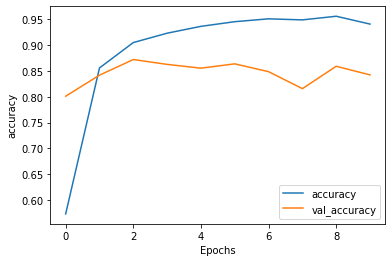

In [20]:
plot_graphs(history, 'accuracy')

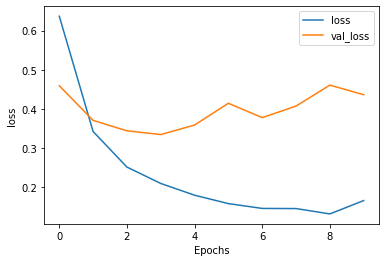

In [21]:
plot_graphs(history, 'loss')

## 堆叠两个或更多 LSTM 层

Keras 循环层有两种可用的模式，这些模式由 `return_sequences` 构造函数参数控制：

- 返回每个时间步骤的连续输出的完整序列（形状为 `(batch_size, timesteps, output_features)` 的 3D 张量）。
- 仅返回每个输入序列的最后一个输出（形状为 (batch_size, output_features) 的 2D 张量）。

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6927 - accuracy: 0.4688

  2/391 [..............................] - ETA: 39s - loss: 0.6920 - accuracy: 0.4297

  3/391 [..............................] - ETA: 49s - loss: 0.6922 - accuracy: 0.4427

  4/391 [..............................] - ETA: 49s - loss: 0.6925 - accuracy: 0.4531

  5/391 [..............................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4812

  6/391 [..............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.4844

  7/391 [..............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4911

  8/391 [..............................] - ETA: 1:01 - loss: 0.6934 - accuracy: 0.4941

  9/391 [..............................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.4931

 10/391 [..............................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.4875

 11/391 [..............................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4872 

 12/391 [..............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4870

 13/391 [..............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4892

 14/391 [>.............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.4933

 15/391 [>.............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4906

 16/391 [>.............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4961

 17/391 [>.............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4972 

 18/391 [>.............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4948

 19/391 [>.............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4942

 20/391 [>.............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4977

 21/391 [>.............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.5007

 22/391 [>.............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5014

 23/391 [>.............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.5027

 24/391 [>.............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.5013

 25/391 [>.............................] - ETA: 59s - loss: 0.6932 - accuracy: 0.5006 

 26/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5012

 27/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5029

 28/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5039

 29/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.5038

 30/391 [=>............................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.5036

 31/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5015

 32/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5020

 33/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5000

 34/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5000

 35/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5013

 36/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5030

 37/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5004

 38/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.4971

 39/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.4992

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5016

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5023

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5022

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5022

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5032

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5010

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5007

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5013

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5016

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5019

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5031

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5015

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5039

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5029

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5038

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5014

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4986

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4992

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4987

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.4963

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4987

 61/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4977 

 62/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4982

 63/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4970

 64/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4958

 65/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4971

 66/391 [====>.........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4967

 67/391 [====>.........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4965

 68/391 [====>.........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.4947

 69/391 [====>.........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.4946

 70/391 [====>.........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.4949

 71/391 [====>.........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.4956

 72/391 [====>.........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4974

 73/391 [====>.........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4983

 74/391 [====>.........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4985

 75/391 [====>.........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4979

 76/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4977

 77/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4980

 78/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4968

 79/391 [=====>........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4972

 80/391 [=====>........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4973

 81/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4981

 82/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4977

 83/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4972

 84/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4963

 85/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4961

 86/391 [=====>........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.4951

 87/391 [=====>........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.4955

 88/391 [=====>........................] - ETA: 54s - loss: 0.6930 - accuracy: 0.4959

 89/391 [=====>........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.4954

 90/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4964

 91/391 [=====>........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.4957

 92/391 [======>.......................] - ETA: 53s - loss: 0.6930 - accuracy: 0.4959

 93/391 [======>.......................] - ETA: 53s - loss: 0.6930 - accuracy: 0.4955

 94/391 [======>.......................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4962

 95/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4972

 96/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4977

 97/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4976

 98/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4987

 99/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4994

100/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5000

101/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4995

102/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4991

103/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4991

104/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4983

105/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4984

106/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4978

107/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4982

108/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4983

109/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4974

110/391 [=======>......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4977

111/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4975

112/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4978

113/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4975

114/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4963

115/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4965

116/391 [=======>......................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4973

117/391 [=======>......................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4979

118/391 [========>.....................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4979

119/391 [========>.....................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4972

120/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4979

121/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4979

122/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4981

123/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4985

124/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4986

125/391 [========>.....................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4989

126/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4991

127/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4994

128/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4989

129/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4985

130/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4982

131/391 [=========>....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4980

132/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4982

133/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4984

134/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4980

135/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4976

136/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4979

137/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4978

138/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4984

139/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4990

140/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4998

141/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4993

142/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4992

143/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4990

144/391 [==========>...................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4996

145/391 [==========>...................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4998

146/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5002

147/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5002

148/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5002

149/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4999

150/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4997

151/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4997

152/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4992

153/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4994

154/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4995

155/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5003

156/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5004

157/391 [===========>..................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4997

158/391 [===========>..................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4997

159/391 [===========>..................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4994

160/391 [===========>..................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4996

161/391 [===========>..................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4995

162/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.4998

163/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.5005

164/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.5003

165/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.5007

166/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.5002

167/391 [===========>..................] - ETA: 40s - loss: 0.6929 - accuracy: 0.4993

168/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4998

169/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4997

170/391 [============>.................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5001

171/391 [============>.................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4999

172/391 [============>.................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4997

173/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4994

174/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4991

175/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4994

176/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4992

177/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4987

178/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4986

179/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4994

180/391 [============>.................] - ETA: 37s - loss: 0.6928 - accuracy: 0.4987

181/391 [============>.................] - ETA: 37s - loss: 0.6928 - accuracy: 0.4982

182/391 [============>.................] - ETA: 37s - loss: 0.6928 - accuracy: 0.4980

183/391 [=============>................] - ETA: 37s - loss: 0.6928 - accuracy: 0.4981

184/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4980

185/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4977

186/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4976

187/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4974

188/391 [=============>................] - ETA: 36s - loss: 0.6928 - accuracy: 0.4974

189/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4979

190/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4980

191/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4980

192/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4981

193/391 [=============>................] - ETA: 35s - loss: 0.6928 - accuracy: 0.4986

194/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4988

195/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4987

196/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.4986

197/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.4987

198/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.4988

199/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4983

200/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4988

201/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4988

202/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4994

203/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4998

204/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.4997

205/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4997

206/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4995

207/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4989

208/391 [==============>...............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4991

209/391 [===============>..............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4993

210/391 [===============>..............] - ETA: 32s - loss: 0.6927 - accuracy: 0.4994

211/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4993

212/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4994

213/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4993

214/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4996

215/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4992

216/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4992

217/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4991

218/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4986

219/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4986

220/391 [===============>..............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4987

221/391 [===============>..............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4990

222/391 [================>.............] - ETA: 30s - loss: 0.6926 - accuracy: 0.4993

223/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4989

224/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4989

225/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4990

226/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4990

227/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4987

228/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4984

229/391 [================>.............] - ETA: 28s - loss: 0.6925 - accuracy: 0.4981

230/391 [================>.............] - ETA: 28s - loss: 0.6925 - accuracy: 0.4984

231/391 [================>.............] - ETA: 28s - loss: 0.6925 - accuracy: 0.4981

232/391 [================>.............] - ETA: 28s - loss: 0.6925 - accuracy: 0.4982

233/391 [================>.............] - ETA: 28s - loss: 0.6925 - accuracy: 0.4986

234/391 [================>.............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4989

235/391 [=================>............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4985

236/391 [=================>............] - ETA: 27s - loss: 0.6924 - accuracy: 0.4984

237/391 [=================>............] - ETA: 27s - loss: 0.6924 - accuracy: 0.4982

238/391 [=================>............] - ETA: 27s - loss: 0.6924 - accuracy: 0.4985

239/391 [=================>............] - ETA: 27s - loss: 0.6924 - accuracy: 0.4982

240/391 [=================>............] - ETA: 26s - loss: 0.6924 - accuracy: 0.4983

241/391 [=================>............] - ETA: 26s - loss: 0.6924 - accuracy: 0.4982

242/391 [=================>............] - ETA: 26s - loss: 0.6923 - accuracy: 0.4979

243/391 [=================>............] - ETA: 26s - loss: 0.6923 - accuracy: 0.4981

244/391 [=================>............] - ETA: 26s - loss: 0.6923 - accuracy: 0.4984

245/391 [=================>............] - ETA: 26s - loss: 0.6923 - accuracy: 0.4982

246/391 [=================>............] - ETA: 25s - loss: 0.6923 - accuracy: 0.4982

247/391 [=================>............] - ETA: 25s - loss: 0.6922 - accuracy: 0.4985

248/391 [==================>...........] - ETA: 25s - loss: 0.6922 - accuracy: 0.4982

249/391 [==================>...........] - ETA: 25s - loss: 0.6922 - accuracy: 0.4980

250/391 [==================>...........] - ETA: 25s - loss: 0.6921 - accuracy: 0.4978

251/391 [==================>...........] - ETA: 25s - loss: 0.6921 - accuracy: 0.4975

252/391 [==================>...........] - ETA: 24s - loss: 0.6920 - accuracy: 0.4971

253/391 [==================>...........] - ETA: 24s - loss: 0.6920 - accuracy: 0.4975

254/391 [==================>...........] - ETA: 24s - loss: 0.6920 - accuracy: 0.4976

255/391 [==================>...........] - ETA: 24s - loss: 0.6919 - accuracy: 0.4980

256/391 [==================>...........] - ETA: 24s - loss: 0.6919 - accuracy: 0.4984

257/391 [==================>...........] - ETA: 23s - loss: 0.6919 - accuracy: 0.4985

258/391 [==================>...........] - ETA: 23s - loss: 0.6918 - accuracy: 0.4985

259/391 [==================>...........] - ETA: 23s - loss: 0.6917 - accuracy: 0.4983

260/391 [==================>...........] - ETA: 23s - loss: 0.6916 - accuracy: 0.4983

261/391 [===================>..........] - ETA: 23s - loss: 0.6916 - accuracy: 0.4984

262/391 [===================>..........] - ETA: 23s - loss: 0.6915 - accuracy: 0.4984

263/391 [===================>..........] - ETA: 22s - loss: 0.6914 - accuracy: 0.4986

264/391 [===================>..........] - ETA: 22s - loss: 0.6914 - accuracy: 0.4986

265/391 [===================>..........] - ETA: 22s - loss: 0.6914 - accuracy: 0.4989

266/391 [===================>..........] - ETA: 22s - loss: 0.6913 - accuracy: 0.4989

267/391 [===================>..........] - ETA: 22s - loss: 0.6912 - accuracy: 0.4990

268/391 [===================>..........] - ETA: 22s - loss: 0.6910 - accuracy: 0.4992

269/391 [===================>..........] - ETA: 21s - loss: 0.6909 - accuracy: 0.4991

270/391 [===================>..........] - ETA: 21s - loss: 0.6906 - accuracy: 0.4988

271/391 [===================>..........] - ETA: 21s - loss: 0.6903 - accuracy: 0.4992

272/391 [===================>..........] - ETA: 21s - loss: 0.6903 - accuracy: 0.4994

273/391 [===================>..........] - ETA: 21s - loss: 0.6902 - accuracy: 0.4999

274/391 [====================>.........] - ETA: 20s - loss: 0.6902 - accuracy: 0.5003

275/391 [====================>.........] - ETA: 20s - loss: 0.6900 - accuracy: 0.5007

276/391 [====================>.........] - ETA: 20s - loss: 0.6897 - accuracy: 0.5014

277/391 [====================>.........] - ETA: 20s - loss: 0.6895 - accuracy: 0.5014

278/391 [====================>.........] - ETA: 20s - loss: 0.6893 - accuracy: 0.5017

279/391 [====================>.........] - ETA: 20s - loss: 0.6892 - accuracy: 0.5024

280/391 [====================>.........] - ETA: 19s - loss: 0.6889 - accuracy: 0.5028

281/391 [====================>.........] - ETA: 19s - loss: 0.6889 - accuracy: 0.5030

282/391 [====================>.........] - ETA: 19s - loss: 0.6887 - accuracy: 0.5032

283/391 [====================>.........] - ETA: 19s - loss: 0.6884 - accuracy: 0.5034

284/391 [====================>.........] - ETA: 19s - loss: 0.6882 - accuracy: 0.5037

285/391 [====================>.........] - ETA: 19s - loss: 0.6879 - accuracy: 0.5042

286/391 [====================>.........] - ETA: 18s - loss: 0.6875 - accuracy: 0.5046

287/391 [=====================>........] - ETA: 18s - loss: 0.6871 - accuracy: 0.5048

288/391 [=====================>........] - ETA: 18s - loss: 0.6870 - accuracy: 0.5052

289/391 [=====================>........] - ETA: 18s - loss: 0.6867 - accuracy: 0.5056

290/391 [=====================>........] - ETA: 18s - loss: 0.6863 - accuracy: 0.5065

291/391 [=====================>........] - ETA: 17s - loss: 0.6862 - accuracy: 0.5068

292/391 [=====================>........] - ETA: 17s - loss: 0.6863 - accuracy: 0.5071

293/391 [=====================>........] - ETA: 17s - loss: 0.6862 - accuracy: 0.5070

294/391 [=====================>........] - ETA: 17s - loss: 0.6859 - accuracy: 0.5075

295/391 [=====================>........] - ETA: 17s - loss: 0.6855 - accuracy: 0.5083

296/391 [=====================>........] - ETA: 17s - loss: 0.6853 - accuracy: 0.5089

297/391 [=====================>........] - ETA: 16s - loss: 0.6850 - accuracy: 0.5094

298/391 [=====================>........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5101

299/391 [=====================>........] - ETA: 16s - loss: 0.6845 - accuracy: 0.5102

300/391 [======================>.......] - ETA: 16s - loss: 0.6844 - accuracy: 0.5107

301/391 [======================>.......] - ETA: 16s - loss: 0.6840 - accuracy: 0.5115

302/391 [======================>.......] - ETA: 16s - loss: 0.6839 - accuracy: 0.5118

303/391 [======================>.......] - ETA: 15s - loss: 0.6837 - accuracy: 0.5125

304/391 [======================>.......] - ETA: 15s - loss: 0.6836 - accuracy: 0.5127

305/391 [======================>.......] - ETA: 15s - loss: 0.6833 - accuracy: 0.5136

306/391 [======================>.......] - ETA: 15s - loss: 0.6830 - accuracy: 0.5136

307/391 [======================>.......] - ETA: 15s - loss: 0.6828 - accuracy: 0.5136

308/391 [======================>.......] - ETA: 15s - loss: 0.6827 - accuracy: 0.5141

309/391 [======================>.......] - ETA: 14s - loss: 0.6825 - accuracy: 0.5146

310/391 [======================>.......] - ETA: 14s - loss: 0.6823 - accuracy: 0.5147

311/391 [======================>.......] - ETA: 14s - loss: 0.6821 - accuracy: 0.5151

312/391 [======================>.......] - ETA: 14s - loss: 0.6820 - accuracy: 0.5151

313/391 [=======================>......] - ETA: 14s - loss: 0.6817 - accuracy: 0.5157

314/391 [=======================>......] - ETA: 13s - loss: 0.6815 - accuracy: 0.5157

315/391 [=======================>......] - ETA: 13s - loss: 0.6815 - accuracy: 0.5159

316/391 [=======================>......] - ETA: 13s - loss: 0.6811 - accuracy: 0.5164

317/391 [=======================>......] - ETA: 13s - loss: 0.6806 - accuracy: 0.5172

318/391 [=======================>......] - ETA: 13s - loss: 0.6805 - accuracy: 0.5175

319/391 [=======================>......] - ETA: 13s - loss: 0.6803 - accuracy: 0.5180

320/391 [=======================>......] - ETA: 12s - loss: 0.6801 - accuracy: 0.5186

321/391 [=======================>......] - ETA: 12s - loss: 0.6798 - accuracy: 0.5191

322/391 [=======================>......] - ETA: 12s - loss: 0.6797 - accuracy: 0.5191

323/391 [=======================>......] - ETA: 12s - loss: 0.6793 - accuracy: 0.5196

324/391 [=======================>......] - ETA: 12s - loss: 0.6789 - accuracy: 0.5203

325/391 [=======================>......] - ETA: 11s - loss: 0.6784 - accuracy: 0.5210

326/391 [========================>.....] - ETA: 11s - loss: 0.6779 - accuracy: 0.5218

327/391 [========================>.....] - ETA: 11s - loss: 0.6775 - accuracy: 0.5222

328/391 [========================>.....] - ETA: 11s - loss: 0.6771 - accuracy: 0.5226

329/391 [========================>.....] - ETA: 11s - loss: 0.6764 - accuracy: 0.5235

330/391 [========================>.....] - ETA: 11s - loss: 0.6762 - accuracy: 0.5240

331/391 [========================>.....] - ETA: 10s - loss: 0.6758 - accuracy: 0.5246

332/391 [========================>.....] - ETA: 10s - loss: 0.6752 - accuracy: 0.5255

333/391 [========================>.....] - ETA: 10s - loss: 0.6743 - accuracy: 0.5265

334/391 [========================>.....] - ETA: 10s - loss: 0.6737 - accuracy: 0.5271

335/391 [========================>.....] - ETA: 10s - loss: 0.6730 - accuracy: 0.5281

336/391 [========================>.....] - ETA: 10s - loss: 0.6722 - accuracy: 0.5290

337/391 [========================>.....] - ETA: 9s - loss: 0.6715 - accuracy: 0.5298 

338/391 [========================>.....] - ETA: 9s - loss: 0.6712 - accuracy: 0.5304

339/391 [=========================>....] - ETA: 9s - loss: 0.6708 - accuracy: 0.5310

340/391 [=========================>....] - ETA: 9s - loss: 0.6709 - accuracy: 0.5313

341/391 [=========================>....] - ETA: 9s - loss: 0.6703 - accuracy: 0.5322

342/391 [=========================>....] - ETA: 8s - loss: 0.6698 - accuracy: 0.5329

343/391 [=========================>....] - ETA: 8s - loss: 0.6690 - accuracy: 0.5338

344/391 [=========================>....] - ETA: 8s - loss: 0.6683 - accuracy: 0.5348

345/391 [=========================>....] - ETA: 8s - loss: 0.6676 - accuracy: 0.5356

346/391 [=========================>....] - ETA: 8s - loss: 0.6674 - accuracy: 0.5361

347/391 [=========================>....] - ETA: 8s - loss: 0.6670 - accuracy: 0.5367

348/391 [=========================>....] - ETA: 7s - loss: 0.6669 - accuracy: 0.5371

349/391 [=========================>....] - ETA: 7s - loss: 0.6665 - accuracy: 0.5376

350/391 [=========================>....] - ETA: 7s - loss: 0.6663 - accuracy: 0.5380

351/391 [=========================>....] - ETA: 7s - loss: 0.6658 - accuracy: 0.5386

352/391 [==========================>...] - ETA: 7s - loss: 0.6651 - accuracy: 0.5396

353/391 [==========================>...] - ETA: 6s - loss: 0.6646 - accuracy: 0.5403

354/391 [==========================>...] - ETA: 6s - loss: 0.6640 - accuracy: 0.5410

355/391 [==========================>...] - ETA: 6s - loss: 0.6633 - accuracy: 0.5420

356/391 [==========================>...] - ETA: 6s - loss: 0.6629 - accuracy: 0.5428

357/391 [==========================>...] - ETA: 6s - loss: 0.6627 - accuracy: 0.5434

358/391 [==========================>...] - ETA: 6s - loss: 0.6626 - accuracy: 0.5438

359/391 [==========================>...] - ETA: 5s - loss: 0.6619 - accuracy: 0.5447

360/391 [==========================>...] - ETA: 5s - loss: 0.6612 - accuracy: 0.5454

361/391 [==========================>...] - ETA: 5s - loss: 0.6608 - accuracy: 0.5460

362/391 [==========================>...] - ETA: 5s - loss: 0.6604 - accuracy: 0.5466

363/391 [==========================>...] - ETA: 5s - loss: 0.6598 - accuracy: 0.5473

364/391 [==========================>...] - ETA: 4s - loss: 0.6594 - accuracy: 0.5479

365/391 [===========================>..] - ETA: 4s - loss: 0.6588 - accuracy: 0.5486

366/391 [===========================>..] - ETA: 4s - loss: 0.6584 - accuracy: 0.5493

367/391 [===========================>..] - ETA: 4s - loss: 0.6580 - accuracy: 0.5499

368/391 [===========================>..] - ETA: 4s - loss: 0.6575 - accuracy: 0.5505

369/391 [===========================>..] - ETA: 4s - loss: 0.6570 - accuracy: 0.5513

370/391 [===========================>..] - ETA: 3s - loss: 0.6567 - accuracy: 0.5519

371/391 [===========================>..] - ETA: 3s - loss: 0.6563 - accuracy: 0.5526

372/391 [===========================>..] - ETA: 3s - loss: 0.6560 - accuracy: 0.5529

373/391 [===========================>..] - ETA: 3s - loss: 0.6562 - accuracy: 0.5529

374/391 [===========================>..] - ETA: 3s - loss: 0.6560 - accuracy: 0.5533

375/391 [===========================>..] - ETA: 2s - loss: 0.6555 - accuracy: 0.5538

376/391 [===========================>..] - ETA: 2s - loss: 0.6549 - accuracy: 0.5546

377/391 [===========================>..] - ETA: 2s - loss: 0.6542 - accuracy: 0.5554

378/391 [============================>.] - ETA: 2s - loss: 0.6539 - accuracy: 0.5559

379/391 [============================>.] - ETA: 2s - loss: 0.6535 - accuracy: 0.5564

380/391 [============================>.] - ETA: 2s - loss: 0.6531 - accuracy: 0.5571

381/391 [============================>.] - ETA: 1s - loss: 0.6528 - accuracy: 0.5576

382/391 [============================>.] - ETA: 1s - loss: 0.6524 - accuracy: 0.5580

383/391 [============================>.] - ETA: 1s - loss: 0.6520 - accuracy: 0.5585

384/391 [============================>.] - ETA: 1s - loss: 0.6515 - accuracy: 0.5590

385/391 [============================>.] - ETA: 1s - loss: 0.6509 - accuracy: 0.5598

386/391 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.5603

387/391 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.5610

388/391 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.5616

389/391 [============================>.] - ETA: 0s - loss: 0.6492 - accuracy: 0.5621

390/391 [============================>.] - ETA: 0s - loss: 0.6487 - accuracy: 0.5626

391/391 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.5630

391/391 [==============================] - 75s 192ms/step - loss: 0.6484 - accuracy: 0.5630 - val_loss: 0.4876 - val_accuracy: 0.7464


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5336 - accuracy: 0.7656

  2/391 [..............................] - ETA: 41s - loss: 0.4813 - accuracy: 0.7734

  3/391 [..............................] - ETA: 49s - loss: 0.4785 - accuracy: 0.7656

  4/391 [..............................] - ETA: 56s - loss: 0.4587 - accuracy: 0.7695

  5/391 [..............................] - ETA: 57s - loss: 0.4493 - accuracy: 0.7812

  6/391 [..............................] - ETA: 58s - loss: 0.4370 - accuracy: 0.7969

  7/391 [..............................] - ETA: 59s - loss: 0.4486 - accuracy: 0.7924

  8/391 [..............................] - ETA: 59s - loss: 0.4596 - accuracy: 0.7891

  9/391 [..............................] - ETA: 1:00 - loss: 0.4548 - accuracy: 0.7951

 10/391 [..............................] - ETA: 1:02 - loss: 0.4525 - accuracy: 0.7969

 11/391 [..............................] - ETA: 1:03 - loss: 0.4492 - accuracy: 0.8040

 12/391 [..............................] - ETA: 1:03 - loss: 0.4515 - accuracy: 0.8008

 13/391 [..............................] - ETA: 1:03 - loss: 0.4517 - accuracy: 0.8017

 14/391 [>.............................] - ETA: 1:03 - loss: 0.4441 - accuracy: 0.8080

 15/391 [>.............................] - ETA: 1:04 - loss: 0.4442 - accuracy: 0.8073

 16/391 [>.............................] - ETA: 1:02 - loss: 0.4357 - accuracy: 0.8135

 17/391 [>.............................] - ETA: 1:02 - loss: 0.4354 - accuracy: 0.8125

 18/391 [>.............................] - ETA: 1:02 - loss: 0.4314 - accuracy: 0.8142

 19/391 [>.............................] - ETA: 1:03 - loss: 0.4304 - accuracy: 0.8141

 20/391 [>.............................] - ETA: 1:03 - loss: 0.4277 - accuracy: 0.8148

 21/391 [>.............................] - ETA: 1:04 - loss: 0.4315 - accuracy: 0.8155

 22/391 [>.............................] - ETA: 1:04 - loss: 0.4304 - accuracy: 0.8146

 23/391 [>.............................] - ETA: 1:04 - loss: 0.4301 - accuracy: 0.8159

 24/391 [>.............................] - ETA: 1:04 - loss: 0.4274 - accuracy: 0.8158

 25/391 [>.............................] - ETA: 1:04 - loss: 0.4225 - accuracy: 0.8175

 26/391 [>.............................] - ETA: 1:03 - loss: 0.4210 - accuracy: 0.8185

 27/391 [=>............................] - ETA: 1:03 - loss: 0.4208 - accuracy: 0.8194

 28/391 [=>............................] - ETA: 1:03 - loss: 0.4196 - accuracy: 0.8203

 29/391 [=>............................] - ETA: 1:02 - loss: 0.4187 - accuracy: 0.8211

 30/391 [=>............................] - ETA: 1:02 - loss: 0.4180 - accuracy: 0.8214

 31/391 [=>............................] - ETA: 1:02 - loss: 0.4170 - accuracy: 0.8231

 32/391 [=>............................] - ETA: 1:01 - loss: 0.4182 - accuracy: 0.8242

 33/391 [=>............................] - ETA: 1:01 - loss: 0.4193 - accuracy: 0.8253

 34/391 [=>............................] - ETA: 1:02 - loss: 0.4228 - accuracy: 0.8231

 35/391 [=>............................] - ETA: 1:02 - loss: 0.4273 - accuracy: 0.8196

 36/391 [=>............................] - ETA: 1:02 - loss: 0.4278 - accuracy: 0.8190

 37/391 [=>............................] - ETA: 1:02 - loss: 0.4286 - accuracy: 0.8188

 38/391 [=>............................] - ETA: 1:02 - loss: 0.4293 - accuracy: 0.8183

 39/391 [=>............................] - ETA: 1:02 - loss: 0.4315 - accuracy: 0.8161

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.4324 - accuracy: 0.8164

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.4341 - accuracy: 0.8148

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.4341 - accuracy: 0.8147

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.4353 - accuracy: 0.8143

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.4374 - accuracy: 0.8125

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.4383 - accuracy: 0.8115

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.4391 - accuracy: 0.8108

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.4394 - accuracy: 0.8102

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.4390 - accuracy: 0.8086

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.4396 - accuracy: 0.8084

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.4397 - accuracy: 0.8078

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.4392 - accuracy: 0.8079

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.4420 - accuracy: 0.8059

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.4408 - accuracy: 0.8057

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.4405 - accuracy: 0.8058

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.4394 - accuracy: 0.8060

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.4389 - accuracy: 0.8064

 57/391 [===>..........................] - ETA: 59s - loss: 0.4400 - accuracy: 0.8059 

 58/391 [===>..........................] - ETA: 59s - loss: 0.4376 - accuracy: 0.8079

 59/391 [===>..........................] - ETA: 59s - loss: 0.4384 - accuracy: 0.8075

 60/391 [===>..........................] - ETA: 59s - loss: 0.4376 - accuracy: 0.8081

 61/391 [===>..........................] - ETA: 59s - loss: 0.4375 - accuracy: 0.8074

 62/391 [===>..........................] - ETA: 59s - loss: 0.4379 - accuracy: 0.8075

 63/391 [===>..........................] - ETA: 58s - loss: 0.4384 - accuracy: 0.8075

 64/391 [===>..........................] - ETA: 58s - loss: 0.4391 - accuracy: 0.8081

 65/391 [===>..........................] - ETA: 58s - loss: 0.4390 - accuracy: 0.8079

 66/391 [====>.........................] - ETA: 58s - loss: 0.4384 - accuracy: 0.8085

 67/391 [====>.........................] - ETA: 58s - loss: 0.4363 - accuracy: 0.8092

 68/391 [====>.........................] - ETA: 58s - loss: 0.4362 - accuracy: 0.8097

 69/391 [====>.........................] - ETA: 58s - loss: 0.4351 - accuracy: 0.8107

 70/391 [====>.........................] - ETA: 57s - loss: 0.4337 - accuracy: 0.8116

 71/391 [====>.........................] - ETA: 57s - loss: 0.4331 - accuracy: 0.8112

 72/391 [====>.........................] - ETA: 57s - loss: 0.4328 - accuracy: 0.8112

 73/391 [====>.........................] - ETA: 57s - loss: 0.4319 - accuracy: 0.8116

 74/391 [====>.........................] - ETA: 57s - loss: 0.4312 - accuracy: 0.8125

 75/391 [====>.........................] - ETA: 57s - loss: 0.4324 - accuracy: 0.8117

 76/391 [====>.........................] - ETA: 56s - loss: 0.4306 - accuracy: 0.8123

 77/391 [====>.........................] - ETA: 56s - loss: 0.4288 - accuracy: 0.8133

 78/391 [====>.........................] - ETA: 56s - loss: 0.4292 - accuracy: 0.8127

 79/391 [=====>........................] - ETA: 56s - loss: 0.4314 - accuracy: 0.8111

 80/391 [=====>........................] - ETA: 56s - loss: 0.4307 - accuracy: 0.8117

 81/391 [=====>........................] - ETA: 55s - loss: 0.4295 - accuracy: 0.8123

 82/391 [=====>........................] - ETA: 55s - loss: 0.4283 - accuracy: 0.8136

 83/391 [=====>........................] - ETA: 55s - loss: 0.4268 - accuracy: 0.8148

 84/391 [=====>........................] - ETA: 55s - loss: 0.4266 - accuracy: 0.8144

 85/391 [=====>........................] - ETA: 55s - loss: 0.4252 - accuracy: 0.8154

 86/391 [=====>........................] - ETA: 55s - loss: 0.4247 - accuracy: 0.8160

 87/391 [=====>........................] - ETA: 54s - loss: 0.4254 - accuracy: 0.8150

 88/391 [=====>........................] - ETA: 54s - loss: 0.4243 - accuracy: 0.8155

 89/391 [=====>........................] - ETA: 54s - loss: 0.4237 - accuracy: 0.8158

 90/391 [=====>........................] - ETA: 54s - loss: 0.4232 - accuracy: 0.8160

 91/391 [=====>........................] - ETA: 54s - loss: 0.4220 - accuracy: 0.8166

 92/391 [======>.......................] - ETA: 53s - loss: 0.4209 - accuracy: 0.8178

 93/391 [======>.......................] - ETA: 53s - loss: 0.4192 - accuracy: 0.8189

 94/391 [======>.......................] - ETA: 53s - loss: 0.4201 - accuracy: 0.8185

 95/391 [======>.......................] - ETA: 53s - loss: 0.4201 - accuracy: 0.8188

 96/391 [======>.......................] - ETA: 53s - loss: 0.4205 - accuracy: 0.8180

 97/391 [======>.......................] - ETA: 53s - loss: 0.4194 - accuracy: 0.8188

 98/391 [======>.......................] - ETA: 52s - loss: 0.4181 - accuracy: 0.8194

 99/391 [======>.......................] - ETA: 52s - loss: 0.4174 - accuracy: 0.8196

100/391 [======>.......................] - ETA: 52s - loss: 0.4167 - accuracy: 0.8203

101/391 [======>.......................] - ETA: 52s - loss: 0.4162 - accuracy: 0.8204

102/391 [======>.......................] - ETA: 52s - loss: 0.4163 - accuracy: 0.8208

103/391 [======>.......................] - ETA: 51s - loss: 0.4162 - accuracy: 0.8210

104/391 [======>.......................] - ETA: 51s - loss: 0.4169 - accuracy: 0.8208

105/391 [=======>......................] - ETA: 51s - loss: 0.4164 - accuracy: 0.8208

106/391 [=======>......................] - ETA: 51s - loss: 0.4161 - accuracy: 0.8209

107/391 [=======>......................] - ETA: 50s - loss: 0.4151 - accuracy: 0.8214

108/391 [=======>......................] - ETA: 51s - loss: 0.4139 - accuracy: 0.8222

109/391 [=======>......................] - ETA: 50s - loss: 0.4130 - accuracy: 0.8225

110/391 [=======>......................] - ETA: 50s - loss: 0.4127 - accuracy: 0.8227

111/391 [=======>......................] - ETA: 50s - loss: 0.4119 - accuracy: 0.8232

112/391 [=======>......................] - ETA: 50s - loss: 0.4113 - accuracy: 0.8237

113/391 [=======>......................] - ETA: 50s - loss: 0.4108 - accuracy: 0.8243

114/391 [=======>......................] - ETA: 49s - loss: 0.4119 - accuracy: 0.8239

115/391 [=======>......................] - ETA: 49s - loss: 0.4115 - accuracy: 0.8242

116/391 [=======>......................] - ETA: 49s - loss: 0.4116 - accuracy: 0.8239

117/391 [=======>......................] - ETA: 49s - loss: 0.4110 - accuracy: 0.8240

118/391 [========>.....................] - ETA: 49s - loss: 0.4102 - accuracy: 0.8244

119/391 [========>.....................] - ETA: 49s - loss: 0.4098 - accuracy: 0.8250

120/391 [========>.....................] - ETA: 49s - loss: 0.4090 - accuracy: 0.8253

121/391 [========>.....................] - ETA: 48s - loss: 0.4076 - accuracy: 0.8259

122/391 [========>.....................] - ETA: 48s - loss: 0.4081 - accuracy: 0.8259

123/391 [========>.....................] - ETA: 48s - loss: 0.4085 - accuracy: 0.8261

124/391 [========>.....................] - ETA: 48s - loss: 0.4090 - accuracy: 0.8264

125/391 [========>.....................] - ETA: 47s - loss: 0.4092 - accuracy: 0.8259

126/391 [========>.....................] - ETA: 47s - loss: 0.4091 - accuracy: 0.8255

127/391 [========>.....................] - ETA: 47s - loss: 0.4094 - accuracy: 0.8250

128/391 [========>.....................] - ETA: 47s - loss: 0.4084 - accuracy: 0.8257

129/391 [========>.....................] - ETA: 47s - loss: 0.4070 - accuracy: 0.8264

130/391 [========>.....................] - ETA: 46s - loss: 0.4069 - accuracy: 0.8264

131/391 [=========>....................] - ETA: 46s - loss: 0.4062 - accuracy: 0.8268

132/391 [=========>....................] - ETA: 46s - loss: 0.4052 - accuracy: 0.8277

133/391 [=========>....................] - ETA: 46s - loss: 0.4045 - accuracy: 0.8281

134/391 [=========>....................] - ETA: 46s - loss: 0.4052 - accuracy: 0.8278

135/391 [=========>....................] - ETA: 46s - loss: 0.4047 - accuracy: 0.8279

136/391 [=========>....................] - ETA: 45s - loss: 0.4042 - accuracy: 0.8281

137/391 [=========>....................] - ETA: 45s - loss: 0.4038 - accuracy: 0.8284

138/391 [=========>....................] - ETA: 45s - loss: 0.4036 - accuracy: 0.8285

139/391 [=========>....................] - ETA: 45s - loss: 0.4034 - accuracy: 0.8287

140/391 [=========>....................] - ETA: 44s - loss: 0.4024 - accuracy: 0.8296

141/391 [=========>....................] - ETA: 44s - loss: 0.4021 - accuracy: 0.8300

142/391 [=========>....................] - ETA: 44s - loss: 0.4014 - accuracy: 0.8302

143/391 [=========>....................] - ETA: 44s - loss: 0.4009 - accuracy: 0.8302

144/391 [==========>...................] - ETA: 44s - loss: 0.4005 - accuracy: 0.8303

145/391 [==========>...................] - ETA: 44s - loss: 0.4003 - accuracy: 0.8306

146/391 [==========>...................] - ETA: 43s - loss: 0.3998 - accuracy: 0.8309

147/391 [==========>...................] - ETA: 43s - loss: 0.3996 - accuracy: 0.8310

148/391 [==========>...................] - ETA: 43s - loss: 0.3987 - accuracy: 0.8315

149/391 [==========>...................] - ETA: 43s - loss: 0.3982 - accuracy: 0.8318

150/391 [==========>...................] - ETA: 43s - loss: 0.3980 - accuracy: 0.8318

151/391 [==========>...................] - ETA: 43s - loss: 0.3974 - accuracy: 0.8320

152/391 [==========>...................] - ETA: 42s - loss: 0.3966 - accuracy: 0.8325

153/391 [==========>...................] - ETA: 42s - loss: 0.3963 - accuracy: 0.8328

154/391 [==========>...................] - ETA: 42s - loss: 0.3958 - accuracy: 0.8332

155/391 [==========>...................] - ETA: 42s - loss: 0.3957 - accuracy: 0.8334

156/391 [==========>...................] - ETA: 42s - loss: 0.3953 - accuracy: 0.8337

157/391 [===========>..................] - ETA: 42s - loss: 0.3944 - accuracy: 0.8344

158/391 [===========>..................] - ETA: 41s - loss: 0.3948 - accuracy: 0.8339

159/391 [===========>..................] - ETA: 41s - loss: 0.3946 - accuracy: 0.8341

160/391 [===========>..................] - ETA: 41s - loss: 0.3950 - accuracy: 0.8340

161/391 [===========>..................] - ETA: 41s - loss: 0.3952 - accuracy: 0.8341

162/391 [===========>..................] - ETA: 41s - loss: 0.3954 - accuracy: 0.8343

163/391 [===========>..................] - ETA: 40s - loss: 0.3957 - accuracy: 0.8343

164/391 [===========>..................] - ETA: 40s - loss: 0.3963 - accuracy: 0.8338

165/391 [===========>..................] - ETA: 40s - loss: 0.3961 - accuracy: 0.8343

166/391 [===========>..................] - ETA: 40s - loss: 0.3955 - accuracy: 0.8344

167/391 [===========>..................] - ETA: 40s - loss: 0.3950 - accuracy: 0.8348

168/391 [===========>..................] - ETA: 40s - loss: 0.3947 - accuracy: 0.8344

169/391 [===========>..................] - ETA: 40s - loss: 0.3944 - accuracy: 0.8345

170/391 [============>.................] - ETA: 39s - loss: 0.3942 - accuracy: 0.8346

171/391 [============>.................] - ETA: 39s - loss: 0.3940 - accuracy: 0.8348

172/391 [============>.................] - ETA: 39s - loss: 0.3941 - accuracy: 0.8347

173/391 [============>.................] - ETA: 39s - loss: 0.3937 - accuracy: 0.8348

174/391 [============>.................] - ETA: 39s - loss: 0.3937 - accuracy: 0.8347

175/391 [============>.................] - ETA: 39s - loss: 0.3931 - accuracy: 0.8350

176/391 [============>.................] - ETA: 38s - loss: 0.3929 - accuracy: 0.8351

177/391 [============>.................] - ETA: 38s - loss: 0.3922 - accuracy: 0.8354

178/391 [============>.................] - ETA: 38s - loss: 0.3914 - accuracy: 0.8359

179/391 [============>.................] - ETA: 38s - loss: 0.3909 - accuracy: 0.8361

180/391 [============>.................] - ETA: 38s - loss: 0.3905 - accuracy: 0.8362

181/391 [============>.................] - ETA: 37s - loss: 0.3906 - accuracy: 0.8362

182/391 [============>.................] - ETA: 37s - loss: 0.3903 - accuracy: 0.8363

183/391 [=============>................] - ETA: 37s - loss: 0.3901 - accuracy: 0.8364

184/391 [=============>................] - ETA: 37s - loss: 0.3896 - accuracy: 0.8367

185/391 [=============>................] - ETA: 37s - loss: 0.3902 - accuracy: 0.8367

186/391 [=============>................] - ETA: 37s - loss: 0.3900 - accuracy: 0.8369

187/391 [=============>................] - ETA: 37s - loss: 0.3898 - accuracy: 0.8370

188/391 [=============>................] - ETA: 36s - loss: 0.3898 - accuracy: 0.8370

189/391 [=============>................] - ETA: 36s - loss: 0.3894 - accuracy: 0.8373

190/391 [=============>................] - ETA: 36s - loss: 0.3895 - accuracy: 0.8373

191/391 [=============>................] - ETA: 36s - loss: 0.3891 - accuracy: 0.8377

192/391 [=============>................] - ETA: 36s - loss: 0.3887 - accuracy: 0.8378

193/391 [=============>................] - ETA: 36s - loss: 0.3886 - accuracy: 0.8379

194/391 [=============>................] - ETA: 35s - loss: 0.3884 - accuracy: 0.8382

195/391 [=============>................] - ETA: 35s - loss: 0.3884 - accuracy: 0.8383

196/391 [==============>...............] - ETA: 35s - loss: 0.3883 - accuracy: 0.8384

197/391 [==============>...............] - ETA: 35s - loss: 0.3886 - accuracy: 0.8384

198/391 [==============>...............] - ETA: 35s - loss: 0.3888 - accuracy: 0.8382

199/391 [==============>...............] - ETA: 34s - loss: 0.3889 - accuracy: 0.8381

200/391 [==============>...............] - ETA: 34s - loss: 0.3886 - accuracy: 0.8380

201/391 [==============>...............] - ETA: 34s - loss: 0.3885 - accuracy: 0.8378

202/391 [==============>...............] - ETA: 34s - loss: 0.3882 - accuracy: 0.8377

203/391 [==============>...............] - ETA: 34s - loss: 0.3881 - accuracy: 0.8377

204/391 [==============>...............] - ETA: 34s - loss: 0.3879 - accuracy: 0.8377

205/391 [==============>...............] - ETA: 33s - loss: 0.3877 - accuracy: 0.8379

206/391 [==============>...............] - ETA: 33s - loss: 0.3874 - accuracy: 0.8381

207/391 [==============>...............] - ETA: 33s - loss: 0.3870 - accuracy: 0.8385

208/391 [==============>...............] - ETA: 33s - loss: 0.3868 - accuracy: 0.8385

209/391 [===============>..............] - ETA: 33s - loss: 0.3866 - accuracy: 0.8385

210/391 [===============>..............] - ETA: 33s - loss: 0.3861 - accuracy: 0.8388

211/391 [===============>..............] - ETA: 32s - loss: 0.3858 - accuracy: 0.8392

212/391 [===============>..............] - ETA: 32s - loss: 0.3855 - accuracy: 0.8394

213/391 [===============>..............] - ETA: 32s - loss: 0.3859 - accuracy: 0.8393

214/391 [===============>..............] - ETA: 32s - loss: 0.3856 - accuracy: 0.8394

215/391 [===============>..............] - ETA: 32s - loss: 0.3855 - accuracy: 0.8393

216/391 [===============>..............] - ETA: 31s - loss: 0.3850 - accuracy: 0.8394

217/391 [===============>..............] - ETA: 31s - loss: 0.3848 - accuracy: 0.8393

218/391 [===============>..............] - ETA: 31s - loss: 0.3849 - accuracy: 0.8390

219/391 [===============>..............] - ETA: 31s - loss: 0.3847 - accuracy: 0.8390

220/391 [===============>..............] - ETA: 31s - loss: 0.3845 - accuracy: 0.8393

221/391 [===============>..............] - ETA: 30s - loss: 0.3846 - accuracy: 0.8393

222/391 [================>.............] - ETA: 30s - loss: 0.3846 - accuracy: 0.8392

223/391 [================>.............] - ETA: 30s - loss: 0.3850 - accuracy: 0.8389

224/391 [================>.............] - ETA: 30s - loss: 0.3848 - accuracy: 0.8391

225/391 [================>.............] - ETA: 30s - loss: 0.3842 - accuracy: 0.8396

226/391 [================>.............] - ETA: 30s - loss: 0.3844 - accuracy: 0.8397

227/391 [================>.............] - ETA: 29s - loss: 0.3843 - accuracy: 0.8397

228/391 [================>.............] - ETA: 29s - loss: 0.3836 - accuracy: 0.8400

229/391 [================>.............] - ETA: 29s - loss: 0.3837 - accuracy: 0.8399

230/391 [================>.............] - ETA: 29s - loss: 0.3833 - accuracy: 0.8404

231/391 [================>.............] - ETA: 29s - loss: 0.3834 - accuracy: 0.8402

232/391 [================>.............] - ETA: 28s - loss: 0.3830 - accuracy: 0.8403

233/391 [================>.............] - ETA: 28s - loss: 0.3823 - accuracy: 0.8405

234/391 [================>.............] - ETA: 28s - loss: 0.3824 - accuracy: 0.8402

235/391 [=================>............] - ETA: 28s - loss: 0.3819 - accuracy: 0.8403

236/391 [=================>............] - ETA: 28s - loss: 0.3824 - accuracy: 0.8398

237/391 [=================>............] - ETA: 27s - loss: 0.3820 - accuracy: 0.8401

238/391 [=================>............] - ETA: 27s - loss: 0.3819 - accuracy: 0.8402

239/391 [=================>............] - ETA: 27s - loss: 0.3815 - accuracy: 0.8404

240/391 [=================>............] - ETA: 27s - loss: 0.3818 - accuracy: 0.8404

241/391 [=================>............] - ETA: 27s - loss: 0.3815 - accuracy: 0.8404

242/391 [=================>............] - ETA: 26s - loss: 0.3819 - accuracy: 0.8401

243/391 [=================>............] - ETA: 26s - loss: 0.3818 - accuracy: 0.8403

244/391 [=================>............] - ETA: 26s - loss: 0.3817 - accuracy: 0.8402

245/391 [=================>............] - ETA: 26s - loss: 0.3807 - accuracy: 0.8408

246/391 [=================>............] - ETA: 26s - loss: 0.3802 - accuracy: 0.8411

247/391 [=================>............] - ETA: 25s - loss: 0.3800 - accuracy: 0.8412

248/391 [==================>...........] - ETA: 25s - loss: 0.3804 - accuracy: 0.8410

249/391 [==================>...........] - ETA: 25s - loss: 0.3798 - accuracy: 0.8413

250/391 [==================>...........] - ETA: 25s - loss: 0.3797 - accuracy: 0.8414

251/391 [==================>...........] - ETA: 25s - loss: 0.3796 - accuracy: 0.8415

252/391 [==================>...........] - ETA: 25s - loss: 0.3791 - accuracy: 0.8418

253/391 [==================>...........] - ETA: 24s - loss: 0.3786 - accuracy: 0.8422

254/391 [==================>...........] - ETA: 24s - loss: 0.3789 - accuracy: 0.8422

255/391 [==================>...........] - ETA: 24s - loss: 0.3784 - accuracy: 0.8423

256/391 [==================>...........] - ETA: 24s - loss: 0.3783 - accuracy: 0.8425

257/391 [==================>...........] - ETA: 24s - loss: 0.3781 - accuracy: 0.8424

258/391 [==================>...........] - ETA: 24s - loss: 0.3779 - accuracy: 0.8424

259/391 [==================>...........] - ETA: 23s - loss: 0.3777 - accuracy: 0.8427

260/391 [==================>...........] - ETA: 23s - loss: 0.3773 - accuracy: 0.8429

261/391 [===================>..........] - ETA: 23s - loss: 0.3772 - accuracy: 0.8430

262/391 [===================>..........] - ETA: 23s - loss: 0.3767 - accuracy: 0.8433

263/391 [===================>..........] - ETA: 23s - loss: 0.3761 - accuracy: 0.8436

264/391 [===================>..........] - ETA: 23s - loss: 0.3758 - accuracy: 0.8438

265/391 [===================>..........] - ETA: 22s - loss: 0.3757 - accuracy: 0.8436

266/391 [===================>..........] - ETA: 22s - loss: 0.3753 - accuracy: 0.8438

267/391 [===================>..........] - ETA: 22s - loss: 0.3753 - accuracy: 0.8438

268/391 [===================>..........] - ETA: 22s - loss: 0.3751 - accuracy: 0.8439

269/391 [===================>..........] - ETA: 22s - loss: 0.3749 - accuracy: 0.8440

270/391 [===================>..........] - ETA: 21s - loss: 0.3745 - accuracy: 0.8443

271/391 [===================>..........] - ETA: 21s - loss: 0.3745 - accuracy: 0.8444

272/391 [===================>..........] - ETA: 21s - loss: 0.3742 - accuracy: 0.8447

273/391 [===================>..........] - ETA: 21s - loss: 0.3743 - accuracy: 0.8448

274/391 [====================>.........] - ETA: 21s - loss: 0.3747 - accuracy: 0.8448

275/391 [====================>.........] - ETA: 21s - loss: 0.3746 - accuracy: 0.8448

276/391 [====================>.........] - ETA: 20s - loss: 0.3741 - accuracy: 0.8450

277/391 [====================>.........] - ETA: 20s - loss: 0.3741 - accuracy: 0.8450

278/391 [====================>.........] - ETA: 20s - loss: 0.3742 - accuracy: 0.8449

279/391 [====================>.........] - ETA: 20s - loss: 0.3745 - accuracy: 0.8447

280/391 [====================>.........] - ETA: 20s - loss: 0.3747 - accuracy: 0.8446

281/391 [====================>.........] - ETA: 19s - loss: 0.3748 - accuracy: 0.8445

282/391 [====================>.........] - ETA: 19s - loss: 0.3745 - accuracy: 0.8448

283/391 [====================>.........] - ETA: 19s - loss: 0.3741 - accuracy: 0.8450

284/391 [====================>.........] - ETA: 19s - loss: 0.3740 - accuracy: 0.8451

285/391 [====================>.........] - ETA: 19s - loss: 0.3740 - accuracy: 0.8449

286/391 [====================>.........] - ETA: 19s - loss: 0.3737 - accuracy: 0.8451

287/391 [=====================>........] - ETA: 18s - loss: 0.3737 - accuracy: 0.8452

288/391 [=====================>........] - ETA: 18s - loss: 0.3738 - accuracy: 0.8452

289/391 [=====================>........] - ETA: 18s - loss: 0.3740 - accuracy: 0.8450

290/391 [=====================>........] - ETA: 18s - loss: 0.3738 - accuracy: 0.8452

291/391 [=====================>........] - ETA: 18s - loss: 0.3738 - accuracy: 0.8451

292/391 [=====================>........] - ETA: 18s - loss: 0.3734 - accuracy: 0.8452

293/391 [=====================>........] - ETA: 17s - loss: 0.3732 - accuracy: 0.8453

294/391 [=====================>........] - ETA: 17s - loss: 0.3736 - accuracy: 0.8452

295/391 [=====================>........] - ETA: 17s - loss: 0.3734 - accuracy: 0.8453

296/391 [=====================>........] - ETA: 17s - loss: 0.3731 - accuracy: 0.8455

297/391 [=====================>........] - ETA: 17s - loss: 0.3727 - accuracy: 0.8457

298/391 [=====================>........] - ETA: 17s - loss: 0.3722 - accuracy: 0.8460

299/391 [=====================>........] - ETA: 16s - loss: 0.3720 - accuracy: 0.8462

300/391 [======================>.......] - ETA: 16s - loss: 0.3715 - accuracy: 0.8465

301/391 [======================>.......] - ETA: 16s - loss: 0.3712 - accuracy: 0.8467

302/391 [======================>.......] - ETA: 16s - loss: 0.3713 - accuracy: 0.8467

303/391 [======================>.......] - ETA: 16s - loss: 0.3710 - accuracy: 0.8469

304/391 [======================>.......] - ETA: 15s - loss: 0.3711 - accuracy: 0.8469

305/391 [======================>.......] - ETA: 15s - loss: 0.3711 - accuracy: 0.8470

306/391 [======================>.......] - ETA: 15s - loss: 0.3711 - accuracy: 0.8470

307/391 [======================>.......] - ETA: 15s - loss: 0.3709 - accuracy: 0.8472

308/391 [======================>.......] - ETA: 15s - loss: 0.3706 - accuracy: 0.8473

309/391 [======================>.......] - ETA: 14s - loss: 0.3702 - accuracy: 0.8475

310/391 [======================>.......] - ETA: 14s - loss: 0.3698 - accuracy: 0.8477

311/391 [======================>.......] - ETA: 14s - loss: 0.3693 - accuracy: 0.8480

312/391 [======================>.......] - ETA: 14s - loss: 0.3693 - accuracy: 0.8482

313/391 [=======================>......] - ETA: 14s - loss: 0.3690 - accuracy: 0.8483

314/391 [=======================>......] - ETA: 14s - loss: 0.3688 - accuracy: 0.8486

315/391 [=======================>......] - ETA: 13s - loss: 0.3685 - accuracy: 0.8488

316/391 [=======================>......] - ETA: 13s - loss: 0.3684 - accuracy: 0.8488

317/391 [=======================>......] - ETA: 13s - loss: 0.3684 - accuracy: 0.8489

318/391 [=======================>......] - ETA: 13s - loss: 0.3684 - accuracy: 0.8489

319/391 [=======================>......] - ETA: 13s - loss: 0.3687 - accuracy: 0.8487

320/391 [=======================>......] - ETA: 12s - loss: 0.3686 - accuracy: 0.8487

321/391 [=======================>......] - ETA: 12s - loss: 0.3685 - accuracy: 0.8489

322/391 [=======================>......] - ETA: 12s - loss: 0.3685 - accuracy: 0.8488

323/391 [=======================>......] - ETA: 12s - loss: 0.3683 - accuracy: 0.8488

324/391 [=======================>......] - ETA: 12s - loss: 0.3683 - accuracy: 0.8488

325/391 [=======================>......] - ETA: 12s - loss: 0.3681 - accuracy: 0.8490

326/391 [========================>.....] - ETA: 11s - loss: 0.3679 - accuracy: 0.8492

327/391 [========================>.....] - ETA: 11s - loss: 0.3677 - accuracy: 0.8493

328/391 [========================>.....] - ETA: 11s - loss: 0.3676 - accuracy: 0.8495

329/391 [========================>.....] - ETA: 11s - loss: 0.3670 - accuracy: 0.8496

330/391 [========================>.....] - ETA: 11s - loss: 0.3668 - accuracy: 0.8498

331/391 [========================>.....] - ETA: 10s - loss: 0.3664 - accuracy: 0.8499

332/391 [========================>.....] - ETA: 10s - loss: 0.3665 - accuracy: 0.8499

333/391 [========================>.....] - ETA: 10s - loss: 0.3662 - accuracy: 0.8499

334/391 [========================>.....] - ETA: 10s - loss: 0.3658 - accuracy: 0.8501

335/391 [========================>.....] - ETA: 10s - loss: 0.3656 - accuracy: 0.8500

336/391 [========================>.....] - ETA: 10s - loss: 0.3653 - accuracy: 0.8502

337/391 [========================>.....] - ETA: 9s - loss: 0.3653 - accuracy: 0.8502 

338/391 [========================>.....] - ETA: 9s - loss: 0.3649 - accuracy: 0.8504

339/391 [=========================>....] - ETA: 9s - loss: 0.3651 - accuracy: 0.8504

340/391 [=========================>....] - ETA: 9s - loss: 0.3652 - accuracy: 0.8505

341/391 [=========================>....] - ETA: 9s - loss: 0.3648 - accuracy: 0.8507

342/391 [=========================>....] - ETA: 9s - loss: 0.3647 - accuracy: 0.8508

343/391 [=========================>....] - ETA: 8s - loss: 0.3648 - accuracy: 0.8508

344/391 [=========================>....] - ETA: 8s - loss: 0.3648 - accuracy: 0.8508

345/391 [=========================>....] - ETA: 8s - loss: 0.3650 - accuracy: 0.8508

346/391 [=========================>....] - ETA: 8s - loss: 0.3651 - accuracy: 0.8506

347/391 [=========================>....] - ETA: 8s - loss: 0.3651 - accuracy: 0.8506

348/391 [=========================>....] - ETA: 7s - loss: 0.3649 - accuracy: 0.8508

349/391 [=========================>....] - ETA: 7s - loss: 0.3649 - accuracy: 0.8508

350/391 [=========================>....] - ETA: 7s - loss: 0.3646 - accuracy: 0.8510

351/391 [=========================>....] - ETA: 7s - loss: 0.3646 - accuracy: 0.8511

352/391 [==========================>...] - ETA: 7s - loss: 0.3645 - accuracy: 0.8511

353/391 [==========================>...] - ETA: 6s - loss: 0.3645 - accuracy: 0.8510

354/391 [==========================>...] - ETA: 6s - loss: 0.3642 - accuracy: 0.8511

355/391 [==========================>...] - ETA: 6s - loss: 0.3643 - accuracy: 0.8511

356/391 [==========================>...] - ETA: 6s - loss: 0.3642 - accuracy: 0.8512

357/391 [==========================>...] - ETA: 6s - loss: 0.3637 - accuracy: 0.8513

358/391 [==========================>...] - ETA: 6s - loss: 0.3639 - accuracy: 0.8513

359/391 [==========================>...] - ETA: 5s - loss: 0.3638 - accuracy: 0.8514

360/391 [==========================>...] - ETA: 5s - loss: 0.3636 - accuracy: 0.8514

361/391 [==========================>...] - ETA: 5s - loss: 0.3634 - accuracy: 0.8515

362/391 [==========================>...] - ETA: 5s - loss: 0.3631 - accuracy: 0.8516

363/391 [==========================>...] - ETA: 5s - loss: 0.3631 - accuracy: 0.8516

364/391 [==========================>...] - ETA: 4s - loss: 0.3629 - accuracy: 0.8516

365/391 [===========================>..] - ETA: 4s - loss: 0.3624 - accuracy: 0.8519

366/391 [===========================>..] - ETA: 4s - loss: 0.3625 - accuracy: 0.8518

367/391 [===========================>..] - ETA: 4s - loss: 0.3622 - accuracy: 0.8520

368/391 [===========================>..] - ETA: 4s - loss: 0.3620 - accuracy: 0.8522

369/391 [===========================>..] - ETA: 4s - loss: 0.3618 - accuracy: 0.8523

370/391 [===========================>..] - ETA: 3s - loss: 0.3617 - accuracy: 0.8524

371/391 [===========================>..] - ETA: 3s - loss: 0.3613 - accuracy: 0.8526

372/391 [===========================>..] - ETA: 3s - loss: 0.3611 - accuracy: 0.8526

373/391 [===========================>..] - ETA: 3s - loss: 0.3612 - accuracy: 0.8527

374/391 [===========================>..] - ETA: 3s - loss: 0.3611 - accuracy: 0.8526

375/391 [===========================>..] - ETA: 2s - loss: 0.3611 - accuracy: 0.8527

376/391 [===========================>..] - ETA: 2s - loss: 0.3611 - accuracy: 0.8527

377/391 [===========================>..] - ETA: 2s - loss: 0.3612 - accuracy: 0.8527

378/391 [============================>.] - ETA: 2s - loss: 0.3607 - accuracy: 0.8529

379/391 [============================>.] - ETA: 2s - loss: 0.3608 - accuracy: 0.8529

380/391 [============================>.] - ETA: 2s - loss: 0.3605 - accuracy: 0.8530

381/391 [============================>.] - ETA: 1s - loss: 0.3604 - accuracy: 0.8531

382/391 [============================>.] - ETA: 1s - loss: 0.3604 - accuracy: 0.8530

383/391 [============================>.] - ETA: 1s - loss: 0.3607 - accuracy: 0.8528

384/391 [============================>.] - ETA: 1s - loss: 0.3604 - accuracy: 0.8529

385/391 [============================>.] - ETA: 1s - loss: 0.3606 - accuracy: 0.8530

386/391 [============================>.] - ETA: 0s - loss: 0.3607 - accuracy: 0.8528

387/391 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8530

388/391 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8529

389/391 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8527

390/391 [============================>.] - ETA: 0s - loss: 0.3603 - accuracy: 0.8528

391/391 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8528

391/391 [==============================] - 74s 190ms/step - loss: 0.3603 - accuracy: 0.8528 - val_loss: 0.3533 - val_accuracy: 0.8490


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.2391 - accuracy: 0.9219

  2/391 [..............................] - ETA: 33s - loss: 0.2935 - accuracy: 0.9062

  3/391 [..............................] - ETA: 38s - loss: 0.3293 - accuracy: 0.9010

  4/391 [..............................] - ETA: 48s - loss: 0.2988 - accuracy: 0.9102

  5/391 [..............................] - ETA: 54s - loss: 0.2978 - accuracy: 0.9000

  6/391 [..............................] - ETA: 54s - loss: 0.2817 - accuracy: 0.9062

  7/391 [..............................] - ETA: 57s - loss: 0.2916 - accuracy: 0.9018

  8/391 [..............................] - ETA: 57s - loss: 0.2901 - accuracy: 0.9023

  9/391 [..............................] - ETA: 59s - loss: 0.2938 - accuracy: 0.8958

 10/391 [..............................] - ETA: 1:01 - loss: 0.2998 - accuracy: 0.8953

 11/391 [..............................] - ETA: 1:01 - loss: 0.2938 - accuracy: 0.8963

 12/391 [..............................] - ETA: 1:02 - loss: 0.2934 - accuracy: 0.8984

 13/391 [..............................] - ETA: 1:03 - loss: 0.2853 - accuracy: 0.9026

 14/391 [>.............................] - ETA: 1:04 - loss: 0.2785 - accuracy: 0.9062

 15/391 [>.............................] - ETA: 1:04 - loss: 0.2805 - accuracy: 0.9062

 16/391 [>.............................] - ETA: 1:04 - loss: 0.2736 - accuracy: 0.9092

 17/391 [>.............................] - ETA: 1:05 - loss: 0.2679 - accuracy: 0.9081

 18/391 [>.............................] - ETA: 1:05 - loss: 0.2818 - accuracy: 0.9028

 19/391 [>.............................] - ETA: 1:05 - loss: 0.2828 - accuracy: 0.9005

 20/391 [>.............................] - ETA: 1:05 - loss: 0.2760 - accuracy: 0.9039

 21/391 [>.............................] - ETA: 1:05 - loss: 0.2735 - accuracy: 0.9048

 22/391 [>.............................] - ETA: 1:04 - loss: 0.2706 - accuracy: 0.9062

 23/391 [>.............................] - ETA: 1:04 - loss: 0.2740 - accuracy: 0.9049

 24/391 [>.............................] - ETA: 1:04 - loss: 0.2735 - accuracy: 0.9056

 25/391 [>.............................] - ETA: 1:04 - loss: 0.2757 - accuracy: 0.9031

 26/391 [>.............................] - ETA: 1:04 - loss: 0.2757 - accuracy: 0.9032

 27/391 [=>............................] - ETA: 1:03 - loss: 0.2738 - accuracy: 0.9039

 28/391 [=>............................] - ETA: 1:03 - loss: 0.2753 - accuracy: 0.9029

 29/391 [=>............................] - ETA: 1:03 - loss: 0.2770 - accuracy: 0.9014

 30/391 [=>............................] - ETA: 1:03 - loss: 0.2792 - accuracy: 0.9005

 31/391 [=>............................] - ETA: 1:03 - loss: 0.2772 - accuracy: 0.9012

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2755 - accuracy: 0.9019

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2758 - accuracy: 0.9025

 34/391 [=>............................] - ETA: 1:04 - loss: 0.2780 - accuracy: 0.9012

 35/391 [=>............................] - ETA: 1:04 - loss: 0.2775 - accuracy: 0.9018

 36/391 [=>............................] - ETA: 1:05 - loss: 0.2766 - accuracy: 0.9006

 37/391 [=>............................] - ETA: 1:08 - loss: 0.2771 - accuracy: 0.9003

 38/391 [=>............................] - ETA: 1:07 - loss: 0.2791 - accuracy: 0.8972

 39/391 [=>............................] - ETA: 1:07 - loss: 0.2790 - accuracy: 0.8974

 40/391 [==>...........................] - ETA: 1:07 - loss: 0.2822 - accuracy: 0.8949

 41/391 [==>...........................] - ETA: 1:06 - loss: 0.2797 - accuracy: 0.8963

 42/391 [==>...........................] - ETA: 1:06 - loss: 0.2814 - accuracy: 0.8947

 43/391 [==>...........................] - ETA: 1:06 - loss: 0.2807 - accuracy: 0.8953

 44/391 [==>...........................] - ETA: 1:06 - loss: 0.2801 - accuracy: 0.8956

 45/391 [==>...........................] - ETA: 1:05 - loss: 0.2812 - accuracy: 0.8948

 46/391 [==>...........................] - ETA: 1:05 - loss: 0.2837 - accuracy: 0.8944

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.2826 - accuracy: 0.8956

 48/391 [==>...........................] - ETA: 1:04 - loss: 0.2824 - accuracy: 0.8958

 49/391 [==>...........................] - ETA: 1:04 - loss: 0.2833 - accuracy: 0.8951

 50/391 [==>...........................] - ETA: 1:04 - loss: 0.2836 - accuracy: 0.8947

 51/391 [==>...........................] - ETA: 1:04 - loss: 0.2842 - accuracy: 0.8940

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.2846 - accuracy: 0.8942

 53/391 [===>..........................] - ETA: 1:03 - loss: 0.2834 - accuracy: 0.8945

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.2823 - accuracy: 0.8941

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.2816 - accuracy: 0.8940

 56/391 [===>..........................] - ETA: 1:02 - loss: 0.2817 - accuracy: 0.8940

 57/391 [===>..........................] - ETA: 1:02 - loss: 0.2804 - accuracy: 0.8947

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.2785 - accuracy: 0.8957

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.2771 - accuracy: 0.8962

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.2773 - accuracy: 0.8961

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.2775 - accuracy: 0.8960

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.2789 - accuracy: 0.8957

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.2776 - accuracy: 0.8966

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.2776 - accuracy: 0.8967

 65/391 [===>..........................] - ETA: 59s - loss: 0.2775 - accuracy: 0.8971 

 66/391 [====>.........................] - ETA: 59s - loss: 0.2772 - accuracy: 0.8963

 67/391 [====>.........................] - ETA: 59s - loss: 0.2797 - accuracy: 0.8951

 68/391 [====>.........................] - ETA: 59s - loss: 0.2797 - accuracy: 0.8955

 69/391 [====>.........................] - ETA: 59s - loss: 0.2797 - accuracy: 0.8956

 70/391 [====>.........................] - ETA: 58s - loss: 0.2790 - accuracy: 0.8955

 71/391 [====>.........................] - ETA: 58s - loss: 0.2788 - accuracy: 0.8957

 72/391 [====>.........................] - ETA: 58s - loss: 0.2806 - accuracy: 0.8952

 73/391 [====>.........................] - ETA: 58s - loss: 0.2813 - accuracy: 0.8947

 74/391 [====>.........................] - ETA: 57s - loss: 0.2838 - accuracy: 0.8936

 75/391 [====>.........................] - ETA: 57s - loss: 0.2826 - accuracy: 0.8946

 76/391 [====>.........................] - ETA: 57s - loss: 0.2832 - accuracy: 0.8941

 77/391 [====>.........................] - ETA: 57s - loss: 0.2828 - accuracy: 0.8947

 78/391 [====>.........................] - ETA: 57s - loss: 0.2828 - accuracy: 0.8946

 79/391 [=====>........................] - ETA: 57s - loss: 0.2827 - accuracy: 0.8946

 80/391 [=====>........................] - ETA: 57s - loss: 0.2834 - accuracy: 0.8939

 81/391 [=====>........................] - ETA: 57s - loss: 0.2835 - accuracy: 0.8933

 82/391 [=====>........................] - ETA: 56s - loss: 0.2838 - accuracy: 0.8933

 83/391 [=====>........................] - ETA: 56s - loss: 0.2836 - accuracy: 0.8933

 84/391 [=====>........................] - ETA: 56s - loss: 0.2831 - accuracy: 0.8930

 85/391 [=====>........................] - ETA: 56s - loss: 0.2856 - accuracy: 0.8923

 86/391 [=====>........................] - ETA: 56s - loss: 0.2846 - accuracy: 0.8924

 87/391 [=====>........................] - ETA: 56s - loss: 0.2843 - accuracy: 0.8926

 88/391 [=====>........................] - ETA: 55s - loss: 0.2839 - accuracy: 0.8928

 89/391 [=====>........................] - ETA: 55s - loss: 0.2842 - accuracy: 0.8927

 90/391 [=====>........................] - ETA: 55s - loss: 0.2835 - accuracy: 0.8931

 91/391 [=====>........................] - ETA: 55s - loss: 0.2829 - accuracy: 0.8932

 92/391 [======>.......................] - ETA: 55s - loss: 0.2813 - accuracy: 0.8939

 93/391 [======>.......................] - ETA: 54s - loss: 0.2803 - accuracy: 0.8947

 94/391 [======>.......................] - ETA: 54s - loss: 0.2814 - accuracy: 0.8941

 95/391 [======>.......................] - ETA: 54s - loss: 0.2805 - accuracy: 0.8944

 96/391 [======>.......................] - ETA: 54s - loss: 0.2831 - accuracy: 0.8937

 97/391 [======>.......................] - ETA: 53s - loss: 0.2819 - accuracy: 0.8940

 98/391 [======>.......................] - ETA: 53s - loss: 0.2818 - accuracy: 0.8941

 99/391 [======>.......................] - ETA: 53s - loss: 0.2816 - accuracy: 0.8941

100/391 [======>.......................] - ETA: 53s - loss: 0.2806 - accuracy: 0.8942

101/391 [======>.......................] - ETA: 53s - loss: 0.2799 - accuracy: 0.8946

102/391 [======>.......................] - ETA: 52s - loss: 0.2800 - accuracy: 0.8940

103/391 [======>.......................] - ETA: 52s - loss: 0.2806 - accuracy: 0.8935

104/391 [======>.......................] - ETA: 52s - loss: 0.2797 - accuracy: 0.8939

105/391 [=======>......................] - ETA: 52s - loss: 0.2800 - accuracy: 0.8942

106/391 [=======>......................] - ETA: 51s - loss: 0.2813 - accuracy: 0.8937

107/391 [=======>......................] - ETA: 51s - loss: 0.2804 - accuracy: 0.8940

108/391 [=======>......................] - ETA: 51s - loss: 0.2797 - accuracy: 0.8944

109/391 [=======>......................] - ETA: 51s - loss: 0.2806 - accuracy: 0.8944

110/391 [=======>......................] - ETA: 51s - loss: 0.2810 - accuracy: 0.8946

111/391 [=======>......................] - ETA: 51s - loss: 0.2802 - accuracy: 0.8950

112/391 [=======>......................] - ETA: 50s - loss: 0.2798 - accuracy: 0.8952

113/391 [=======>......................] - ETA: 50s - loss: 0.2805 - accuracy: 0.8950

114/391 [=======>......................] - ETA: 50s - loss: 0.2810 - accuracy: 0.8945

115/391 [=======>......................] - ETA: 50s - loss: 0.2808 - accuracy: 0.8946

116/391 [=======>......................] - ETA: 49s - loss: 0.2802 - accuracy: 0.8947

117/391 [=======>......................] - ETA: 49s - loss: 0.2809 - accuracy: 0.8944

118/391 [========>.....................] - ETA: 49s - loss: 0.2806 - accuracy: 0.8945

119/391 [========>.....................] - ETA: 49s - loss: 0.2812 - accuracy: 0.8943

120/391 [========>.....................] - ETA: 49s - loss: 0.2805 - accuracy: 0.8947

121/391 [========>.....................] - ETA: 49s - loss: 0.2800 - accuracy: 0.8948

122/391 [========>.....................] - ETA: 48s - loss: 0.2797 - accuracy: 0.8950

123/391 [========>.....................] - ETA: 48s - loss: 0.2797 - accuracy: 0.8949

124/391 [========>.....................] - ETA: 48s - loss: 0.2792 - accuracy: 0.8953

125/391 [========>.....................] - ETA: 48s - loss: 0.2786 - accuracy: 0.8954

126/391 [========>.....................] - ETA: 48s - loss: 0.2794 - accuracy: 0.8950

127/391 [========>.....................] - ETA: 48s - loss: 0.2804 - accuracy: 0.8944

128/391 [========>.....................] - ETA: 47s - loss: 0.2799 - accuracy: 0.8948

129/391 [========>.....................] - ETA: 47s - loss: 0.2816 - accuracy: 0.8943

130/391 [========>.....................] - ETA: 47s - loss: 0.2821 - accuracy: 0.8944

131/391 [=========>....................] - ETA: 47s - loss: 0.2819 - accuracy: 0.8946

132/391 [=========>....................] - ETA: 47s - loss: 0.2815 - accuracy: 0.8949

133/391 [=========>....................] - ETA: 47s - loss: 0.2816 - accuracy: 0.8950

134/391 [=========>....................] - ETA: 46s - loss: 0.2805 - accuracy: 0.8953

135/391 [=========>....................] - ETA: 46s - loss: 0.2799 - accuracy: 0.8957

136/391 [=========>....................] - ETA: 46s - loss: 0.2791 - accuracy: 0.8959

137/391 [=========>....................] - ETA: 46s - loss: 0.2784 - accuracy: 0.8961

138/391 [=========>....................] - ETA: 46s - loss: 0.2777 - accuracy: 0.8965

139/391 [=========>....................] - ETA: 46s - loss: 0.2771 - accuracy: 0.8968

140/391 [=========>....................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8970

141/391 [=========>....................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8968

142/391 [=========>....................] - ETA: 45s - loss: 0.2762 - accuracy: 0.8972

143/391 [=========>....................] - ETA: 45s - loss: 0.2758 - accuracy: 0.8973

144/391 [==========>...................] - ETA: 45s - loss: 0.2754 - accuracy: 0.8972

145/391 [==========>...................] - ETA: 44s - loss: 0.2764 - accuracy: 0.8970

146/391 [==========>...................] - ETA: 44s - loss: 0.2759 - accuracy: 0.8969

147/391 [==========>...................] - ETA: 44s - loss: 0.2758 - accuracy: 0.8971

148/391 [==========>...................] - ETA: 44s - loss: 0.2758 - accuracy: 0.8970

149/391 [==========>...................] - ETA: 44s - loss: 0.2755 - accuracy: 0.8971

150/391 [==========>...................] - ETA: 43s - loss: 0.2745 - accuracy: 0.8976

151/391 [==========>...................] - ETA: 43s - loss: 0.2745 - accuracy: 0.8978

152/391 [==========>...................] - ETA: 43s - loss: 0.2743 - accuracy: 0.8978

153/391 [==========>...................] - ETA: 43s - loss: 0.2735 - accuracy: 0.8982

154/391 [==========>...................] - ETA: 43s - loss: 0.2732 - accuracy: 0.8983

155/391 [==========>...................] - ETA: 43s - loss: 0.2730 - accuracy: 0.8986

156/391 [==========>...................] - ETA: 42s - loss: 0.2731 - accuracy: 0.8985

157/391 [===========>..................] - ETA: 42s - loss: 0.2730 - accuracy: 0.8985

158/391 [===========>..................] - ETA: 42s - loss: 0.2737 - accuracy: 0.8982

159/391 [===========>..................] - ETA: 42s - loss: 0.2739 - accuracy: 0.8983

160/391 [===========>..................] - ETA: 42s - loss: 0.2734 - accuracy: 0.8985

161/391 [===========>..................] - ETA: 41s - loss: 0.2734 - accuracy: 0.8985

162/391 [===========>..................] - ETA: 41s - loss: 0.2736 - accuracy: 0.8985

163/391 [===========>..................] - ETA: 41s - loss: 0.2742 - accuracy: 0.8982

164/391 [===========>..................] - ETA: 41s - loss: 0.2739 - accuracy: 0.8984

165/391 [===========>..................] - ETA: 41s - loss: 0.2735 - accuracy: 0.8986

166/391 [===========>..................] - ETA: 41s - loss: 0.2731 - accuracy: 0.8987

167/391 [===========>..................] - ETA: 40s - loss: 0.2727 - accuracy: 0.8989

168/391 [===========>..................] - ETA: 40s - loss: 0.2725 - accuracy: 0.8990

169/391 [===========>..................] - ETA: 40s - loss: 0.2721 - accuracy: 0.8991

170/391 [============>.................] - ETA: 40s - loss: 0.2724 - accuracy: 0.8988

171/391 [============>.................] - ETA: 40s - loss: 0.2719 - accuracy: 0.8990

172/391 [============>.................] - ETA: 40s - loss: 0.2722 - accuracy: 0.8986

173/391 [============>.................] - ETA: 39s - loss: 0.2720 - accuracy: 0.8989

174/391 [============>.................] - ETA: 39s - loss: 0.2714 - accuracy: 0.8991

175/391 [============>.................] - ETA: 39s - loss: 0.2717 - accuracy: 0.8991

176/391 [============>.................] - ETA: 39s - loss: 0.2721 - accuracy: 0.8988

177/391 [============>.................] - ETA: 39s - loss: 0.2726 - accuracy: 0.8986

178/391 [============>.................] - ETA: 38s - loss: 0.2726 - accuracy: 0.8986

179/391 [============>.................] - ETA: 38s - loss: 0.2724 - accuracy: 0.8987

180/391 [============>.................] - ETA: 38s - loss: 0.2725 - accuracy: 0.8984

181/391 [============>.................] - ETA: 38s - loss: 0.2733 - accuracy: 0.8983

182/391 [============>.................] - ETA: 38s - loss: 0.2736 - accuracy: 0.8983

183/391 [=============>................] - ETA: 38s - loss: 0.2738 - accuracy: 0.8982

184/391 [=============>................] - ETA: 37s - loss: 0.2732 - accuracy: 0.8984

185/391 [=============>................] - ETA: 37s - loss: 0.2732 - accuracy: 0.8983

186/391 [=============>................] - ETA: 37s - loss: 0.2732 - accuracy: 0.8981

187/391 [=============>................] - ETA: 37s - loss: 0.2736 - accuracy: 0.8979

188/391 [=============>................] - ETA: 37s - loss: 0.2741 - accuracy: 0.8976

189/391 [=============>................] - ETA: 37s - loss: 0.2739 - accuracy: 0.8978

190/391 [=============>................] - ETA: 36s - loss: 0.2735 - accuracy: 0.8979

191/391 [=============>................] - ETA: 36s - loss: 0.2727 - accuracy: 0.8985

192/391 [=============>................] - ETA: 36s - loss: 0.2726 - accuracy: 0.8985

193/391 [=============>................] - ETA: 36s - loss: 0.2727 - accuracy: 0.8984

194/391 [=============>................] - ETA: 36s - loss: 0.2730 - accuracy: 0.8984

195/391 [=============>................] - ETA: 35s - loss: 0.2732 - accuracy: 0.8984

196/391 [==============>...............] - ETA: 35s - loss: 0.2738 - accuracy: 0.8981

197/391 [==============>...............] - ETA: 35s - loss: 0.2734 - accuracy: 0.8983

198/391 [==============>...............] - ETA: 35s - loss: 0.2737 - accuracy: 0.8980

199/391 [==============>...............] - ETA: 35s - loss: 0.2739 - accuracy: 0.8979

200/391 [==============>...............] - ETA: 34s - loss: 0.2734 - accuracy: 0.8981

201/391 [==============>...............] - ETA: 34s - loss: 0.2736 - accuracy: 0.8979

202/391 [==============>...............] - ETA: 34s - loss: 0.2736 - accuracy: 0.8977

203/391 [==============>...............] - ETA: 34s - loss: 0.2732 - accuracy: 0.8978

204/391 [==============>...............] - ETA: 34s - loss: 0.2727 - accuracy: 0.8981

205/391 [==============>...............] - ETA: 34s - loss: 0.2724 - accuracy: 0.8982

206/391 [==============>...............] - ETA: 34s - loss: 0.2722 - accuracy: 0.8982

207/391 [==============>...............] - ETA: 33s - loss: 0.2720 - accuracy: 0.8982

208/391 [==============>...............] - ETA: 33s - loss: 0.2720 - accuracy: 0.8981

209/391 [===============>..............] - ETA: 33s - loss: 0.2713 - accuracy: 0.8983

210/391 [===============>..............] - ETA: 33s - loss: 0.2716 - accuracy: 0.8982

211/391 [===============>..............] - ETA: 33s - loss: 0.2709 - accuracy: 0.8985

212/391 [===============>..............] - ETA: 33s - loss: 0.2715 - accuracy: 0.8982

213/391 [===============>..............] - ETA: 32s - loss: 0.2712 - accuracy: 0.8985

214/391 [===============>..............] - ETA: 32s - loss: 0.2712 - accuracy: 0.8985

215/391 [===============>..............] - ETA: 32s - loss: 0.2711 - accuracy: 0.8986

216/391 [===============>..............] - ETA: 32s - loss: 0.2713 - accuracy: 0.8986

217/391 [===============>..............] - ETA: 32s - loss: 0.2710 - accuracy: 0.8987

218/391 [===============>..............] - ETA: 31s - loss: 0.2717 - accuracy: 0.8984

219/391 [===============>..............] - ETA: 31s - loss: 0.2716 - accuracy: 0.8983

220/391 [===============>..............] - ETA: 31s - loss: 0.2717 - accuracy: 0.8982

221/391 [===============>..............] - ETA: 31s - loss: 0.2713 - accuracy: 0.8984

222/391 [================>.............] - ETA: 31s - loss: 0.2718 - accuracy: 0.8982

223/391 [================>.............] - ETA: 30s - loss: 0.2716 - accuracy: 0.8982

224/391 [================>.............] - ETA: 30s - loss: 0.2717 - accuracy: 0.8982

225/391 [================>.............] - ETA: 30s - loss: 0.2714 - accuracy: 0.8984

226/391 [================>.............] - ETA: 30s - loss: 0.2712 - accuracy: 0.8985

227/391 [================>.............] - ETA: 30s - loss: 0.2716 - accuracy: 0.8985

228/391 [================>.............] - ETA: 29s - loss: 0.2715 - accuracy: 0.8984

229/391 [================>.............] - ETA: 29s - loss: 0.2722 - accuracy: 0.8981

230/391 [================>.............] - ETA: 29s - loss: 0.2725 - accuracy: 0.8979

231/391 [================>.............] - ETA: 29s - loss: 0.2735 - accuracy: 0.8977

232/391 [================>.............] - ETA: 29s - loss: 0.2735 - accuracy: 0.8978

233/391 [================>.............] - ETA: 29s - loss: 0.2732 - accuracy: 0.8981

234/391 [================>.............] - ETA: 28s - loss: 0.2727 - accuracy: 0.8984

235/391 [=================>............] - ETA: 28s - loss: 0.2730 - accuracy: 0.8982

236/391 [=================>............] - ETA: 28s - loss: 0.2728 - accuracy: 0.8984

237/391 [=================>............] - ETA: 28s - loss: 0.2734 - accuracy: 0.8981

238/391 [=================>............] - ETA: 28s - loss: 0.2734 - accuracy: 0.8978

239/391 [=================>............] - ETA: 28s - loss: 0.2738 - accuracy: 0.8977

240/391 [=================>............] - ETA: 27s - loss: 0.2744 - accuracy: 0.8974

241/391 [=================>............] - ETA: 27s - loss: 0.2741 - accuracy: 0.8974

242/391 [=================>............] - ETA: 27s - loss: 0.2747 - accuracy: 0.8971

243/391 [=================>............] - ETA: 27s - loss: 0.2744 - accuracy: 0.8972

244/391 [=================>............] - ETA: 27s - loss: 0.2743 - accuracy: 0.8975

245/391 [=================>............] - ETA: 26s - loss: 0.2739 - accuracy: 0.8976

246/391 [=================>............] - ETA: 26s - loss: 0.2744 - accuracy: 0.8973

247/391 [=================>............] - ETA: 26s - loss: 0.2748 - accuracy: 0.8971

248/391 [==================>...........] - ETA: 26s - loss: 0.2751 - accuracy: 0.8972

249/391 [==================>...........] - ETA: 26s - loss: 0.2747 - accuracy: 0.8975

250/391 [==================>...........] - ETA: 26s - loss: 0.2746 - accuracy: 0.8975

251/391 [==================>...........] - ETA: 25s - loss: 0.2745 - accuracy: 0.8974

252/391 [==================>...........] - ETA: 25s - loss: 0.2742 - accuracy: 0.8976

253/391 [==================>...........] - ETA: 25s - loss: 0.2742 - accuracy: 0.8977

254/391 [==================>...........] - ETA: 25s - loss: 0.2742 - accuracy: 0.8976

255/391 [==================>...........] - ETA: 25s - loss: 0.2748 - accuracy: 0.8974

256/391 [==================>...........] - ETA: 24s - loss: 0.2747 - accuracy: 0.8974

257/391 [==================>...........] - ETA: 24s - loss: 0.2747 - accuracy: 0.8974

258/391 [==================>...........] - ETA: 24s - loss: 0.2746 - accuracy: 0.8972

259/391 [==================>...........] - ETA: 24s - loss: 0.2749 - accuracy: 0.8971

260/391 [==================>...........] - ETA: 24s - loss: 0.2748 - accuracy: 0.8971

261/391 [===================>..........] - ETA: 23s - loss: 0.2749 - accuracy: 0.8970

262/391 [===================>..........] - ETA: 23s - loss: 0.2752 - accuracy: 0.8969

263/391 [===================>..........] - ETA: 23s - loss: 0.2752 - accuracy: 0.8970

264/391 [===================>..........] - ETA: 23s - loss: 0.2750 - accuracy: 0.8971

265/391 [===================>..........] - ETA: 23s - loss: 0.2749 - accuracy: 0.8972

266/391 [===================>..........] - ETA: 23s - loss: 0.2751 - accuracy: 0.8972

267/391 [===================>..........] - ETA: 22s - loss: 0.2747 - accuracy: 0.8974

268/391 [===================>..........] - ETA: 22s - loss: 0.2743 - accuracy: 0.8976

269/391 [===================>..........] - ETA: 22s - loss: 0.2741 - accuracy: 0.8977

270/391 [===================>..........] - ETA: 22s - loss: 0.2738 - accuracy: 0.8979

271/391 [===================>..........] - ETA: 22s - loss: 0.2734 - accuracy: 0.8981

272/391 [===================>..........] - ETA: 21s - loss: 0.2733 - accuracy: 0.8981

273/391 [===================>..........] - ETA: 21s - loss: 0.2737 - accuracy: 0.8981

274/391 [====================>.........] - ETA: 21s - loss: 0.2735 - accuracy: 0.8982

275/391 [====================>.........] - ETA: 21s - loss: 0.2734 - accuracy: 0.8982

276/391 [====================>.........] - ETA: 21s - loss: 0.2732 - accuracy: 0.8982

277/391 [====================>.........] - ETA: 20s - loss: 0.2729 - accuracy: 0.8982

278/391 [====================>.........] - ETA: 20s - loss: 0.2732 - accuracy: 0.8984

279/391 [====================>.........] - ETA: 20s - loss: 0.2740 - accuracy: 0.8983

280/391 [====================>.........] - ETA: 20s - loss: 0.2739 - accuracy: 0.8984

281/391 [====================>.........] - ETA: 20s - loss: 0.2740 - accuracy: 0.8984

282/391 [====================>.........] - ETA: 20s - loss: 0.2744 - accuracy: 0.8982

283/391 [====================>.........] - ETA: 19s - loss: 0.2745 - accuracy: 0.8983

284/391 [====================>.........] - ETA: 19s - loss: 0.2742 - accuracy: 0.8984

285/391 [====================>.........] - ETA: 19s - loss: 0.2740 - accuracy: 0.8985

286/391 [====================>.........] - ETA: 19s - loss: 0.2739 - accuracy: 0.8985

287/391 [=====================>........] - ETA: 19s - loss: 0.2736 - accuracy: 0.8986

288/391 [=====================>........] - ETA: 18s - loss: 0.2736 - accuracy: 0.8985

289/391 [=====================>........] - ETA: 18s - loss: 0.2736 - accuracy: 0.8985

290/391 [=====================>........] - ETA: 18s - loss: 0.2733 - accuracy: 0.8985

291/391 [=====================>........] - ETA: 18s - loss: 0.2733 - accuracy: 0.8987

292/391 [=====================>........] - ETA: 18s - loss: 0.2731 - accuracy: 0.8987

293/391 [=====================>........] - ETA: 18s - loss: 0.2732 - accuracy: 0.8986

294/391 [=====================>........] - ETA: 17s - loss: 0.2733 - accuracy: 0.8983

295/391 [=====================>........] - ETA: 17s - loss: 0.2732 - accuracy: 0.8983

296/391 [=====================>........] - ETA: 17s - loss: 0.2730 - accuracy: 0.8982

297/391 [=====================>........] - ETA: 17s - loss: 0.2735 - accuracy: 0.8980

298/391 [=====================>........] - ETA: 17s - loss: 0.2736 - accuracy: 0.8979

299/391 [=====================>........] - ETA: 17s - loss: 0.2735 - accuracy: 0.8980

300/391 [======================>.......] - ETA: 16s - loss: 0.2732 - accuracy: 0.8982

301/391 [======================>.......] - ETA: 16s - loss: 0.2731 - accuracy: 0.8983

302/391 [======================>.......] - ETA: 16s - loss: 0.2731 - accuracy: 0.8983

303/391 [======================>.......] - ETA: 16s - loss: 0.2729 - accuracy: 0.8984

304/391 [======================>.......] - ETA: 16s - loss: 0.2726 - accuracy: 0.8985

305/391 [======================>.......] - ETA: 15s - loss: 0.2724 - accuracy: 0.8987

306/391 [======================>.......] - ETA: 15s - loss: 0.2722 - accuracy: 0.8987

307/391 [======================>.......] - ETA: 15s - loss: 0.2721 - accuracy: 0.8988

308/391 [======================>.......] - ETA: 15s - loss: 0.2720 - accuracy: 0.8988

309/391 [======================>.......] - ETA: 15s - loss: 0.2721 - accuracy: 0.8988

310/391 [======================>.......] - ETA: 14s - loss: 0.2719 - accuracy: 0.8989

311/391 [======================>.......] - ETA: 14s - loss: 0.2720 - accuracy: 0.8988

312/391 [======================>.......] - ETA: 14s - loss: 0.2719 - accuracy: 0.8988

313/391 [=======================>......] - ETA: 14s - loss: 0.2716 - accuracy: 0.8990

314/391 [=======================>......] - ETA: 14s - loss: 0.2714 - accuracy: 0.8991

315/391 [=======================>......] - ETA: 14s - loss: 0.2713 - accuracy: 0.8992

316/391 [=======================>......] - ETA: 13s - loss: 0.2712 - accuracy: 0.8993

317/391 [=======================>......] - ETA: 13s - loss: 0.2710 - accuracy: 0.8994

318/391 [=======================>......] - ETA: 13s - loss: 0.2710 - accuracy: 0.8992

319/391 [=======================>......] - ETA: 13s - loss: 0.2709 - accuracy: 0.8993

320/391 [=======================>......] - ETA: 13s - loss: 0.2710 - accuracy: 0.8993

321/391 [=======================>......] - ETA: 12s - loss: 0.2712 - accuracy: 0.8992

322/391 [=======================>......] - ETA: 12s - loss: 0.2712 - accuracy: 0.8993

323/391 [=======================>......] - ETA: 12s - loss: 0.2710 - accuracy: 0.8994

324/391 [=======================>......] - ETA: 12s - loss: 0.2710 - accuracy: 0.8995

325/391 [=======================>......] - ETA: 12s - loss: 0.2713 - accuracy: 0.8995

326/391 [========================>.....] - ETA: 12s - loss: 0.2718 - accuracy: 0.8993

327/391 [========================>.....] - ETA: 11s - loss: 0.2719 - accuracy: 0.8992

328/391 [========================>.....] - ETA: 11s - loss: 0.2719 - accuracy: 0.8992

329/391 [========================>.....] - ETA: 11s - loss: 0.2715 - accuracy: 0.8992

330/391 [========================>.....] - ETA: 11s - loss: 0.2713 - accuracy: 0.8993

331/391 [========================>.....] - ETA: 11s - loss: 0.2716 - accuracy: 0.8991

332/391 [========================>.....] - ETA: 10s - loss: 0.2718 - accuracy: 0.8990

333/391 [========================>.....] - ETA: 10s - loss: 0.2716 - accuracy: 0.8992

334/391 [========================>.....] - ETA: 10s - loss: 0.2719 - accuracy: 0.8991

335/391 [========================>.....] - ETA: 10s - loss: 0.2718 - accuracy: 0.8992

336/391 [========================>.....] - ETA: 10s - loss: 0.2715 - accuracy: 0.8993

337/391 [========================>.....] - ETA: 10s - loss: 0.2712 - accuracy: 0.8995

338/391 [========================>.....] - ETA: 9s - loss: 0.2709 - accuracy: 0.8996 

339/391 [=========================>....] - ETA: 9s - loss: 0.2706 - accuracy: 0.8997

340/391 [=========================>....] - ETA: 9s - loss: 0.2709 - accuracy: 0.8996

341/391 [=========================>....] - ETA: 9s - loss: 0.2707 - accuracy: 0.8996

342/391 [=========================>....] - ETA: 9s - loss: 0.2711 - accuracy: 0.8996

343/391 [=========================>....] - ETA: 8s - loss: 0.2710 - accuracy: 0.8997

344/391 [=========================>....] - ETA: 8s - loss: 0.2706 - accuracy: 0.8999

345/391 [=========================>....] - ETA: 8s - loss: 0.2707 - accuracy: 0.8997

346/391 [=========================>....] - ETA: 8s - loss: 0.2705 - accuracy: 0.8998

347/391 [=========================>....] - ETA: 8s - loss: 0.2702 - accuracy: 0.8999

348/391 [=========================>....] - ETA: 7s - loss: 0.2707 - accuracy: 0.8996

349/391 [=========================>....] - ETA: 7s - loss: 0.2708 - accuracy: 0.8996

350/391 [=========================>....] - ETA: 7s - loss: 0.2704 - accuracy: 0.8999

351/391 [=========================>....] - ETA: 7s - loss: 0.2703 - accuracy: 0.8999

352/391 [==========================>...] - ETA: 7s - loss: 0.2707 - accuracy: 0.8997

353/391 [==========================>...] - ETA: 7s - loss: 0.2706 - accuracy: 0.8998

354/391 [==========================>...] - ETA: 6s - loss: 0.2702 - accuracy: 0.9000

355/391 [==========================>...] - ETA: 6s - loss: 0.2707 - accuracy: 0.8999

356/391 [==========================>...] - ETA: 6s - loss: 0.2707 - accuracy: 0.8999

357/391 [==========================>...] - ETA: 6s - loss: 0.2706 - accuracy: 0.8999

358/391 [==========================>...] - ETA: 6s - loss: 0.2707 - accuracy: 0.8999

359/391 [==========================>...] - ETA: 5s - loss: 0.2706 - accuracy: 0.9001

360/391 [==========================>...] - ETA: 5s - loss: 0.2706 - accuracy: 0.9001

361/391 [==========================>...] - ETA: 5s - loss: 0.2703 - accuracy: 0.9002

362/391 [==========================>...] - ETA: 5s - loss: 0.2705 - accuracy: 0.9002

363/391 [==========================>...] - ETA: 5s - loss: 0.2703 - accuracy: 0.9003

364/391 [==========================>...] - ETA: 5s - loss: 0.2704 - accuracy: 0.9002

365/391 [===========================>..] - ETA: 4s - loss: 0.2703 - accuracy: 0.9002

366/391 [===========================>..] - ETA: 4s - loss: 0.2704 - accuracy: 0.9002

367/391 [===========================>..] - ETA: 4s - loss: 0.2706 - accuracy: 0.9002

368/391 [===========================>..] - ETA: 4s - loss: 0.2703 - accuracy: 0.9003

369/391 [===========================>..] - ETA: 4s - loss: 0.2705 - accuracy: 0.9002

370/391 [===========================>..] - ETA: 3s - loss: 0.2704 - accuracy: 0.9002

371/391 [===========================>..] - ETA: 3s - loss: 0.2703 - accuracy: 0.9003

372/391 [===========================>..] - ETA: 3s - loss: 0.2697 - accuracy: 0.9005

373/391 [===========================>..] - ETA: 3s - loss: 0.2698 - accuracy: 0.9005

374/391 [===========================>..] - ETA: 3s - loss: 0.2696 - accuracy: 0.9006

375/391 [===========================>..] - ETA: 2s - loss: 0.2693 - accuracy: 0.9007

376/391 [===========================>..] - ETA: 2s - loss: 0.2691 - accuracy: 0.9008

377/391 [===========================>..] - ETA: 2s - loss: 0.2689 - accuracy: 0.9008

378/391 [============================>.] - ETA: 2s - loss: 0.2686 - accuracy: 0.9010

379/391 [============================>.] - ETA: 2s - loss: 0.2684 - accuracy: 0.9010

380/391 [============================>.] - ETA: 2s - loss: 0.2682 - accuracy: 0.9011

381/391 [============================>.] - ETA: 1s - loss: 0.2679 - accuracy: 0.9012

382/391 [============================>.] - ETA: 1s - loss: 0.2678 - accuracy: 0.9012

383/391 [============================>.] - ETA: 1s - loss: 0.2675 - accuracy: 0.9014

384/391 [============================>.] - ETA: 1s - loss: 0.2675 - accuracy: 0.9014

385/391 [============================>.] - ETA: 1s - loss: 0.2673 - accuracy: 0.9015

386/391 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.9016

387/391 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.9016

388/391 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9017

389/391 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.9017

390/391 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9017

391/391 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9018

391/391 [==============================] - 75s 191ms/step - loss: 0.2666 - accuracy: 0.9018 - val_loss: 0.3393 - val_accuracy: 0.8703


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.2363 - accuracy: 0.9219

  2/391 [..............................] - ETA: 32s - loss: 0.2415 - accuracy: 0.9062

  3/391 [..............................] - ETA: 47s - loss: 0.2237 - accuracy: 0.9062

  4/391 [..............................] - ETA: 46s - loss: 0.2133 - accuracy: 0.9062

  5/391 [..............................] - ETA: 53s - loss: 0.2166 - accuracy: 0.9031

  6/391 [..............................] - ETA: 59s - loss: 0.2112 - accuracy: 0.9062

  7/391 [..............................] - ETA: 59s - loss: 0.2008 - accuracy: 0.9152

  8/391 [..............................] - ETA: 1:02 - loss: 0.2049 - accuracy: 0.9141

  9/391 [..............................] - ETA: 1:02 - loss: 0.1990 - accuracy: 0.9201

 10/391 [..............................] - ETA: 1:03 - loss: 0.2096 - accuracy: 0.9172

 11/391 [..............................] - ETA: 1:03 - loss: 0.2021 - accuracy: 0.9205

 12/391 [..............................] - ETA: 1:02 - loss: 0.2062 - accuracy: 0.9180

 13/391 [..............................] - ETA: 1:02 - loss: 0.2066 - accuracy: 0.9195

 14/391 [>.............................] - ETA: 1:02 - loss: 0.2109 - accuracy: 0.9185

 15/391 [>.............................] - ETA: 1:01 - loss: 0.2153 - accuracy: 0.9167

 16/391 [>.............................] - ETA: 1:01 - loss: 0.2129 - accuracy: 0.9189

 17/391 [>.............................] - ETA: 1:01 - loss: 0.2189 - accuracy: 0.9154

 18/391 [>.............................] - ETA: 1:00 - loss: 0.2167 - accuracy: 0.9184

 19/391 [>.............................] - ETA: 1:00 - loss: 0.2135 - accuracy: 0.9202

 20/391 [>.............................] - ETA: 1:00 - loss: 0.2120 - accuracy: 0.9219

 21/391 [>.............................] - ETA: 1:00 - loss: 0.2100 - accuracy: 0.9241

 22/391 [>.............................] - ETA: 1:01 - loss: 0.2118 - accuracy: 0.9247

 23/391 [>.............................] - ETA: 1:01 - loss: 0.2101 - accuracy: 0.9253

 24/391 [>.............................] - ETA: 1:01 - loss: 0.2062 - accuracy: 0.9277

 25/391 [>.............................] - ETA: 1:01 - loss: 0.2036 - accuracy: 0.9287

 26/391 [>.............................] - ETA: 1:01 - loss: 0.2057 - accuracy: 0.9285

 27/391 [=>............................] - ETA: 1:02 - loss: 0.2043 - accuracy: 0.9288

 28/391 [=>............................] - ETA: 1:02 - loss: 0.2036 - accuracy: 0.9280

 29/391 [=>............................] - ETA: 1:02 - loss: 0.2039 - accuracy: 0.9289

 30/391 [=>............................] - ETA: 1:02 - loss: 0.2029 - accuracy: 0.9292

 31/391 [=>............................] - ETA: 1:02 - loss: 0.2043 - accuracy: 0.9294

 32/391 [=>............................] - ETA: 1:02 - loss: 0.2088 - accuracy: 0.9277

 33/391 [=>............................] - ETA: 1:02 - loss: 0.2081 - accuracy: 0.9290

 34/391 [=>............................] - ETA: 1:02 - loss: 0.2065 - accuracy: 0.9301

 35/391 [=>............................] - ETA: 1:02 - loss: 0.2047 - accuracy: 0.9308

 36/391 [=>............................] - ETA: 1:02 - loss: 0.2049 - accuracy: 0.9301

 37/391 [=>............................] - ETA: 1:01 - loss: 0.2061 - accuracy: 0.9295

 38/391 [=>............................] - ETA: 1:01 - loss: 0.2063 - accuracy: 0.9297

 39/391 [=>............................] - ETA: 1:01 - loss: 0.2061 - accuracy: 0.9299

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.2047 - accuracy: 0.9301

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.2110 - accuracy: 0.9287

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.2089 - accuracy: 0.9293

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.2090 - accuracy: 0.9295

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.2092 - accuracy: 0.9300

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.2102 - accuracy: 0.9306

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.2109 - accuracy: 0.9304

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.2136 - accuracy: 0.9289

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.2131 - accuracy: 0.9297

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.2125 - accuracy: 0.9302

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.2139 - accuracy: 0.9294

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.2123 - accuracy: 0.9298

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.2124 - accuracy: 0.9297

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.2154 - accuracy: 0.9281

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.2149 - accuracy: 0.9277

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.2135 - accuracy: 0.9281

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.2149 - accuracy: 0.9277

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.2143 - accuracy: 0.9279

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.2162 - accuracy: 0.9275

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.2157 - accuracy: 0.9277

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.2160 - accuracy: 0.9273

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.2154 - accuracy: 0.9270

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.2156 - accuracy: 0.9272

 63/391 [===>..........................] - ETA: 59s - loss: 0.2142 - accuracy: 0.9278 

 64/391 [===>..........................] - ETA: 59s - loss: 0.2134 - accuracy: 0.9282

 65/391 [===>..........................] - ETA: 59s - loss: 0.2115 - accuracy: 0.9288

 66/391 [====>.........................] - ETA: 59s - loss: 0.2109 - accuracy: 0.9297

 67/391 [====>.........................] - ETA: 59s - loss: 0.2102 - accuracy: 0.9298

 68/391 [====>.........................] - ETA: 58s - loss: 0.2089 - accuracy: 0.9301

 69/391 [====>.........................] - ETA: 58s - loss: 0.2076 - accuracy: 0.9307

 70/391 [====>.........................] - ETA: 58s - loss: 0.2090 - accuracy: 0.9304

 71/391 [====>.........................] - ETA: 58s - loss: 0.2091 - accuracy: 0.9298

 72/391 [====>.........................] - ETA: 57s - loss: 0.2114 - accuracy: 0.9288

 73/391 [====>.........................] - ETA: 57s - loss: 0.2101 - accuracy: 0.9294

 74/391 [====>.........................] - ETA: 57s - loss: 0.2102 - accuracy: 0.9295

 75/391 [====>.........................] - ETA: 57s - loss: 0.2119 - accuracy: 0.9287

 76/391 [====>.........................] - ETA: 57s - loss: 0.2113 - accuracy: 0.9289

 77/391 [====>.........................] - ETA: 57s - loss: 0.2103 - accuracy: 0.9294

 78/391 [====>.........................] - ETA: 56s - loss: 0.2099 - accuracy: 0.9299

 79/391 [=====>........................] - ETA: 56s - loss: 0.2093 - accuracy: 0.9302

 80/391 [=====>........................] - ETA: 56s - loss: 0.2088 - accuracy: 0.9305

 81/391 [=====>........................] - ETA: 56s - loss: 0.2092 - accuracy: 0.9304

 82/391 [=====>........................] - ETA: 56s - loss: 0.2097 - accuracy: 0.9304

 83/391 [=====>........................] - ETA: 56s - loss: 0.2083 - accuracy: 0.9309

 84/391 [=====>........................] - ETA: 55s - loss: 0.2087 - accuracy: 0.9310

 85/391 [=====>........................] - ETA: 55s - loss: 0.2090 - accuracy: 0.9305

 86/391 [=====>........................] - ETA: 55s - loss: 0.2111 - accuracy: 0.9297

 87/391 [=====>........................] - ETA: 55s - loss: 0.2106 - accuracy: 0.9298

 88/391 [=====>........................] - ETA: 55s - loss: 0.2106 - accuracy: 0.9293

 89/391 [=====>........................] - ETA: 55s - loss: 0.2121 - accuracy: 0.9289

 90/391 [=====>........................] - ETA: 54s - loss: 0.2123 - accuracy: 0.9288

 91/391 [=====>........................] - ETA: 54s - loss: 0.2130 - accuracy: 0.9289

 92/391 [======>.......................] - ETA: 54s - loss: 0.2128 - accuracy: 0.9292

 93/391 [======>.......................] - ETA: 54s - loss: 0.2124 - accuracy: 0.9291

 94/391 [======>.......................] - ETA: 54s - loss: 0.2139 - accuracy: 0.9290

 95/391 [======>.......................] - ETA: 54s - loss: 0.2144 - accuracy: 0.9288

 96/391 [======>.......................] - ETA: 53s - loss: 0.2156 - accuracy: 0.9281

 97/391 [======>.......................] - ETA: 53s - loss: 0.2151 - accuracy: 0.9283

 98/391 [======>.......................] - ETA: 53s - loss: 0.2149 - accuracy: 0.9283

 99/391 [======>.......................] - ETA: 53s - loss: 0.2152 - accuracy: 0.9276

100/391 [======>.......................] - ETA: 53s - loss: 0.2143 - accuracy: 0.9281

101/391 [======>.......................] - ETA: 53s - loss: 0.2137 - accuracy: 0.9284

102/391 [======>.......................] - ETA: 52s - loss: 0.2145 - accuracy: 0.9280

103/391 [======>.......................] - ETA: 52s - loss: 0.2157 - accuracy: 0.9276

104/391 [======>.......................] - ETA: 52s - loss: 0.2150 - accuracy: 0.9277

105/391 [=======>......................] - ETA: 52s - loss: 0.2145 - accuracy: 0.9275

106/391 [=======>......................] - ETA: 52s - loss: 0.2137 - accuracy: 0.9278

107/391 [=======>......................] - ETA: 51s - loss: 0.2140 - accuracy: 0.9276

108/391 [=======>......................] - ETA: 51s - loss: 0.2144 - accuracy: 0.9275

109/391 [=======>......................] - ETA: 51s - loss: 0.2131 - accuracy: 0.9282

110/391 [=======>......................] - ETA: 51s - loss: 0.2136 - accuracy: 0.9281

111/391 [=======>......................] - ETA: 51s - loss: 0.2136 - accuracy: 0.9284

112/391 [=======>......................] - ETA: 51s - loss: 0.2124 - accuracy: 0.9290

113/391 [=======>......................] - ETA: 50s - loss: 0.2117 - accuracy: 0.9291

114/391 [=======>......................] - ETA: 50s - loss: 0.2112 - accuracy: 0.9293

115/391 [=======>......................] - ETA: 50s - loss: 0.2107 - accuracy: 0.9295

116/391 [=======>......................] - ETA: 50s - loss: 0.2111 - accuracy: 0.9293

117/391 [=======>......................] - ETA: 50s - loss: 0.2103 - accuracy: 0.9296

118/391 [========>.....................] - ETA: 50s - loss: 0.2107 - accuracy: 0.9296

119/391 [========>.....................] - ETA: 49s - loss: 0.2106 - accuracy: 0.9294

120/391 [========>.....................] - ETA: 49s - loss: 0.2114 - accuracy: 0.9289

121/391 [========>.....................] - ETA: 49s - loss: 0.2113 - accuracy: 0.9288

122/391 [========>.....................] - ETA: 49s - loss: 0.2118 - accuracy: 0.9287

123/391 [========>.....................] - ETA: 49s - loss: 0.2120 - accuracy: 0.9286

124/391 [========>.....................] - ETA: 48s - loss: 0.2120 - accuracy: 0.9284

125/391 [========>.....................] - ETA: 48s - loss: 0.2110 - accuracy: 0.9289

126/391 [========>.....................] - ETA: 48s - loss: 0.2117 - accuracy: 0.9288

127/391 [========>.....................] - ETA: 48s - loss: 0.2115 - accuracy: 0.9289

128/391 [========>.....................] - ETA: 47s - loss: 0.2120 - accuracy: 0.9285

129/391 [========>.....................] - ETA: 47s - loss: 0.2122 - accuracy: 0.9285

130/391 [========>.....................] - ETA: 47s - loss: 0.2129 - accuracy: 0.9282

131/391 [=========>....................] - ETA: 47s - loss: 0.2128 - accuracy: 0.9283

132/391 [=========>....................] - ETA: 47s - loss: 0.2132 - accuracy: 0.9283

133/391 [=========>....................] - ETA: 46s - loss: 0.2129 - accuracy: 0.9285

134/391 [=========>....................] - ETA: 46s - loss: 0.2125 - accuracy: 0.9286

135/391 [=========>....................] - ETA: 46s - loss: 0.2140 - accuracy: 0.9281

136/391 [=========>....................] - ETA: 46s - loss: 0.2139 - accuracy: 0.9282

137/391 [=========>....................] - ETA: 46s - loss: 0.2144 - accuracy: 0.9279

138/391 [=========>....................] - ETA: 46s - loss: 0.2142 - accuracy: 0.9279

139/391 [=========>....................] - ETA: 46s - loss: 0.2148 - accuracy: 0.9279

140/391 [=========>....................] - ETA: 45s - loss: 0.2151 - accuracy: 0.9279

141/391 [=========>....................] - ETA: 45s - loss: 0.2146 - accuracy: 0.9281

142/391 [=========>....................] - ETA: 45s - loss: 0.2139 - accuracy: 0.9281

143/391 [=========>....................] - ETA: 45s - loss: 0.2143 - accuracy: 0.9282

144/391 [==========>...................] - ETA: 45s - loss: 0.2147 - accuracy: 0.9280

145/391 [==========>...................] - ETA: 45s - loss: 0.2139 - accuracy: 0.9282

146/391 [==========>...................] - ETA: 44s - loss: 0.2134 - accuracy: 0.9283

147/391 [==========>...................] - ETA: 44s - loss: 0.2142 - accuracy: 0.9276

148/391 [==========>...................] - ETA: 44s - loss: 0.2135 - accuracy: 0.9278

149/391 [==========>...................] - ETA: 44s - loss: 0.2151 - accuracy: 0.9273

150/391 [==========>...................] - ETA: 44s - loss: 0.2145 - accuracy: 0.9276

151/391 [==========>...................] - ETA: 44s - loss: 0.2148 - accuracy: 0.9274

152/391 [==========>...................] - ETA: 43s - loss: 0.2155 - accuracy: 0.9272

153/391 [==========>...................] - ETA: 43s - loss: 0.2162 - accuracy: 0.9268

154/391 [==========>...................] - ETA: 43s - loss: 0.2163 - accuracy: 0.9266

155/391 [==========>...................] - ETA: 43s - loss: 0.2163 - accuracy: 0.9266

156/391 [==========>...................] - ETA: 43s - loss: 0.2155 - accuracy: 0.9268

157/391 [===========>..................] - ETA: 42s - loss: 0.2152 - accuracy: 0.9270

158/391 [===========>..................] - ETA: 42s - loss: 0.2153 - accuracy: 0.9271

159/391 [===========>..................] - ETA: 42s - loss: 0.2151 - accuracy: 0.9270

160/391 [===========>..................] - ETA: 42s - loss: 0.2150 - accuracy: 0.9271

161/391 [===========>..................] - ETA: 42s - loss: 0.2152 - accuracy: 0.9270

162/391 [===========>..................] - ETA: 42s - loss: 0.2152 - accuracy: 0.9272

163/391 [===========>..................] - ETA: 41s - loss: 0.2157 - accuracy: 0.9271

164/391 [===========>..................] - ETA: 41s - loss: 0.2152 - accuracy: 0.9274

165/391 [===========>..................] - ETA: 41s - loss: 0.2154 - accuracy: 0.9275

166/391 [===========>..................] - ETA: 41s - loss: 0.2156 - accuracy: 0.9274

167/391 [===========>..................] - ETA: 41s - loss: 0.2156 - accuracy: 0.9274

168/391 [===========>..................] - ETA: 41s - loss: 0.2153 - accuracy: 0.9275

169/391 [===========>..................] - ETA: 40s - loss: 0.2155 - accuracy: 0.9273

170/391 [============>.................] - ETA: 40s - loss: 0.2153 - accuracy: 0.9273

171/391 [============>.................] - ETA: 40s - loss: 0.2149 - accuracy: 0.9274

172/391 [============>.................] - ETA: 40s - loss: 0.2146 - accuracy: 0.9276

173/391 [============>.................] - ETA: 40s - loss: 0.2144 - accuracy: 0.9277

174/391 [============>.................] - ETA: 40s - loss: 0.2143 - accuracy: 0.9276

175/391 [============>.................] - ETA: 39s - loss: 0.2137 - accuracy: 0.9278

176/391 [============>.................] - ETA: 39s - loss: 0.2141 - accuracy: 0.9277

177/391 [============>.................] - ETA: 39s - loss: 0.2141 - accuracy: 0.9275

178/391 [============>.................] - ETA: 39s - loss: 0.2145 - accuracy: 0.9272

179/391 [============>.................] - ETA: 39s - loss: 0.2148 - accuracy: 0.9271

180/391 [============>.................] - ETA: 39s - loss: 0.2145 - accuracy: 0.9273

181/391 [============>.................] - ETA: 39s - loss: 0.2148 - accuracy: 0.9269

182/391 [============>.................] - ETA: 38s - loss: 0.2146 - accuracy: 0.9268

183/391 [=============>................] - ETA: 38s - loss: 0.2145 - accuracy: 0.9267

184/391 [=============>................] - ETA: 38s - loss: 0.2140 - accuracy: 0.9269

185/391 [=============>................] - ETA: 38s - loss: 0.2146 - accuracy: 0.9268

186/391 [=============>................] - ETA: 38s - loss: 0.2142 - accuracy: 0.9270

187/391 [=============>................] - ETA: 37s - loss: 0.2136 - accuracy: 0.9273

188/391 [=============>................] - ETA: 37s - loss: 0.2136 - accuracy: 0.9274

189/391 [=============>................] - ETA: 37s - loss: 0.2136 - accuracy: 0.9273

190/391 [=============>................] - ETA: 37s - loss: 0.2130 - accuracy: 0.9275

191/391 [=============>................] - ETA: 37s - loss: 0.2125 - accuracy: 0.9277

192/391 [=============>................] - ETA: 36s - loss: 0.2123 - accuracy: 0.9278

193/391 [=============>................] - ETA: 36s - loss: 0.2116 - accuracy: 0.9281

194/391 [=============>................] - ETA: 36s - loss: 0.2111 - accuracy: 0.9282

195/391 [=============>................] - ETA: 36s - loss: 0.2115 - accuracy: 0.9283

196/391 [==============>...............] - ETA: 36s - loss: 0.2113 - accuracy: 0.9285

197/391 [==============>...............] - ETA: 35s - loss: 0.2119 - accuracy: 0.9282

198/391 [==============>...............] - ETA: 35s - loss: 0.2121 - accuracy: 0.9281

199/391 [==============>...............] - ETA: 35s - loss: 0.2127 - accuracy: 0.9279

200/391 [==============>...............] - ETA: 35s - loss: 0.2124 - accuracy: 0.9280

201/391 [==============>...............] - ETA: 35s - loss: 0.2126 - accuracy: 0.9280

202/391 [==============>...............] - ETA: 35s - loss: 0.2127 - accuracy: 0.9280

203/391 [==============>...............] - ETA: 34s - loss: 0.2129 - accuracy: 0.9280

204/391 [==============>...............] - ETA: 34s - loss: 0.2131 - accuracy: 0.9277

205/391 [==============>...............] - ETA: 34s - loss: 0.2129 - accuracy: 0.9277

206/391 [==============>...............] - ETA: 34s - loss: 0.2134 - accuracy: 0.9275

207/391 [==============>...............] - ETA: 34s - loss: 0.2127 - accuracy: 0.9278

208/391 [==============>...............] - ETA: 34s - loss: 0.2124 - accuracy: 0.9278

209/391 [===============>..............] - ETA: 33s - loss: 0.2129 - accuracy: 0.9278

210/391 [===============>..............] - ETA: 33s - loss: 0.2129 - accuracy: 0.9278

211/391 [===============>..............] - ETA: 33s - loss: 0.2131 - accuracy: 0.9279

212/391 [===============>..............] - ETA: 33s - loss: 0.2135 - accuracy: 0.9278

213/391 [===============>..............] - ETA: 33s - loss: 0.2141 - accuracy: 0.9275

214/391 [===============>..............] - ETA: 32s - loss: 0.2138 - accuracy: 0.9276

215/391 [===============>..............] - ETA: 32s - loss: 0.2137 - accuracy: 0.9276

216/391 [===============>..............] - ETA: 32s - loss: 0.2143 - accuracy: 0.9274

217/391 [===============>..............] - ETA: 32s - loss: 0.2140 - accuracy: 0.9273

218/391 [===============>..............] - ETA: 32s - loss: 0.2147 - accuracy: 0.9270

219/391 [===============>..............] - ETA: 31s - loss: 0.2145 - accuracy: 0.9272

220/391 [===============>..............] - ETA: 31s - loss: 0.2147 - accuracy: 0.9272

221/391 [===============>..............] - ETA: 31s - loss: 0.2142 - accuracy: 0.9273

222/391 [================>.............] - ETA: 31s - loss: 0.2145 - accuracy: 0.9271

223/391 [================>.............] - ETA: 31s - loss: 0.2144 - accuracy: 0.9270

224/391 [================>.............] - ETA: 30s - loss: 0.2142 - accuracy: 0.9271

225/391 [================>.............] - ETA: 30s - loss: 0.2139 - accuracy: 0.9272

226/391 [================>.............] - ETA: 30s - loss: 0.2139 - accuracy: 0.9273

227/391 [================>.............] - ETA: 30s - loss: 0.2142 - accuracy: 0.9274

228/391 [================>.............] - ETA: 30s - loss: 0.2144 - accuracy: 0.9274

229/391 [================>.............] - ETA: 30s - loss: 0.2140 - accuracy: 0.9273

230/391 [================>.............] - ETA: 29s - loss: 0.2139 - accuracy: 0.9274

231/391 [================>.............] - ETA: 29s - loss: 0.2137 - accuracy: 0.9274

232/391 [================>.............] - ETA: 29s - loss: 0.2134 - accuracy: 0.9276

233/391 [================>.............] - ETA: 29s - loss: 0.2134 - accuracy: 0.9276

234/391 [================>.............] - ETA: 29s - loss: 0.2143 - accuracy: 0.9274

235/391 [=================>............] - ETA: 28s - loss: 0.2139 - accuracy: 0.9274

236/391 [=================>............] - ETA: 28s - loss: 0.2139 - accuracy: 0.9274

237/391 [=================>............] - ETA: 28s - loss: 0.2138 - accuracy: 0.9275

238/391 [=================>............] - ETA: 28s - loss: 0.2134 - accuracy: 0.9277

239/391 [=================>............] - ETA: 28s - loss: 0.2133 - accuracy: 0.9276

240/391 [=================>............] - ETA: 27s - loss: 0.2132 - accuracy: 0.9275

241/391 [=================>............] - ETA: 27s - loss: 0.2127 - accuracy: 0.9276

242/391 [=================>............] - ETA: 27s - loss: 0.2127 - accuracy: 0.9277

243/391 [=================>............] - ETA: 27s - loss: 0.2127 - accuracy: 0.9278

244/391 [=================>............] - ETA: 27s - loss: 0.2135 - accuracy: 0.9276

245/391 [=================>............] - ETA: 27s - loss: 0.2136 - accuracy: 0.9276

246/391 [=================>............] - ETA: 26s - loss: 0.2137 - accuracy: 0.9277

247/391 [=================>............] - ETA: 26s - loss: 0.2140 - accuracy: 0.9276

248/391 [==================>...........] - ETA: 26s - loss: 0.2137 - accuracy: 0.9277

249/391 [==================>...........] - ETA: 26s - loss: 0.2136 - accuracy: 0.9277

250/391 [==================>...........] - ETA: 26s - loss: 0.2136 - accuracy: 0.9277

251/391 [==================>...........] - ETA: 25s - loss: 0.2137 - accuracy: 0.9276

252/391 [==================>...........] - ETA: 25s - loss: 0.2137 - accuracy: 0.9276

253/391 [==================>...........] - ETA: 25s - loss: 0.2133 - accuracy: 0.9277

254/391 [==================>...........] - ETA: 25s - loss: 0.2135 - accuracy: 0.9275

255/391 [==================>...........] - ETA: 25s - loss: 0.2131 - accuracy: 0.9278

256/391 [==================>...........] - ETA: 24s - loss: 0.2126 - accuracy: 0.9280

257/391 [==================>...........] - ETA: 24s - loss: 0.2123 - accuracy: 0.9281

258/391 [==================>...........] - ETA: 24s - loss: 0.2123 - accuracy: 0.9281

259/391 [==================>...........] - ETA: 24s - loss: 0.2131 - accuracy: 0.9278

260/391 [==================>...........] - ETA: 24s - loss: 0.2131 - accuracy: 0.9277

261/391 [===================>..........] - ETA: 24s - loss: 0.2141 - accuracy: 0.9274

262/391 [===================>..........] - ETA: 23s - loss: 0.2144 - accuracy: 0.9274

263/391 [===================>..........] - ETA: 23s - loss: 0.2142 - accuracy: 0.9273

264/391 [===================>..........] - ETA: 23s - loss: 0.2141 - accuracy: 0.9273

265/391 [===================>..........] - ETA: 23s - loss: 0.2141 - accuracy: 0.9272

266/391 [===================>..........] - ETA: 23s - loss: 0.2142 - accuracy: 0.9273

267/391 [===================>..........] - ETA: 22s - loss: 0.2140 - accuracy: 0.9274

268/391 [===================>..........] - ETA: 22s - loss: 0.2141 - accuracy: 0.9272

269/391 [===================>..........] - ETA: 22s - loss: 0.2141 - accuracy: 0.9274

270/391 [===================>..........] - ETA: 22s - loss: 0.2139 - accuracy: 0.9274

271/391 [===================>..........] - ETA: 22s - loss: 0.2141 - accuracy: 0.9274

272/391 [===================>..........] - ETA: 22s - loss: 0.2139 - accuracy: 0.9274

273/391 [===================>..........] - ETA: 21s - loss: 0.2140 - accuracy: 0.9273

274/391 [====================>.........] - ETA: 21s - loss: 0.2138 - accuracy: 0.9273

275/391 [====================>.........] - ETA: 21s - loss: 0.2135 - accuracy: 0.9275

276/391 [====================>.........] - ETA: 21s - loss: 0.2132 - accuracy: 0.9276

277/391 [====================>.........] - ETA: 21s - loss: 0.2132 - accuracy: 0.9276

278/391 [====================>.........] - ETA: 21s - loss: 0.2130 - accuracy: 0.9277

279/391 [====================>.........] - ETA: 20s - loss: 0.2125 - accuracy: 0.9279

280/391 [====================>.........] - ETA: 20s - loss: 0.2126 - accuracy: 0.9281

281/391 [====================>.........] - ETA: 20s - loss: 0.2125 - accuracy: 0.9281

282/391 [====================>.........] - ETA: 20s - loss: 0.2127 - accuracy: 0.9280

283/391 [====================>.........] - ETA: 20s - loss: 0.2124 - accuracy: 0.9282

284/391 [====================>.........] - ETA: 19s - loss: 0.2123 - accuracy: 0.9283

285/391 [====================>.........] - ETA: 19s - loss: 0.2128 - accuracy: 0.9281

286/391 [====================>.........] - ETA: 19s - loss: 0.2128 - accuracy: 0.9282

287/391 [=====================>........] - ETA: 19s - loss: 0.2127 - accuracy: 0.9282

288/391 [=====================>........] - ETA: 19s - loss: 0.2127 - accuracy: 0.9283

289/391 [=====================>........] - ETA: 18s - loss: 0.2132 - accuracy: 0.9282

290/391 [=====================>........] - ETA: 18s - loss: 0.2136 - accuracy: 0.9281

291/391 [=====================>........] - ETA: 18s - loss: 0.2134 - accuracy: 0.9283

292/391 [=====================>........] - ETA: 18s - loss: 0.2132 - accuracy: 0.9282

293/391 [=====================>........] - ETA: 18s - loss: 0.2137 - accuracy: 0.9280

294/391 [=====================>........] - ETA: 18s - loss: 0.2142 - accuracy: 0.9277

295/391 [=====================>........] - ETA: 17s - loss: 0.2143 - accuracy: 0.9276

296/391 [=====================>........] - ETA: 17s - loss: 0.2142 - accuracy: 0.9275

297/391 [=====================>........] - ETA: 17s - loss: 0.2140 - accuracy: 0.9276

298/391 [=====================>........] - ETA: 17s - loss: 0.2139 - accuracy: 0.9275

299/391 [=====================>........] - ETA: 17s - loss: 0.2136 - accuracy: 0.9276

300/391 [======================>.......] - ETA: 16s - loss: 0.2134 - accuracy: 0.9278

301/391 [======================>.......] - ETA: 16s - loss: 0.2132 - accuracy: 0.9278

302/391 [======================>.......] - ETA: 16s - loss: 0.2131 - accuracy: 0.9280

303/391 [======================>.......] - ETA: 16s - loss: 0.2134 - accuracy: 0.9280

304/391 [======================>.......] - ETA: 16s - loss: 0.2137 - accuracy: 0.9279

305/391 [======================>.......] - ETA: 15s - loss: 0.2133 - accuracy: 0.9281

306/391 [======================>.......] - ETA: 15s - loss: 0.2132 - accuracy: 0.9281

307/391 [======================>.......] - ETA: 15s - loss: 0.2133 - accuracy: 0.9281

308/391 [======================>.......] - ETA: 15s - loss: 0.2130 - accuracy: 0.9282

309/391 [======================>.......] - ETA: 15s - loss: 0.2129 - accuracy: 0.9282

310/391 [======================>.......] - ETA: 15s - loss: 0.2127 - accuracy: 0.9283

311/391 [======================>.......] - ETA: 14s - loss: 0.2128 - accuracy: 0.9283

312/391 [======================>.......] - ETA: 14s - loss: 0.2125 - accuracy: 0.9284

313/391 [=======================>......] - ETA: 14s - loss: 0.2131 - accuracy: 0.9281

314/391 [=======================>......] - ETA: 14s - loss: 0.2132 - accuracy: 0.9281

315/391 [=======================>......] - ETA: 14s - loss: 0.2130 - accuracy: 0.9282

316/391 [=======================>......] - ETA: 13s - loss: 0.2133 - accuracy: 0.9282

317/391 [=======================>......] - ETA: 13s - loss: 0.2136 - accuracy: 0.9281

318/391 [=======================>......] - ETA: 13s - loss: 0.2134 - accuracy: 0.9281

319/391 [=======================>......] - ETA: 13s - loss: 0.2131 - accuracy: 0.9282

320/391 [=======================>......] - ETA: 13s - loss: 0.2129 - accuracy: 0.9284

321/391 [=======================>......] - ETA: 12s - loss: 0.2131 - accuracy: 0.9282

322/391 [=======================>......] - ETA: 12s - loss: 0.2130 - accuracy: 0.9283

323/391 [=======================>......] - ETA: 12s - loss: 0.2131 - accuracy: 0.9283

324/391 [=======================>......] - ETA: 12s - loss: 0.2131 - accuracy: 0.9281

325/391 [=======================>......] - ETA: 12s - loss: 0.2130 - accuracy: 0.9282

326/391 [========================>.....] - ETA: 12s - loss: 0.2128 - accuracy: 0.9283

327/391 [========================>.....] - ETA: 11s - loss: 0.2127 - accuracy: 0.9284

328/391 [========================>.....] - ETA: 11s - loss: 0.2130 - accuracy: 0.9283

329/391 [========================>.....] - ETA: 11s - loss: 0.2129 - accuracy: 0.9284

330/391 [========================>.....] - ETA: 11s - loss: 0.2130 - accuracy: 0.9282

331/391 [========================>.....] - ETA: 11s - loss: 0.2130 - accuracy: 0.9282

332/391 [========================>.....] - ETA: 10s - loss: 0.2130 - accuracy: 0.9282

333/391 [========================>.....] - ETA: 10s - loss: 0.2130 - accuracy: 0.9282

334/391 [========================>.....] - ETA: 10s - loss: 0.2131 - accuracy: 0.9282

335/391 [========================>.....] - ETA: 10s - loss: 0.2134 - accuracy: 0.9281

336/391 [========================>.....] - ETA: 10s - loss: 0.2136 - accuracy: 0.9281

337/391 [========================>.....] - ETA: 10s - loss: 0.2133 - accuracy: 0.9282

338/391 [========================>.....] - ETA: 9s - loss: 0.2136 - accuracy: 0.9280 

339/391 [=========================>....] - ETA: 9s - loss: 0.2137 - accuracy: 0.9280

340/391 [=========================>....] - ETA: 9s - loss: 0.2141 - accuracy: 0.9278

341/391 [=========================>....] - ETA: 9s - loss: 0.2142 - accuracy: 0.9277

342/391 [=========================>....] - ETA: 9s - loss: 0.2140 - accuracy: 0.9277

343/391 [=========================>....] - ETA: 8s - loss: 0.2142 - accuracy: 0.9274

344/391 [=========================>....] - ETA: 8s - loss: 0.2146 - accuracy: 0.9272

345/391 [=========================>....] - ETA: 8s - loss: 0.2148 - accuracy: 0.9272

346/391 [=========================>....] - ETA: 8s - loss: 0.2149 - accuracy: 0.9272

347/391 [=========================>....] - ETA: 8s - loss: 0.2149 - accuracy: 0.9271

348/391 [=========================>....] - ETA: 7s - loss: 0.2154 - accuracy: 0.9269

349/391 [=========================>....] - ETA: 7s - loss: 0.2156 - accuracy: 0.9268

350/391 [=========================>....] - ETA: 7s - loss: 0.2156 - accuracy: 0.9268

351/391 [=========================>....] - ETA: 7s - loss: 0.2157 - accuracy: 0.9269

352/391 [==========================>...] - ETA: 7s - loss: 0.2155 - accuracy: 0.9268

353/391 [==========================>...] - ETA: 7s - loss: 0.2153 - accuracy: 0.9269

354/391 [==========================>...] - ETA: 6s - loss: 0.2153 - accuracy: 0.9269

355/391 [==========================>...] - ETA: 6s - loss: 0.2154 - accuracy: 0.9269

356/391 [==========================>...] - ETA: 6s - loss: 0.2152 - accuracy: 0.9269

357/391 [==========================>...] - ETA: 6s - loss: 0.2151 - accuracy: 0.9270

358/391 [==========================>...] - ETA: 6s - loss: 0.2152 - accuracy: 0.9269

359/391 [==========================>...] - ETA: 5s - loss: 0.2150 - accuracy: 0.9271

360/391 [==========================>...] - ETA: 5s - loss: 0.2149 - accuracy: 0.9271

361/391 [==========================>...] - ETA: 5s - loss: 0.2148 - accuracy: 0.9272

362/391 [==========================>...] - ETA: 5s - loss: 0.2148 - accuracy: 0.9272

363/391 [==========================>...] - ETA: 5s - loss: 0.2149 - accuracy: 0.9271

364/391 [==========================>...] - ETA: 5s - loss: 0.2147 - accuracy: 0.9272

365/391 [===========================>..] - ETA: 4s - loss: 0.2151 - accuracy: 0.9271

366/391 [===========================>..] - ETA: 4s - loss: 0.2150 - accuracy: 0.9271

367/391 [===========================>..] - ETA: 4s - loss: 0.2149 - accuracy: 0.9270

368/391 [===========================>..] - ETA: 4s - loss: 0.2150 - accuracy: 0.9270

369/391 [===========================>..] - ETA: 4s - loss: 0.2148 - accuracy: 0.9271

370/391 [===========================>..] - ETA: 3s - loss: 0.2148 - accuracy: 0.9271

371/391 [===========================>..] - ETA: 3s - loss: 0.2149 - accuracy: 0.9270

372/391 [===========================>..] - ETA: 3s - loss: 0.2148 - accuracy: 0.9270

373/391 [===========================>..] - ETA: 3s - loss: 0.2150 - accuracy: 0.9269

374/391 [===========================>..] - ETA: 3s - loss: 0.2151 - accuracy: 0.9268

375/391 [===========================>..] - ETA: 2s - loss: 0.2153 - accuracy: 0.9267

376/391 [===========================>..] - ETA: 2s - loss: 0.2151 - accuracy: 0.9267

377/391 [===========================>..] - ETA: 2s - loss: 0.2152 - accuracy: 0.9267

378/391 [============================>.] - ETA: 2s - loss: 0.2151 - accuracy: 0.9268

379/391 [============================>.] - ETA: 2s - loss: 0.2150 - accuracy: 0.9268

380/391 [============================>.] - ETA: 2s - loss: 0.2150 - accuracy: 0.9267

381/391 [============================>.] - ETA: 1s - loss: 0.2152 - accuracy: 0.9268

382/391 [============================>.] - ETA: 1s - loss: 0.2156 - accuracy: 0.9265

383/391 [============================>.] - ETA: 1s - loss: 0.2157 - accuracy: 0.9265

384/391 [============================>.] - ETA: 1s - loss: 0.2158 - accuracy: 0.9264

385/391 [============================>.] - ETA: 1s - loss: 0.2158 - accuracy: 0.9264

386/391 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9265

387/391 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9266

388/391 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9266

389/391 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9267

390/391 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9267

391/391 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9267

391/391 [==============================] - 75s 193ms/step - loss: 0.2151 - accuracy: 0.9267 - val_loss: 0.3451 - val_accuracy: 0.8604


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.2196 - accuracy: 0.9219

  2/391 [..............................] - ETA: 33s - loss: 0.2290 - accuracy: 0.9297

  3/391 [..............................] - ETA: 40s - loss: 0.1864 - accuracy: 0.9531

  4/391 [..............................] - ETA: 49s - loss: 0.1770 - accuracy: 0.9492

  5/391 [..............................] - ETA: 54s - loss: 0.1719 - accuracy: 0.9469

  6/391 [..............................] - ETA: 55s - loss: 0.1594 - accuracy: 0.9505

  7/391 [..............................] - ETA: 59s - loss: 0.1524 - accuracy: 0.9509

  8/391 [..............................] - ETA: 1:05 - loss: 0.1605 - accuracy: 0.9453

  9/391 [..............................] - ETA: 1:07 - loss: 0.1602 - accuracy: 0.9462

 10/391 [..............................] - ETA: 1:08 - loss: 0.1503 - accuracy: 0.9500

 11/391 [..............................] - ETA: 1:09 - loss: 0.1538 - accuracy: 0.9517

 12/391 [..............................] - ETA: 1:09 - loss: 0.1631 - accuracy: 0.9466

 13/391 [..............................] - ETA: 1:08 - loss: 0.1577 - accuracy: 0.9471

 14/391 [>.............................] - ETA: 1:09 - loss: 0.1557 - accuracy: 0.9475

 15/391 [>.............................] - ETA: 1:09 - loss: 0.1592 - accuracy: 0.9479

 16/391 [>.............................] - ETA: 1:09 - loss: 0.1540 - accuracy: 0.9502

 17/391 [>.............................] - ETA: 1:09 - loss: 0.1480 - accuracy: 0.9513

 18/391 [>.............................] - ETA: 1:08 - loss: 0.1492 - accuracy: 0.9505

 19/391 [>.............................] - ETA: 1:08 - loss: 0.1493 - accuracy: 0.9515

 20/391 [>.............................] - ETA: 1:07 - loss: 0.1585 - accuracy: 0.9477

 21/391 [>.............................] - ETA: 1:06 - loss: 0.1571 - accuracy: 0.9487

 22/391 [>.............................] - ETA: 1:07 - loss: 0.1608 - accuracy: 0.9467

 23/391 [>.............................] - ETA: 1:07 - loss: 0.1589 - accuracy: 0.9477

 24/391 [>.............................] - ETA: 1:06 - loss: 0.1586 - accuracy: 0.9479

 25/391 [>.............................] - ETA: 1:06 - loss: 0.1602 - accuracy: 0.9481

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1573 - accuracy: 0.9495

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1625 - accuracy: 0.9473

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1597 - accuracy: 0.9481

 29/391 [=>............................] - ETA: 1:05 - loss: 0.1588 - accuracy: 0.9483

 30/391 [=>............................] - ETA: 1:05 - loss: 0.1611 - accuracy: 0.9474

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9461

 32/391 [=>............................] - ETA: 1:05 - loss: 0.1615 - accuracy: 0.9473

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1614 - accuracy: 0.9460

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1656 - accuracy: 0.9458

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1706 - accuracy: 0.9446

 36/391 [=>............................] - ETA: 1:04 - loss: 0.1705 - accuracy: 0.9449

 37/391 [=>............................] - ETA: 1:04 - loss: 0.1696 - accuracy: 0.9451

 38/391 [=>............................] - ETA: 1:04 - loss: 0.1720 - accuracy: 0.9445

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1743 - accuracy: 0.9439

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1784 - accuracy: 0.9426

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1802 - accuracy: 0.9421

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.1830 - accuracy: 0.9408

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1849 - accuracy: 0.9400

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1848 - accuracy: 0.9400

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1846 - accuracy: 0.9399

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1851 - accuracy: 0.9399

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1843 - accuracy: 0.9405

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1824 - accuracy: 0.9414

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1806 - accuracy: 0.9413

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1800 - accuracy: 0.9413

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1778 - accuracy: 0.9415

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1765 - accuracy: 0.9417

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.1750 - accuracy: 0.9422

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1730 - accuracy: 0.9433

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1722 - accuracy: 0.9438

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1701 - accuracy: 0.9445

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1686 - accuracy: 0.9449

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1675 - accuracy: 0.9450

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1673 - accuracy: 0.9454

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.1654 - accuracy: 0.9461

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1667 - accuracy: 0.9454

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1657 - accuracy: 0.9461

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1645 - accuracy: 0.9464

 64/391 [===>..........................] - ETA: 59s - loss: 0.1659 - accuracy: 0.9465 

 65/391 [===>..........................] - ETA: 59s - loss: 0.1671 - accuracy: 0.9459

 66/391 [====>.........................] - ETA: 59s - loss: 0.1661 - accuracy: 0.9460

 67/391 [====>.........................] - ETA: 58s - loss: 0.1660 - accuracy: 0.9461

 68/391 [====>.........................] - ETA: 58s - loss: 0.1653 - accuracy: 0.9465

 69/391 [====>.........................] - ETA: 58s - loss: 0.1671 - accuracy: 0.9450

 70/391 [====>.........................] - ETA: 58s - loss: 0.1668 - accuracy: 0.9451

 71/391 [====>.........................] - ETA: 58s - loss: 0.1671 - accuracy: 0.9452

 72/391 [====>.........................] - ETA: 57s - loss: 0.1670 - accuracy: 0.9453

 73/391 [====>.........................] - ETA: 57s - loss: 0.1675 - accuracy: 0.9450

 74/391 [====>.........................] - ETA: 57s - loss: 0.1665 - accuracy: 0.9455

 75/391 [====>.........................] - ETA: 57s - loss: 0.1664 - accuracy: 0.9456

 76/391 [====>.........................] - ETA: 57s - loss: 0.1679 - accuracy: 0.9449

 77/391 [====>.........................] - ETA: 57s - loss: 0.1678 - accuracy: 0.9448

 78/391 [====>.........................] - ETA: 57s - loss: 0.1695 - accuracy: 0.9449

 79/391 [=====>........................] - ETA: 57s - loss: 0.1685 - accuracy: 0.9452

 80/391 [=====>........................] - ETA: 56s - loss: 0.1690 - accuracy: 0.9453

 81/391 [=====>........................] - ETA: 56s - loss: 0.1683 - accuracy: 0.9456

 82/391 [=====>........................] - ETA: 56s - loss: 0.1684 - accuracy: 0.9455

 83/391 [=====>........................] - ETA: 56s - loss: 0.1700 - accuracy: 0.9450

 84/391 [=====>........................] - ETA: 55s - loss: 0.1700 - accuracy: 0.9449

 85/391 [=====>........................] - ETA: 55s - loss: 0.1713 - accuracy: 0.9447

 86/391 [=====>........................] - ETA: 55s - loss: 0.1720 - accuracy: 0.9448

 87/391 [=====>........................] - ETA: 55s - loss: 0.1718 - accuracy: 0.9449

 88/391 [=====>........................] - ETA: 55s - loss: 0.1722 - accuracy: 0.9446

 89/391 [=====>........................] - ETA: 55s - loss: 0.1726 - accuracy: 0.9445

 90/391 [=====>........................] - ETA: 54s - loss: 0.1733 - accuracy: 0.9446

 91/391 [=====>........................] - ETA: 54s - loss: 0.1726 - accuracy: 0.9449

 92/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9450

 93/391 [======>.......................] - ETA: 54s - loss: 0.1745 - accuracy: 0.9444

 94/391 [======>.......................] - ETA: 54s - loss: 0.1750 - accuracy: 0.9441

 95/391 [======>.......................] - ETA: 54s - loss: 0.1754 - accuracy: 0.9441

 96/391 [======>.......................] - ETA: 54s - loss: 0.1745 - accuracy: 0.9445

 97/391 [======>.......................] - ETA: 54s - loss: 0.1734 - accuracy: 0.9449

 98/391 [======>.......................] - ETA: 53s - loss: 0.1737 - accuracy: 0.9450

 99/391 [======>.......................] - ETA: 53s - loss: 0.1737 - accuracy: 0.9451

100/391 [======>.......................] - ETA: 53s - loss: 0.1735 - accuracy: 0.9452

101/391 [======>.......................] - ETA: 53s - loss: 0.1736 - accuracy: 0.9448

102/391 [======>.......................] - ETA: 53s - loss: 0.1741 - accuracy: 0.9444

103/391 [======>.......................] - ETA: 53s - loss: 0.1739 - accuracy: 0.9445

104/391 [======>.......................] - ETA: 52s - loss: 0.1734 - accuracy: 0.9447

105/391 [=======>......................] - ETA: 52s - loss: 0.1738 - accuracy: 0.9448

106/391 [=======>......................] - ETA: 52s - loss: 0.1738 - accuracy: 0.9449

107/391 [=======>......................] - ETA: 52s - loss: 0.1730 - accuracy: 0.9451

108/391 [=======>......................] - ETA: 52s - loss: 0.1727 - accuracy: 0.9453

109/391 [=======>......................] - ETA: 52s - loss: 0.1728 - accuracy: 0.9454

110/391 [=======>......................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9452

111/391 [=======>......................] - ETA: 51s - loss: 0.1735 - accuracy: 0.9451

112/391 [=======>......................] - ETA: 51s - loss: 0.1739 - accuracy: 0.9448

113/391 [=======>......................] - ETA: 51s - loss: 0.1734 - accuracy: 0.9450

114/391 [=======>......................] - ETA: 50s - loss: 0.1740 - accuracy: 0.9448

115/391 [=======>......................] - ETA: 50s - loss: 0.1737 - accuracy: 0.9448

116/391 [=======>......................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9445

117/391 [=======>......................] - ETA: 50s - loss: 0.1754 - accuracy: 0.9442

118/391 [========>.....................] - ETA: 50s - loss: 0.1758 - accuracy: 0.9440

119/391 [========>.....................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9441

120/391 [========>.....................] - ETA: 49s - loss: 0.1752 - accuracy: 0.9440

121/391 [========>.....................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9441

122/391 [========>.....................] - ETA: 49s - loss: 0.1744 - accuracy: 0.9440

123/391 [========>.....................] - ETA: 49s - loss: 0.1741 - accuracy: 0.9439

124/391 [========>.....................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9437

125/391 [========>.....................] - ETA: 49s - loss: 0.1762 - accuracy: 0.9433

126/391 [========>.....................] - ETA: 48s - loss: 0.1758 - accuracy: 0.9431

127/391 [========>.....................] - ETA: 48s - loss: 0.1757 - accuracy: 0.9430

128/391 [========>.....................] - ETA: 48s - loss: 0.1762 - accuracy: 0.9427

129/391 [========>.....................] - ETA: 48s - loss: 0.1756 - accuracy: 0.9428

130/391 [========>.....................] - ETA: 48s - loss: 0.1754 - accuracy: 0.9428

131/391 [=========>....................] - ETA: 48s - loss: 0.1758 - accuracy: 0.9426

132/391 [=========>....................] - ETA: 47s - loss: 0.1758 - accuracy: 0.9426

133/391 [=========>....................] - ETA: 47s - loss: 0.1754 - accuracy: 0.9426

134/391 [=========>....................] - ETA: 47s - loss: 0.1753 - accuracy: 0.9427

135/391 [=========>....................] - ETA: 47s - loss: 0.1746 - accuracy: 0.9431

136/391 [=========>....................] - ETA: 47s - loss: 0.1749 - accuracy: 0.9430

137/391 [=========>....................] - ETA: 47s - loss: 0.1742 - accuracy: 0.9432

138/391 [=========>....................] - ETA: 46s - loss: 0.1741 - accuracy: 0.9433

139/391 [=========>....................] - ETA: 46s - loss: 0.1744 - accuracy: 0.9431

140/391 [=========>....................] - ETA: 46s - loss: 0.1745 - accuracy: 0.9431

141/391 [=========>....................] - ETA: 46s - loss: 0.1746 - accuracy: 0.9433

142/391 [=========>....................] - ETA: 46s - loss: 0.1744 - accuracy: 0.9434

143/391 [=========>....................] - ETA: 45s - loss: 0.1743 - accuracy: 0.9435

144/391 [==========>...................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9435

145/391 [==========>...................] - ETA: 45s - loss: 0.1747 - accuracy: 0.9430

146/391 [==========>...................] - ETA: 45s - loss: 0.1743 - accuracy: 0.9431

147/391 [==========>...................] - ETA: 45s - loss: 0.1744 - accuracy: 0.9430

148/391 [==========>...................] - ETA: 45s - loss: 0.1747 - accuracy: 0.9431

149/391 [==========>...................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9431

150/391 [==========>...................] - ETA: 44s - loss: 0.1756 - accuracy: 0.9426

151/391 [==========>...................] - ETA: 44s - loss: 0.1762 - accuracy: 0.9424

152/391 [==========>...................] - ETA: 44s - loss: 0.1757 - accuracy: 0.9425

153/391 [==========>...................] - ETA: 44s - loss: 0.1752 - accuracy: 0.9428

154/391 [==========>...................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9429

155/391 [==========>...................] - ETA: 44s - loss: 0.1753 - accuracy: 0.9428

156/391 [==========>...................] - ETA: 43s - loss: 0.1756 - accuracy: 0.9427

157/391 [===========>..................] - ETA: 43s - loss: 0.1751 - accuracy: 0.9430

158/391 [===========>..................] - ETA: 43s - loss: 0.1746 - accuracy: 0.9431

159/391 [===========>..................] - ETA: 43s - loss: 0.1740 - accuracy: 0.9434

160/391 [===========>..................] - ETA: 43s - loss: 0.1738 - accuracy: 0.9435

161/391 [===========>..................] - ETA: 43s - loss: 0.1740 - accuracy: 0.9434

162/391 [===========>..................] - ETA: 42s - loss: 0.1736 - accuracy: 0.9435

163/391 [===========>..................] - ETA: 42s - loss: 0.1737 - accuracy: 0.9435

164/391 [===========>..................] - ETA: 42s - loss: 0.1732 - accuracy: 0.9436

165/391 [===========>..................] - ETA: 42s - loss: 0.1736 - accuracy: 0.9436

166/391 [===========>..................] - ETA: 42s - loss: 0.1741 - accuracy: 0.9434

167/391 [===========>..................] - ETA: 41s - loss: 0.1740 - accuracy: 0.9436

168/391 [===========>..................] - ETA: 42s - loss: 0.1740 - accuracy: 0.9436

169/391 [===========>..................] - ETA: 41s - loss: 0.1735 - accuracy: 0.9438

170/391 [============>.................] - ETA: 41s - loss: 0.1730 - accuracy: 0.9438

171/391 [============>.................] - ETA: 41s - loss: 0.1725 - accuracy: 0.9441

172/391 [============>.................] - ETA: 41s - loss: 0.1730 - accuracy: 0.9438

173/391 [============>.................] - ETA: 41s - loss: 0.1735 - accuracy: 0.9436

174/391 [============>.................] - ETA: 40s - loss: 0.1728 - accuracy: 0.9439

175/391 [============>.................] - ETA: 40s - loss: 0.1726 - accuracy: 0.9440

176/391 [============>.................] - ETA: 40s - loss: 0.1727 - accuracy: 0.9440

177/391 [============>.................] - ETA: 40s - loss: 0.1722 - accuracy: 0.9441

178/391 [============>.................] - ETA: 40s - loss: 0.1724 - accuracy: 0.9441

179/391 [============>.................] - ETA: 40s - loss: 0.1726 - accuracy: 0.9440

180/391 [============>.................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9437

181/391 [============>.................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9438

182/391 [============>.................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9437

183/391 [=============>................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9436

184/391 [=============>................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9437

185/391 [=============>................] - ETA: 39s - loss: 0.1725 - accuracy: 0.9438

186/391 [=============>................] - ETA: 38s - loss: 0.1724 - accuracy: 0.9438

187/391 [=============>................] - ETA: 38s - loss: 0.1723 - accuracy: 0.9439

188/391 [=============>................] - ETA: 38s - loss: 0.1718 - accuracy: 0.9441

189/391 [=============>................] - ETA: 38s - loss: 0.1717 - accuracy: 0.9439

190/391 [=============>................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9441

191/391 [=============>................] - ETA: 37s - loss: 0.1715 - accuracy: 0.9440

192/391 [=============>................] - ETA: 37s - loss: 0.1711 - accuracy: 0.9441

193/391 [=============>................] - ETA: 37s - loss: 0.1718 - accuracy: 0.9439

194/391 [=============>................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9439

195/391 [=============>................] - ETA: 36s - loss: 0.1712 - accuracy: 0.9440

196/391 [==============>...............] - ETA: 36s - loss: 0.1716 - accuracy: 0.9439

197/391 [==============>...............] - ETA: 36s - loss: 0.1711 - accuracy: 0.9441

198/391 [==============>...............] - ETA: 36s - loss: 0.1713 - accuracy: 0.9441

199/391 [==============>...............] - ETA: 36s - loss: 0.1714 - accuracy: 0.9442

200/391 [==============>...............] - ETA: 35s - loss: 0.1719 - accuracy: 0.9440

201/391 [==============>...............] - ETA: 35s - loss: 0.1717 - accuracy: 0.9439

202/391 [==============>...............] - ETA: 35s - loss: 0.1711 - accuracy: 0.9442

203/391 [==============>...............] - ETA: 35s - loss: 0.1711 - accuracy: 0.9443

204/391 [==============>...............] - ETA: 35s - loss: 0.1709 - accuracy: 0.9442

205/391 [==============>...............] - ETA: 35s - loss: 0.1709 - accuracy: 0.9441

206/391 [==============>...............] - ETA: 34s - loss: 0.1710 - accuracy: 0.9440

207/391 [==============>...............] - ETA: 34s - loss: 0.1719 - accuracy: 0.9438

208/391 [==============>...............] - ETA: 34s - loss: 0.1723 - accuracy: 0.9437

209/391 [===============>..............] - ETA: 34s - loss: 0.1724 - accuracy: 0.9437

210/391 [===============>..............] - ETA: 34s - loss: 0.1719 - accuracy: 0.9439

211/391 [===============>..............] - ETA: 34s - loss: 0.1721 - accuracy: 0.9440

212/391 [===============>..............] - ETA: 33s - loss: 0.1722 - accuracy: 0.9440

213/391 [===============>..............] - ETA: 33s - loss: 0.1729 - accuracy: 0.9437

214/391 [===============>..............] - ETA: 33s - loss: 0.1730 - accuracy: 0.9439

215/391 [===============>..............] - ETA: 33s - loss: 0.1734 - accuracy: 0.9438

216/391 [===============>..............] - ETA: 33s - loss: 0.1739 - accuracy: 0.9436

217/391 [===============>..............] - ETA: 32s - loss: 0.1740 - accuracy: 0.9436

218/391 [===============>..............] - ETA: 32s - loss: 0.1738 - accuracy: 0.9437

219/391 [===============>..............] - ETA: 32s - loss: 0.1733 - accuracy: 0.9438

220/391 [===============>..............] - ETA: 32s - loss: 0.1730 - accuracy: 0.9439

221/391 [===============>..............] - ETA: 32s - loss: 0.1732 - accuracy: 0.9438

222/391 [================>.............] - ETA: 31s - loss: 0.1742 - accuracy: 0.9435

223/391 [================>.............] - ETA: 31s - loss: 0.1742 - accuracy: 0.9435

224/391 [================>.............] - ETA: 31s - loss: 0.1743 - accuracy: 0.9435

225/391 [================>.............] - ETA: 31s - loss: 0.1743 - accuracy: 0.9435

226/391 [================>.............] - ETA: 31s - loss: 0.1743 - accuracy: 0.9434

227/391 [================>.............] - ETA: 30s - loss: 0.1744 - accuracy: 0.9434

228/391 [================>.............] - ETA: 30s - loss: 0.1749 - accuracy: 0.9433

229/391 [================>.............] - ETA: 30s - loss: 0.1749 - accuracy: 0.9433

230/391 [================>.............] - ETA: 30s - loss: 0.1752 - accuracy: 0.9433

231/391 [================>.............] - ETA: 30s - loss: 0.1750 - accuracy: 0.9434

232/391 [================>.............] - ETA: 30s - loss: 0.1747 - accuracy: 0.9435

233/391 [================>.............] - ETA: 29s - loss: 0.1749 - accuracy: 0.9434

234/391 [================>.............] - ETA: 29s - loss: 0.1744 - accuracy: 0.9435

235/391 [=================>............] - ETA: 29s - loss: 0.1741 - accuracy: 0.9436

236/391 [=================>............] - ETA: 29s - loss: 0.1735 - accuracy: 0.9439

237/391 [=================>............] - ETA: 29s - loss: 0.1737 - accuracy: 0.9437

238/391 [=================>............] - ETA: 28s - loss: 0.1737 - accuracy: 0.9437

239/391 [=================>............] - ETA: 28s - loss: 0.1735 - accuracy: 0.9438

240/391 [=================>............] - ETA: 28s - loss: 0.1732 - accuracy: 0.9439

241/391 [=================>............] - ETA: 28s - loss: 0.1731 - accuracy: 0.9440

242/391 [=================>............] - ETA: 28s - loss: 0.1729 - accuracy: 0.9441

243/391 [=================>............] - ETA: 27s - loss: 0.1728 - accuracy: 0.9441

244/391 [=================>............] - ETA: 27s - loss: 0.1727 - accuracy: 0.9441

245/391 [=================>............] - ETA: 27s - loss: 0.1726 - accuracy: 0.9442

246/391 [=================>............] - ETA: 27s - loss: 0.1730 - accuracy: 0.9439

247/391 [=================>............] - ETA: 27s - loss: 0.1728 - accuracy: 0.9438

248/391 [==================>...........] - ETA: 26s - loss: 0.1724 - accuracy: 0.9440

249/391 [==================>...........] - ETA: 26s - loss: 0.1729 - accuracy: 0.9438

250/391 [==================>...........] - ETA: 26s - loss: 0.1729 - accuracy: 0.9438

251/391 [==================>...........] - ETA: 26s - loss: 0.1730 - accuracy: 0.9438

252/391 [==================>...........] - ETA: 26s - loss: 0.1730 - accuracy: 0.9438

253/391 [==================>...........] - ETA: 26s - loss: 0.1731 - accuracy: 0.9438

254/391 [==================>...........] - ETA: 25s - loss: 0.1738 - accuracy: 0.9437

255/391 [==================>...........] - ETA: 25s - loss: 0.1735 - accuracy: 0.9438

256/391 [==================>...........] - ETA: 25s - loss: 0.1740 - accuracy: 0.9438

257/391 [==================>...........] - ETA: 25s - loss: 0.1739 - accuracy: 0.9438

258/391 [==================>...........] - ETA: 25s - loss: 0.1738 - accuracy: 0.9439

259/391 [==================>...........] - ETA: 24s - loss: 0.1741 - accuracy: 0.9437

260/391 [==================>...........] - ETA: 24s - loss: 0.1740 - accuracy: 0.9437

261/391 [===================>..........] - ETA: 24s - loss: 0.1742 - accuracy: 0.9435

262/391 [===================>..........] - ETA: 24s - loss: 0.1745 - accuracy: 0.9433

263/391 [===================>..........] - ETA: 24s - loss: 0.1750 - accuracy: 0.9431

264/391 [===================>..........] - ETA: 23s - loss: 0.1751 - accuracy: 0.9430

265/391 [===================>..........] - ETA: 23s - loss: 0.1749 - accuracy: 0.9431

266/391 [===================>..........] - ETA: 23s - loss: 0.1752 - accuracy: 0.9430

267/391 [===================>..........] - ETA: 23s - loss: 0.1750 - accuracy: 0.9431

268/391 [===================>..........] - ETA: 23s - loss: 0.1751 - accuracy: 0.9432

269/391 [===================>..........] - ETA: 22s - loss: 0.1748 - accuracy: 0.9434

270/391 [===================>..........] - ETA: 22s - loss: 0.1747 - accuracy: 0.9434

271/391 [===================>..........] - ETA: 22s - loss: 0.1743 - accuracy: 0.9435

272/391 [===================>..........] - ETA: 22s - loss: 0.1744 - accuracy: 0.9436

273/391 [===================>..........] - ETA: 22s - loss: 0.1744 - accuracy: 0.9436

274/391 [====================>.........] - ETA: 22s - loss: 0.1746 - accuracy: 0.9435

275/391 [====================>.........] - ETA: 21s - loss: 0.1750 - accuracy: 0.9434

276/391 [====================>.........] - ETA: 21s - loss: 0.1751 - accuracy: 0.9434

277/391 [====================>.........] - ETA: 21s - loss: 0.1746 - accuracy: 0.9436

278/391 [====================>.........] - ETA: 21s - loss: 0.1750 - accuracy: 0.9436

279/391 [====================>.........] - ETA: 21s - loss: 0.1751 - accuracy: 0.9434

280/391 [====================>.........] - ETA: 20s - loss: 0.1747 - accuracy: 0.9436

281/391 [====================>.........] - ETA: 20s - loss: 0.1747 - accuracy: 0.9436

282/391 [====================>.........] - ETA: 20s - loss: 0.1754 - accuracy: 0.9436

283/391 [====================>.........] - ETA: 20s - loss: 0.1757 - accuracy: 0.9436

284/391 [====================>.........] - ETA: 20s - loss: 0.1756 - accuracy: 0.9434

285/391 [====================>.........] - ETA: 20s - loss: 0.1757 - accuracy: 0.9434

286/391 [====================>.........] - ETA: 19s - loss: 0.1755 - accuracy: 0.9435

287/391 [=====================>........] - ETA: 19s - loss: 0.1755 - accuracy: 0.9435

288/391 [=====================>........] - ETA: 19s - loss: 0.1755 - accuracy: 0.9436

289/391 [=====================>........] - ETA: 19s - loss: 0.1753 - accuracy: 0.9436

290/391 [=====================>........] - ETA: 19s - loss: 0.1757 - accuracy: 0.9436

291/391 [=====================>........] - ETA: 18s - loss: 0.1759 - accuracy: 0.9436

292/391 [=====================>........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9436

293/391 [=====================>........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9436

294/391 [=====================>........] - ETA: 18s - loss: 0.1760 - accuracy: 0.9435

295/391 [=====================>........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9436

296/391 [=====================>........] - ETA: 17s - loss: 0.1754 - accuracy: 0.9438

297/391 [=====================>........] - ETA: 17s - loss: 0.1755 - accuracy: 0.9437

298/391 [=====================>........] - ETA: 17s - loss: 0.1757 - accuracy: 0.9436

299/391 [=====================>........] - ETA: 17s - loss: 0.1760 - accuracy: 0.9436

300/391 [======================>.......] - ETA: 17s - loss: 0.1761 - accuracy: 0.9434

301/391 [======================>.......] - ETA: 16s - loss: 0.1763 - accuracy: 0.9434

302/391 [======================>.......] - ETA: 16s - loss: 0.1770 - accuracy: 0.9432

303/391 [======================>.......] - ETA: 16s - loss: 0.1770 - accuracy: 0.9432

304/391 [======================>.......] - ETA: 16s - loss: 0.1769 - accuracy: 0.9432

305/391 [======================>.......] - ETA: 16s - loss: 0.1769 - accuracy: 0.9432

306/391 [======================>.......] - ETA: 15s - loss: 0.1766 - accuracy: 0.9434

307/391 [======================>.......] - ETA: 15s - loss: 0.1769 - accuracy: 0.9434

308/391 [======================>.......] - ETA: 15s - loss: 0.1771 - accuracy: 0.9434

309/391 [======================>.......] - ETA: 15s - loss: 0.1773 - accuracy: 0.9433

310/391 [======================>.......] - ETA: 15s - loss: 0.1776 - accuracy: 0.9432

311/391 [======================>.......] - ETA: 15s - loss: 0.1774 - accuracy: 0.9433

312/391 [======================>.......] - ETA: 14s - loss: 0.1775 - accuracy: 0.9434

313/391 [=======================>......] - ETA: 14s - loss: 0.1773 - accuracy: 0.9435

314/391 [=======================>......] - ETA: 14s - loss: 0.1777 - accuracy: 0.9434

315/391 [=======================>......] - ETA: 14s - loss: 0.1777 - accuracy: 0.9434

316/391 [=======================>......] - ETA: 14s - loss: 0.1779 - accuracy: 0.9432

317/391 [=======================>......] - ETA: 13s - loss: 0.1778 - accuracy: 0.9433

318/391 [=======================>......] - ETA: 13s - loss: 0.1780 - accuracy: 0.9432

319/391 [=======================>......] - ETA: 13s - loss: 0.1784 - accuracy: 0.9430

320/391 [=======================>......] - ETA: 13s - loss: 0.1785 - accuracy: 0.9429

321/391 [=======================>......] - ETA: 13s - loss: 0.1785 - accuracy: 0.9429

322/391 [=======================>......] - ETA: 12s - loss: 0.1789 - accuracy: 0.9428

323/391 [=======================>......] - ETA: 12s - loss: 0.1787 - accuracy: 0.9429

324/391 [=======================>......] - ETA: 12s - loss: 0.1788 - accuracy: 0.9429

325/391 [=======================>......] - ETA: 12s - loss: 0.1785 - accuracy: 0.9430

326/391 [========================>.....] - ETA: 12s - loss: 0.1784 - accuracy: 0.9430

327/391 [========================>.....] - ETA: 12s - loss: 0.1785 - accuracy: 0.9430

328/391 [========================>.....] - ETA: 11s - loss: 0.1785 - accuracy: 0.9429

329/391 [========================>.....] - ETA: 11s - loss: 0.1787 - accuracy: 0.9429

330/391 [========================>.....] - ETA: 11s - loss: 0.1788 - accuracy: 0.9429

331/391 [========================>.....] - ETA: 11s - loss: 0.1788 - accuracy: 0.9428

332/391 [========================>.....] - ETA: 11s - loss: 0.1788 - accuracy: 0.9428

333/391 [========================>.....] - ETA: 10s - loss: 0.1789 - accuracy: 0.9428

334/391 [========================>.....] - ETA: 10s - loss: 0.1789 - accuracy: 0.9427

335/391 [========================>.....] - ETA: 10s - loss: 0.1787 - accuracy: 0.9428

336/391 [========================>.....] - ETA: 10s - loss: 0.1784 - accuracy: 0.9429

337/391 [========================>.....] - ETA: 10s - loss: 0.1786 - accuracy: 0.9428

338/391 [========================>.....] - ETA: 9s - loss: 0.1784 - accuracy: 0.9429 

339/391 [=========================>....] - ETA: 9s - loss: 0.1788 - accuracy: 0.9428

340/391 [=========================>....] - ETA: 9s - loss: 0.1793 - accuracy: 0.9426

341/391 [=========================>....] - ETA: 9s - loss: 0.1795 - accuracy: 0.9425

342/391 [=========================>....] - ETA: 9s - loss: 0.1794 - accuracy: 0.9426

343/391 [=========================>....] - ETA: 9s - loss: 0.1793 - accuracy: 0.9426

344/391 [=========================>....] - ETA: 8s - loss: 0.1798 - accuracy: 0.9423

345/391 [=========================>....] - ETA: 8s - loss: 0.1800 - accuracy: 0.9423

346/391 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9423

347/391 [=========================>....] - ETA: 8s - loss: 0.1804 - accuracy: 0.9422

348/391 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9423

349/391 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9423

350/391 [=========================>....] - ETA: 7s - loss: 0.1802 - accuracy: 0.9424

351/391 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9424

352/391 [==========================>...] - ETA: 7s - loss: 0.1804 - accuracy: 0.9422

353/391 [==========================>...] - ETA: 7s - loss: 0.1806 - accuracy: 0.9422

354/391 [==========================>...] - ETA: 6s - loss: 0.1810 - accuracy: 0.9422

355/391 [==========================>...] - ETA: 6s - loss: 0.1809 - accuracy: 0.9423

356/391 [==========================>...] - ETA: 6s - loss: 0.1808 - accuracy: 0.9423

357/391 [==========================>...] - ETA: 6s - loss: 0.1810 - accuracy: 0.9422

358/391 [==========================>...] - ETA: 6s - loss: 0.1810 - accuracy: 0.9422

359/391 [==========================>...] - ETA: 6s - loss: 0.1810 - accuracy: 0.9422

360/391 [==========================>...] - ETA: 5s - loss: 0.1810 - accuracy: 0.9422

361/391 [==========================>...] - ETA: 5s - loss: 0.1811 - accuracy: 0.9423

362/391 [==========================>...] - ETA: 5s - loss: 0.1809 - accuracy: 0.9423

363/391 [==========================>...] - ETA: 5s - loss: 0.1809 - accuracy: 0.9423

364/391 [==========================>...] - ETA: 5s - loss: 0.1813 - accuracy: 0.9422

365/391 [===========================>..] - ETA: 4s - loss: 0.1815 - accuracy: 0.9420

366/391 [===========================>..] - ETA: 4s - loss: 0.1816 - accuracy: 0.9419

367/391 [===========================>..] - ETA: 4s - loss: 0.1815 - accuracy: 0.9418

368/391 [===========================>..] - ETA: 4s - loss: 0.1814 - accuracy: 0.9418

369/391 [===========================>..] - ETA: 4s - loss: 0.1815 - accuracy: 0.9416

370/391 [===========================>..] - ETA: 3s - loss: 0.1811 - accuracy: 0.9417

371/391 [===========================>..] - ETA: 3s - loss: 0.1818 - accuracy: 0.9415

372/391 [===========================>..] - ETA: 3s - loss: 0.1818 - accuracy: 0.9415

373/391 [===========================>..] - ETA: 3s - loss: 0.1817 - accuracy: 0.9416

374/391 [===========================>..] - ETA: 3s - loss: 0.1815 - accuracy: 0.9416

375/391 [===========================>..] - ETA: 3s - loss: 0.1815 - accuracy: 0.9417

376/391 [===========================>..] - ETA: 2s - loss: 0.1813 - accuracy: 0.9418

377/391 [===========================>..] - ETA: 2s - loss: 0.1812 - accuracy: 0.9419

378/391 [============================>.] - ETA: 2s - loss: 0.1809 - accuracy: 0.9420

379/391 [============================>.] - ETA: 2s - loss: 0.1806 - accuracy: 0.9421

380/391 [============================>.] - ETA: 2s - loss: 0.1805 - accuracy: 0.9421

381/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9422

382/391 [============================>.] - ETA: 1s - loss: 0.1806 - accuracy: 0.9421

383/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9422

384/391 [============================>.] - ETA: 1s - loss: 0.1803 - accuracy: 0.9423

385/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9422

386/391 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9421

387/391 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9421

388/391 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9421

389/391 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9421

390/391 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9422

391/391 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9422

391/391 [==============================] - 76s 194ms/step - loss: 0.1806 - accuracy: 0.9422 - val_loss: 0.3687 - val_accuracy: 0.8708


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1798 - accuracy: 0.9531

  2/391 [..............................] - ETA: 30s - loss: 0.1661 - accuracy: 0.9531

  3/391 [..............................] - ETA: 40s - loss: 0.1597 - accuracy: 0.9583

  4/391 [..............................] - ETA: 45s - loss: 0.1390 - accuracy: 0.9609

  5/391 [..............................] - ETA: 47s - loss: 0.1243 - accuracy: 0.9688

  6/391 [..............................] - ETA: 51s - loss: 0.1239 - accuracy: 0.9661

  7/391 [..............................] - ETA: 55s - loss: 0.1236 - accuracy: 0.9643

  8/391 [..............................] - ETA: 55s - loss: 0.1377 - accuracy: 0.9609

  9/391 [..............................] - ETA: 55s - loss: 0.1361 - accuracy: 0.9601

 10/391 [..............................] - ETA: 55s - loss: 0.1434 - accuracy: 0.9594

 11/391 [..............................] - ETA: 55s - loss: 0.1493 - accuracy: 0.9602

 12/391 [..............................] - ETA: 56s - loss: 0.1604 - accuracy: 0.9570

 13/391 [..............................] - ETA: 57s - loss: 0.1586 - accuracy: 0.9543

 14/391 [>.............................] - ETA: 59s - loss: 0.1508 - accuracy: 0.9576

 15/391 [>.............................] - ETA: 59s - loss: 0.1490 - accuracy: 0.9573

 16/391 [>.............................] - ETA: 1:00 - loss: 0.1445 - accuracy: 0.9570

 17/391 [>.............................] - ETA: 1:00 - loss: 0.1487 - accuracy: 0.9559

 18/391 [>.............................] - ETA: 59s - loss: 0.1508 - accuracy: 0.9549 

 19/391 [>.............................] - ETA: 59s - loss: 0.1483 - accuracy: 0.9556

 20/391 [>.............................] - ETA: 1:00 - loss: 0.1517 - accuracy: 0.9547

 21/391 [>.............................] - ETA: 1:00 - loss: 0.1513 - accuracy: 0.9554

 22/391 [>.............................] - ETA: 1:01 - loss: 0.1542 - accuracy: 0.9553

 23/391 [>.............................] - ETA: 1:00 - loss: 0.1508 - accuracy: 0.9565

 24/391 [>.............................] - ETA: 1:00 - loss: 0.1507 - accuracy: 0.9564

 25/391 [>.............................] - ETA: 1:01 - loss: 0.1473 - accuracy: 0.9575

 26/391 [>.............................] - ETA: 1:00 - loss: 0.1441 - accuracy: 0.9585

 27/391 [=>............................] - ETA: 1:00 - loss: 0.1431 - accuracy: 0.9589

 28/391 [=>............................] - ETA: 1:00 - loss: 0.1443 - accuracy: 0.9576

 29/391 [=>............................] - ETA: 1:00 - loss: 0.1432 - accuracy: 0.9580

 30/391 [=>............................] - ETA: 1:01 - loss: 0.1448 - accuracy: 0.9568

 31/391 [=>............................] - ETA: 1:00 - loss: 0.1440 - accuracy: 0.9572

 32/391 [=>............................] - ETA: 1:01 - loss: 0.1427 - accuracy: 0.9570

 33/391 [=>............................] - ETA: 1:01 - loss: 0.1429 - accuracy: 0.9564

 34/391 [=>............................] - ETA: 1:01 - loss: 0.1451 - accuracy: 0.9563

 35/391 [=>............................] - ETA: 1:00 - loss: 0.1442 - accuracy: 0.9563

 36/391 [=>............................] - ETA: 1:00 - loss: 0.1444 - accuracy: 0.9566

 37/391 [=>............................] - ETA: 1:00 - loss: 0.1423 - accuracy: 0.9573

 38/391 [=>............................] - ETA: 1:00 - loss: 0.1473 - accuracy: 0.9552

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1491 - accuracy: 0.9547

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.1537 - accuracy: 0.9535

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.1525 - accuracy: 0.9539

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.1544 - accuracy: 0.9535

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1541 - accuracy: 0.9524

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.1553 - accuracy: 0.9521

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.1536 - accuracy: 0.9528

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.1553 - accuracy: 0.9524

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.1538 - accuracy: 0.9528

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1529 - accuracy: 0.9531

 49/391 [==>...........................] - ETA: 59s - loss: 0.1572 - accuracy: 0.9522 

 50/391 [==>...........................] - ETA: 59s - loss: 0.1557 - accuracy: 0.9531

 51/391 [==>...........................] - ETA: 59s - loss: 0.1569 - accuracy: 0.9528

 52/391 [==>...........................] - ETA: 59s - loss: 0.1574 - accuracy: 0.9528

 53/391 [===>..........................] - ETA: 59s - loss: 0.1579 - accuracy: 0.9528

 54/391 [===>..........................] - ETA: 59s - loss: 0.1558 - accuracy: 0.9537

 55/391 [===>..........................] - ETA: 59s - loss: 0.1573 - accuracy: 0.9526

 56/391 [===>..........................] - ETA: 58s - loss: 0.1579 - accuracy: 0.9520

 57/391 [===>..........................] - ETA: 59s - loss: 0.1596 - accuracy: 0.9512

 58/391 [===>..........................] - ETA: 58s - loss: 0.1599 - accuracy: 0.9507

 59/391 [===>..........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9505

 60/391 [===>..........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9505

 61/391 [===>..........................] - ETA: 58s - loss: 0.1615 - accuracy: 0.9508

 62/391 [===>..........................] - ETA: 58s - loss: 0.1626 - accuracy: 0.9501

 63/391 [===>..........................] - ETA: 58s - loss: 0.1651 - accuracy: 0.9487

 64/391 [===>..........................] - ETA: 58s - loss: 0.1643 - accuracy: 0.9485

 65/391 [===>..........................] - ETA: 58s - loss: 0.1642 - accuracy: 0.9488

 66/391 [====>.........................] - ETA: 57s - loss: 0.1633 - accuracy: 0.9493

 67/391 [====>.........................] - ETA: 57s - loss: 0.1619 - accuracy: 0.9496

 68/391 [====>.........................] - ETA: 57s - loss: 0.1612 - accuracy: 0.9497

 69/391 [====>.........................] - ETA: 57s - loss: 0.1609 - accuracy: 0.9497

 70/391 [====>.........................] - ETA: 57s - loss: 0.1602 - accuracy: 0.9498

 71/391 [====>.........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9500

 72/391 [====>.........................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9501

 73/391 [====>.........................] - ETA: 56s - loss: 0.1593 - accuracy: 0.9503

 74/391 [====>.........................] - ETA: 56s - loss: 0.1608 - accuracy: 0.9502

 75/391 [====>.........................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9502

 76/391 [====>.........................] - ETA: 56s - loss: 0.1618 - accuracy: 0.9496

 77/391 [====>.........................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9501

 78/391 [====>.........................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9505

 79/391 [=====>........................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9506

 80/391 [=====>........................] - ETA: 55s - loss: 0.1597 - accuracy: 0.9510

 81/391 [=====>........................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9514

 82/391 [=====>........................] - ETA: 55s - loss: 0.1599 - accuracy: 0.9510

 83/391 [=====>........................] - ETA: 55s - loss: 0.1591 - accuracy: 0.9514

 84/391 [=====>........................] - ETA: 55s - loss: 0.1579 - accuracy: 0.9518

 85/391 [=====>........................] - ETA: 55s - loss: 0.1582 - accuracy: 0.9517

 86/391 [=====>........................] - ETA: 55s - loss: 0.1576 - accuracy: 0.9520

 87/391 [=====>........................] - ETA: 55s - loss: 0.1570 - accuracy: 0.9520

 88/391 [=====>........................] - ETA: 54s - loss: 0.1569 - accuracy: 0.9519

 89/391 [=====>........................] - ETA: 54s - loss: 0.1586 - accuracy: 0.9515

 90/391 [=====>........................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9514

 91/391 [=====>........................] - ETA: 54s - loss: 0.1596 - accuracy: 0.9512

 92/391 [======>.......................] - ETA: 54s - loss: 0.1595 - accuracy: 0.9514

 93/391 [======>.......................] - ETA: 54s - loss: 0.1600 - accuracy: 0.9514

 94/391 [======>.......................] - ETA: 53s - loss: 0.1599 - accuracy: 0.9516

 95/391 [======>.......................] - ETA: 53s - loss: 0.1595 - accuracy: 0.9516

 96/391 [======>.......................] - ETA: 53s - loss: 0.1599 - accuracy: 0.9515

 97/391 [======>.......................] - ETA: 53s - loss: 0.1597 - accuracy: 0.9515

 98/391 [======>.......................] - ETA: 52s - loss: 0.1597 - accuracy: 0.9517

 99/391 [======>.......................] - ETA: 52s - loss: 0.1599 - accuracy: 0.9512

100/391 [======>.......................] - ETA: 52s - loss: 0.1594 - accuracy: 0.9514

101/391 [======>.......................] - ETA: 52s - loss: 0.1592 - accuracy: 0.9514

102/391 [======>.......................] - ETA: 52s - loss: 0.1587 - accuracy: 0.9514

103/391 [======>.......................] - ETA: 53s - loss: 0.1585 - accuracy: 0.9513

104/391 [======>.......................] - ETA: 52s - loss: 0.1581 - accuracy: 0.9515

105/391 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9515

106/391 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9517

107/391 [=======>......................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9515

108/391 [=======>......................] - ETA: 52s - loss: 0.1590 - accuracy: 0.9510

109/391 [=======>......................] - ETA: 52s - loss: 0.1594 - accuracy: 0.9508

110/391 [=======>......................] - ETA: 52s - loss: 0.1598 - accuracy: 0.9509

111/391 [=======>......................] - ETA: 52s - loss: 0.1591 - accuracy: 0.9512

112/391 [=======>......................] - ETA: 51s - loss: 0.1596 - accuracy: 0.9510

113/391 [=======>......................] - ETA: 51s - loss: 0.1599 - accuracy: 0.9506

114/391 [=======>......................] - ETA: 51s - loss: 0.1601 - accuracy: 0.9505

115/391 [=======>......................] - ETA: 51s - loss: 0.1605 - accuracy: 0.9503

116/391 [=======>......................] - ETA: 51s - loss: 0.1607 - accuracy: 0.9502

117/391 [=======>......................] - ETA: 51s - loss: 0.1607 - accuracy: 0.9503

118/391 [========>.....................] - ETA: 50s - loss: 0.1607 - accuracy: 0.9503

119/391 [========>.....................] - ETA: 50s - loss: 0.1616 - accuracy: 0.9502

120/391 [========>.....................] - ETA: 50s - loss: 0.1611 - accuracy: 0.9504

121/391 [========>.....................] - ETA: 50s - loss: 0.1608 - accuracy: 0.9505

122/391 [========>.....................] - ETA: 50s - loss: 0.1615 - accuracy: 0.9504

123/391 [========>.....................] - ETA: 50s - loss: 0.1613 - accuracy: 0.9503

124/391 [========>.....................] - ETA: 49s - loss: 0.1607 - accuracy: 0.9506

125/391 [========>.....................] - ETA: 49s - loss: 0.1605 - accuracy: 0.9506

126/391 [========>.....................] - ETA: 49s - loss: 0.1606 - accuracy: 0.9506

127/391 [========>.....................] - ETA: 49s - loss: 0.1614 - accuracy: 0.9504

128/391 [========>.....................] - ETA: 49s - loss: 0.1609 - accuracy: 0.9506

129/391 [========>.....................] - ETA: 48s - loss: 0.1610 - accuracy: 0.9507

130/391 [========>.....................] - ETA: 48s - loss: 0.1619 - accuracy: 0.9502

131/391 [=========>....................] - ETA: 48s - loss: 0.1613 - accuracy: 0.9505

132/391 [=========>....................] - ETA: 48s - loss: 0.1608 - accuracy: 0.9504

133/391 [=========>....................] - ETA: 48s - loss: 0.1615 - accuracy: 0.9503

134/391 [=========>....................] - ETA: 47s - loss: 0.1613 - accuracy: 0.9503

135/391 [=========>....................] - ETA: 47s - loss: 0.1609 - accuracy: 0.9506

136/391 [=========>....................] - ETA: 47s - loss: 0.1608 - accuracy: 0.9503

137/391 [=========>....................] - ETA: 47s - loss: 0.1608 - accuracy: 0.9502

138/391 [=========>....................] - ETA: 47s - loss: 0.1602 - accuracy: 0.9504

139/391 [=========>....................] - ETA: 47s - loss: 0.1601 - accuracy: 0.9504

140/391 [=========>....................] - ETA: 47s - loss: 0.1598 - accuracy: 0.9506

141/391 [=========>....................] - ETA: 46s - loss: 0.1605 - accuracy: 0.9505

142/391 [=========>....................] - ETA: 46s - loss: 0.1603 - accuracy: 0.9504

143/391 [=========>....................] - ETA: 46s - loss: 0.1604 - accuracy: 0.9504

144/391 [==========>...................] - ETA: 46s - loss: 0.1606 - accuracy: 0.9502

145/391 [==========>...................] - ETA: 46s - loss: 0.1613 - accuracy: 0.9499

146/391 [==========>...................] - ETA: 45s - loss: 0.1612 - accuracy: 0.9500

147/391 [==========>...................] - ETA: 45s - loss: 0.1623 - accuracy: 0.9498

148/391 [==========>...................] - ETA: 45s - loss: 0.1631 - accuracy: 0.9496

149/391 [==========>...................] - ETA: 45s - loss: 0.1633 - accuracy: 0.9497

150/391 [==========>...................] - ETA: 45s - loss: 0.1624 - accuracy: 0.9500

151/391 [==========>...................] - ETA: 44s - loss: 0.1619 - accuracy: 0.9501

152/391 [==========>...................] - ETA: 44s - loss: 0.1619 - accuracy: 0.9502

153/391 [==========>...................] - ETA: 44s - loss: 0.1615 - accuracy: 0.9504

154/391 [==========>...................] - ETA: 44s - loss: 0.1612 - accuracy: 0.9504

155/391 [==========>...................] - ETA: 44s - loss: 0.1607 - accuracy: 0.9507

156/391 [==========>...................] - ETA: 43s - loss: 0.1606 - accuracy: 0.9506

157/391 [===========>..................] - ETA: 43s - loss: 0.1603 - accuracy: 0.9508

158/391 [===========>..................] - ETA: 43s - loss: 0.1609 - accuracy: 0.9506

159/391 [===========>..................] - ETA: 43s - loss: 0.1617 - accuracy: 0.9503

160/391 [===========>..................] - ETA: 43s - loss: 0.1620 - accuracy: 0.9503

161/391 [===========>..................] - ETA: 42s - loss: 0.1618 - accuracy: 0.9504

162/391 [===========>..................] - ETA: 42s - loss: 0.1617 - accuracy: 0.9505

163/391 [===========>..................] - ETA: 42s - loss: 0.1615 - accuracy: 0.9504

164/391 [===========>..................] - ETA: 42s - loss: 0.1616 - accuracy: 0.9503

165/391 [===========>..................] - ETA: 42s - loss: 0.1619 - accuracy: 0.9503

166/391 [===========>..................] - ETA: 41s - loss: 0.1622 - accuracy: 0.9501

167/391 [===========>..................] - ETA: 41s - loss: 0.1616 - accuracy: 0.9503

168/391 [===========>..................] - ETA: 41s - loss: 0.1615 - accuracy: 0.9501

169/391 [===========>..................] - ETA: 41s - loss: 0.1615 - accuracy: 0.9500

170/391 [============>.................] - ETA: 41s - loss: 0.1613 - accuracy: 0.9498

171/391 [============>.................] - ETA: 41s - loss: 0.1611 - accuracy: 0.9500

172/391 [============>.................] - ETA: 41s - loss: 0.1611 - accuracy: 0.9500

173/391 [============>.................] - ETA: 40s - loss: 0.1620 - accuracy: 0.9498

174/391 [============>.................] - ETA: 40s - loss: 0.1620 - accuracy: 0.9496

175/391 [============>.................] - ETA: 40s - loss: 0.1619 - accuracy: 0.9498

176/391 [============>.................] - ETA: 40s - loss: 0.1619 - accuracy: 0.9499

177/391 [============>.................] - ETA: 40s - loss: 0.1618 - accuracy: 0.9499

178/391 [============>.................] - ETA: 39s - loss: 0.1626 - accuracy: 0.9498

179/391 [============>.................] - ETA: 39s - loss: 0.1621 - accuracy: 0.9499

180/391 [============>.................] - ETA: 39s - loss: 0.1618 - accuracy: 0.9499

181/391 [============>.................] - ETA: 39s - loss: 0.1615 - accuracy: 0.9499

182/391 [============>.................] - ETA: 39s - loss: 0.1616 - accuracy: 0.9499

183/391 [=============>................] - ETA: 38s - loss: 0.1612 - accuracy: 0.9500

184/391 [=============>................] - ETA: 38s - loss: 0.1616 - accuracy: 0.9498

185/391 [=============>................] - ETA: 38s - loss: 0.1613 - accuracy: 0.9497

186/391 [=============>................] - ETA: 38s - loss: 0.1608 - accuracy: 0.9500

187/391 [=============>................] - ETA: 37s - loss: 0.1606 - accuracy: 0.9501

188/391 [=============>................] - ETA: 37s - loss: 0.1610 - accuracy: 0.9500

189/391 [=============>................] - ETA: 37s - loss: 0.1608 - accuracy: 0.9501

190/391 [=============>................] - ETA: 37s - loss: 0.1610 - accuracy: 0.9501

191/391 [=============>................] - ETA: 37s - loss: 0.1610 - accuracy: 0.9502

192/391 [=============>................] - ETA: 37s - loss: 0.1609 - accuracy: 0.9503

193/391 [=============>................] - ETA: 36s - loss: 0.1621 - accuracy: 0.9497

194/391 [=============>................] - ETA: 36s - loss: 0.1621 - accuracy: 0.9497

195/391 [=============>................] - ETA: 36s - loss: 0.1622 - accuracy: 0.9498

196/391 [==============>...............] - ETA: 36s - loss: 0.1618 - accuracy: 0.9499

197/391 [==============>...............] - ETA: 36s - loss: 0.1629 - accuracy: 0.9494

198/391 [==============>...............] - ETA: 35s - loss: 0.1634 - accuracy: 0.9490

199/391 [==============>...............] - ETA: 35s - loss: 0.1646 - accuracy: 0.9485

200/391 [==============>...............] - ETA: 35s - loss: 0.1645 - accuracy: 0.9485

201/391 [==============>...............] - ETA: 35s - loss: 0.1643 - accuracy: 0.9485

202/391 [==============>...............] - ETA: 35s - loss: 0.1646 - accuracy: 0.9485

203/391 [==============>...............] - ETA: 34s - loss: 0.1646 - accuracy: 0.9485

204/391 [==============>...............] - ETA: 34s - loss: 0.1643 - accuracy: 0.9485

205/391 [==============>...............] - ETA: 34s - loss: 0.1645 - accuracy: 0.9486

206/391 [==============>...............] - ETA: 34s - loss: 0.1651 - accuracy: 0.9481

207/391 [==============>...............] - ETA: 34s - loss: 0.1657 - accuracy: 0.9479

208/391 [==============>...............] - ETA: 34s - loss: 0.1658 - accuracy: 0.9479

209/391 [===============>..............] - ETA: 33s - loss: 0.1657 - accuracy: 0.9479

210/391 [===============>..............] - ETA: 33s - loss: 0.1660 - accuracy: 0.9478

211/391 [===============>..............] - ETA: 33s - loss: 0.1661 - accuracy: 0.9476

212/391 [===============>..............] - ETA: 33s - loss: 0.1655 - accuracy: 0.9477

213/391 [===============>..............] - ETA: 33s - loss: 0.1653 - accuracy: 0.9478

214/391 [===============>..............] - ETA: 32s - loss: 0.1652 - accuracy: 0.9479

215/391 [===============>..............] - ETA: 32s - loss: 0.1650 - accuracy: 0.9480

216/391 [===============>..............] - ETA: 32s - loss: 0.1648 - accuracy: 0.9480

217/391 [===============>..............] - ETA: 32s - loss: 0.1654 - accuracy: 0.9479

218/391 [===============>..............] - ETA: 32s - loss: 0.1658 - accuracy: 0.9479

219/391 [===============>..............] - ETA: 32s - loss: 0.1655 - accuracy: 0.9481

220/391 [===============>..............] - ETA: 31s - loss: 0.1655 - accuracy: 0.9481

221/391 [===============>..............] - ETA: 31s - loss: 0.1653 - accuracy: 0.9481

222/391 [================>.............] - ETA: 31s - loss: 0.1652 - accuracy: 0.9482

223/391 [================>.............] - ETA: 31s - loss: 0.1648 - accuracy: 0.9484

224/391 [================>.............] - ETA: 31s - loss: 0.1646 - accuracy: 0.9484

225/391 [================>.............] - ETA: 30s - loss: 0.1645 - accuracy: 0.9484

226/391 [================>.............] - ETA: 30s - loss: 0.1646 - accuracy: 0.9484

227/391 [================>.............] - ETA: 30s - loss: 0.1652 - accuracy: 0.9483

228/391 [================>.............] - ETA: 30s - loss: 0.1651 - accuracy: 0.9483

229/391 [================>.............] - ETA: 30s - loss: 0.1654 - accuracy: 0.9484

230/391 [================>.............] - ETA: 29s - loss: 0.1649 - accuracy: 0.9486

231/391 [================>.............] - ETA: 29s - loss: 0.1646 - accuracy: 0.9487

232/391 [================>.............] - ETA: 29s - loss: 0.1645 - accuracy: 0.9488

233/391 [================>.............] - ETA: 29s - loss: 0.1647 - accuracy: 0.9488

234/391 [================>.............] - ETA: 29s - loss: 0.1650 - accuracy: 0.9485

235/391 [=================>............] - ETA: 29s - loss: 0.1651 - accuracy: 0.9485

236/391 [=================>............] - ETA: 28s - loss: 0.1650 - accuracy: 0.9486

237/391 [=================>............] - ETA: 28s - loss: 0.1648 - accuracy: 0.9488

238/391 [=================>............] - ETA: 28s - loss: 0.1649 - accuracy: 0.9489

239/391 [=================>............] - ETA: 28s - loss: 0.1648 - accuracy: 0.9489

240/391 [=================>............] - ETA: 28s - loss: 0.1648 - accuracy: 0.9487

241/391 [=================>............] - ETA: 27s - loss: 0.1649 - accuracy: 0.9486

242/391 [=================>............] - ETA: 27s - loss: 0.1646 - accuracy: 0.9487

243/391 [=================>............] - ETA: 27s - loss: 0.1645 - accuracy: 0.9486

244/391 [=================>............] - ETA: 27s - loss: 0.1644 - accuracy: 0.9486

245/391 [=================>............] - ETA: 27s - loss: 0.1639 - accuracy: 0.9488

246/391 [=================>............] - ETA: 26s - loss: 0.1639 - accuracy: 0.9487

247/391 [=================>............] - ETA: 26s - loss: 0.1637 - accuracy: 0.9488

248/391 [==================>...........] - ETA: 26s - loss: 0.1638 - accuracy: 0.9488

249/391 [==================>...........] - ETA: 26s - loss: 0.1639 - accuracy: 0.9487

250/391 [==================>...........] - ETA: 26s - loss: 0.1640 - accuracy: 0.9487

251/391 [==================>...........] - ETA: 26s - loss: 0.1642 - accuracy: 0.9487

252/391 [==================>...........] - ETA: 25s - loss: 0.1640 - accuracy: 0.9487

253/391 [==================>...........] - ETA: 25s - loss: 0.1635 - accuracy: 0.9489

254/391 [==================>...........] - ETA: 25s - loss: 0.1633 - accuracy: 0.9490

255/391 [==================>...........] - ETA: 25s - loss: 0.1635 - accuracy: 0.9489

256/391 [==================>...........] - ETA: 25s - loss: 0.1634 - accuracy: 0.9488

257/391 [==================>...........] - ETA: 24s - loss: 0.1635 - accuracy: 0.9488

258/391 [==================>...........] - ETA: 24s - loss: 0.1633 - accuracy: 0.9489

259/391 [==================>...........] - ETA: 24s - loss: 0.1634 - accuracy: 0.9490

260/391 [==================>...........] - ETA: 24s - loss: 0.1633 - accuracy: 0.9490

261/391 [===================>..........] - ETA: 24s - loss: 0.1632 - accuracy: 0.9491

262/391 [===================>..........] - ETA: 24s - loss: 0.1630 - accuracy: 0.9492

263/391 [===================>..........] - ETA: 23s - loss: 0.1628 - accuracy: 0.9494

264/391 [===================>..........] - ETA: 23s - loss: 0.1626 - accuracy: 0.9494

265/391 [===================>..........] - ETA: 23s - loss: 0.1628 - accuracy: 0.9493

266/391 [===================>..........] - ETA: 23s - loss: 0.1626 - accuracy: 0.9494

267/391 [===================>..........] - ETA: 23s - loss: 0.1624 - accuracy: 0.9493

268/391 [===================>..........] - ETA: 22s - loss: 0.1623 - accuracy: 0.9493

269/391 [===================>..........] - ETA: 22s - loss: 0.1626 - accuracy: 0.9492

270/391 [===================>..........] - ETA: 22s - loss: 0.1629 - accuracy: 0.9492

271/391 [===================>..........] - ETA: 22s - loss: 0.1629 - accuracy: 0.9492

272/391 [===================>..........] - ETA: 22s - loss: 0.1627 - accuracy: 0.9493

273/391 [===================>..........] - ETA: 21s - loss: 0.1627 - accuracy: 0.9493

274/391 [====================>.........] - ETA: 21s - loss: 0.1630 - accuracy: 0.9492

275/391 [====================>.........] - ETA: 21s - loss: 0.1632 - accuracy: 0.9489

276/391 [====================>.........] - ETA: 21s - loss: 0.1630 - accuracy: 0.9489

277/391 [====================>.........] - ETA: 21s - loss: 0.1628 - accuracy: 0.9490

278/391 [====================>.........] - ETA: 21s - loss: 0.1628 - accuracy: 0.9491

279/391 [====================>.........] - ETA: 20s - loss: 0.1625 - accuracy: 0.9492

280/391 [====================>.........] - ETA: 20s - loss: 0.1627 - accuracy: 0.9492

281/391 [====================>.........] - ETA: 20s - loss: 0.1623 - accuracy: 0.9493

282/391 [====================>.........] - ETA: 20s - loss: 0.1624 - accuracy: 0.9494

283/391 [====================>.........] - ETA: 20s - loss: 0.1625 - accuracy: 0.9494

284/391 [====================>.........] - ETA: 19s - loss: 0.1626 - accuracy: 0.9494

285/391 [====================>.........] - ETA: 19s - loss: 0.1633 - accuracy: 0.9492

286/391 [====================>.........] - ETA: 19s - loss: 0.1631 - accuracy: 0.9491

287/391 [=====================>........] - ETA: 19s - loss: 0.1630 - accuracy: 0.9492

288/391 [=====================>........] - ETA: 19s - loss: 0.1631 - accuracy: 0.9493

289/391 [=====================>........] - ETA: 18s - loss: 0.1629 - accuracy: 0.9493

290/391 [=====================>........] - ETA: 18s - loss: 0.1632 - accuracy: 0.9493

291/391 [=====================>........] - ETA: 18s - loss: 0.1632 - accuracy: 0.9494

292/391 [=====================>........] - ETA: 18s - loss: 0.1630 - accuracy: 0.9494

293/391 [=====================>........] - ETA: 18s - loss: 0.1634 - accuracy: 0.9493

294/391 [=====================>........] - ETA: 18s - loss: 0.1631 - accuracy: 0.9495

295/391 [=====================>........] - ETA: 17s - loss: 0.1629 - accuracy: 0.9495

296/391 [=====================>........] - ETA: 17s - loss: 0.1630 - accuracy: 0.9495

297/391 [=====================>........] - ETA: 17s - loss: 0.1630 - accuracy: 0.9495

298/391 [=====================>........] - ETA: 17s - loss: 0.1629 - accuracy: 0.9495

299/391 [=====================>........] - ETA: 17s - loss: 0.1627 - accuracy: 0.9495

300/391 [======================>.......] - ETA: 16s - loss: 0.1624 - accuracy: 0.9496

301/391 [======================>.......] - ETA: 16s - loss: 0.1623 - accuracy: 0.9496

302/391 [======================>.......] - ETA: 16s - loss: 0.1624 - accuracy: 0.9496

303/391 [======================>.......] - ETA: 16s - loss: 0.1625 - accuracy: 0.9496

304/391 [======================>.......] - ETA: 16s - loss: 0.1624 - accuracy: 0.9496

305/391 [======================>.......] - ETA: 16s - loss: 0.1624 - accuracy: 0.9495

306/391 [======================>.......] - ETA: 15s - loss: 0.1623 - accuracy: 0.9496

307/391 [======================>.......] - ETA: 15s - loss: 0.1622 - accuracy: 0.9496

308/391 [======================>.......] - ETA: 15s - loss: 0.1622 - accuracy: 0.9496

309/391 [======================>.......] - ETA: 15s - loss: 0.1621 - accuracy: 0.9496

310/391 [======================>.......] - ETA: 15s - loss: 0.1627 - accuracy: 0.9494

311/391 [======================>.......] - ETA: 14s - loss: 0.1625 - accuracy: 0.9495

312/391 [======================>.......] - ETA: 14s - loss: 0.1632 - accuracy: 0.9492

313/391 [=======================>......] - ETA: 14s - loss: 0.1629 - accuracy: 0.9493

314/391 [=======================>......] - ETA: 14s - loss: 0.1627 - accuracy: 0.9492

315/391 [=======================>......] - ETA: 14s - loss: 0.1626 - accuracy: 0.9494

316/391 [=======================>......] - ETA: 13s - loss: 0.1623 - accuracy: 0.9495

317/391 [=======================>......] - ETA: 13s - loss: 0.1619 - accuracy: 0.9496

318/391 [=======================>......] - ETA: 13s - loss: 0.1618 - accuracy: 0.9497

319/391 [=======================>......] - ETA: 13s - loss: 0.1617 - accuracy: 0.9495

320/391 [=======================>......] - ETA: 13s - loss: 0.1616 - accuracy: 0.9495

321/391 [=======================>......] - ETA: 13s - loss: 0.1615 - accuracy: 0.9495

322/391 [=======================>......] - ETA: 12s - loss: 0.1613 - accuracy: 0.9495

323/391 [=======================>......] - ETA: 12s - loss: 0.1612 - accuracy: 0.9495

324/391 [=======================>......] - ETA: 12s - loss: 0.1614 - accuracy: 0.9495

325/391 [=======================>......] - ETA: 12s - loss: 0.1614 - accuracy: 0.9496

326/391 [========================>.....] - ETA: 12s - loss: 0.1612 - accuracy: 0.9496

327/391 [========================>.....] - ETA: 11s - loss: 0.1609 - accuracy: 0.9498

328/391 [========================>.....] - ETA: 11s - loss: 0.1609 - accuracy: 0.9497

329/391 [========================>.....] - ETA: 11s - loss: 0.1610 - accuracy: 0.9497

330/391 [========================>.....] - ETA: 11s - loss: 0.1612 - accuracy: 0.9497

331/391 [========================>.....] - ETA: 11s - loss: 0.1612 - accuracy: 0.9496

332/391 [========================>.....] - ETA: 10s - loss: 0.1615 - accuracy: 0.9495

333/391 [========================>.....] - ETA: 10s - loss: 0.1612 - accuracy: 0.9497

334/391 [========================>.....] - ETA: 10s - loss: 0.1613 - accuracy: 0.9497

335/391 [========================>.....] - ETA: 10s - loss: 0.1613 - accuracy: 0.9497

336/391 [========================>.....] - ETA: 10s - loss: 0.1612 - accuracy: 0.9497

337/391 [========================>.....] - ETA: 10s - loss: 0.1613 - accuracy: 0.9498

338/391 [========================>.....] - ETA: 9s - loss: 0.1613 - accuracy: 0.9498 

339/391 [=========================>....] - ETA: 9s - loss: 0.1616 - accuracy: 0.9498

340/391 [=========================>....] - ETA: 9s - loss: 0.1613 - accuracy: 0.9499

341/391 [=========================>....] - ETA: 9s - loss: 0.1615 - accuracy: 0.9498

342/391 [=========================>....] - ETA: 9s - loss: 0.1614 - accuracy: 0.9498

343/391 [=========================>....] - ETA: 8s - loss: 0.1613 - accuracy: 0.9498

344/391 [=========================>....] - ETA: 8s - loss: 0.1615 - accuracy: 0.9497

345/391 [=========================>....] - ETA: 8s - loss: 0.1612 - accuracy: 0.9498

346/391 [=========================>....] - ETA: 8s - loss: 0.1617 - accuracy: 0.9496

347/391 [=========================>....] - ETA: 8s - loss: 0.1618 - accuracy: 0.9495

348/391 [=========================>....] - ETA: 8s - loss: 0.1623 - accuracy: 0.9494

349/391 [=========================>....] - ETA: 7s - loss: 0.1623 - accuracy: 0.9494

350/391 [=========================>....] - ETA: 7s - loss: 0.1622 - accuracy: 0.9495

351/391 [=========================>....] - ETA: 7s - loss: 0.1620 - accuracy: 0.9496

352/391 [==========================>...] - ETA: 7s - loss: 0.1619 - accuracy: 0.9496

353/391 [==========================>...] - ETA: 7s - loss: 0.1617 - accuracy: 0.9496

354/391 [==========================>...] - ETA: 6s - loss: 0.1614 - accuracy: 0.9498

355/391 [==========================>...] - ETA: 6s - loss: 0.1614 - accuracy: 0.9498

356/391 [==========================>...] - ETA: 6s - loss: 0.1616 - accuracy: 0.9498

357/391 [==========================>...] - ETA: 6s - loss: 0.1615 - accuracy: 0.9498

358/391 [==========================>...] - ETA: 6s - loss: 0.1614 - accuracy: 0.9499

359/391 [==========================>...] - ETA: 6s - loss: 0.1615 - accuracy: 0.9497

360/391 [==========================>...] - ETA: 5s - loss: 0.1613 - accuracy: 0.9497

361/391 [==========================>...] - ETA: 5s - loss: 0.1614 - accuracy: 0.9497

362/391 [==========================>...] - ETA: 5s - loss: 0.1614 - accuracy: 0.9497

363/391 [==========================>...] - ETA: 5s - loss: 0.1613 - accuracy: 0.9497

364/391 [==========================>...] - ETA: 5s - loss: 0.1615 - accuracy: 0.9496

365/391 [===========================>..] - ETA: 4s - loss: 0.1612 - accuracy: 0.9497

366/391 [===========================>..] - ETA: 4s - loss: 0.1617 - accuracy: 0.9495

367/391 [===========================>..] - ETA: 4s - loss: 0.1621 - accuracy: 0.9494

368/391 [===========================>..] - ETA: 4s - loss: 0.1621 - accuracy: 0.9494

369/391 [===========================>..] - ETA: 4s - loss: 0.1623 - accuracy: 0.9494

370/391 [===========================>..] - ETA: 3s - loss: 0.1621 - accuracy: 0.9495

371/391 [===========================>..] - ETA: 3s - loss: 0.1622 - accuracy: 0.9494

372/391 [===========================>..] - ETA: 3s - loss: 0.1625 - accuracy: 0.9492

373/391 [===========================>..] - ETA: 3s - loss: 0.1624 - accuracy: 0.9493

374/391 [===========================>..] - ETA: 3s - loss: 0.1622 - accuracy: 0.9494

375/391 [===========================>..] - ETA: 3s - loss: 0.1621 - accuracy: 0.9494

376/391 [===========================>..] - ETA: 2s - loss: 0.1626 - accuracy: 0.9493

377/391 [===========================>..] - ETA: 2s - loss: 0.1627 - accuracy: 0.9492

378/391 [============================>.] - ETA: 2s - loss: 0.1625 - accuracy: 0.9493

379/391 [============================>.] - ETA: 2s - loss: 0.1624 - accuracy: 0.9493

380/391 [============================>.] - ETA: 2s - loss: 0.1623 - accuracy: 0.9493

381/391 [============================>.] - ETA: 1s - loss: 0.1621 - accuracy: 0.9494

382/391 [============================>.] - ETA: 1s - loss: 0.1625 - accuracy: 0.9493

383/391 [============================>.] - ETA: 1s - loss: 0.1623 - accuracy: 0.9494

384/391 [============================>.] - ETA: 1s - loss: 0.1622 - accuracy: 0.9494

385/391 [============================>.] - ETA: 1s - loss: 0.1624 - accuracy: 0.9494

386/391 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9493

387/391 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9494

388/391 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9494

389/391 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9495

390/391 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9494

391/391 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9495

391/391 [==============================] - 75s 193ms/step - loss: 0.1623 - accuracy: 0.9495 - val_loss: 0.3836 - val_accuracy: 0.8594


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2143 - accuracy: 0.9375

  2/391 [..............................] - ETA: 23s - loss: 0.1395 - accuracy: 0.9609

  3/391 [..............................] - ETA: 39s - loss: 0.1542 - accuracy: 0.9583

  4/391 [..............................] - ETA: 42s - loss: 0.1462 - accuracy: 0.9648

  5/391 [..............................] - ETA: 49s - loss: 0.1535 - accuracy: 0.9594

  6/391 [..............................] - ETA: 53s - loss: 0.1433 - accuracy: 0.9635

  7/391 [..............................] - ETA: 53s - loss: 0.1421 - accuracy: 0.9621

  8/391 [..............................] - ETA: 56s - loss: 0.1459 - accuracy: 0.9609

  9/391 [..............................] - ETA: 56s - loss: 0.1497 - accuracy: 0.9601

 10/391 [..............................] - ETA: 57s - loss: 0.1495 - accuracy: 0.9609

 11/391 [..............................] - ETA: 59s - loss: 0.1504 - accuracy: 0.9616

 12/391 [..............................] - ETA: 1:01 - loss: 0.1530 - accuracy: 0.9609

 13/391 [..............................] - ETA: 1:02 - loss: 0.1455 - accuracy: 0.9627

 14/391 [>.............................] - ETA: 1:04 - loss: 0.1469 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 1:05 - loss: 0.1471 - accuracy: 0.9615

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1458 - accuracy: 0.9619

 17/391 [>.............................] - ETA: 1:06 - loss: 0.1434 - accuracy: 0.9623

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1390 - accuracy: 0.9644

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1395 - accuracy: 0.9655

 20/391 [>.............................] - ETA: 1:06 - loss: 0.1392 - accuracy: 0.9664

 21/391 [>.............................] - ETA: 1:07 - loss: 0.1389 - accuracy: 0.9650

 22/391 [>.............................] - ETA: 1:08 - loss: 0.1366 - accuracy: 0.9659

 23/391 [>.............................] - ETA: 1:08 - loss: 0.1417 - accuracy: 0.9626

 24/391 [>.............................] - ETA: 1:07 - loss: 0.1382 - accuracy: 0.9635

 25/391 [>.............................] - ETA: 1:07 - loss: 0.1400 - accuracy: 0.9619

 26/391 [>.............................] - ETA: 1:07 - loss: 0.1384 - accuracy: 0.9621

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1405 - accuracy: 0.9601

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1388 - accuracy: 0.9604

 29/391 [=>............................] - ETA: 1:06 - loss: 0.1380 - accuracy: 0.9607

 30/391 [=>............................] - ETA: 1:05 - loss: 0.1382 - accuracy: 0.9604

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1367 - accuracy: 0.9607

 32/391 [=>............................] - ETA: 1:05 - loss: 0.1355 - accuracy: 0.9614

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1350 - accuracy: 0.9621

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1328 - accuracy: 0.9628

 35/391 [=>............................] - ETA: 1:07 - loss: 0.1353 - accuracy: 0.9625

 36/391 [=>............................] - ETA: 1:07 - loss: 0.1352 - accuracy: 0.9627

 37/391 [=>............................] - ETA: 1:07 - loss: 0.1326 - accuracy: 0.9633

 38/391 [=>............................] - ETA: 1:07 - loss: 0.1347 - accuracy: 0.9630

 39/391 [=>............................] - ETA: 1:07 - loss: 0.1339 - accuracy: 0.9631

 40/391 [==>...........................] - ETA: 1:06 - loss: 0.1316 - accuracy: 0.9637

 41/391 [==>...........................] - ETA: 1:06 - loss: 0.1335 - accuracy: 0.9630

 42/391 [==>...........................] - ETA: 1:06 - loss: 0.1339 - accuracy: 0.9628

 43/391 [==>...........................] - ETA: 1:06 - loss: 0.1347 - accuracy: 0.9618

 44/391 [==>...........................] - ETA: 1:05 - loss: 0.1358 - accuracy: 0.9620

 45/391 [==>...........................] - ETA: 1:05 - loss: 0.1351 - accuracy: 0.9615

 46/391 [==>...........................] - ETA: 1:05 - loss: 0.1358 - accuracy: 0.9616

 47/391 [==>...........................] - ETA: 1:05 - loss: 0.1362 - accuracy: 0.9621

 48/391 [==>...........................] - ETA: 1:04 - loss: 0.1367 - accuracy: 0.9616

 49/391 [==>...........................] - ETA: 1:04 - loss: 0.1385 - accuracy: 0.9611

 50/391 [==>...........................] - ETA: 1:04 - loss: 0.1403 - accuracy: 0.9606

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.1386 - accuracy: 0.9611

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.1368 - accuracy: 0.9618

 53/391 [===>..........................] - ETA: 1:03 - loss: 0.1382 - accuracy: 0.9611

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1369 - accuracy: 0.9612

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.1372 - accuracy: 0.9608

 56/391 [===>..........................] - ETA: 1:02 - loss: 0.1395 - accuracy: 0.9601

 57/391 [===>..........................] - ETA: 1:02 - loss: 0.1422 - accuracy: 0.9597

 58/391 [===>..........................] - ETA: 1:02 - loss: 0.1406 - accuracy: 0.9604

 59/391 [===>..........................] - ETA: 1:02 - loss: 0.1418 - accuracy: 0.9603

 60/391 [===>..........................] - ETA: 1:02 - loss: 0.1412 - accuracy: 0.9604

 61/391 [===>..........................] - ETA: 1:02 - loss: 0.1411 - accuracy: 0.9606

 62/391 [===>..........................] - ETA: 1:01 - loss: 0.1405 - accuracy: 0.9609

 63/391 [===>..........................] - ETA: 1:01 - loss: 0.1405 - accuracy: 0.9608

 64/391 [===>..........................] - ETA: 1:01 - loss: 0.1390 - accuracy: 0.9614

 65/391 [===>..........................] - ETA: 1:01 - loss: 0.1386 - accuracy: 0.9618

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.1372 - accuracy: 0.9624

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1378 - accuracy: 0.9622

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1379 - accuracy: 0.9619

 69/391 [====>.........................] - ETA: 1:00 - loss: 0.1381 - accuracy: 0.9617

 70/391 [====>.........................] - ETA: 1:00 - loss: 0.1371 - accuracy: 0.9618

 71/391 [====>.........................] - ETA: 1:00 - loss: 0.1369 - accuracy: 0.9619

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.1369 - accuracy: 0.9622

 73/391 [====>.........................] - ETA: 1:00 - loss: 0.1368 - accuracy: 0.9619

 74/391 [====>.........................] - ETA: 59s - loss: 0.1375 - accuracy: 0.9618 

 75/391 [====>.........................] - ETA: 59s - loss: 0.1371 - accuracy: 0.9621

 76/391 [====>.........................] - ETA: 59s - loss: 0.1375 - accuracy: 0.9622

 77/391 [====>.........................] - ETA: 59s - loss: 0.1377 - accuracy: 0.9623

 78/391 [====>.........................] - ETA: 59s - loss: 0.1381 - accuracy: 0.9621

 79/391 [=====>........................] - ETA: 58s - loss: 0.1371 - accuracy: 0.9626

 80/391 [=====>........................] - ETA: 58s - loss: 0.1372 - accuracy: 0.9623

 81/391 [=====>........................] - ETA: 58s - loss: 0.1370 - accuracy: 0.9626

 82/391 [=====>........................] - ETA: 58s - loss: 0.1378 - accuracy: 0.9623

 83/391 [=====>........................] - ETA: 58s - loss: 0.1374 - accuracy: 0.9623

 84/391 [=====>........................] - ETA: 57s - loss: 0.1381 - accuracy: 0.9624

 85/391 [=====>........................] - ETA: 57s - loss: 0.1369 - accuracy: 0.9629

 86/391 [=====>........................] - ETA: 57s - loss: 0.1358 - accuracy: 0.9633

 87/391 [=====>........................] - ETA: 57s - loss: 0.1354 - accuracy: 0.9634

 88/391 [=====>........................] - ETA: 57s - loss: 0.1351 - accuracy: 0.9634

 89/391 [=====>........................] - ETA: 56s - loss: 0.1339 - accuracy: 0.9638

 90/391 [=====>........................] - ETA: 56s - loss: 0.1338 - accuracy: 0.9639

 91/391 [=====>........................] - ETA: 56s - loss: 0.1335 - accuracy: 0.9639

 92/391 [======>.......................] - ETA: 56s - loss: 0.1337 - accuracy: 0.9637

 93/391 [======>.......................] - ETA: 55s - loss: 0.1327 - accuracy: 0.9640

 94/391 [======>.......................] - ETA: 55s - loss: 0.1328 - accuracy: 0.9639

 95/391 [======>.......................] - ETA: 55s - loss: 0.1342 - accuracy: 0.9637

 96/391 [======>.......................] - ETA: 55s - loss: 0.1342 - accuracy: 0.9639

 97/391 [======>.......................] - ETA: 55s - loss: 0.1344 - accuracy: 0.9638

 98/391 [======>.......................] - ETA: 54s - loss: 0.1342 - accuracy: 0.9640

 99/391 [======>.......................] - ETA: 54s - loss: 0.1352 - accuracy: 0.9637

100/391 [======>.......................] - ETA: 54s - loss: 0.1345 - accuracy: 0.9639

101/391 [======>.......................] - ETA: 54s - loss: 0.1347 - accuracy: 0.9640

102/391 [======>.......................] - ETA: 54s - loss: 0.1350 - accuracy: 0.9640

103/391 [======>.......................] - ETA: 53s - loss: 0.1368 - accuracy: 0.9636

104/391 [======>.......................] - ETA: 53s - loss: 0.1375 - accuracy: 0.9633

105/391 [=======>......................] - ETA: 53s - loss: 0.1382 - accuracy: 0.9634

106/391 [=======>......................] - ETA: 53s - loss: 0.1372 - accuracy: 0.9637

107/391 [=======>......................] - ETA: 52s - loss: 0.1365 - accuracy: 0.9639

108/391 [=======>......................] - ETA: 52s - loss: 0.1366 - accuracy: 0.9638

109/391 [=======>......................] - ETA: 52s - loss: 0.1358 - accuracy: 0.9642

110/391 [=======>......................] - ETA: 52s - loss: 0.1365 - accuracy: 0.9641

111/391 [=======>......................] - ETA: 52s - loss: 0.1365 - accuracy: 0.9637

112/391 [=======>......................] - ETA: 52s - loss: 0.1366 - accuracy: 0.9633

113/391 [=======>......................] - ETA: 51s - loss: 0.1369 - accuracy: 0.9632

114/391 [=======>......................] - ETA: 51s - loss: 0.1368 - accuracy: 0.9634

115/391 [=======>......................] - ETA: 51s - loss: 0.1364 - accuracy: 0.9636

116/391 [=======>......................] - ETA: 51s - loss: 0.1361 - accuracy: 0.9638

117/391 [=======>......................] - ETA: 50s - loss: 0.1353 - accuracy: 0.9641

118/391 [========>.....................] - ETA: 50s - loss: 0.1350 - accuracy: 0.9640

119/391 [========>.....................] - ETA: 50s - loss: 0.1349 - accuracy: 0.9640

120/391 [========>.....................] - ETA: 50s - loss: 0.1345 - accuracy: 0.9641

121/391 [========>.....................] - ETA: 50s - loss: 0.1336 - accuracy: 0.9644

122/391 [========>.....................] - ETA: 49s - loss: 0.1334 - accuracy: 0.9645

123/391 [========>.....................] - ETA: 49s - loss: 0.1332 - accuracy: 0.9644

124/391 [========>.....................] - ETA: 49s - loss: 0.1324 - accuracy: 0.9647

125/391 [========>.....................] - ETA: 49s - loss: 0.1319 - accuracy: 0.9647

126/391 [========>.....................] - ETA: 49s - loss: 0.1315 - accuracy: 0.9649

127/391 [========>.....................] - ETA: 49s - loss: 0.1322 - accuracy: 0.9647

128/391 [========>.....................] - ETA: 48s - loss: 0.1325 - accuracy: 0.9646

129/391 [========>.....................] - ETA: 48s - loss: 0.1331 - accuracy: 0.9644

130/391 [========>.....................] - ETA: 48s - loss: 0.1326 - accuracy: 0.9645

131/391 [=========>....................] - ETA: 48s - loss: 0.1319 - accuracy: 0.9648

132/391 [=========>....................] - ETA: 48s - loss: 0.1321 - accuracy: 0.9648

133/391 [=========>....................] - ETA: 48s - loss: 0.1316 - accuracy: 0.9650

134/391 [=========>....................] - ETA: 47s - loss: 0.1313 - accuracy: 0.9651

135/391 [=========>....................] - ETA: 47s - loss: 0.1319 - accuracy: 0.9650

136/391 [=========>....................] - ETA: 47s - loss: 0.1317 - accuracy: 0.9651

137/391 [=========>....................] - ETA: 47s - loss: 0.1325 - accuracy: 0.9648

138/391 [=========>....................] - ETA: 47s - loss: 0.1326 - accuracy: 0.9648

139/391 [=========>....................] - ETA: 46s - loss: 0.1330 - accuracy: 0.9648

140/391 [=========>....................] - ETA: 46s - loss: 0.1335 - accuracy: 0.9644

141/391 [=========>....................] - ETA: 46s - loss: 0.1330 - accuracy: 0.9644

142/391 [=========>....................] - ETA: 46s - loss: 0.1342 - accuracy: 0.9640

143/391 [=========>....................] - ETA: 46s - loss: 0.1343 - accuracy: 0.9639

144/391 [==========>...................] - ETA: 46s - loss: 0.1348 - accuracy: 0.9638

145/391 [==========>...................] - ETA: 45s - loss: 0.1349 - accuracy: 0.9635

146/391 [==========>...................] - ETA: 45s - loss: 0.1356 - accuracy: 0.9632

147/391 [==========>...................] - ETA: 45s - loss: 0.1356 - accuracy: 0.9631

148/391 [==========>...................] - ETA: 45s - loss: 0.1360 - accuracy: 0.9629

149/391 [==========>...................] - ETA: 45s - loss: 0.1362 - accuracy: 0.9628

150/391 [==========>...................] - ETA: 44s - loss: 0.1366 - accuracy: 0.9627

151/391 [==========>...................] - ETA: 44s - loss: 0.1365 - accuracy: 0.9629

152/391 [==========>...................] - ETA: 44s - loss: 0.1361 - accuracy: 0.9630

153/391 [==========>...................] - ETA: 44s - loss: 0.1363 - accuracy: 0.9630

154/391 [==========>...................] - ETA: 44s - loss: 0.1361 - accuracy: 0.9630

155/391 [==========>...................] - ETA: 43s - loss: 0.1361 - accuracy: 0.9630

156/391 [==========>...................] - ETA: 43s - loss: 0.1364 - accuracy: 0.9629

157/391 [===========>..................] - ETA: 43s - loss: 0.1361 - accuracy: 0.9629

158/391 [===========>..................] - ETA: 43s - loss: 0.1365 - accuracy: 0.9627

159/391 [===========>..................] - ETA: 43s - loss: 0.1367 - accuracy: 0.9624

160/391 [===========>..................] - ETA: 42s - loss: 0.1376 - accuracy: 0.9619

161/391 [===========>..................] - ETA: 42s - loss: 0.1374 - accuracy: 0.9620

162/391 [===========>..................] - ETA: 42s - loss: 0.1369 - accuracy: 0.9622

163/391 [===========>..................] - ETA: 42s - loss: 0.1364 - accuracy: 0.9623

164/391 [===========>..................] - ETA: 42s - loss: 0.1362 - accuracy: 0.9624

165/391 [===========>..................] - ETA: 41s - loss: 0.1360 - accuracy: 0.9624

166/391 [===========>..................] - ETA: 41s - loss: 0.1354 - accuracy: 0.9626

167/391 [===========>..................] - ETA: 41s - loss: 0.1350 - accuracy: 0.9629

168/391 [===========>..................] - ETA: 41s - loss: 0.1349 - accuracy: 0.9630

169/391 [===========>..................] - ETA: 41s - loss: 0.1358 - accuracy: 0.9627

170/391 [============>.................] - ETA: 40s - loss: 0.1360 - accuracy: 0.9627

171/391 [============>.................] - ETA: 40s - loss: 0.1361 - accuracy: 0.9626

172/391 [============>.................] - ETA: 40s - loss: 0.1357 - accuracy: 0.9628

173/391 [============>.................] - ETA: 40s - loss: 0.1352 - accuracy: 0.9630

174/391 [============>.................] - ETA: 40s - loss: 0.1352 - accuracy: 0.9631

175/391 [============>.................] - ETA: 40s - loss: 0.1349 - accuracy: 0.9632

176/391 [============>.................] - ETA: 39s - loss: 0.1345 - accuracy: 0.9633

177/391 [============>.................] - ETA: 39s - loss: 0.1342 - accuracy: 0.9634

178/391 [============>.................] - ETA: 39s - loss: 0.1344 - accuracy: 0.9633

179/391 [============>.................] - ETA: 39s - loss: 0.1347 - accuracy: 0.9633

180/391 [============>.................] - ETA: 39s - loss: 0.1357 - accuracy: 0.9628

181/391 [============>.................] - ETA: 38s - loss: 0.1358 - accuracy: 0.9628

182/391 [============>.................] - ETA: 38s - loss: 0.1361 - accuracy: 0.9626

183/391 [=============>................] - ETA: 38s - loss: 0.1361 - accuracy: 0.9627

184/391 [=============>................] - ETA: 38s - loss: 0.1362 - accuracy: 0.9626

185/391 [=============>................] - ETA: 38s - loss: 0.1364 - accuracy: 0.9626

186/391 [=============>................] - ETA: 37s - loss: 0.1360 - accuracy: 0.9626

187/391 [=============>................] - ETA: 37s - loss: 0.1362 - accuracy: 0.9627

188/391 [=============>................] - ETA: 37s - loss: 0.1362 - accuracy: 0.9626

189/391 [=============>................] - ETA: 37s - loss: 0.1364 - accuracy: 0.9626

190/391 [=============>................] - ETA: 37s - loss: 0.1368 - accuracy: 0.9625

191/391 [=============>................] - ETA: 36s - loss: 0.1368 - accuracy: 0.9625

192/391 [=============>................] - ETA: 36s - loss: 0.1368 - accuracy: 0.9623

193/391 [=============>................] - ETA: 36s - loss: 0.1373 - accuracy: 0.9622

194/391 [=============>................] - ETA: 36s - loss: 0.1368 - accuracy: 0.9623

195/391 [=============>................] - ETA: 36s - loss: 0.1363 - accuracy: 0.9624

196/391 [==============>...............] - ETA: 36s - loss: 0.1359 - accuracy: 0.9626

197/391 [==============>...............] - ETA: 35s - loss: 0.1356 - accuracy: 0.9625

198/391 [==============>...............] - ETA: 35s - loss: 0.1357 - accuracy: 0.9624

199/391 [==============>...............] - ETA: 35s - loss: 0.1358 - accuracy: 0.9623

200/391 [==============>...............] - ETA: 35s - loss: 0.1359 - accuracy: 0.9623

201/391 [==============>...............] - ETA: 35s - loss: 0.1357 - accuracy: 0.9624

202/391 [==============>...............] - ETA: 34s - loss: 0.1352 - accuracy: 0.9625

203/391 [==============>...............] - ETA: 34s - loss: 0.1352 - accuracy: 0.9624

204/391 [==============>...............] - ETA: 34s - loss: 0.1351 - accuracy: 0.9625

205/391 [==============>...............] - ETA: 34s - loss: 0.1353 - accuracy: 0.9625

206/391 [==============>...............] - ETA: 34s - loss: 0.1350 - accuracy: 0.9625

207/391 [==============>...............] - ETA: 33s - loss: 0.1350 - accuracy: 0.9623

208/391 [==============>...............] - ETA: 33s - loss: 0.1348 - accuracy: 0.9623

209/391 [===============>..............] - ETA: 33s - loss: 0.1347 - accuracy: 0.9624

210/391 [===============>..............] - ETA: 33s - loss: 0.1349 - accuracy: 0.9624

211/391 [===============>..............] - ETA: 33s - loss: 0.1350 - accuracy: 0.9624

212/391 [===============>..............] - ETA: 32s - loss: 0.1345 - accuracy: 0.9626

213/391 [===============>..............] - ETA: 32s - loss: 0.1351 - accuracy: 0.9624

214/391 [===============>..............] - ETA: 32s - loss: 0.1350 - accuracy: 0.9625

215/391 [===============>..............] - ETA: 32s - loss: 0.1346 - accuracy: 0.9626

216/391 [===============>..............] - ETA: 32s - loss: 0.1344 - accuracy: 0.9627

217/391 [===============>..............] - ETA: 32s - loss: 0.1342 - accuracy: 0.9627

218/391 [===============>..............] - ETA: 31s - loss: 0.1338 - accuracy: 0.9629

219/391 [===============>..............] - ETA: 31s - loss: 0.1335 - accuracy: 0.9630

220/391 [===============>..............] - ETA: 31s - loss: 0.1333 - accuracy: 0.9631

221/391 [===============>..............] - ETA: 31s - loss: 0.1333 - accuracy: 0.9632

222/391 [================>.............] - ETA: 31s - loss: 0.1336 - accuracy: 0.9630

223/391 [================>.............] - ETA: 31s - loss: 0.1332 - accuracy: 0.9632

224/391 [================>.............] - ETA: 30s - loss: 0.1329 - accuracy: 0.9633

225/391 [================>.............] - ETA: 30s - loss: 0.1335 - accuracy: 0.9632

226/391 [================>.............] - ETA: 30s - loss: 0.1333 - accuracy: 0.9632

227/391 [================>.............] - ETA: 30s - loss: 0.1328 - accuracy: 0.9633

228/391 [================>.............] - ETA: 30s - loss: 0.1324 - accuracy: 0.9635

229/391 [================>.............] - ETA: 29s - loss: 0.1324 - accuracy: 0.9634

230/391 [================>.............] - ETA: 29s - loss: 0.1327 - accuracy: 0.9632

231/391 [================>.............] - ETA: 29s - loss: 0.1327 - accuracy: 0.9631

232/391 [================>.............] - ETA: 29s - loss: 0.1323 - accuracy: 0.9633

233/391 [================>.............] - ETA: 29s - loss: 0.1327 - accuracy: 0.9632

234/391 [================>.............] - ETA: 28s - loss: 0.1328 - accuracy: 0.9631

235/391 [=================>............] - ETA: 28s - loss: 0.1335 - accuracy: 0.9630

236/391 [=================>............] - ETA: 28s - loss: 0.1340 - accuracy: 0.9628

237/391 [=================>............] - ETA: 28s - loss: 0.1348 - accuracy: 0.9626

238/391 [=================>............] - ETA: 28s - loss: 0.1349 - accuracy: 0.9626

239/391 [=================>............] - ETA: 28s - loss: 0.1348 - accuracy: 0.9626

240/391 [=================>............] - ETA: 27s - loss: 0.1347 - accuracy: 0.9627

241/391 [=================>............] - ETA: 27s - loss: 0.1345 - accuracy: 0.9629

242/391 [=================>............] - ETA: 27s - loss: 0.1344 - accuracy: 0.9629

243/391 [=================>............] - ETA: 27s - loss: 0.1342 - accuracy: 0.9628

244/391 [=================>............] - ETA: 27s - loss: 0.1340 - accuracy: 0.9628

245/391 [=================>............] - ETA: 26s - loss: 0.1339 - accuracy: 0.9628

246/391 [=================>............] - ETA: 26s - loss: 0.1338 - accuracy: 0.9629

247/391 [=================>............] - ETA: 26s - loss: 0.1338 - accuracy: 0.9629

248/391 [==================>...........] - ETA: 26s - loss: 0.1335 - accuracy: 0.9630

249/391 [==================>...........] - ETA: 26s - loss: 0.1347 - accuracy: 0.9627

250/391 [==================>...........] - ETA: 26s - loss: 0.1343 - accuracy: 0.9629

251/391 [==================>...........] - ETA: 25s - loss: 0.1343 - accuracy: 0.9629

252/391 [==================>...........] - ETA: 25s - loss: 0.1341 - accuracy: 0.9629

253/391 [==================>...........] - ETA: 25s - loss: 0.1343 - accuracy: 0.9628

254/391 [==================>...........] - ETA: 25s - loss: 0.1342 - accuracy: 0.9628

255/391 [==================>...........] - ETA: 25s - loss: 0.1339 - accuracy: 0.9628

256/391 [==================>...........] - ETA: 24s - loss: 0.1339 - accuracy: 0.9628

257/391 [==================>...........] - ETA: 24s - loss: 0.1346 - accuracy: 0.9627

258/391 [==================>...........] - ETA: 24s - loss: 0.1346 - accuracy: 0.9626

259/391 [==================>...........] - ETA: 24s - loss: 0.1348 - accuracy: 0.9624

260/391 [==================>...........] - ETA: 24s - loss: 0.1351 - accuracy: 0.9623

261/391 [===================>..........] - ETA: 23s - loss: 0.1351 - accuracy: 0.9622

262/391 [===================>..........] - ETA: 23s - loss: 0.1354 - accuracy: 0.9621

263/391 [===================>..........] - ETA: 23s - loss: 0.1353 - accuracy: 0.9622

264/391 [===================>..........] - ETA: 23s - loss: 0.1356 - accuracy: 0.9621

265/391 [===================>..........] - ETA: 23s - loss: 0.1364 - accuracy: 0.9617

266/391 [===================>..........] - ETA: 23s - loss: 0.1364 - accuracy: 0.9616

267/391 [===================>..........] - ETA: 22s - loss: 0.1366 - accuracy: 0.9615

268/391 [===================>..........] - ETA: 22s - loss: 0.1369 - accuracy: 0.9614

269/391 [===================>..........] - ETA: 22s - loss: 0.1367 - accuracy: 0.9615

270/391 [===================>..........] - ETA: 22s - loss: 0.1369 - accuracy: 0.9613

271/391 [===================>..........] - ETA: 22s - loss: 0.1368 - accuracy: 0.9613

272/391 [===================>..........] - ETA: 22s - loss: 0.1367 - accuracy: 0.9613

273/391 [===================>..........] - ETA: 21s - loss: 0.1366 - accuracy: 0.9613

274/391 [====================>.........] - ETA: 21s - loss: 0.1368 - accuracy: 0.9612

275/391 [====================>.........] - ETA: 21s - loss: 0.1377 - accuracy: 0.9610

276/391 [====================>.........] - ETA: 21s - loss: 0.1379 - accuracy: 0.9609

277/391 [====================>.........] - ETA: 21s - loss: 0.1382 - accuracy: 0.9609

278/391 [====================>.........] - ETA: 20s - loss: 0.1379 - accuracy: 0.9610

279/391 [====================>.........] - ETA: 20s - loss: 0.1376 - accuracy: 0.9611

280/391 [====================>.........] - ETA: 20s - loss: 0.1382 - accuracy: 0.9609

281/391 [====================>.........] - ETA: 20s - loss: 0.1380 - accuracy: 0.9610

282/391 [====================>.........] - ETA: 20s - loss: 0.1380 - accuracy: 0.9609

283/391 [====================>.........] - ETA: 20s - loss: 0.1381 - accuracy: 0.9609

284/391 [====================>.........] - ETA: 19s - loss: 0.1378 - accuracy: 0.9610

285/391 [====================>.........] - ETA: 19s - loss: 0.1381 - accuracy: 0.9610

286/391 [====================>.........] - ETA: 19s - loss: 0.1381 - accuracy: 0.9609

287/391 [=====================>........] - ETA: 19s - loss: 0.1379 - accuracy: 0.9611

288/391 [=====================>........] - ETA: 19s - loss: 0.1377 - accuracy: 0.9611

289/391 [=====================>........] - ETA: 18s - loss: 0.1377 - accuracy: 0.9611

290/391 [=====================>........] - ETA: 18s - loss: 0.1381 - accuracy: 0.9611

291/391 [=====================>........] - ETA: 18s - loss: 0.1380 - accuracy: 0.9612

292/391 [=====================>........] - ETA: 18s - loss: 0.1377 - accuracy: 0.9613

293/391 [=====================>........] - ETA: 18s - loss: 0.1376 - accuracy: 0.9613

294/391 [=====================>........] - ETA: 18s - loss: 0.1377 - accuracy: 0.9612

295/391 [=====================>........] - ETA: 17s - loss: 0.1378 - accuracy: 0.9612

296/391 [=====================>........] - ETA: 17s - loss: 0.1378 - accuracy: 0.9611

297/391 [=====================>........] - ETA: 17s - loss: 0.1377 - accuracy: 0.9612

298/391 [=====================>........] - ETA: 17s - loss: 0.1379 - accuracy: 0.9611

299/391 [=====================>........] - ETA: 17s - loss: 0.1378 - accuracy: 0.9611

300/391 [======================>.......] - ETA: 16s - loss: 0.1375 - accuracy: 0.9612

301/391 [======================>.......] - ETA: 16s - loss: 0.1376 - accuracy: 0.9612

302/391 [======================>.......] - ETA: 16s - loss: 0.1379 - accuracy: 0.9609

303/391 [======================>.......] - ETA: 16s - loss: 0.1382 - accuracy: 0.9608

304/391 [======================>.......] - ETA: 16s - loss: 0.1382 - accuracy: 0.9608

305/391 [======================>.......] - ETA: 15s - loss: 0.1384 - accuracy: 0.9607

306/391 [======================>.......] - ETA: 15s - loss: 0.1381 - accuracy: 0.9608

307/391 [======================>.......] - ETA: 15s - loss: 0.1381 - accuracy: 0.9608

308/391 [======================>.......] - ETA: 15s - loss: 0.1379 - accuracy: 0.9608

309/391 [======================>.......] - ETA: 15s - loss: 0.1376 - accuracy: 0.9609

310/391 [======================>.......] - ETA: 15s - loss: 0.1378 - accuracy: 0.9608

311/391 [======================>.......] - ETA: 14s - loss: 0.1380 - accuracy: 0.9607

312/391 [======================>.......] - ETA: 14s - loss: 0.1379 - accuracy: 0.9607

313/391 [=======================>......] - ETA: 14s - loss: 0.1377 - accuracy: 0.9607

314/391 [=======================>......] - ETA: 14s - loss: 0.1379 - accuracy: 0.9606

315/391 [=======================>......] - ETA: 14s - loss: 0.1379 - accuracy: 0.9606

316/391 [=======================>......] - ETA: 13s - loss: 0.1379 - accuracy: 0.9606

317/391 [=======================>......] - ETA: 13s - loss: 0.1379 - accuracy: 0.9606

318/391 [=======================>......] - ETA: 13s - loss: 0.1378 - accuracy: 0.9606

319/391 [=======================>......] - ETA: 13s - loss: 0.1376 - accuracy: 0.9607

320/391 [=======================>......] - ETA: 13s - loss: 0.1373 - accuracy: 0.9608

321/391 [=======================>......] - ETA: 12s - loss: 0.1372 - accuracy: 0.9609

322/391 [=======================>......] - ETA: 12s - loss: 0.1371 - accuracy: 0.9608

323/391 [=======================>......] - ETA: 12s - loss: 0.1372 - accuracy: 0.9608

324/391 [=======================>......] - ETA: 12s - loss: 0.1369 - accuracy: 0.9609

325/391 [=======================>......] - ETA: 12s - loss: 0.1370 - accuracy: 0.9609

326/391 [========================>.....] - ETA: 12s - loss: 0.1367 - accuracy: 0.9609

327/391 [========================>.....] - ETA: 11s - loss: 0.1370 - accuracy: 0.9609

328/391 [========================>.....] - ETA: 11s - loss: 0.1367 - accuracy: 0.9610

329/391 [========================>.....] - ETA: 11s - loss: 0.1367 - accuracy: 0.9609

330/391 [========================>.....] - ETA: 11s - loss: 0.1366 - accuracy: 0.9609

331/391 [========================>.....] - ETA: 11s - loss: 0.1365 - accuracy: 0.9609

332/391 [========================>.....] - ETA: 10s - loss: 0.1366 - accuracy: 0.9609

333/391 [========================>.....] - ETA: 10s - loss: 0.1367 - accuracy: 0.9608

334/391 [========================>.....] - ETA: 10s - loss: 0.1364 - accuracy: 0.9609

335/391 [========================>.....] - ETA: 10s - loss: 0.1361 - accuracy: 0.9610

336/391 [========================>.....] - ETA: 10s - loss: 0.1360 - accuracy: 0.9610

337/391 [========================>.....] - ETA: 10s - loss: 0.1362 - accuracy: 0.9610

338/391 [========================>.....] - ETA: 9s - loss: 0.1364 - accuracy: 0.9610 

339/391 [=========================>....] - ETA: 9s - loss: 0.1361 - accuracy: 0.9611

340/391 [=========================>....] - ETA: 9s - loss: 0.1360 - accuracy: 0.9611

341/391 [=========================>....] - ETA: 9s - loss: 0.1360 - accuracy: 0.9611

342/391 [=========================>....] - ETA: 9s - loss: 0.1360 - accuracy: 0.9610

343/391 [=========================>....] - ETA: 8s - loss: 0.1363 - accuracy: 0.9609

344/391 [=========================>....] - ETA: 8s - loss: 0.1364 - accuracy: 0.9609

345/391 [=========================>....] - ETA: 8s - loss: 0.1365 - accuracy: 0.9608

346/391 [=========================>....] - ETA: 8s - loss: 0.1368 - accuracy: 0.9607

347/391 [=========================>....] - ETA: 8s - loss: 0.1370 - accuracy: 0.9607

348/391 [=========================>....] - ETA: 8s - loss: 0.1368 - accuracy: 0.9607

349/391 [=========================>....] - ETA: 7s - loss: 0.1368 - accuracy: 0.9607

350/391 [=========================>....] - ETA: 7s - loss: 0.1369 - accuracy: 0.9607

351/391 [=========================>....] - ETA: 7s - loss: 0.1371 - accuracy: 0.9606

352/391 [==========================>...] - ETA: 7s - loss: 0.1374 - accuracy: 0.9605

353/391 [==========================>...] - ETA: 7s - loss: 0.1375 - accuracy: 0.9604

354/391 [==========================>...] - ETA: 6s - loss: 0.1377 - accuracy: 0.9604

355/391 [==========================>...] - ETA: 6s - loss: 0.1379 - accuracy: 0.9603

356/391 [==========================>...] - ETA: 6s - loss: 0.1379 - accuracy: 0.9603

357/391 [==========================>...] - ETA: 6s - loss: 0.1381 - accuracy: 0.9603

358/391 [==========================>...] - ETA: 6s - loss: 0.1380 - accuracy: 0.9603

359/391 [==========================>...] - ETA: 5s - loss: 0.1382 - accuracy: 0.9603

360/391 [==========================>...] - ETA: 5s - loss: 0.1381 - accuracy: 0.9603

361/391 [==========================>...] - ETA: 5s - loss: 0.1381 - accuracy: 0.9603

362/391 [==========================>...] - ETA: 5s - loss: 0.1381 - accuracy: 0.9602

363/391 [==========================>...] - ETA: 5s - loss: 0.1380 - accuracy: 0.9602

364/391 [==========================>...] - ETA: 5s - loss: 0.1379 - accuracy: 0.9603

365/391 [===========================>..] - ETA: 4s - loss: 0.1381 - accuracy: 0.9602

366/391 [===========================>..] - ETA: 4s - loss: 0.1380 - accuracy: 0.9603

367/391 [===========================>..] - ETA: 4s - loss: 0.1382 - accuracy: 0.9601

368/391 [===========================>..] - ETA: 4s - loss: 0.1382 - accuracy: 0.9600

369/391 [===========================>..] - ETA: 4s - loss: 0.1381 - accuracy: 0.9601

370/391 [===========================>..] - ETA: 3s - loss: 0.1380 - accuracy: 0.9600

371/391 [===========================>..] - ETA: 3s - loss: 0.1383 - accuracy: 0.9599

372/391 [===========================>..] - ETA: 3s - loss: 0.1384 - accuracy: 0.9598

373/391 [===========================>..] - ETA: 3s - loss: 0.1383 - accuracy: 0.9598

374/391 [===========================>..] - ETA: 3s - loss: 0.1384 - accuracy: 0.9598

375/391 [===========================>..] - ETA: 2s - loss: 0.1386 - accuracy: 0.9597

376/391 [===========================>..] - ETA: 2s - loss: 0.1384 - accuracy: 0.9597

377/391 [===========================>..] - ETA: 2s - loss: 0.1383 - accuracy: 0.9598

378/391 [============================>.] - ETA: 2s - loss: 0.1381 - accuracy: 0.9599

379/391 [============================>.] - ETA: 2s - loss: 0.1382 - accuracy: 0.9599

380/391 [============================>.] - ETA: 2s - loss: 0.1381 - accuracy: 0.9600

381/391 [============================>.] - ETA: 1s - loss: 0.1381 - accuracy: 0.9599

382/391 [============================>.] - ETA: 1s - loss: 0.1381 - accuracy: 0.9600

383/391 [============================>.] - ETA: 1s - loss: 0.1380 - accuracy: 0.9599

384/391 [============================>.] - ETA: 1s - loss: 0.1381 - accuracy: 0.9599

385/391 [============================>.] - ETA: 1s - loss: 0.1380 - accuracy: 0.9599

386/391 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9600

387/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9599

388/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9598

389/391 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9598

390/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9599

391/391 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9598

391/391 [==============================] - 76s 193ms/step - loss: 0.1382 - accuracy: 0.9598 - val_loss: 0.4173 - val_accuracy: 0.8573


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9688

  2/391 [..............................] - ETA: 45s - loss: 0.0738 - accuracy: 0.9766

  3/391 [..............................] - ETA: 57s - loss: 0.0992 - accuracy: 0.9635

  4/391 [..............................] - ETA: 57s - loss: 0.1283 - accuracy: 0.9570

  5/391 [..............................] - ETA: 1:01 - loss: 0.1183 - accuracy: 0.9656

  6/391 [..............................] - ETA: 1:04 - loss: 0.1315 - accuracy: 0.9583

  7/391 [..............................] - ETA: 1:07 - loss: 0.1231 - accuracy: 0.9621

  8/391 [..............................] - ETA: 1:06 - loss: 0.1143 - accuracy: 0.9668

  9/391 [..............................] - ETA: 1:08 - loss: 0.1168 - accuracy: 0.9688

 10/391 [..............................] - ETA: 1:08 - loss: 0.1168 - accuracy: 0.9688

 11/391 [..............................] - ETA: 1:08 - loss: 0.1114 - accuracy: 0.9688

 12/391 [..............................] - ETA: 1:09 - loss: 0.1215 - accuracy: 0.9622

 13/391 [..............................] - ETA: 1:10 - loss: 0.1252 - accuracy: 0.9603

 14/391 [>.............................] - ETA: 1:08 - loss: 0.1213 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 1:07 - loss: 0.1236 - accuracy: 0.9615

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1278 - accuracy: 0.9609

 17/391 [>.............................] - ETA: 1:06 - loss: 0.1323 - accuracy: 0.9614

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1335 - accuracy: 0.9618

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1373 - accuracy: 0.9605

 20/391 [>.............................] - ETA: 1:05 - loss: 0.1332 - accuracy: 0.9617

 21/391 [>.............................] - ETA: 1:05 - loss: 0.1338 - accuracy: 0.9621

 22/391 [>.............................] - ETA: 1:05 - loss: 0.1297 - accuracy: 0.9631

 23/391 [>.............................] - ETA: 1:05 - loss: 0.1388 - accuracy: 0.9620

 24/391 [>.............................] - ETA: 1:06 - loss: 0.1383 - accuracy: 0.9616

 25/391 [>.............................] - ETA: 1:05 - loss: 0.1397 - accuracy: 0.9613

 26/391 [>.............................] - ETA: 1:05 - loss: 0.1370 - accuracy: 0.9615

 27/391 [=>............................] - ETA: 1:04 - loss: 0.1350 - accuracy: 0.9618

 28/391 [=>............................] - ETA: 1:04 - loss: 0.1328 - accuracy: 0.9621

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1310 - accuracy: 0.9617

 30/391 [=>............................] - ETA: 1:04 - loss: 0.1332 - accuracy: 0.9620

 31/391 [=>............................] - ETA: 1:04 - loss: 0.1315 - accuracy: 0.9627

 32/391 [=>............................] - ETA: 1:04 - loss: 0.1293 - accuracy: 0.9634

 33/391 [=>............................] - ETA: 1:04 - loss: 0.1270 - accuracy: 0.9645

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1270 - accuracy: 0.9646

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1282 - accuracy: 0.9643

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1305 - accuracy: 0.9644

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1280 - accuracy: 0.9654

 38/391 [=>............................] - ETA: 1:04 - loss: 0.1265 - accuracy: 0.9659

 39/391 [=>............................] - ETA: 1:04 - loss: 0.1247 - accuracy: 0.9667

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1262 - accuracy: 0.9660

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1285 - accuracy: 0.9653

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1270 - accuracy: 0.9658

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1258 - accuracy: 0.9655

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1285 - accuracy: 0.9648

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1296 - accuracy: 0.9642

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1297 - accuracy: 0.9643

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1304 - accuracy: 0.9644

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1297 - accuracy: 0.9642

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1283 - accuracy: 0.9646

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1285 - accuracy: 0.9644

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1295 - accuracy: 0.9645

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1299 - accuracy: 0.9645

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.1293 - accuracy: 0.9649

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1285 - accuracy: 0.9653

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.1302 - accuracy: 0.9645

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1286 - accuracy: 0.9651

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1270 - accuracy: 0.9657

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1268 - accuracy: 0.9661

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1254 - accuracy: 0.9664

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.1241 - accuracy: 0.9667

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1232 - accuracy: 0.9667

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1226 - accuracy: 0.9667

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1230 - accuracy: 0.9660

 64/391 [===>..........................] - ETA: 1:01 - loss: 0.1233 - accuracy: 0.9658

 65/391 [===>..........................] - ETA: 1:01 - loss: 0.1225 - accuracy: 0.9661

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.1240 - accuracy: 0.9657

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1260 - accuracy: 0.9653

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9655

 69/391 [====>.........................] - ETA: 1:00 - loss: 0.1243 - accuracy: 0.9660

 70/391 [====>.........................] - ETA: 1:00 - loss: 0.1249 - accuracy: 0.9661

 71/391 [====>.........................] - ETA: 1:00 - loss: 0.1235 - accuracy: 0.9665

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.1229 - accuracy: 0.9668

 73/391 [====>.........................] - ETA: 1:00 - loss: 0.1235 - accuracy: 0.9668

 74/391 [====>.........................] - ETA: 59s - loss: 0.1226 - accuracy: 0.9671 

 75/391 [====>.........................] - ETA: 59s - loss: 0.1228 - accuracy: 0.9671

 76/391 [====>.........................] - ETA: 59s - loss: 0.1224 - accuracy: 0.9673

 77/391 [====>.........................] - ETA: 59s - loss: 0.1223 - accuracy: 0.9675

 78/391 [====>.........................] - ETA: 59s - loss: 0.1212 - accuracy: 0.9679

 79/391 [=====>........................] - ETA: 58s - loss: 0.1220 - accuracy: 0.9678

 80/391 [=====>........................] - ETA: 58s - loss: 0.1221 - accuracy: 0.9676

 81/391 [=====>........................] - ETA: 58s - loss: 0.1231 - accuracy: 0.9674

 82/391 [=====>........................] - ETA: 58s - loss: 0.1220 - accuracy: 0.9676

 83/391 [=====>........................] - ETA: 58s - loss: 0.1212 - accuracy: 0.9678

 84/391 [=====>........................] - ETA: 57s - loss: 0.1214 - accuracy: 0.9678

 85/391 [=====>........................] - ETA: 57s - loss: 0.1215 - accuracy: 0.9680

 86/391 [=====>........................] - ETA: 57s - loss: 0.1212 - accuracy: 0.9680

 87/391 [=====>........................] - ETA: 57s - loss: 0.1202 - accuracy: 0.9684

 88/391 [=====>........................] - ETA: 56s - loss: 0.1197 - accuracy: 0.9684

 89/391 [=====>........................] - ETA: 56s - loss: 0.1196 - accuracy: 0.9684

 90/391 [=====>........................] - ETA: 56s - loss: 0.1220 - accuracy: 0.9679

 91/391 [=====>........................] - ETA: 56s - loss: 0.1226 - accuracy: 0.9679

 92/391 [======>.......................] - ETA: 55s - loss: 0.1238 - accuracy: 0.9676

 93/391 [======>.......................] - ETA: 55s - loss: 0.1228 - accuracy: 0.9679

 94/391 [======>.......................] - ETA: 55s - loss: 0.1226 - accuracy: 0.9676

 95/391 [======>.......................] - ETA: 55s - loss: 0.1225 - accuracy: 0.9676

 96/391 [======>.......................] - ETA: 55s - loss: 0.1216 - accuracy: 0.9678

 97/391 [======>.......................] - ETA: 55s - loss: 0.1221 - accuracy: 0.9678

 98/391 [======>.......................] - ETA: 55s - loss: 0.1228 - accuracy: 0.9676

 99/391 [======>.......................] - ETA: 55s - loss: 0.1221 - accuracy: 0.9678

100/391 [======>.......................] - ETA: 54s - loss: 0.1214 - accuracy: 0.9680

101/391 [======>.......................] - ETA: 54s - loss: 0.1207 - accuracy: 0.9681

102/391 [======>.......................] - ETA: 54s - loss: 0.1199 - accuracy: 0.9684

103/391 [======>.......................] - ETA: 54s - loss: 0.1207 - accuracy: 0.9683

104/391 [======>.......................] - ETA: 54s - loss: 0.1199 - accuracy: 0.9686

105/391 [=======>......................] - ETA: 53s - loss: 0.1197 - accuracy: 0.9688

106/391 [=======>......................] - ETA: 53s - loss: 0.1192 - accuracy: 0.9688

107/391 [=======>......................] - ETA: 53s - loss: 0.1184 - accuracy: 0.9690

108/391 [=======>......................] - ETA: 53s - loss: 0.1184 - accuracy: 0.9690

109/391 [=======>......................] - ETA: 52s - loss: 0.1187 - accuracy: 0.9690

110/391 [=======>......................] - ETA: 52s - loss: 0.1184 - accuracy: 0.9692

111/391 [=======>......................] - ETA: 52s - loss: 0.1190 - accuracy: 0.9692

112/391 [=======>......................] - ETA: 52s - loss: 0.1183 - accuracy: 0.9693

113/391 [=======>......................] - ETA: 52s - loss: 0.1185 - accuracy: 0.9694

114/391 [=======>......................] - ETA: 52s - loss: 0.1178 - accuracy: 0.9697

115/391 [=======>......................] - ETA: 51s - loss: 0.1190 - accuracy: 0.9694

116/391 [=======>......................] - ETA: 51s - loss: 0.1193 - accuracy: 0.9693

117/391 [=======>......................] - ETA: 51s - loss: 0.1206 - accuracy: 0.9686

118/391 [========>.....................] - ETA: 51s - loss: 0.1199 - accuracy: 0.9689

119/391 [========>.....................] - ETA: 50s - loss: 0.1209 - accuracy: 0.9686

120/391 [========>.....................] - ETA: 50s - loss: 0.1209 - accuracy: 0.9688

121/391 [========>.....................] - ETA: 50s - loss: 0.1223 - accuracy: 0.9685

122/391 [========>.....................] - ETA: 50s - loss: 0.1225 - accuracy: 0.9685

123/391 [========>.....................] - ETA: 50s - loss: 0.1220 - accuracy: 0.9686

124/391 [========>.....................] - ETA: 50s - loss: 0.1214 - accuracy: 0.9688

125/391 [========>.....................] - ETA: 49s - loss: 0.1222 - accuracy: 0.9685

126/391 [========>.....................] - ETA: 49s - loss: 0.1215 - accuracy: 0.9688

127/391 [========>.....................] - ETA: 49s - loss: 0.1212 - accuracy: 0.9688

128/391 [========>.....................] - ETA: 49s - loss: 0.1206 - accuracy: 0.9689

129/391 [========>.....................] - ETA: 49s - loss: 0.1206 - accuracy: 0.9686

130/391 [========>.....................] - ETA: 48s - loss: 0.1213 - accuracy: 0.9686

131/391 [=========>....................] - ETA: 48s - loss: 0.1212 - accuracy: 0.9685

132/391 [=========>....................] - ETA: 48s - loss: 0.1206 - accuracy: 0.9686

133/391 [=========>....................] - ETA: 48s - loss: 0.1203 - accuracy: 0.9686

134/391 [=========>....................] - ETA: 48s - loss: 0.1198 - accuracy: 0.9689

135/391 [=========>....................] - ETA: 48s - loss: 0.1192 - accuracy: 0.9690

136/391 [=========>....................] - ETA: 47s - loss: 0.1193 - accuracy: 0.9690

137/391 [=========>....................] - ETA: 47s - loss: 0.1191 - accuracy: 0.9690

138/391 [=========>....................] - ETA: 47s - loss: 0.1190 - accuracy: 0.9691

139/391 [=========>....................] - ETA: 47s - loss: 0.1188 - accuracy: 0.9692

140/391 [=========>....................] - ETA: 47s - loss: 0.1188 - accuracy: 0.9689

141/391 [=========>....................] - ETA: 47s - loss: 0.1199 - accuracy: 0.9685

142/391 [=========>....................] - ETA: 46s - loss: 0.1201 - accuracy: 0.9684

143/391 [=========>....................] - ETA: 46s - loss: 0.1196 - accuracy: 0.9685

144/391 [==========>...................] - ETA: 46s - loss: 0.1189 - accuracy: 0.9688

145/391 [==========>...................] - ETA: 46s - loss: 0.1190 - accuracy: 0.9688

146/391 [==========>...................] - ETA: 46s - loss: 0.1188 - accuracy: 0.9689

147/391 [==========>...................] - ETA: 46s - loss: 0.1189 - accuracy: 0.9690

148/391 [==========>...................] - ETA: 45s - loss: 0.1198 - accuracy: 0.9689

149/391 [==========>...................] - ETA: 45s - loss: 0.1200 - accuracy: 0.9688

150/391 [==========>...................] - ETA: 45s - loss: 0.1200 - accuracy: 0.9689

151/391 [==========>...................] - ETA: 45s - loss: 0.1206 - accuracy: 0.9686

152/391 [==========>...................] - ETA: 45s - loss: 0.1214 - accuracy: 0.9685

153/391 [==========>...................] - ETA: 44s - loss: 0.1211 - accuracy: 0.9684

154/391 [==========>...................] - ETA: 44s - loss: 0.1209 - accuracy: 0.9683

155/391 [==========>...................] - ETA: 44s - loss: 0.1225 - accuracy: 0.9679

156/391 [==========>...................] - ETA: 44s - loss: 0.1238 - accuracy: 0.9675

157/391 [===========>..................] - ETA: 44s - loss: 0.1238 - accuracy: 0.9676

158/391 [===========>..................] - ETA: 43s - loss: 0.1236 - accuracy: 0.9677

159/391 [===========>..................] - ETA: 43s - loss: 0.1235 - accuracy: 0.9676

160/391 [===========>..................] - ETA: 43s - loss: 0.1244 - accuracy: 0.9672

161/391 [===========>..................] - ETA: 43s - loss: 0.1240 - accuracy: 0.9673

162/391 [===========>..................] - ETA: 43s - loss: 0.1242 - accuracy: 0.9671

163/391 [===========>..................] - ETA: 43s - loss: 0.1237 - accuracy: 0.9673

164/391 [===========>..................] - ETA: 42s - loss: 0.1243 - accuracy: 0.9671

165/391 [===========>..................] - ETA: 42s - loss: 0.1242 - accuracy: 0.9671

166/391 [===========>..................] - ETA: 42s - loss: 0.1239 - accuracy: 0.9671

167/391 [===========>..................] - ETA: 42s - loss: 0.1243 - accuracy: 0.9670

168/391 [===========>..................] - ETA: 42s - loss: 0.1248 - accuracy: 0.9669

169/391 [===========>..................] - ETA: 42s - loss: 0.1247 - accuracy: 0.9668

170/391 [============>.................] - ETA: 41s - loss: 0.1244 - accuracy: 0.9669

171/391 [============>.................] - ETA: 41s - loss: 0.1243 - accuracy: 0.9669

172/391 [============>.................] - ETA: 41s - loss: 0.1245 - accuracy: 0.9669

173/391 [============>.................] - ETA: 41s - loss: 0.1240 - accuracy: 0.9670

174/391 [============>.................] - ETA: 41s - loss: 0.1252 - accuracy: 0.9668

175/391 [============>.................] - ETA: 41s - loss: 0.1256 - accuracy: 0.9667

176/391 [============>.................] - ETA: 40s - loss: 0.1255 - accuracy: 0.9666

177/391 [============>.................] - ETA: 40s - loss: 0.1251 - accuracy: 0.9668

178/391 [============>.................] - ETA: 40s - loss: 0.1251 - accuracy: 0.9669

179/391 [============>.................] - ETA: 40s - loss: 0.1246 - accuracy: 0.9671

180/391 [============>.................] - ETA: 40s - loss: 0.1252 - accuracy: 0.9670

181/391 [============>.................] - ETA: 39s - loss: 0.1248 - accuracy: 0.9671

182/391 [============>.................] - ETA: 39s - loss: 0.1245 - accuracy: 0.9672

183/391 [=============>................] - ETA: 39s - loss: 0.1240 - accuracy: 0.9674

184/391 [=============>................] - ETA: 39s - loss: 0.1236 - accuracy: 0.9675

185/391 [=============>................] - ETA: 39s - loss: 0.1239 - accuracy: 0.9671

186/391 [=============>................] - ETA: 39s - loss: 0.1237 - accuracy: 0.9671

187/391 [=============>................] - ETA: 38s - loss: 0.1236 - accuracy: 0.9672

188/391 [=============>................] - ETA: 38s - loss: 0.1233 - accuracy: 0.9673

189/391 [=============>................] - ETA: 38s - loss: 0.1233 - accuracy: 0.9673

190/391 [=============>................] - ETA: 38s - loss: 0.1231 - accuracy: 0.9673

191/391 [=============>................] - ETA: 37s - loss: 0.1226 - accuracy: 0.9674

192/391 [=============>................] - ETA: 37s - loss: 0.1229 - accuracy: 0.9673

193/391 [=============>................] - ETA: 37s - loss: 0.1232 - accuracy: 0.9673

194/391 [=============>................] - ETA: 37s - loss: 0.1232 - accuracy: 0.9674

195/391 [=============>................] - ETA: 37s - loss: 0.1231 - accuracy: 0.9675

196/391 [==============>...............] - ETA: 37s - loss: 0.1228 - accuracy: 0.9675

197/391 [==============>...............] - ETA: 36s - loss: 0.1224 - accuracy: 0.9676

198/391 [==============>...............] - ETA: 36s - loss: 0.1229 - accuracy: 0.9673

199/391 [==============>...............] - ETA: 36s - loss: 0.1228 - accuracy: 0.9673

200/391 [==============>...............] - ETA: 36s - loss: 0.1227 - accuracy: 0.9673

201/391 [==============>...............] - ETA: 36s - loss: 0.1226 - accuracy: 0.9673

202/391 [==============>...............] - ETA: 35s - loss: 0.1229 - accuracy: 0.9672

203/391 [==============>...............] - ETA: 35s - loss: 0.1226 - accuracy: 0.9673

204/391 [==============>...............] - ETA: 35s - loss: 0.1224 - accuracy: 0.9674

205/391 [==============>...............] - ETA: 35s - loss: 0.1223 - accuracy: 0.9675

206/391 [==============>...............] - ETA: 35s - loss: 0.1222 - accuracy: 0.9675

207/391 [==============>...............] - ETA: 34s - loss: 0.1220 - accuracy: 0.9675

208/391 [==============>...............] - ETA: 34s - loss: 0.1221 - accuracy: 0.9675

209/391 [===============>..............] - ETA: 34s - loss: 0.1216 - accuracy: 0.9677

210/391 [===============>..............] - ETA: 34s - loss: 0.1216 - accuracy: 0.9677

211/391 [===============>..............] - ETA: 34s - loss: 0.1215 - accuracy: 0.9678

212/391 [===============>..............] - ETA: 33s - loss: 0.1212 - accuracy: 0.9679

213/391 [===============>..............] - ETA: 33s - loss: 0.1209 - accuracy: 0.9679

214/391 [===============>..............] - ETA: 33s - loss: 0.1207 - accuracy: 0.9678

215/391 [===============>..............] - ETA: 33s - loss: 0.1205 - accuracy: 0.9679

216/391 [===============>..............] - ETA: 33s - loss: 0.1204 - accuracy: 0.9678

217/391 [===============>..............] - ETA: 33s - loss: 0.1209 - accuracy: 0.9677

218/391 [===============>..............] - ETA: 32s - loss: 0.1208 - accuracy: 0.9677

219/391 [===============>..............] - ETA: 32s - loss: 0.1212 - accuracy: 0.9676

220/391 [===============>..............] - ETA: 32s - loss: 0.1214 - accuracy: 0.9676

221/391 [===============>..............] - ETA: 32s - loss: 0.1212 - accuracy: 0.9677

222/391 [================>.............] - ETA: 32s - loss: 0.1214 - accuracy: 0.9676

223/391 [================>.............] - ETA: 31s - loss: 0.1218 - accuracy: 0.9674

224/391 [================>.............] - ETA: 31s - loss: 0.1218 - accuracy: 0.9674

225/391 [================>.............] - ETA: 31s - loss: 0.1215 - accuracy: 0.9674

226/391 [================>.............] - ETA: 31s - loss: 0.1218 - accuracy: 0.9674

227/391 [================>.............] - ETA: 31s - loss: 0.1215 - accuracy: 0.9676

228/391 [================>.............] - ETA: 30s - loss: 0.1216 - accuracy: 0.9675

229/391 [================>.............] - ETA: 30s - loss: 0.1214 - accuracy: 0.9675

230/391 [================>.............] - ETA: 30s - loss: 0.1213 - accuracy: 0.9676

231/391 [================>.............] - ETA: 30s - loss: 0.1215 - accuracy: 0.9675

232/391 [================>.............] - ETA: 30s - loss: 0.1216 - accuracy: 0.9675

233/391 [================>.............] - ETA: 29s - loss: 0.1213 - accuracy: 0.9675

234/391 [================>.............] - ETA: 29s - loss: 0.1218 - accuracy: 0.9674

235/391 [=================>............] - ETA: 29s - loss: 0.1218 - accuracy: 0.9674

236/391 [=================>............] - ETA: 29s - loss: 0.1214 - accuracy: 0.9676

237/391 [=================>............] - ETA: 29s - loss: 0.1219 - accuracy: 0.9673

238/391 [=================>............] - ETA: 28s - loss: 0.1216 - accuracy: 0.9674

239/391 [=================>............] - ETA: 28s - loss: 0.1213 - accuracy: 0.9674

240/391 [=================>............] - ETA: 28s - loss: 0.1213 - accuracy: 0.9673

241/391 [=================>............] - ETA: 28s - loss: 0.1210 - accuracy: 0.9674

242/391 [=================>............] - ETA: 28s - loss: 0.1209 - accuracy: 0.9675

243/391 [=================>............] - ETA: 27s - loss: 0.1212 - accuracy: 0.9674

244/391 [=================>............] - ETA: 27s - loss: 0.1209 - accuracy: 0.9675

245/391 [=================>............] - ETA: 27s - loss: 0.1212 - accuracy: 0.9674

246/391 [=================>............] - ETA: 27s - loss: 0.1214 - accuracy: 0.9674

247/391 [=================>............] - ETA: 27s - loss: 0.1216 - accuracy: 0.9674

248/391 [==================>...........] - ETA: 26s - loss: 0.1215 - accuracy: 0.9674

249/391 [==================>...........] - ETA: 26s - loss: 0.1213 - accuracy: 0.9675

250/391 [==================>...........] - ETA: 26s - loss: 0.1212 - accuracy: 0.9674

251/391 [==================>...........] - ETA: 26s - loss: 0.1213 - accuracy: 0.9674

252/391 [==================>...........] - ETA: 26s - loss: 0.1212 - accuracy: 0.9674

253/391 [==================>...........] - ETA: 26s - loss: 0.1208 - accuracy: 0.9676

254/391 [==================>...........] - ETA: 25s - loss: 0.1205 - accuracy: 0.9677

255/391 [==================>...........] - ETA: 25s - loss: 0.1206 - accuracy: 0.9678

256/391 [==================>...........] - ETA: 25s - loss: 0.1207 - accuracy: 0.9678

257/391 [==================>...........] - ETA: 25s - loss: 0.1207 - accuracy: 0.9678

258/391 [==================>...........] - ETA: 25s - loss: 0.1205 - accuracy: 0.9678

259/391 [==================>...........] - ETA: 24s - loss: 0.1204 - accuracy: 0.9679

260/391 [==================>...........] - ETA: 24s - loss: 0.1208 - accuracy: 0.9678

261/391 [===================>..........] - ETA: 24s - loss: 0.1204 - accuracy: 0.9679

262/391 [===================>..........] - ETA: 24s - loss: 0.1206 - accuracy: 0.9679

263/391 [===================>..........] - ETA: 24s - loss: 0.1203 - accuracy: 0.9680

264/391 [===================>..........] - ETA: 23s - loss: 0.1200 - accuracy: 0.9681

265/391 [===================>..........] - ETA: 23s - loss: 0.1200 - accuracy: 0.9681

266/391 [===================>..........] - ETA: 23s - loss: 0.1197 - accuracy: 0.9682

267/391 [===================>..........] - ETA: 23s - loss: 0.1197 - accuracy: 0.9682

268/391 [===================>..........] - ETA: 23s - loss: 0.1199 - accuracy: 0.9682

269/391 [===================>..........] - ETA: 23s - loss: 0.1204 - accuracy: 0.9681

270/391 [===================>..........] - ETA: 22s - loss: 0.1203 - accuracy: 0.9681

271/391 [===================>..........] - ETA: 22s - loss: 0.1203 - accuracy: 0.9681

272/391 [===================>..........] - ETA: 22s - loss: 0.1203 - accuracy: 0.9681

273/391 [===================>..........] - ETA: 22s - loss: 0.1200 - accuracy: 0.9681

274/391 [====================>.........] - ETA: 22s - loss: 0.1200 - accuracy: 0.9682

275/391 [====================>.........] - ETA: 21s - loss: 0.1198 - accuracy: 0.9682

276/391 [====================>.........] - ETA: 21s - loss: 0.1198 - accuracy: 0.9682

277/391 [====================>.........] - ETA: 21s - loss: 0.1198 - accuracy: 0.9682

278/391 [====================>.........] - ETA: 21s - loss: 0.1200 - accuracy: 0.9682

279/391 [====================>.........] - ETA: 21s - loss: 0.1201 - accuracy: 0.9682

280/391 [====================>.........] - ETA: 20s - loss: 0.1197 - accuracy: 0.9683

281/391 [====================>.........] - ETA: 20s - loss: 0.1199 - accuracy: 0.9682

282/391 [====================>.........] - ETA: 20s - loss: 0.1197 - accuracy: 0.9682

283/391 [====================>.........] - ETA: 20s - loss: 0.1198 - accuracy: 0.9682

284/391 [====================>.........] - ETA: 20s - loss: 0.1198 - accuracy: 0.9681

285/391 [====================>.........] - ETA: 20s - loss: 0.1198 - accuracy: 0.9680

286/391 [====================>.........] - ETA: 19s - loss: 0.1195 - accuracy: 0.9680

287/391 [=====================>........] - ETA: 19s - loss: 0.1198 - accuracy: 0.9680

288/391 [=====================>........] - ETA: 19s - loss: 0.1202 - accuracy: 0.9679

289/391 [=====================>........] - ETA: 19s - loss: 0.1201 - accuracy: 0.9679

290/391 [=====================>........] - ETA: 19s - loss: 0.1201 - accuracy: 0.9679

291/391 [=====================>........] - ETA: 18s - loss: 0.1204 - accuracy: 0.9679

292/391 [=====================>........] - ETA: 18s - loss: 0.1210 - accuracy: 0.9678

293/391 [=====================>........] - ETA: 18s - loss: 0.1210 - accuracy: 0.9678

294/391 [=====================>........] - ETA: 18s - loss: 0.1211 - accuracy: 0.9678

295/391 [=====================>........] - ETA: 18s - loss: 0.1211 - accuracy: 0.9678

296/391 [=====================>........] - ETA: 17s - loss: 0.1208 - accuracy: 0.9679

297/391 [=====================>........] - ETA: 17s - loss: 0.1211 - accuracy: 0.9677

298/391 [=====================>........] - ETA: 17s - loss: 0.1210 - accuracy: 0.9677

299/391 [=====================>........] - ETA: 17s - loss: 0.1210 - accuracy: 0.9678

300/391 [======================>.......] - ETA: 17s - loss: 0.1213 - accuracy: 0.9677

301/391 [======================>.......] - ETA: 16s - loss: 0.1213 - accuracy: 0.9676

302/391 [======================>.......] - ETA: 16s - loss: 0.1210 - accuracy: 0.9677

303/391 [======================>.......] - ETA: 16s - loss: 0.1212 - accuracy: 0.9676

304/391 [======================>.......] - ETA: 16s - loss: 0.1209 - accuracy: 0.9677

305/391 [======================>.......] - ETA: 16s - loss: 0.1209 - accuracy: 0.9678

306/391 [======================>.......] - ETA: 16s - loss: 0.1211 - accuracy: 0.9677

307/391 [======================>.......] - ETA: 15s - loss: 0.1208 - accuracy: 0.9678

308/391 [======================>.......] - ETA: 15s - loss: 0.1208 - accuracy: 0.9677

309/391 [======================>.......] - ETA: 15s - loss: 0.1208 - accuracy: 0.9677

310/391 [======================>.......] - ETA: 15s - loss: 0.1210 - accuracy: 0.9677

311/391 [======================>.......] - ETA: 15s - loss: 0.1209 - accuracy: 0.9677

312/391 [======================>.......] - ETA: 14s - loss: 0.1207 - accuracy: 0.9678

313/391 [=======================>......] - ETA: 14s - loss: 0.1208 - accuracy: 0.9678

314/391 [=======================>......] - ETA: 14s - loss: 0.1208 - accuracy: 0.9678

315/391 [=======================>......] - ETA: 14s - loss: 0.1208 - accuracy: 0.9678

316/391 [=======================>......] - ETA: 14s - loss: 0.1209 - accuracy: 0.9678

317/391 [=======================>......] - ETA: 13s - loss: 0.1210 - accuracy: 0.9678

318/391 [=======================>......] - ETA: 13s - loss: 0.1212 - accuracy: 0.9677

319/391 [=======================>......] - ETA: 13s - loss: 0.1213 - accuracy: 0.9676

320/391 [=======================>......] - ETA: 13s - loss: 0.1211 - accuracy: 0.9677

321/391 [=======================>......] - ETA: 13s - loss: 0.1211 - accuracy: 0.9677

322/391 [=======================>......] - ETA: 12s - loss: 0.1209 - accuracy: 0.9677

323/391 [=======================>......] - ETA: 12s - loss: 0.1208 - accuracy: 0.9677

324/391 [=======================>......] - ETA: 12s - loss: 0.1207 - accuracy: 0.9678

325/391 [=======================>......] - ETA: 12s - loss: 0.1205 - accuracy: 0.9678

326/391 [========================>.....] - ETA: 12s - loss: 0.1208 - accuracy: 0.9677

327/391 [========================>.....] - ETA: 12s - loss: 0.1207 - accuracy: 0.9677

328/391 [========================>.....] - ETA: 11s - loss: 0.1209 - accuracy: 0.9677

329/391 [========================>.....] - ETA: 11s - loss: 0.1216 - accuracy: 0.9676

330/391 [========================>.....] - ETA: 11s - loss: 0.1217 - accuracy: 0.9675

331/391 [========================>.....] - ETA: 11s - loss: 0.1217 - accuracy: 0.9675

332/391 [========================>.....] - ETA: 11s - loss: 0.1214 - accuracy: 0.9676

333/391 [========================>.....] - ETA: 10s - loss: 0.1212 - accuracy: 0.9677

334/391 [========================>.....] - ETA: 10s - loss: 0.1210 - accuracy: 0.9678

335/391 [========================>.....] - ETA: 10s - loss: 0.1210 - accuracy: 0.9677

336/391 [========================>.....] - ETA: 10s - loss: 0.1207 - accuracy: 0.9678

337/391 [========================>.....] - ETA: 10s - loss: 0.1207 - accuracy: 0.9678

338/391 [========================>.....] - ETA: 9s - loss: 0.1204 - accuracy: 0.9679 

339/391 [=========================>....] - ETA: 9s - loss: 0.1205 - accuracy: 0.9678

340/391 [=========================>....] - ETA: 9s - loss: 0.1207 - accuracy: 0.9676

341/391 [=========================>....] - ETA: 9s - loss: 0.1208 - accuracy: 0.9676

342/391 [=========================>....] - ETA: 9s - loss: 0.1207 - accuracy: 0.9676

343/391 [=========================>....] - ETA: 9s - loss: 0.1204 - accuracy: 0.9677

344/391 [=========================>....] - ETA: 8s - loss: 0.1205 - accuracy: 0.9677

345/391 [=========================>....] - ETA: 8s - loss: 0.1206 - accuracy: 0.9677

346/391 [=========================>....] - ETA: 8s - loss: 0.1205 - accuracy: 0.9677

347/391 [=========================>....] - ETA: 8s - loss: 0.1206 - accuracy: 0.9676

348/391 [=========================>....] - ETA: 8s - loss: 0.1207 - accuracy: 0.9676

349/391 [=========================>....] - ETA: 7s - loss: 0.1205 - accuracy: 0.9677

350/391 [=========================>....] - ETA: 7s - loss: 0.1204 - accuracy: 0.9677

351/391 [=========================>....] - ETA: 7s - loss: 0.1204 - accuracy: 0.9677

352/391 [==========================>...] - ETA: 7s - loss: 0.1205 - accuracy: 0.9676

353/391 [==========================>...] - ETA: 7s - loss: 0.1207 - accuracy: 0.9676

354/391 [==========================>...] - ETA: 6s - loss: 0.1207 - accuracy: 0.9675

355/391 [==========================>...] - ETA: 6s - loss: 0.1207 - accuracy: 0.9674

356/391 [==========================>...] - ETA: 6s - loss: 0.1207 - accuracy: 0.9674

357/391 [==========================>...] - ETA: 6s - loss: 0.1208 - accuracy: 0.9673

358/391 [==========================>...] - ETA: 6s - loss: 0.1207 - accuracy: 0.9673

359/391 [==========================>...] - ETA: 5s - loss: 0.1207 - accuracy: 0.9673

360/391 [==========================>...] - ETA: 5s - loss: 0.1210 - accuracy: 0.9671

361/391 [==========================>...] - ETA: 5s - loss: 0.1213 - accuracy: 0.9670

362/391 [==========================>...] - ETA: 5s - loss: 0.1215 - accuracy: 0.9669

363/391 [==========================>...] - ETA: 5s - loss: 0.1215 - accuracy: 0.9669

364/391 [==========================>...] - ETA: 5s - loss: 0.1213 - accuracy: 0.9670

365/391 [===========================>..] - ETA: 4s - loss: 0.1215 - accuracy: 0.9669

366/391 [===========================>..] - ETA: 4s - loss: 0.1213 - accuracy: 0.9669

367/391 [===========================>..] - ETA: 4s - loss: 0.1213 - accuracy: 0.9669

368/391 [===========================>..] - ETA: 4s - loss: 0.1211 - accuracy: 0.9669

369/391 [===========================>..] - ETA: 4s - loss: 0.1212 - accuracy: 0.9668

370/391 [===========================>..] - ETA: 3s - loss: 0.1210 - accuracy: 0.9669

371/391 [===========================>..] - ETA: 3s - loss: 0.1213 - accuracy: 0.9668

372/391 [===========================>..] - ETA: 3s - loss: 0.1215 - accuracy: 0.9668

373/391 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9667

374/391 [===========================>..] - ETA: 3s - loss: 0.1217 - accuracy: 0.9667

375/391 [===========================>..] - ETA: 3s - loss: 0.1218 - accuracy: 0.9668

376/391 [===========================>..] - ETA: 2s - loss: 0.1222 - accuracy: 0.9666

377/391 [===========================>..] - ETA: 2s - loss: 0.1220 - accuracy: 0.9666

378/391 [============================>.] - ETA: 2s - loss: 0.1223 - accuracy: 0.9666

379/391 [============================>.] - ETA: 2s - loss: 0.1225 - accuracy: 0.9665

380/391 [============================>.] - ETA: 2s - loss: 0.1227 - accuracy: 0.9665

381/391 [============================>.] - ETA: 1s - loss: 0.1225 - accuracy: 0.9666

382/391 [============================>.] - ETA: 1s - loss: 0.1230 - accuracy: 0.9665

383/391 [============================>.] - ETA: 1s - loss: 0.1231 - accuracy: 0.9664

384/391 [============================>.] - ETA: 1s - loss: 0.1233 - accuracy: 0.9663

385/391 [============================>.] - ETA: 1s - loss: 0.1232 - accuracy: 0.9664

386/391 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9664

387/391 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9664

388/391 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9664

389/391 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9664

390/391 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.9664

391/391 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9664

391/391 [==============================] - 76s 194ms/step - loss: 0.1227 - accuracy: 0.9664 - val_loss: 0.4586 - val_accuracy: 0.8542


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.1061 - accuracy: 0.9688

  2/391 [..............................] - ETA: 43s - loss: 0.0715 - accuracy: 0.9844

  3/391 [..............................] - ETA: 54s - loss: 0.0601 - accuracy: 0.9896

  4/391 [..............................] - ETA: 53s - loss: 0.0805 - accuracy: 0.9844

  5/391 [..............................] - ETA: 58s - loss: 0.0754 - accuracy: 0.9812

  6/391 [..............................] - ETA: 57s - loss: 0.0918 - accuracy: 0.9792

  7/391 [..............................] - ETA: 1:00 - loss: 0.0938 - accuracy: 0.9777

  8/391 [..............................] - ETA: 1:02 - loss: 0.1019 - accuracy: 0.9746

  9/391 [..............................] - ETA: 1:03 - loss: 0.0948 - accuracy: 0.9774

 10/391 [..............................] - ETA: 1:00 - loss: 0.0981 - accuracy: 0.9781

 11/391 [..............................] - ETA: 1:02 - loss: 0.0930 - accuracy: 0.9787

 12/391 [..............................] - ETA: 1:03 - loss: 0.0937 - accuracy: 0.9792

 13/391 [..............................] - ETA: 1:02 - loss: 0.0915 - accuracy: 0.9796

 14/391 [>.............................] - ETA: 1:03 - loss: 0.0919 - accuracy: 0.9788

 15/391 [>.............................] - ETA: 1:04 - loss: 0.0889 - accuracy: 0.9802

 16/391 [>.............................] - ETA: 1:06 - loss: 0.0858 - accuracy: 0.9814

 17/391 [>.............................] - ETA: 1:06 - loss: 0.0973 - accuracy: 0.9779

 18/391 [>.............................] - ETA: 1:05 - loss: 0.0965 - accuracy: 0.9766

 19/391 [>.............................] - ETA: 1:05 - loss: 0.0999 - accuracy: 0.9762

 20/391 [>.............................] - ETA: 1:06 - loss: 0.1066 - accuracy: 0.9742

 21/391 [>.............................] - ETA: 1:06 - loss: 0.1073 - accuracy: 0.9747

 22/391 [>.............................] - ETA: 1:07 - loss: 0.1052 - accuracy: 0.9751

 23/391 [>.............................] - ETA: 1:07 - loss: 0.1074 - accuracy: 0.9749

 24/391 [>.............................] - ETA: 1:07 - loss: 0.1047 - accuracy: 0.9759

 25/391 [>.............................] - ETA: 1:06 - loss: 0.1079 - accuracy: 0.9750

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1072 - accuracy: 0.9742

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1080 - accuracy: 0.9740

 28/391 [=>............................] - ETA: 1:06 - loss: 0.1076 - accuracy: 0.9738

 29/391 [=>............................] - ETA: 1:05 - loss: 0.1084 - accuracy: 0.9736

 30/391 [=>............................] - ETA: 1:05 - loss: 0.1071 - accuracy: 0.9740

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1072 - accuracy: 0.9743

 32/391 [=>............................] - ETA: 1:04 - loss: 0.1049 - accuracy: 0.9751

 33/391 [=>............................] - ETA: 1:04 - loss: 0.1033 - accuracy: 0.9749

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1037 - accuracy: 0.9743

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1060 - accuracy: 0.9737

 36/391 [=>............................] - ETA: 1:05 - loss: 0.1040 - accuracy: 0.9744

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1069 - accuracy: 0.9734

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1049 - accuracy: 0.9741

 39/391 [=>............................] - ETA: 1:05 - loss: 0.1033 - accuracy: 0.9744

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.1034 - accuracy: 0.9746

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1017 - accuracy: 0.9752

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1049 - accuracy: 0.9743

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1059 - accuracy: 0.9742

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1054 - accuracy: 0.9744

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1042 - accuracy: 0.9747

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1030 - accuracy: 0.9749

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1049 - accuracy: 0.9744

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1044 - accuracy: 0.9746

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1028 - accuracy: 0.9751

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1017 - accuracy: 0.9756

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1021 - accuracy: 0.9755

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1019 - accuracy: 0.9757

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1013 - accuracy: 0.9758

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1042 - accuracy: 0.9748

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1042 - accuracy: 0.9747

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1026 - accuracy: 0.9752

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1017 - accuracy: 0.9753

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1007 - accuracy: 0.9755

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1005 - accuracy: 0.9754

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1002 - accuracy: 0.9755

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1000 - accuracy: 0.9757

 62/391 [===>..........................] - ETA: 59s - loss: 0.1014 - accuracy: 0.9756 

 63/391 [===>..........................] - ETA: 59s - loss: 0.1006 - accuracy: 0.9757

 64/391 [===>..........................] - ETA: 59s - loss: 0.0993 - accuracy: 0.9761

 65/391 [===>..........................] - ETA: 59s - loss: 0.0982 - accuracy: 0.9764

 66/391 [====>.........................] - ETA: 59s - loss: 0.0984 - accuracy: 0.9763

 67/391 [====>.........................] - ETA: 59s - loss: 0.0972 - accuracy: 0.9767

 68/391 [====>.........................] - ETA: 58s - loss: 0.0960 - accuracy: 0.9770

 69/391 [====>.........................] - ETA: 58s - loss: 0.0963 - accuracy: 0.9769

 70/391 [====>.........................] - ETA: 58s - loss: 0.0964 - accuracy: 0.9770

 71/391 [====>.........................] - ETA: 58s - loss: 0.0961 - accuracy: 0.9771

 72/391 [====>.........................] - ETA: 58s - loss: 0.0952 - accuracy: 0.9774

 73/391 [====>.........................] - ETA: 58s - loss: 0.0949 - accuracy: 0.9775

 74/391 [====>.........................] - ETA: 57s - loss: 0.0955 - accuracy: 0.9774

 75/391 [====>.........................] - ETA: 57s - loss: 0.0958 - accuracy: 0.9773

 76/391 [====>.........................] - ETA: 57s - loss: 0.0964 - accuracy: 0.9772

 77/391 [====>.........................] - ETA: 57s - loss: 0.0962 - accuracy: 0.9771

 78/391 [====>.........................] - ETA: 57s - loss: 0.0962 - accuracy: 0.9770

 79/391 [=====>........................] - ETA: 57s - loss: 0.0961 - accuracy: 0.9771

 80/391 [=====>........................] - ETA: 56s - loss: 0.0963 - accuracy: 0.9771

 81/391 [=====>........................] - ETA: 56s - loss: 0.0960 - accuracy: 0.9772

 82/391 [=====>........................] - ETA: 56s - loss: 0.0951 - accuracy: 0.9775

 83/391 [=====>........................] - ETA: 56s - loss: 0.0949 - accuracy: 0.9774

 84/391 [=====>........................] - ETA: 56s - loss: 0.0940 - accuracy: 0.9777

 85/391 [=====>........................] - ETA: 55s - loss: 0.0942 - accuracy: 0.9776

 86/391 [=====>........................] - ETA: 55s - loss: 0.0950 - accuracy: 0.9775

 87/391 [=====>........................] - ETA: 55s - loss: 0.0952 - accuracy: 0.9776

 88/391 [=====>........................] - ETA: 54s - loss: 0.0944 - accuracy: 0.9778

 89/391 [=====>........................] - ETA: 54s - loss: 0.0957 - accuracy: 0.9777

 90/391 [=====>........................] - ETA: 54s - loss: 0.0960 - accuracy: 0.9774

 91/391 [=====>........................] - ETA: 54s - loss: 0.0959 - accuracy: 0.9773

 92/391 [======>.......................] - ETA: 54s - loss: 0.0961 - accuracy: 0.9771

 93/391 [======>.......................] - ETA: 54s - loss: 0.0956 - accuracy: 0.9772

 94/391 [======>.......................] - ETA: 53s - loss: 0.0959 - accuracy: 0.9771

 95/391 [======>.......................] - ETA: 53s - loss: 0.0973 - accuracy: 0.9766

 96/391 [======>.......................] - ETA: 53s - loss: 0.0966 - accuracy: 0.9769

 97/391 [======>.......................] - ETA: 53s - loss: 0.0982 - accuracy: 0.9765

 98/391 [======>.......................] - ETA: 53s - loss: 0.0975 - accuracy: 0.9767

 99/391 [======>.......................] - ETA: 53s - loss: 0.0968 - accuracy: 0.9770

100/391 [======>.......................] - ETA: 53s - loss: 0.0971 - accuracy: 0.9770

101/391 [======>.......................] - ETA: 52s - loss: 0.0967 - accuracy: 0.9771

102/391 [======>.......................] - ETA: 52s - loss: 0.0962 - accuracy: 0.9772

103/391 [======>.......................] - ETA: 52s - loss: 0.0964 - accuracy: 0.9771

104/391 [======>.......................] - ETA: 52s - loss: 0.0958 - accuracy: 0.9772

105/391 [=======>......................] - ETA: 52s - loss: 0.0958 - accuracy: 0.9771

106/391 [=======>......................] - ETA: 52s - loss: 0.0960 - accuracy: 0.9770

107/391 [=======>......................] - ETA: 51s - loss: 0.0958 - accuracy: 0.9769

108/391 [=======>......................] - ETA: 51s - loss: 0.0952 - accuracy: 0.9770

109/391 [=======>......................] - ETA: 51s - loss: 0.0958 - accuracy: 0.9769

110/391 [=======>......................] - ETA: 51s - loss: 0.0952 - accuracy: 0.9771

111/391 [=======>......................] - ETA: 50s - loss: 0.0945 - accuracy: 0.9773

112/391 [=======>......................] - ETA: 50s - loss: 0.0953 - accuracy: 0.9771

113/391 [=======>......................] - ETA: 50s - loss: 0.0952 - accuracy: 0.9772

114/391 [=======>......................] - ETA: 50s - loss: 0.0952 - accuracy: 0.9771

115/391 [=======>......................] - ETA: 50s - loss: 0.0948 - accuracy: 0.9772

116/391 [=======>......................] - ETA: 50s - loss: 0.0942 - accuracy: 0.9774

117/391 [=======>......................] - ETA: 49s - loss: 0.0943 - accuracy: 0.9774

118/391 [========>.....................] - ETA: 49s - loss: 0.0941 - accuracy: 0.9775

119/391 [========>.....................] - ETA: 49s - loss: 0.0957 - accuracy: 0.9773

120/391 [========>.....................] - ETA: 49s - loss: 0.0953 - accuracy: 0.9775

121/391 [========>.....................] - ETA: 49s - loss: 0.0953 - accuracy: 0.9775

122/391 [========>.....................] - ETA: 49s - loss: 0.0952 - accuracy: 0.9776

123/391 [========>.....................] - ETA: 49s - loss: 0.0946 - accuracy: 0.9778

124/391 [========>.....................] - ETA: 48s - loss: 0.0947 - accuracy: 0.9776

125/391 [========>.....................] - ETA: 48s - loss: 0.0942 - accuracy: 0.9776

126/391 [========>.....................] - ETA: 48s - loss: 0.0939 - accuracy: 0.9776

127/391 [========>.....................] - ETA: 48s - loss: 0.0947 - accuracy: 0.9774

128/391 [========>.....................] - ETA: 48s - loss: 0.0941 - accuracy: 0.9775

129/391 [========>.....................] - ETA: 47s - loss: 0.0942 - accuracy: 0.9775

130/391 [========>.....................] - ETA: 47s - loss: 0.0943 - accuracy: 0.9773

131/391 [=========>....................] - ETA: 47s - loss: 0.0942 - accuracy: 0.9772

132/391 [=========>....................] - ETA: 47s - loss: 0.0937 - accuracy: 0.9773

133/391 [=========>....................] - ETA: 47s - loss: 0.0938 - accuracy: 0.9772

134/391 [=========>....................] - ETA: 47s - loss: 0.0946 - accuracy: 0.9768

135/391 [=========>....................] - ETA: 47s - loss: 0.0946 - accuracy: 0.9766

136/391 [=========>....................] - ETA: 46s - loss: 0.0949 - accuracy: 0.9766

137/391 [=========>....................] - ETA: 46s - loss: 0.0947 - accuracy: 0.9765

138/391 [=========>....................] - ETA: 46s - loss: 0.0943 - accuracy: 0.9766

139/391 [=========>....................] - ETA: 46s - loss: 0.0943 - accuracy: 0.9766

140/391 [=========>....................] - ETA: 46s - loss: 0.0941 - accuracy: 0.9767

141/391 [=========>....................] - ETA: 45s - loss: 0.0936 - accuracy: 0.9768

142/391 [=========>....................] - ETA: 45s - loss: 0.0938 - accuracy: 0.9769

143/391 [=========>....................] - ETA: 45s - loss: 0.0933 - accuracy: 0.9771

144/391 [==========>...................] - ETA: 45s - loss: 0.0933 - accuracy: 0.9771

145/391 [==========>...................] - ETA: 45s - loss: 0.0933 - accuracy: 0.9770

146/391 [==========>...................] - ETA: 45s - loss: 0.0932 - accuracy: 0.9770

147/391 [==========>...................] - ETA: 45s - loss: 0.0934 - accuracy: 0.9768

148/391 [==========>...................] - ETA: 45s - loss: 0.0931 - accuracy: 0.9769

149/391 [==========>...................] - ETA: 44s - loss: 0.0931 - accuracy: 0.9769

150/391 [==========>...................] - ETA: 44s - loss: 0.0930 - accuracy: 0.9769

151/391 [==========>...................] - ETA: 44s - loss: 0.0930 - accuracy: 0.9768

152/391 [==========>...................] - ETA: 44s - loss: 0.0925 - accuracy: 0.9770

153/391 [==========>...................] - ETA: 44s - loss: 0.0925 - accuracy: 0.9769

154/391 [==========>...................] - ETA: 44s - loss: 0.0922 - accuracy: 0.9770

155/391 [==========>...................] - ETA: 43s - loss: 0.0925 - accuracy: 0.9769

156/391 [==========>...................] - ETA: 43s - loss: 0.0921 - accuracy: 0.9770

157/391 [===========>..................] - ETA: 43s - loss: 0.0917 - accuracy: 0.9771

158/391 [===========>..................] - ETA: 43s - loss: 0.0912 - accuracy: 0.9773

159/391 [===========>..................] - ETA: 43s - loss: 0.0921 - accuracy: 0.9771

160/391 [===========>..................] - ETA: 42s - loss: 0.0924 - accuracy: 0.9771

161/391 [===========>..................] - ETA: 42s - loss: 0.0929 - accuracy: 0.9770

162/391 [===========>..................] - ETA: 42s - loss: 0.0931 - accuracy: 0.9770

163/391 [===========>..................] - ETA: 42s - loss: 0.0929 - accuracy: 0.9771

164/391 [===========>..................] - ETA: 42s - loss: 0.0932 - accuracy: 0.9770

165/391 [===========>..................] - ETA: 41s - loss: 0.0941 - accuracy: 0.9769

166/391 [===========>..................] - ETA: 41s - loss: 0.0941 - accuracy: 0.9768

167/391 [===========>..................] - ETA: 41s - loss: 0.0941 - accuracy: 0.9768

168/391 [===========>..................] - ETA: 41s - loss: 0.0949 - accuracy: 0.9767

169/391 [===========>..................] - ETA: 41s - loss: 0.0954 - accuracy: 0.9765

170/391 [============>.................] - ETA: 41s - loss: 0.0954 - accuracy: 0.9766

171/391 [============>.................] - ETA: 40s - loss: 0.0958 - accuracy: 0.9765

172/391 [============>.................] - ETA: 40s - loss: 0.0957 - accuracy: 0.9766

173/391 [============>.................] - ETA: 40s - loss: 0.0963 - accuracy: 0.9763

174/391 [============>.................] - ETA: 40s - loss: 0.0963 - accuracy: 0.9764

175/391 [============>.................] - ETA: 40s - loss: 0.0960 - accuracy: 0.9765

176/391 [============>.................] - ETA: 40s - loss: 0.0957 - accuracy: 0.9766

177/391 [============>.................] - ETA: 39s - loss: 0.0961 - accuracy: 0.9765

178/391 [============>.................] - ETA: 39s - loss: 0.0958 - accuracy: 0.9766

179/391 [============>.................] - ETA: 39s - loss: 0.0959 - accuracy: 0.9766

180/391 [============>.................] - ETA: 39s - loss: 0.0960 - accuracy: 0.9766

181/391 [============>.................] - ETA: 39s - loss: 0.0960 - accuracy: 0.9765

182/391 [============>.................] - ETA: 38s - loss: 0.0962 - accuracy: 0.9764

183/391 [=============>................] - ETA: 38s - loss: 0.0959 - accuracy: 0.9764

184/391 [=============>................] - ETA: 38s - loss: 0.0957 - accuracy: 0.9765

185/391 [=============>................] - ETA: 38s - loss: 0.0963 - accuracy: 0.9763

186/391 [=============>................] - ETA: 38s - loss: 0.0964 - accuracy: 0.9762

187/391 [=============>................] - ETA: 38s - loss: 0.0969 - accuracy: 0.9760

188/391 [=============>................] - ETA: 37s - loss: 0.0970 - accuracy: 0.9761

189/391 [=============>................] - ETA: 37s - loss: 0.0970 - accuracy: 0.9761

190/391 [=============>................] - ETA: 37s - loss: 0.0978 - accuracy: 0.9759

191/391 [=============>................] - ETA: 37s - loss: 0.0975 - accuracy: 0.9760

192/391 [=============>................] - ETA: 37s - loss: 0.0972 - accuracy: 0.9762

193/391 [=============>................] - ETA: 37s - loss: 0.0972 - accuracy: 0.9762

194/391 [=============>................] - ETA: 36s - loss: 0.0968 - accuracy: 0.9763

195/391 [=============>................] - ETA: 36s - loss: 0.0968 - accuracy: 0.9764

196/391 [==============>...............] - ETA: 36s - loss: 0.0965 - accuracy: 0.9765

197/391 [==============>...............] - ETA: 36s - loss: 0.0964 - accuracy: 0.9764

198/391 [==============>...............] - ETA: 36s - loss: 0.0966 - accuracy: 0.9764

199/391 [==============>...............] - ETA: 35s - loss: 0.0974 - accuracy: 0.9763

200/391 [==============>...............] - ETA: 35s - loss: 0.0973 - accuracy: 0.9762

201/391 [==============>...............] - ETA: 35s - loss: 0.0971 - accuracy: 0.9763

202/391 [==============>...............] - ETA: 35s - loss: 0.0967 - accuracy: 0.9764

203/391 [==============>...............] - ETA: 35s - loss: 0.0963 - accuracy: 0.9765

204/391 [==============>...............] - ETA: 34s - loss: 0.0969 - accuracy: 0.9764

205/391 [==============>...............] - ETA: 34s - loss: 0.0970 - accuracy: 0.9764

206/391 [==============>...............] - ETA: 34s - loss: 0.0968 - accuracy: 0.9765

207/391 [==============>...............] - ETA: 34s - loss: 0.0964 - accuracy: 0.9766

208/391 [==============>...............] - ETA: 34s - loss: 0.0962 - accuracy: 0.9766

209/391 [===============>..............] - ETA: 34s - loss: 0.0963 - accuracy: 0.9766

210/391 [===============>..............] - ETA: 33s - loss: 0.0961 - accuracy: 0.9766

211/391 [===============>..............] - ETA: 33s - loss: 0.0964 - accuracy: 0.9766

212/391 [===============>..............] - ETA: 33s - loss: 0.0965 - accuracy: 0.9765

213/391 [===============>..............] - ETA: 33s - loss: 0.0962 - accuracy: 0.9766

214/391 [===============>..............] - ETA: 33s - loss: 0.0963 - accuracy: 0.9766

215/391 [===============>..............] - ETA: 33s - loss: 0.0963 - accuracy: 0.9765

216/391 [===============>..............] - ETA: 32s - loss: 0.0965 - accuracy: 0.9765

217/391 [===============>..............] - ETA: 32s - loss: 0.0963 - accuracy: 0.9765

218/391 [===============>..............] - ETA: 32s - loss: 0.0962 - accuracy: 0.9766

219/391 [===============>..............] - ETA: 32s - loss: 0.0960 - accuracy: 0.9766

220/391 [===============>..............] - ETA: 32s - loss: 0.0961 - accuracy: 0.9765

221/391 [===============>..............] - ETA: 31s - loss: 0.0962 - accuracy: 0.9765

222/391 [================>.............] - ETA: 31s - loss: 0.0960 - accuracy: 0.9766

223/391 [================>.............] - ETA: 31s - loss: 0.0962 - accuracy: 0.9763

224/391 [================>.............] - ETA: 31s - loss: 0.0959 - accuracy: 0.9764

225/391 [================>.............] - ETA: 31s - loss: 0.0960 - accuracy: 0.9764

226/391 [================>.............] - ETA: 31s - loss: 0.0964 - accuracy: 0.9763

227/391 [================>.............] - ETA: 30s - loss: 0.0963 - accuracy: 0.9763

228/391 [================>.............] - ETA: 30s - loss: 0.0964 - accuracy: 0.9764

229/391 [================>.............] - ETA: 30s - loss: 0.0961 - accuracy: 0.9764

230/391 [================>.............] - ETA: 30s - loss: 0.0958 - accuracy: 0.9765

231/391 [================>.............] - ETA: 30s - loss: 0.0959 - accuracy: 0.9765

232/391 [================>.............] - ETA: 29s - loss: 0.0956 - accuracy: 0.9766

233/391 [================>.............] - ETA: 29s - loss: 0.0955 - accuracy: 0.9766

234/391 [================>.............] - ETA: 29s - loss: 0.0953 - accuracy: 0.9766

235/391 [=================>............] - ETA: 29s - loss: 0.0950 - accuracy: 0.9767

236/391 [=================>............] - ETA: 29s - loss: 0.0947 - accuracy: 0.9768

237/391 [=================>............] - ETA: 28s - loss: 0.0948 - accuracy: 0.9767

238/391 [=================>............] - ETA: 28s - loss: 0.0951 - accuracy: 0.9767

239/391 [=================>............] - ETA: 28s - loss: 0.0957 - accuracy: 0.9765

240/391 [=================>............] - ETA: 28s - loss: 0.0956 - accuracy: 0.9766

241/391 [=================>............] - ETA: 28s - loss: 0.0953 - accuracy: 0.9767

242/391 [=================>............] - ETA: 28s - loss: 0.0955 - accuracy: 0.9766

243/391 [=================>............] - ETA: 27s - loss: 0.0958 - accuracy: 0.9765

244/391 [=================>............] - ETA: 27s - loss: 0.0961 - accuracy: 0.9764

245/391 [=================>............] - ETA: 27s - loss: 0.0964 - accuracy: 0.9763

246/391 [=================>............] - ETA: 27s - loss: 0.0962 - accuracy: 0.9764

247/391 [=================>............] - ETA: 27s - loss: 0.0968 - accuracy: 0.9763

248/391 [==================>...........] - ETA: 26s - loss: 0.0966 - accuracy: 0.9764

249/391 [==================>...........] - ETA: 26s - loss: 0.0966 - accuracy: 0.9764

250/391 [==================>...........] - ETA: 26s - loss: 0.0973 - accuracy: 0.9763

251/391 [==================>...........] - ETA: 26s - loss: 0.0971 - accuracy: 0.9763

252/391 [==================>...........] - ETA: 26s - loss: 0.0974 - accuracy: 0.9762

253/391 [==================>...........] - ETA: 25s - loss: 0.0974 - accuracy: 0.9762

254/391 [==================>...........] - ETA: 25s - loss: 0.0974 - accuracy: 0.9761

255/391 [==================>...........] - ETA: 25s - loss: 0.0973 - accuracy: 0.9762

256/391 [==================>...........] - ETA: 25s - loss: 0.0973 - accuracy: 0.9761

257/391 [==================>...........] - ETA: 25s - loss: 0.0974 - accuracy: 0.9762

258/391 [==================>...........] - ETA: 24s - loss: 0.0975 - accuracy: 0.9761

259/391 [==================>...........] - ETA: 24s - loss: 0.0976 - accuracy: 0.9761

260/391 [==================>...........] - ETA: 24s - loss: 0.0974 - accuracy: 0.9761

261/391 [===================>..........] - ETA: 24s - loss: 0.0972 - accuracy: 0.9762

262/391 [===================>..........] - ETA: 24s - loss: 0.0970 - accuracy: 0.9763

263/391 [===================>..........] - ETA: 23s - loss: 0.0969 - accuracy: 0.9763

264/391 [===================>..........] - ETA: 23s - loss: 0.0971 - accuracy: 0.9762

265/391 [===================>..........] - ETA: 23s - loss: 0.0973 - accuracy: 0.9761

266/391 [===================>..........] - ETA: 23s - loss: 0.0975 - accuracy: 0.9760

267/391 [===================>..........] - ETA: 23s - loss: 0.0973 - accuracy: 0.9761

268/391 [===================>..........] - ETA: 23s - loss: 0.0976 - accuracy: 0.9760

269/391 [===================>..........] - ETA: 22s - loss: 0.0974 - accuracy: 0.9760

270/391 [===================>..........] - ETA: 22s - loss: 0.0972 - accuracy: 0.9761

271/391 [===================>..........] - ETA: 22s - loss: 0.0975 - accuracy: 0.9760

272/391 [===================>..........] - ETA: 22s - loss: 0.0974 - accuracy: 0.9760

273/391 [===================>..........] - ETA: 22s - loss: 0.0979 - accuracy: 0.9758

274/391 [====================>.........] - ETA: 22s - loss: 0.0980 - accuracy: 0.9758

275/391 [====================>.........] - ETA: 21s - loss: 0.0985 - accuracy: 0.9757

276/391 [====================>.........] - ETA: 21s - loss: 0.0983 - accuracy: 0.9757

277/391 [====================>.........] - ETA: 21s - loss: 0.0987 - accuracy: 0.9756

278/391 [====================>.........] - ETA: 21s - loss: 0.0991 - accuracy: 0.9756

279/391 [====================>.........] - ETA: 21s - loss: 0.0988 - accuracy: 0.9756

280/391 [====================>.........] - ETA: 20s - loss: 0.0986 - accuracy: 0.9757

281/391 [====================>.........] - ETA: 20s - loss: 0.0989 - accuracy: 0.9756

282/391 [====================>.........] - ETA: 20s - loss: 0.0989 - accuracy: 0.9756

283/391 [====================>.........] - ETA: 20s - loss: 0.0992 - accuracy: 0.9754

284/391 [====================>.........] - ETA: 20s - loss: 0.0994 - accuracy: 0.9753

285/391 [====================>.........] - ETA: 20s - loss: 0.0996 - accuracy: 0.9752

286/391 [====================>.........] - ETA: 19s - loss: 0.0996 - accuracy: 0.9752

287/391 [=====================>........] - ETA: 19s - loss: 0.0995 - accuracy: 0.9752

288/391 [=====================>........] - ETA: 19s - loss: 0.0999 - accuracy: 0.9750

289/391 [=====================>........] - ETA: 19s - loss: 0.0996 - accuracy: 0.9751

290/391 [=====================>........] - ETA: 19s - loss: 0.0994 - accuracy: 0.9752

291/391 [=====================>........] - ETA: 18s - loss: 0.0991 - accuracy: 0.9752

292/391 [=====================>........] - ETA: 18s - loss: 0.0989 - accuracy: 0.9753

293/391 [=====================>........] - ETA: 18s - loss: 0.0990 - accuracy: 0.9753

294/391 [=====================>........] - ETA: 18s - loss: 0.0992 - accuracy: 0.9752

295/391 [=====================>........] - ETA: 18s - loss: 0.0991 - accuracy: 0.9753

296/391 [=====================>........] - ETA: 17s - loss: 0.0995 - accuracy: 0.9751

297/391 [=====================>........] - ETA: 17s - loss: 0.0998 - accuracy: 0.9751

298/391 [=====================>........] - ETA: 17s - loss: 0.0996 - accuracy: 0.9751

299/391 [=====================>........] - ETA: 17s - loss: 0.0994 - accuracy: 0.9751

300/391 [======================>.......] - ETA: 17s - loss: 0.0992 - accuracy: 0.9752

301/391 [======================>.......] - ETA: 16s - loss: 0.0994 - accuracy: 0.9752

302/391 [======================>.......] - ETA: 16s - loss: 0.0994 - accuracy: 0.9751

303/391 [======================>.......] - ETA: 16s - loss: 0.0991 - accuracy: 0.9752

304/391 [======================>.......] - ETA: 16s - loss: 0.0993 - accuracy: 0.9751

305/391 [======================>.......] - ETA: 16s - loss: 0.0993 - accuracy: 0.9752

306/391 [======================>.......] - ETA: 16s - loss: 0.0991 - accuracy: 0.9752

307/391 [======================>.......] - ETA: 15s - loss: 0.0993 - accuracy: 0.9752

308/391 [======================>.......] - ETA: 15s - loss: 0.0997 - accuracy: 0.9751

309/391 [======================>.......] - ETA: 15s - loss: 0.0996 - accuracy: 0.9752

310/391 [======================>.......] - ETA: 15s - loss: 0.0994 - accuracy: 0.9753

311/391 [======================>.......] - ETA: 15s - loss: 0.0995 - accuracy: 0.9752

312/391 [======================>.......] - ETA: 14s - loss: 0.0992 - accuracy: 0.9753

313/391 [=======================>......] - ETA: 14s - loss: 0.0993 - accuracy: 0.9752

314/391 [=======================>......] - ETA: 14s - loss: 0.0994 - accuracy: 0.9752

315/391 [=======================>......] - ETA: 14s - loss: 0.0995 - accuracy: 0.9752

316/391 [=======================>......] - ETA: 14s - loss: 0.0994 - accuracy: 0.9752

317/391 [=======================>......] - ETA: 13s - loss: 0.0994 - accuracy: 0.9751

318/391 [=======================>......] - ETA: 13s - loss: 0.0993 - accuracy: 0.9752

319/391 [=======================>......] - ETA: 13s - loss: 0.0992 - accuracy: 0.9752

320/391 [=======================>......] - ETA: 13s - loss: 0.0992 - accuracy: 0.9752

321/391 [=======================>......] - ETA: 13s - loss: 0.0993 - accuracy: 0.9751

322/391 [=======================>......] - ETA: 12s - loss: 0.0994 - accuracy: 0.9751

323/391 [=======================>......] - ETA: 12s - loss: 0.0992 - accuracy: 0.9751

324/391 [=======================>......] - ETA: 12s - loss: 0.0992 - accuracy: 0.9751

325/391 [=======================>......] - ETA: 12s - loss: 0.0991 - accuracy: 0.9751

326/391 [========================>.....] - ETA: 12s - loss: 0.0993 - accuracy: 0.9751

327/391 [========================>.....] - ETA: 12s - loss: 0.0991 - accuracy: 0.9752

328/391 [========================>.....] - ETA: 11s - loss: 0.0988 - accuracy: 0.9752

329/391 [========================>.....] - ETA: 11s - loss: 0.0987 - accuracy: 0.9753

330/391 [========================>.....] - ETA: 11s - loss: 0.0984 - accuracy: 0.9753

331/391 [========================>.....] - ETA: 11s - loss: 0.0983 - accuracy: 0.9754

332/391 [========================>.....] - ETA: 11s - loss: 0.0981 - accuracy: 0.9754

333/391 [========================>.....] - ETA: 10s - loss: 0.0979 - accuracy: 0.9754

334/391 [========================>.....] - ETA: 10s - loss: 0.0979 - accuracy: 0.9754

335/391 [========================>.....] - ETA: 10s - loss: 0.0977 - accuracy: 0.9755

336/391 [========================>.....] - ETA: 10s - loss: 0.0980 - accuracy: 0.9754

337/391 [========================>.....] - ETA: 10s - loss: 0.0981 - accuracy: 0.9755

338/391 [========================>.....] - ETA: 9s - loss: 0.0981 - accuracy: 0.9755 

339/391 [=========================>....] - ETA: 9s - loss: 0.0983 - accuracy: 0.9754

340/391 [=========================>....] - ETA: 9s - loss: 0.0981 - accuracy: 0.9755

341/391 [=========================>....] - ETA: 9s - loss: 0.0979 - accuracy: 0.9755

342/391 [=========================>....] - ETA: 9s - loss: 0.0978 - accuracy: 0.9756

343/391 [=========================>....] - ETA: 9s - loss: 0.0979 - accuracy: 0.9755

344/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9755

345/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9755

346/391 [=========================>....] - ETA: 8s - loss: 0.0976 - accuracy: 0.9756

347/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9756

348/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9756

349/391 [=========================>....] - ETA: 7s - loss: 0.0981 - accuracy: 0.9755

350/391 [=========================>....] - ETA: 7s - loss: 0.0980 - accuracy: 0.9755

351/391 [=========================>....] - ETA: 7s - loss: 0.0984 - accuracy: 0.9754

352/391 [==========================>...] - ETA: 7s - loss: 0.0982 - accuracy: 0.9754

353/391 [==========================>...] - ETA: 7s - loss: 0.0986 - accuracy: 0.9753

354/391 [==========================>...] - ETA: 6s - loss: 0.0991 - accuracy: 0.9752

355/391 [==========================>...] - ETA: 6s - loss: 0.0991 - accuracy: 0.9751

356/391 [==========================>...] - ETA: 6s - loss: 0.0994 - accuracy: 0.9750

357/391 [==========================>...] - ETA: 6s - loss: 0.0994 - accuracy: 0.9751

358/391 [==========================>...] - ETA: 6s - loss: 0.0995 - accuracy: 0.9750

359/391 [==========================>...] - ETA: 6s - loss: 0.0993 - accuracy: 0.9751

360/391 [==========================>...] - ETA: 5s - loss: 0.0996 - accuracy: 0.9750

361/391 [==========================>...] - ETA: 5s - loss: 0.0994 - accuracy: 0.9751

362/391 [==========================>...] - ETA: 5s - loss: 0.0994 - accuracy: 0.9751

363/391 [==========================>...] - ETA: 5s - loss: 0.0993 - accuracy: 0.9752

364/391 [==========================>...] - ETA: 5s - loss: 0.0993 - accuracy: 0.9751

365/391 [===========================>..] - ETA: 4s - loss: 0.0993 - accuracy: 0.9751

366/391 [===========================>..] - ETA: 4s - loss: 0.0997 - accuracy: 0.9750

367/391 [===========================>..] - ETA: 4s - loss: 0.0995 - accuracy: 0.9750

368/391 [===========================>..] - ETA: 4s - loss: 0.0995 - accuracy: 0.9750

369/391 [===========================>..] - ETA: 4s - loss: 0.0995 - accuracy: 0.9750

370/391 [===========================>..] - ETA: 3s - loss: 0.0995 - accuracy: 0.9750

371/391 [===========================>..] - ETA: 3s - loss: 0.0997 - accuracy: 0.9750

372/391 [===========================>..] - ETA: 3s - loss: 0.0997 - accuracy: 0.9750

373/391 [===========================>..] - ETA: 3s - loss: 0.1000 - accuracy: 0.9748

374/391 [===========================>..] - ETA: 3s - loss: 0.1001 - accuracy: 0.9748

375/391 [===========================>..] - ETA: 3s - loss: 0.1001 - accuracy: 0.9747

376/391 [===========================>..] - ETA: 2s - loss: 0.1001 - accuracy: 0.9747

377/391 [===========================>..] - ETA: 2s - loss: 0.1003 - accuracy: 0.9747

378/391 [============================>.] - ETA: 2s - loss: 0.1004 - accuracy: 0.9746

379/391 [============================>.] - ETA: 2s - loss: 0.1002 - accuracy: 0.9747

380/391 [============================>.] - ETA: 2s - loss: 0.1002 - accuracy: 0.9747

381/391 [============================>.] - ETA: 1s - loss: 0.1002 - accuracy: 0.9747

382/391 [============================>.] - ETA: 1s - loss: 0.1002 - accuracy: 0.9746

383/391 [============================>.] - ETA: 1s - loss: 0.1003 - accuracy: 0.9747

384/391 [============================>.] - ETA: 1s - loss: 0.1001 - accuracy: 0.9747

385/391 [============================>.] - ETA: 1s - loss: 0.0999 - accuracy: 0.9748

386/391 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9748

387/391 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9748

388/391 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9748

389/391 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9749

390/391 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9748

391/391 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9749

391/391 [==============================] - 76s 194ms/step - loss: 0.0997 - accuracy: 0.9749 - val_loss: 0.4939 - val_accuracy: 0.8547


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0258 - accuracy: 1.0000

  2/391 [..............................] - ETA: 35s - loss: 0.0269 - accuracy: 1.0000

  3/391 [..............................] - ETA: 48s - loss: 0.0375 - accuracy: 0.9948

  4/391 [..............................] - ETA: 51s - loss: 0.0391 - accuracy: 0.9922

  5/391 [..............................] - ETA: 57s - loss: 0.0554 - accuracy: 0.9906

  6/391 [..............................] - ETA: 56s - loss: 0.0506 - accuracy: 0.9922

  7/391 [..............................] - ETA: 57s - loss: 0.0676 - accuracy: 0.9888

  8/391 [..............................] - ETA: 59s - loss: 0.0934 - accuracy: 0.9824

  9/391 [..............................] - ETA: 58s - loss: 0.0859 - accuracy: 0.9844

 10/391 [..............................] - ETA: 59s - loss: 0.0802 - accuracy: 0.9859

 11/391 [..............................] - ETA: 59s - loss: 0.0808 - accuracy: 0.9858

 12/391 [..............................] - ETA: 1:00 - loss: 0.0772 - accuracy: 0.9857

 13/391 [..............................] - ETA: 59s - loss: 0.0752 - accuracy: 0.9856 

 14/391 [>.............................] - ETA: 1:00 - loss: 0.0787 - accuracy: 0.9844

 15/391 [>.............................] - ETA: 1:00 - loss: 0.0755 - accuracy: 0.9844

 16/391 [>.............................] - ETA: 1:01 - loss: 0.0786 - accuracy: 0.9834

 17/391 [>.............................] - ETA: 1:01 - loss: 0.0878 - accuracy: 0.9816

 18/391 [>.............................] - ETA: 1:01 - loss: 0.0836 - accuracy: 0.9826

 19/391 [>.............................] - ETA: 1:01 - loss: 0.0828 - accuracy: 0.9819

 20/391 [>.............................] - ETA: 1:01 - loss: 0.0823 - accuracy: 0.9812

 21/391 [>.............................] - ETA: 1:03 - loss: 0.0873 - accuracy: 0.9799

 22/391 [>.............................] - ETA: 1:02 - loss: 0.0889 - accuracy: 0.9801

 23/391 [>.............................] - ETA: 1:03 - loss: 0.0898 - accuracy: 0.9796

 24/391 [>.............................] - ETA: 1:03 - loss: 0.0879 - accuracy: 0.9798

 25/391 [>.............................] - ETA: 1:03 - loss: 0.0889 - accuracy: 0.9800

 26/391 [>.............................] - ETA: 1:03 - loss: 0.0861 - accuracy: 0.9808

 27/391 [=>............................] - ETA: 1:03 - loss: 0.0835 - accuracy: 0.9815

 28/391 [=>............................] - ETA: 1:03 - loss: 0.0841 - accuracy: 0.9816

 29/391 [=>............................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9795

 30/391 [=>............................] - ETA: 1:04 - loss: 0.0922 - accuracy: 0.9792

 31/391 [=>............................] - ETA: 1:03 - loss: 0.0957 - accuracy: 0.9783

 32/391 [=>............................] - ETA: 1:03 - loss: 0.0951 - accuracy: 0.9785

 33/391 [=>............................] - ETA: 1:03 - loss: 0.0931 - accuracy: 0.9792

 34/391 [=>............................] - ETA: 1:03 - loss: 0.0909 - accuracy: 0.9798

 35/391 [=>............................] - ETA: 1:03 - loss: 0.0889 - accuracy: 0.9804

 36/391 [=>............................] - ETA: 1:03 - loss: 0.0868 - accuracy: 0.9809

 37/391 [=>............................] - ETA: 1:02 - loss: 0.0852 - accuracy: 0.9814

 38/391 [=>............................] - ETA: 1:02 - loss: 0.0838 - accuracy: 0.9819

 39/391 [=>............................] - ETA: 1:03 - loss: 0.0823 - accuracy: 0.9824

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.0806 - accuracy: 0.9828

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.0830 - accuracy: 0.9821

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.0866 - accuracy: 0.9818

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.0865 - accuracy: 0.9818

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.0873 - accuracy: 0.9815

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.0861 - accuracy: 0.9819

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.0846 - accuracy: 0.9823

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.0851 - accuracy: 0.9820

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.0855 - accuracy: 0.9821

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.0865 - accuracy: 0.9818

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.0862 - accuracy: 0.9819

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.0855 - accuracy: 0.9819

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.0843 - accuracy: 0.9823

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.0860 - accuracy: 0.9814

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.0848 - accuracy: 0.9818

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.0841 - accuracy: 0.9818

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.0851 - accuracy: 0.9813

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.0865 - accuracy: 0.9808

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.0886 - accuracy: 0.9798

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.0875 - accuracy: 0.9801

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.0863 - accuracy: 0.9805

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.0857 - accuracy: 0.9805

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.0873 - accuracy: 0.9801

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.0880 - accuracy: 0.9799

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.0889 - accuracy: 0.9797

 65/391 [===>..........................] - ETA: 59s - loss: 0.0907 - accuracy: 0.9796 

 66/391 [====>.........................] - ETA: 59s - loss: 0.0911 - accuracy: 0.9796

 67/391 [====>.........................] - ETA: 59s - loss: 0.0909 - accuracy: 0.9797

 68/391 [====>.........................] - ETA: 59s - loss: 0.0912 - accuracy: 0.9795

 69/391 [====>.........................] - ETA: 58s - loss: 0.0902 - accuracy: 0.9796

 70/391 [====>.........................] - ETA: 58s - loss: 0.0919 - accuracy: 0.9790

 71/391 [====>.........................] - ETA: 58s - loss: 0.0925 - accuracy: 0.9784

 72/391 [====>.........................] - ETA: 58s - loss: 0.0946 - accuracy: 0.9774

 73/391 [====>.........................] - ETA: 58s - loss: 0.0939 - accuracy: 0.9775

 74/391 [====>.........................] - ETA: 58s - loss: 0.0949 - accuracy: 0.9774

 75/391 [====>.........................] - ETA: 58s - loss: 0.0950 - accuracy: 0.9775

 76/391 [====>.........................] - ETA: 58s - loss: 0.0948 - accuracy: 0.9776

 77/391 [====>.........................] - ETA: 58s - loss: 0.0954 - accuracy: 0.9775

 78/391 [====>.........................] - ETA: 57s - loss: 0.0964 - accuracy: 0.9772

 79/391 [=====>........................] - ETA: 57s - loss: 0.0963 - accuracy: 0.9771

 80/391 [=====>........................] - ETA: 57s - loss: 0.0965 - accuracy: 0.9770

 81/391 [=====>........................] - ETA: 57s - loss: 0.0961 - accuracy: 0.9769

 82/391 [=====>........................] - ETA: 57s - loss: 0.0962 - accuracy: 0.9766

 83/391 [=====>........................] - ETA: 56s - loss: 0.0962 - accuracy: 0.9763

 84/391 [=====>........................] - ETA: 56s - loss: 0.0967 - accuracy: 0.9762

 85/391 [=====>........................] - ETA: 56s - loss: 0.0961 - accuracy: 0.9763

 86/391 [=====>........................] - ETA: 56s - loss: 0.0962 - accuracy: 0.9760

 87/391 [=====>........................] - ETA: 55s - loss: 0.0964 - accuracy: 0.9758

 88/391 [=====>........................] - ETA: 55s - loss: 0.0962 - accuracy: 0.9759

 89/391 [=====>........................] - ETA: 55s - loss: 0.0954 - accuracy: 0.9761

 90/391 [=====>........................] - ETA: 55s - loss: 0.0959 - accuracy: 0.9760

 91/391 [=====>........................] - ETA: 54s - loss: 0.0951 - accuracy: 0.9763

 92/391 [======>.......................] - ETA: 54s - loss: 0.0960 - accuracy: 0.9762

 93/391 [======>.......................] - ETA: 54s - loss: 0.0955 - accuracy: 0.9763

 94/391 [======>.......................] - ETA: 54s - loss: 0.0969 - accuracy: 0.9761

 95/391 [======>.......................] - ETA: 54s - loss: 0.0967 - accuracy: 0.9762

 96/391 [======>.......................] - ETA: 54s - loss: 0.0960 - accuracy: 0.9764

 97/391 [======>.......................] - ETA: 54s - loss: 0.0964 - accuracy: 0.9762

 98/391 [======>.......................] - ETA: 54s - loss: 0.0957 - accuracy: 0.9764

 99/391 [======>.......................] - ETA: 53s - loss: 0.0958 - accuracy: 0.9765

100/391 [======>.......................] - ETA: 53s - loss: 0.0968 - accuracy: 0.9762

101/391 [======>.......................] - ETA: 53s - loss: 0.0971 - accuracy: 0.9762

102/391 [======>.......................] - ETA: 53s - loss: 0.0966 - accuracy: 0.9763

103/391 [======>.......................] - ETA: 53s - loss: 0.0965 - accuracy: 0.9763

104/391 [======>.......................] - ETA: 52s - loss: 0.0964 - accuracy: 0.9764

105/391 [=======>......................] - ETA: 52s - loss: 0.0957 - accuracy: 0.9766

106/391 [=======>......................] - ETA: 52s - loss: 0.0955 - accuracy: 0.9767

107/391 [=======>......................] - ETA: 52s - loss: 0.0952 - accuracy: 0.9766

108/391 [=======>......................] - ETA: 52s - loss: 0.0947 - accuracy: 0.9769

109/391 [=======>......................] - ETA: 52s - loss: 0.0946 - accuracy: 0.9769

110/391 [=======>......................] - ETA: 52s - loss: 0.0944 - accuracy: 0.9768

111/391 [=======>......................] - ETA: 51s - loss: 0.0953 - accuracy: 0.9765

112/391 [=======>......................] - ETA: 51s - loss: 0.0950 - accuracy: 0.9766

113/391 [=======>......................] - ETA: 51s - loss: 0.0946 - accuracy: 0.9765

114/391 [=======>......................] - ETA: 51s - loss: 0.0958 - accuracy: 0.9762

115/391 [=======>......................] - ETA: 51s - loss: 0.0951 - accuracy: 0.9764

116/391 [=======>......................] - ETA: 50s - loss: 0.0950 - accuracy: 0.9764

117/391 [=======>......................] - ETA: 50s - loss: 0.0946 - accuracy: 0.9766

118/391 [========>.....................] - ETA: 50s - loss: 0.0941 - accuracy: 0.9767

119/391 [========>.....................] - ETA: 50s - loss: 0.0943 - accuracy: 0.9765

120/391 [========>.....................] - ETA: 50s - loss: 0.0964 - accuracy: 0.9760

121/391 [========>.....................] - ETA: 49s - loss: 0.0972 - accuracy: 0.9756

122/391 [========>.....................] - ETA: 49s - loss: 0.0983 - accuracy: 0.9754

123/391 [========>.....................] - ETA: 49s - loss: 0.0977 - accuracy: 0.9756

124/391 [========>.....................] - ETA: 49s - loss: 0.0980 - accuracy: 0.9753

125/391 [========>.....................] - ETA: 49s - loss: 0.0993 - accuracy: 0.9750

126/391 [========>.....................] - ETA: 49s - loss: 0.0992 - accuracy: 0.9751

127/391 [========>.....................] - ETA: 48s - loss: 0.0987 - accuracy: 0.9751

128/391 [========>.....................] - ETA: 48s - loss: 0.0982 - accuracy: 0.9753

129/391 [========>.....................] - ETA: 48s - loss: 0.0978 - accuracy: 0.9753

130/391 [========>.....................] - ETA: 48s - loss: 0.0976 - accuracy: 0.9754

131/391 [=========>....................] - ETA: 47s - loss: 0.0972 - accuracy: 0.9754

132/391 [=========>....................] - ETA: 47s - loss: 0.0970 - accuracy: 0.9755

133/391 [=========>....................] - ETA: 47s - loss: 0.0965 - accuracy: 0.9757

134/391 [=========>....................] - ETA: 47s - loss: 0.0960 - accuracy: 0.9759

135/391 [=========>....................] - ETA: 47s - loss: 0.0963 - accuracy: 0.9757

136/391 [=========>....................] - ETA: 47s - loss: 0.0960 - accuracy: 0.9758

137/391 [=========>....................] - ETA: 46s - loss: 0.0955 - accuracy: 0.9759

138/391 [=========>....................] - ETA: 46s - loss: 0.0952 - accuracy: 0.9759

139/391 [=========>....................] - ETA: 46s - loss: 0.0955 - accuracy: 0.9757

140/391 [=========>....................] - ETA: 46s - loss: 0.0950 - accuracy: 0.9758

141/391 [=========>....................] - ETA: 46s - loss: 0.0946 - accuracy: 0.9758

142/391 [=========>....................] - ETA: 46s - loss: 0.0943 - accuracy: 0.9759

143/391 [=========>....................] - ETA: 45s - loss: 0.0938 - accuracy: 0.9760

144/391 [==========>...................] - ETA: 45s - loss: 0.0942 - accuracy: 0.9759

145/391 [==========>...................] - ETA: 45s - loss: 0.0938 - accuracy: 0.9761

146/391 [==========>...................] - ETA: 45s - loss: 0.0939 - accuracy: 0.9760

147/391 [==========>...................] - ETA: 45s - loss: 0.0939 - accuracy: 0.9761

148/391 [==========>...................] - ETA: 44s - loss: 0.0944 - accuracy: 0.9759

149/391 [==========>...................] - ETA: 44s - loss: 0.0955 - accuracy: 0.9757

150/391 [==========>...................] - ETA: 44s - loss: 0.0952 - accuracy: 0.9757

151/391 [==========>...................] - ETA: 44s - loss: 0.0949 - accuracy: 0.9758

152/391 [==========>...................] - ETA: 44s - loss: 0.0960 - accuracy: 0.9755

153/391 [==========>...................] - ETA: 44s - loss: 0.0961 - accuracy: 0.9755

154/391 [==========>...................] - ETA: 43s - loss: 0.0957 - accuracy: 0.9756

155/391 [==========>...................] - ETA: 43s - loss: 0.0964 - accuracy: 0.9752

156/391 [==========>...................] - ETA: 43s - loss: 0.0967 - accuracy: 0.9750

157/391 [===========>..................] - ETA: 43s - loss: 0.0970 - accuracy: 0.9750

158/391 [===========>..................] - ETA: 43s - loss: 0.0965 - accuracy: 0.9752

159/391 [===========>..................] - ETA: 42s - loss: 0.0961 - accuracy: 0.9752

160/391 [===========>..................] - ETA: 42s - loss: 0.0960 - accuracy: 0.9753

161/391 [===========>..................] - ETA: 42s - loss: 0.0956 - accuracy: 0.9753

162/391 [===========>..................] - ETA: 42s - loss: 0.0958 - accuracy: 0.9753

163/391 [===========>..................] - ETA: 42s - loss: 0.0956 - accuracy: 0.9754

164/391 [===========>..................] - ETA: 41s - loss: 0.0960 - accuracy: 0.9753

165/391 [===========>..................] - ETA: 41s - loss: 0.0958 - accuracy: 0.9753

166/391 [===========>..................] - ETA: 41s - loss: 0.0963 - accuracy: 0.9752

167/391 [===========>..................] - ETA: 41s - loss: 0.0970 - accuracy: 0.9751

168/391 [===========>..................] - ETA: 41s - loss: 0.0976 - accuracy: 0.9750

169/391 [===========>..................] - ETA: 41s - loss: 0.0974 - accuracy: 0.9750

170/391 [============>.................] - ETA: 40s - loss: 0.0981 - accuracy: 0.9747

171/391 [============>.................] - ETA: 40s - loss: 0.0977 - accuracy: 0.9749

172/391 [============>.................] - ETA: 40s - loss: 0.0973 - accuracy: 0.9750

173/391 [============>.................] - ETA: 40s - loss: 0.0972 - accuracy: 0.9751

174/391 [============>.................] - ETA: 40s - loss: 0.0969 - accuracy: 0.9751

175/391 [============>.................] - ETA: 40s - loss: 0.0976 - accuracy: 0.9748

176/391 [============>.................] - ETA: 39s - loss: 0.0972 - accuracy: 0.9749

177/391 [============>.................] - ETA: 39s - loss: 0.0974 - accuracy: 0.9748

178/391 [============>.................] - ETA: 39s - loss: 0.0975 - accuracy: 0.9748

179/391 [============>.................] - ETA: 39s - loss: 0.0976 - accuracy: 0.9748

180/391 [============>.................] - ETA: 39s - loss: 0.0973 - accuracy: 0.9749

181/391 [============>.................] - ETA: 39s - loss: 0.0970 - accuracy: 0.9751

182/391 [============>.................] - ETA: 38s - loss: 0.0970 - accuracy: 0.9751

183/391 [=============>................] - ETA: 38s - loss: 0.0966 - accuracy: 0.9752

184/391 [=============>................] - ETA: 38s - loss: 0.0962 - accuracy: 0.9753

185/391 [=============>................] - ETA: 38s - loss: 0.0963 - accuracy: 0.9753

186/391 [=============>................] - ETA: 38s - loss: 0.0962 - accuracy: 0.9754

187/391 [=============>................] - ETA: 38s - loss: 0.0963 - accuracy: 0.9753

188/391 [=============>................] - ETA: 37s - loss: 0.0959 - accuracy: 0.9754

189/391 [=============>................] - ETA: 38s - loss: 0.0960 - accuracy: 0.9754

190/391 [=============>................] - ETA: 38s - loss: 0.0959 - accuracy: 0.9754

191/391 [=============>................] - ETA: 37s - loss: 0.0961 - accuracy: 0.9754

192/391 [=============>................] - ETA: 37s - loss: 0.0968 - accuracy: 0.9753

193/391 [=============>................] - ETA: 37s - loss: 0.0972 - accuracy: 0.9752

194/391 [=============>................] - ETA: 37s - loss: 0.0975 - accuracy: 0.9752

195/391 [=============>................] - ETA: 37s - loss: 0.0979 - accuracy: 0.9752

196/391 [==============>...............] - ETA: 36s - loss: 0.0984 - accuracy: 0.9748

197/391 [==============>...............] - ETA: 36s - loss: 0.0983 - accuracy: 0.9749

198/391 [==============>...............] - ETA: 36s - loss: 0.0980 - accuracy: 0.9749

199/391 [==============>...............] - ETA: 36s - loss: 0.0981 - accuracy: 0.9750

200/391 [==============>...............] - ETA: 36s - loss: 0.0981 - accuracy: 0.9750

201/391 [==============>...............] - ETA: 36s - loss: 0.0981 - accuracy: 0.9748

202/391 [==============>...............] - ETA: 35s - loss: 0.0978 - accuracy: 0.9749

203/391 [==============>...............] - ETA: 35s - loss: 0.0979 - accuracy: 0.9748

204/391 [==============>...............] - ETA: 35s - loss: 0.0975 - accuracy: 0.9750

205/391 [==============>...............] - ETA: 35s - loss: 0.0980 - accuracy: 0.9748

206/391 [==============>...............] - ETA: 35s - loss: 0.0979 - accuracy: 0.9749

207/391 [==============>...............] - ETA: 34s - loss: 0.0979 - accuracy: 0.9749

208/391 [==============>...............] - ETA: 34s - loss: 0.0976 - accuracy: 0.9751

209/391 [===============>..............] - ETA: 34s - loss: 0.0974 - accuracy: 0.9751

210/391 [===============>..............] - ETA: 34s - loss: 0.0971 - accuracy: 0.9751

211/391 [===============>..............] - ETA: 34s - loss: 0.0971 - accuracy: 0.9752

212/391 [===============>..............] - ETA: 33s - loss: 0.0972 - accuracy: 0.9752

213/391 [===============>..............] - ETA: 33s - loss: 0.0972 - accuracy: 0.9752

214/391 [===============>..............] - ETA: 33s - loss: 0.0970 - accuracy: 0.9752

215/391 [===============>..............] - ETA: 33s - loss: 0.0967 - accuracy: 0.9753

216/391 [===============>..............] - ETA: 33s - loss: 0.0970 - accuracy: 0.9753

217/391 [===============>..............] - ETA: 32s - loss: 0.0967 - accuracy: 0.9754

218/391 [===============>..............] - ETA: 32s - loss: 0.0965 - accuracy: 0.9754

219/391 [===============>..............] - ETA: 32s - loss: 0.0967 - accuracy: 0.9754

220/391 [===============>..............] - ETA: 32s - loss: 0.0965 - accuracy: 0.9754

221/391 [===============>..............] - ETA: 32s - loss: 0.0961 - accuracy: 0.9755

222/391 [================>.............] - ETA: 31s - loss: 0.0957 - accuracy: 0.9756

223/391 [================>.............] - ETA: 31s - loss: 0.0954 - accuracy: 0.9757

224/391 [================>.............] - ETA: 31s - loss: 0.0952 - accuracy: 0.9757

225/391 [================>.............] - ETA: 31s - loss: 0.0950 - accuracy: 0.9758

226/391 [================>.............] - ETA: 31s - loss: 0.0950 - accuracy: 0.9758

227/391 [================>.............] - ETA: 30s - loss: 0.0947 - accuracy: 0.9759

228/391 [================>.............] - ETA: 30s - loss: 0.0944 - accuracy: 0.9759

229/391 [================>.............] - ETA: 30s - loss: 0.0942 - accuracy: 0.9760

230/391 [================>.............] - ETA: 30s - loss: 0.0942 - accuracy: 0.9760

231/391 [================>.............] - ETA: 30s - loss: 0.0944 - accuracy: 0.9759

232/391 [================>.............] - ETA: 29s - loss: 0.0942 - accuracy: 0.9759

233/391 [================>.............] - ETA: 29s - loss: 0.0939 - accuracy: 0.9760

234/391 [================>.............] - ETA: 29s - loss: 0.0936 - accuracy: 0.9761

235/391 [=================>............] - ETA: 29s - loss: 0.0938 - accuracy: 0.9761

236/391 [=================>............] - ETA: 29s - loss: 0.0938 - accuracy: 0.9762

237/391 [=================>............] - ETA: 29s - loss: 0.0942 - accuracy: 0.9761

238/391 [=================>............] - ETA: 28s - loss: 0.0939 - accuracy: 0.9762

239/391 [=================>............] - ETA: 28s - loss: 0.0944 - accuracy: 0.9761

240/391 [=================>............] - ETA: 28s - loss: 0.0952 - accuracy: 0.9760

241/391 [=================>............] - ETA: 28s - loss: 0.0952 - accuracy: 0.9760

242/391 [=================>............] - ETA: 28s - loss: 0.0950 - accuracy: 0.9760

243/391 [=================>............] - ETA: 27s - loss: 0.0950 - accuracy: 0.9760

244/391 [=================>............] - ETA: 27s - loss: 0.0949 - accuracy: 0.9761

245/391 [=================>............] - ETA: 27s - loss: 0.0954 - accuracy: 0.9758

246/391 [=================>............] - ETA: 27s - loss: 0.0955 - accuracy: 0.9757

247/391 [=================>............] - ETA: 27s - loss: 0.0958 - accuracy: 0.9757

248/391 [==================>...........] - ETA: 26s - loss: 0.0963 - accuracy: 0.9756

249/391 [==================>...........] - ETA: 26s - loss: 0.0961 - accuracy: 0.9755

250/391 [==================>...........] - ETA: 26s - loss: 0.0959 - accuracy: 0.9756

251/391 [==================>...........] - ETA: 26s - loss: 0.0960 - accuracy: 0.9755

252/391 [==================>...........] - ETA: 26s - loss: 0.0957 - accuracy: 0.9756

253/391 [==================>...........] - ETA: 26s - loss: 0.0958 - accuracy: 0.9755

254/391 [==================>...........] - ETA: 25s - loss: 0.0958 - accuracy: 0.9756

255/391 [==================>...........] - ETA: 25s - loss: 0.0968 - accuracy: 0.9753

256/391 [==================>...........] - ETA: 25s - loss: 0.0966 - accuracy: 0.9753

257/391 [==================>...........] - ETA: 25s - loss: 0.0966 - accuracy: 0.9754

258/391 [==================>...........] - ETA: 25s - loss: 0.0965 - accuracy: 0.9754

259/391 [==================>...........] - ETA: 24s - loss: 0.0963 - accuracy: 0.9754

260/391 [==================>...........] - ETA: 24s - loss: 0.0964 - accuracy: 0.9754

261/391 [===================>..........] - ETA: 24s - loss: 0.0965 - accuracy: 0.9753

262/391 [===================>..........] - ETA: 24s - loss: 0.0963 - accuracy: 0.9753

263/391 [===================>..........] - ETA: 24s - loss: 0.0960 - accuracy: 0.9754

264/391 [===================>..........] - ETA: 24s - loss: 0.0961 - accuracy: 0.9754

265/391 [===================>..........] - ETA: 23s - loss: 0.0967 - accuracy: 0.9753

266/391 [===================>..........] - ETA: 23s - loss: 0.0968 - accuracy: 0.9753

267/391 [===================>..........] - ETA: 23s - loss: 0.0969 - accuracy: 0.9752

268/391 [===================>..........] - ETA: 23s - loss: 0.0974 - accuracy: 0.9750

269/391 [===================>..........] - ETA: 23s - loss: 0.0974 - accuracy: 0.9748

270/391 [===================>..........] - ETA: 22s - loss: 0.0975 - accuracy: 0.9748

271/391 [===================>..........] - ETA: 22s - loss: 0.0976 - accuracy: 0.9746

272/391 [===================>..........] - ETA: 22s - loss: 0.0979 - accuracy: 0.9744

273/391 [===================>..........] - ETA: 22s - loss: 0.0979 - accuracy: 0.9744

274/391 [====================>.........] - ETA: 22s - loss: 0.0978 - accuracy: 0.9744

275/391 [====================>.........] - ETA: 21s - loss: 0.0976 - accuracy: 0.9745

276/391 [====================>.........] - ETA: 21s - loss: 0.0979 - accuracy: 0.9744

277/391 [====================>.........] - ETA: 21s - loss: 0.0976 - accuracy: 0.9744

278/391 [====================>.........] - ETA: 21s - loss: 0.0976 - accuracy: 0.9744

279/391 [====================>.........] - ETA: 21s - loss: 0.0982 - accuracy: 0.9741

280/391 [====================>.........] - ETA: 20s - loss: 0.0981 - accuracy: 0.9742

281/391 [====================>.........] - ETA: 20s - loss: 0.0982 - accuracy: 0.9741

282/391 [====================>.........] - ETA: 20s - loss: 0.0985 - accuracy: 0.9741

283/391 [====================>.........] - ETA: 20s - loss: 0.0987 - accuracy: 0.9740

284/391 [====================>.........] - ETA: 20s - loss: 0.0988 - accuracy: 0.9740

285/391 [====================>.........] - ETA: 20s - loss: 0.0987 - accuracy: 0.9739

286/391 [====================>.........] - ETA: 19s - loss: 0.0986 - accuracy: 0.9739

287/391 [=====================>........] - ETA: 19s - loss: 0.0987 - accuracy: 0.9739

288/391 [=====================>........] - ETA: 19s - loss: 0.0987 - accuracy: 0.9739

289/391 [=====================>........] - ETA: 19s - loss: 0.0985 - accuracy: 0.9739

290/391 [=====================>........] - ETA: 19s - loss: 0.0984 - accuracy: 0.9740

291/391 [=====================>........] - ETA: 18s - loss: 0.0985 - accuracy: 0.9739

292/391 [=====================>........] - ETA: 18s - loss: 0.0985 - accuracy: 0.9739

293/391 [=====================>........] - ETA: 18s - loss: 0.0983 - accuracy: 0.9740

294/391 [=====================>........] - ETA: 18s - loss: 0.0981 - accuracy: 0.9740

295/391 [=====================>........] - ETA: 18s - loss: 0.0979 - accuracy: 0.9741

296/391 [=====================>........] - ETA: 17s - loss: 0.0978 - accuracy: 0.9741

297/391 [=====================>........] - ETA: 17s - loss: 0.0977 - accuracy: 0.9741

298/391 [=====================>........] - ETA: 17s - loss: 0.0975 - accuracy: 0.9741

299/391 [=====================>........] - ETA: 17s - loss: 0.0973 - accuracy: 0.9742

300/391 [======================>.......] - ETA: 17s - loss: 0.0971 - accuracy: 0.9742

301/391 [======================>.......] - ETA: 16s - loss: 0.0975 - accuracy: 0.9741

302/391 [======================>.......] - ETA: 16s - loss: 0.0976 - accuracy: 0.9741

303/391 [======================>.......] - ETA: 16s - loss: 0.0976 - accuracy: 0.9742

304/391 [======================>.......] - ETA: 16s - loss: 0.0973 - accuracy: 0.9742

305/391 [======================>.......] - ETA: 16s - loss: 0.0981 - accuracy: 0.9741

306/391 [======================>.......] - ETA: 16s - loss: 0.0979 - accuracy: 0.9742

307/391 [======================>.......] - ETA: 15s - loss: 0.0979 - accuracy: 0.9742

308/391 [======================>.......] - ETA: 15s - loss: 0.0977 - accuracy: 0.9743

309/391 [======================>.......] - ETA: 15s - loss: 0.0976 - accuracy: 0.9744

310/391 [======================>.......] - ETA: 15s - loss: 0.0973 - accuracy: 0.9744

311/391 [======================>.......] - ETA: 15s - loss: 0.0971 - accuracy: 0.9745

312/391 [======================>.......] - ETA: 14s - loss: 0.0974 - accuracy: 0.9745

313/391 [=======================>......] - ETA: 14s - loss: 0.0975 - accuracy: 0.9745

314/391 [=======================>......] - ETA: 14s - loss: 0.0973 - accuracy: 0.9745

315/391 [=======================>......] - ETA: 14s - loss: 0.0977 - accuracy: 0.9745

316/391 [=======================>......] - ETA: 14s - loss: 0.0977 - accuracy: 0.9745

317/391 [=======================>......] - ETA: 13s - loss: 0.0974 - accuracy: 0.9746

318/391 [=======================>......] - ETA: 13s - loss: 0.0973 - accuracy: 0.9745

319/391 [=======================>......] - ETA: 13s - loss: 0.0973 - accuracy: 0.9746

320/391 [=======================>......] - ETA: 13s - loss: 0.0974 - accuracy: 0.9745

321/391 [=======================>......] - ETA: 13s - loss: 0.0974 - accuracy: 0.9745

322/391 [=======================>......] - ETA: 13s - loss: 0.0972 - accuracy: 0.9746

323/391 [=======================>......] - ETA: 12s - loss: 0.0976 - accuracy: 0.9745

324/391 [=======================>......] - ETA: 12s - loss: 0.0975 - accuracy: 0.9745

325/391 [=======================>......] - ETA: 12s - loss: 0.0975 - accuracy: 0.9745

326/391 [========================>.....] - ETA: 12s - loss: 0.0976 - accuracy: 0.9745

327/391 [========================>.....] - ETA: 12s - loss: 0.0983 - accuracy: 0.9744

328/391 [========================>.....] - ETA: 11s - loss: 0.0990 - accuracy: 0.9743

329/391 [========================>.....] - ETA: 11s - loss: 0.0988 - accuracy: 0.9744

330/391 [========================>.....] - ETA: 11s - loss: 0.0986 - accuracy: 0.9744

331/391 [========================>.....] - ETA: 11s - loss: 0.0984 - accuracy: 0.9744

332/391 [========================>.....] - ETA: 11s - loss: 0.0986 - accuracy: 0.9744

333/391 [========================>.....] - ETA: 10s - loss: 0.0984 - accuracy: 0.9745

334/391 [========================>.....] - ETA: 10s - loss: 0.0983 - accuracy: 0.9745

335/391 [========================>.....] - ETA: 10s - loss: 0.0980 - accuracy: 0.9745

336/391 [========================>.....] - ETA: 10s - loss: 0.0978 - accuracy: 0.9746

337/391 [========================>.....] - ETA: 10s - loss: 0.0976 - accuracy: 0.9747

338/391 [========================>.....] - ETA: 10s - loss: 0.0976 - accuracy: 0.9747

339/391 [=========================>....] - ETA: 9s - loss: 0.0975 - accuracy: 0.9747 

340/391 [=========================>....] - ETA: 9s - loss: 0.0978 - accuracy: 0.9746

341/391 [=========================>....] - ETA: 9s - loss: 0.0978 - accuracy: 0.9747

342/391 [=========================>....] - ETA: 9s - loss: 0.0979 - accuracy: 0.9746

343/391 [=========================>....] - ETA: 9s - loss: 0.0978 - accuracy: 0.9746

344/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9746

345/391 [=========================>....] - ETA: 8s - loss: 0.0977 - accuracy: 0.9746

346/391 [=========================>....] - ETA: 8s - loss: 0.0975 - accuracy: 0.9747

347/391 [=========================>....] - ETA: 8s - loss: 0.0980 - accuracy: 0.9746

348/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9747

349/391 [=========================>....] - ETA: 7s - loss: 0.0977 - accuracy: 0.9747

350/391 [=========================>....] - ETA: 7s - loss: 0.0975 - accuracy: 0.9748

351/391 [=========================>....] - ETA: 7s - loss: 0.0973 - accuracy: 0.9748

352/391 [==========================>...] - ETA: 7s - loss: 0.0975 - accuracy: 0.9748

353/391 [==========================>...] - ETA: 7s - loss: 0.0975 - accuracy: 0.9748

354/391 [==========================>...] - ETA: 6s - loss: 0.0975 - accuracy: 0.9748

355/391 [==========================>...] - ETA: 6s - loss: 0.0973 - accuracy: 0.9748

356/391 [==========================>...] - ETA: 6s - loss: 0.0976 - accuracy: 0.9748

357/391 [==========================>...] - ETA: 6s - loss: 0.0976 - accuracy: 0.9747

358/391 [==========================>...] - ETA: 6s - loss: 0.0977 - accuracy: 0.9747

359/391 [==========================>...] - ETA: 6s - loss: 0.0980 - accuracy: 0.9747

360/391 [==========================>...] - ETA: 5s - loss: 0.0978 - accuracy: 0.9747

361/391 [==========================>...] - ETA: 5s - loss: 0.0977 - accuracy: 0.9747

362/391 [==========================>...] - ETA: 5s - loss: 0.0975 - accuracy: 0.9748

363/391 [==========================>...] - ETA: 5s - loss: 0.0975 - accuracy: 0.9748

364/391 [==========================>...] - ETA: 5s - loss: 0.0973 - accuracy: 0.9748

365/391 [===========================>..] - ETA: 4s - loss: 0.0973 - accuracy: 0.9749

366/391 [===========================>..] - ETA: 4s - loss: 0.0973 - accuracy: 0.9749

367/391 [===========================>..] - ETA: 4s - loss: 0.0971 - accuracy: 0.9749

368/391 [===========================>..] - ETA: 4s - loss: 0.0969 - accuracy: 0.9749

369/391 [===========================>..] - ETA: 4s - loss: 0.0970 - accuracy: 0.9749

370/391 [===========================>..] - ETA: 3s - loss: 0.0971 - accuracy: 0.9749

371/391 [===========================>..] - ETA: 3s - loss: 0.0970 - accuracy: 0.9750

372/391 [===========================>..] - ETA: 3s - loss: 0.0969 - accuracy: 0.9750

373/391 [===========================>..] - ETA: 3s - loss: 0.0976 - accuracy: 0.9749

374/391 [===========================>..] - ETA: 3s - loss: 0.0976 - accuracy: 0.9749

375/391 [===========================>..] - ETA: 3s - loss: 0.0977 - accuracy: 0.9749

376/391 [===========================>..] - ETA: 2s - loss: 0.0977 - accuracy: 0.9749

377/391 [===========================>..] - ETA: 2s - loss: 0.0977 - accuracy: 0.9749

378/391 [============================>.] - ETA: 2s - loss: 0.0977 - accuracy: 0.9749

379/391 [============================>.] - ETA: 2s - loss: 0.0976 - accuracy: 0.9749

380/391 [============================>.] - ETA: 2s - loss: 0.0975 - accuracy: 0.9749

381/391 [============================>.] - ETA: 1s - loss: 0.0975 - accuracy: 0.9749

382/391 [============================>.] - ETA: 1s - loss: 0.0976 - accuracy: 0.9749

383/391 [============================>.] - ETA: 1s - loss: 0.0977 - accuracy: 0.9749

384/391 [============================>.] - ETA: 1s - loss: 0.0975 - accuracy: 0.9749

385/391 [============================>.] - ETA: 1s - loss: 0.0974 - accuracy: 0.9749

386/391 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9749

387/391 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9748

388/391 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9747

389/391 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9747

390/391 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9748

391/391 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9748

391/391 [==============================] - 76s 194ms/step - loss: 0.0973 - accuracy: 0.9748 - val_loss: 0.5222 - val_accuracy: 0.8526


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.6532 - accuracy: 0.8281

  2/391 [..............................] - ETA: 18s - loss: 0.5059 - accuracy: 0.8516

  3/391 [..............................] - ETA: 22s - loss: 0.5362 - accuracy: 0.8438

  4/391 [..............................] - ETA: 24s - loss: 0.5227 - accuracy: 0.8555

  5/391 [..............................] - ETA: 26s - loss: 0.5531 - accuracy: 0.8500

  6/391 [..............................] - ETA: 26s - loss: 0.5631 - accuracy: 0.8385

  7/391 [..............................] - ETA: 25s - loss: 0.5728 - accuracy: 0.8371

  8/391 [..............................] - ETA: 26s - loss: 0.5206 - accuracy: 0.8516

  9/391 [..............................] - ETA: 27s - loss: 0.5554 - accuracy: 0.8420

 10/391 [..............................] - ETA: 27s - loss: 0.5588 - accuracy: 0.8406

 11/391 [..............................] - ETA: 27s - loss: 0.5567 - accuracy: 0.8409

 12/391 [..............................] - ETA: 27s - loss: 0.5523 - accuracy: 0.8451

 13/391 [..............................] - ETA: 27s - loss: 0.5481 - accuracy: 0.8450

 14/391 [>.............................] - ETA: 27s - loss: 0.5704 - accuracy: 0.8404

 15/391 [>.............................] - ETA: 28s - loss: 0.5591 - accuracy: 0.8427

 16/391 [>.............................] - ETA: 28s - loss: 0.5643 - accuracy: 0.8418

 17/391 [>.............................] - ETA: 28s - loss: 0.5522 - accuracy: 0.8438

 18/391 [>.............................] - ETA: 27s - loss: 0.5477 - accuracy: 0.8446

 19/391 [>.............................] - ETA: 27s - loss: 0.5414 - accuracy: 0.8462

 20/391 [>.............................] - ETA: 27s - loss: 0.5501 - accuracy: 0.8453

 21/391 [>.............................] - ETA: 27s - loss: 0.5372 - accuracy: 0.8490

 22/391 [>.............................] - ETA: 27s - loss: 0.5348 - accuracy: 0.8487

 23/391 [>.............................] - ETA: 27s - loss: 0.5379 - accuracy: 0.8485

 24/391 [>.............................] - ETA: 27s - loss: 0.5370 - accuracy: 0.8503

 25/391 [>.............................] - ETA: 27s - loss: 0.5419 - accuracy: 0.8481

 26/391 [>.............................] - ETA: 27s - loss: 0.5365 - accuracy: 0.8492

 27/391 [=>............................] - ETA: 27s - loss: 0.5271 - accuracy: 0.8513

 28/391 [=>............................] - ETA: 26s - loss: 0.5238 - accuracy: 0.8521

 29/391 [=>............................] - ETA: 26s - loss: 0.5266 - accuracy: 0.8518

 30/391 [=>............................] - ETA: 26s - loss: 0.5222 - accuracy: 0.8526

 31/391 [=>............................] - ETA: 26s - loss: 0.5217 - accuracy: 0.8533

 32/391 [=>............................] - ETA: 26s - loss: 0.5290 - accuracy: 0.8521

 33/391 [=>............................] - ETA: 26s - loss: 0.5237 - accuracy: 0.8513

 34/391 [=>............................] - ETA: 26s - loss: 0.5216 - accuracy: 0.8525

 35/391 [=>............................] - ETA: 26s - loss: 0.5211 - accuracy: 0.8522

 36/391 [=>............................] - ETA: 26s - loss: 0.5229 - accuracy: 0.8520

 37/391 [=>............................] - ETA: 26s - loss: 0.5234 - accuracy: 0.8518

 38/391 [=>............................] - ETA: 26s - loss: 0.5229 - accuracy: 0.8516

 39/391 [=>............................] - ETA: 26s - loss: 0.5200 - accuracy: 0.8526

 40/391 [==>...........................] - ETA: 26s - loss: 0.5255 - accuracy: 0.8516

 41/391 [==>...........................] - ETA: 26s - loss: 0.5300 - accuracy: 0.8510

 42/391 [==>...........................] - ETA: 26s - loss: 0.5301 - accuracy: 0.8516

 43/391 [==>...........................] - ETA: 26s - loss: 0.5328 - accuracy: 0.8507

 44/391 [==>...........................] - ETA: 25s - loss: 0.5311 - accuracy: 0.8505

 45/391 [==>...........................] - ETA: 26s - loss: 0.5349 - accuracy: 0.8493

 46/391 [==>...........................] - ETA: 25s - loss: 0.5341 - accuracy: 0.8499

 47/391 [==>...........................] - ETA: 25s - loss: 0.5327 - accuracy: 0.8504

 48/391 [==>...........................] - ETA: 25s - loss: 0.5288 - accuracy: 0.8509

 49/391 [==>...........................] - ETA: 25s - loss: 0.5317 - accuracy: 0.8501

 50/391 [==>...........................] - ETA: 25s - loss: 0.5346 - accuracy: 0.8494

 51/391 [==>...........................] - ETA: 25s - loss: 0.5342 - accuracy: 0.8496

 52/391 [==>...........................] - ETA: 25s - loss: 0.5291 - accuracy: 0.8510

 53/391 [===>..........................] - ETA: 25s - loss: 0.5277 - accuracy: 0.8511

 54/391 [===>..........................] - ETA: 25s - loss: 0.5284 - accuracy: 0.8504

 55/391 [===>..........................] - ETA: 25s - loss: 0.5273 - accuracy: 0.8506

 56/391 [===>..........................] - ETA: 25s - loss: 0.5239 - accuracy: 0.8516

 57/391 [===>..........................] - ETA: 25s - loss: 0.5259 - accuracy: 0.8509

 58/391 [===>..........................] - ETA: 25s - loss: 0.5257 - accuracy: 0.8508

 59/391 [===>..........................] - ETA: 25s - loss: 0.5236 - accuracy: 0.8512

 60/391 [===>..........................] - ETA: 24s - loss: 0.5266 - accuracy: 0.8508

 61/391 [===>..........................] - ETA: 24s - loss: 0.5240 - accuracy: 0.8517

 62/391 [===>..........................] - ETA: 24s - loss: 0.5272 - accuracy: 0.8513

 63/391 [===>..........................] - ETA: 24s - loss: 0.5254 - accuracy: 0.8514

 64/391 [===>..........................] - ETA: 24s - loss: 0.5278 - accuracy: 0.8511

 65/391 [===>..........................] - ETA: 24s - loss: 0.5256 - accuracy: 0.8519

 66/391 [====>.........................] - ETA: 24s - loss: 0.5309 - accuracy: 0.8509

 67/391 [====>.........................] - ETA: 24s - loss: 0.5276 - accuracy: 0.8519

 68/391 [====>.........................] - ETA: 24s - loss: 0.5278 - accuracy: 0.8518

 69/391 [====>.........................] - ETA: 24s - loss: 0.5296 - accuracy: 0.8514

 70/391 [====>.........................] - ETA: 24s - loss: 0.5315 - accuracy: 0.8509

 71/391 [====>.........................] - ETA: 24s - loss: 0.5292 - accuracy: 0.8515

 72/391 [====>.........................] - ETA: 24s - loss: 0.5290 - accuracy: 0.8518

 73/391 [====>.........................] - ETA: 24s - loss: 0.5279 - accuracy: 0.8525

 74/391 [====>.........................] - ETA: 24s - loss: 0.5285 - accuracy: 0.8526

 75/391 [====>.........................] - ETA: 24s - loss: 0.5323 - accuracy: 0.8517

 76/391 [====>.........................] - ETA: 23s - loss: 0.5300 - accuracy: 0.8524

 77/391 [====>.........................] - ETA: 23s - loss: 0.5304 - accuracy: 0.8525

 78/391 [====>.........................] - ETA: 23s - loss: 0.5289 - accuracy: 0.8530

 79/391 [=====>........................] - ETA: 23s - loss: 0.5293 - accuracy: 0.8530

 80/391 [=====>........................] - ETA: 23s - loss: 0.5277 - accuracy: 0.8533

 81/391 [=====>........................] - ETA: 23s - loss: 0.5285 - accuracy: 0.8534

 82/391 [=====>........................] - ETA: 23s - loss: 0.5265 - accuracy: 0.8540

 83/391 [=====>........................] - ETA: 23s - loss: 0.5267 - accuracy: 0.8541

 84/391 [=====>........................] - ETA: 23s - loss: 0.5276 - accuracy: 0.8538

 85/391 [=====>........................] - ETA: 23s - loss: 0.5271 - accuracy: 0.8539

 86/391 [=====>........................] - ETA: 23s - loss: 0.5309 - accuracy: 0.8523

 87/391 [=====>........................] - ETA: 23s - loss: 0.5290 - accuracy: 0.8529

 88/391 [=====>........................] - ETA: 23s - loss: 0.5288 - accuracy: 0.8528

 89/391 [=====>........................] - ETA: 23s - loss: 0.5270 - accuracy: 0.8532

 90/391 [=====>........................] - ETA: 23s - loss: 0.5265 - accuracy: 0.8533

 91/391 [=====>........................] - ETA: 23s - loss: 0.5266 - accuracy: 0.8530

 92/391 [======>.......................] - ETA: 23s - loss: 0.5262 - accuracy: 0.8533

 93/391 [======>.......................] - ETA: 22s - loss: 0.5242 - accuracy: 0.8535

 94/391 [======>.......................] - ETA: 22s - loss: 0.5237 - accuracy: 0.8531

 95/391 [======>.......................] - ETA: 22s - loss: 0.5229 - accuracy: 0.8533

 96/391 [======>.......................] - ETA: 22s - loss: 0.5217 - accuracy: 0.8535

 97/391 [======>.......................] - ETA: 22s - loss: 0.5235 - accuracy: 0.8533

 98/391 [======>.......................] - ETA: 22s - loss: 0.5257 - accuracy: 0.8525

 99/391 [======>.......................] - ETA: 22s - loss: 0.5298 - accuracy: 0.8516

100/391 [======>.......................] - ETA: 22s - loss: 0.5294 - accuracy: 0.8517

101/391 [======>.......................] - ETA: 22s - loss: 0.5301 - accuracy: 0.8513

102/391 [======>.......................] - ETA: 22s - loss: 0.5288 - accuracy: 0.8517

103/391 [======>.......................] - ETA: 22s - loss: 0.5287 - accuracy: 0.8516

104/391 [======>.......................] - ETA: 22s - loss: 0.5249 - accuracy: 0.8528

105/391 [=======>......................] - ETA: 22s - loss: 0.5254 - accuracy: 0.8528

106/391 [=======>......................] - ETA: 22s - loss: 0.5273 - accuracy: 0.8523

107/391 [=======>......................] - ETA: 22s - loss: 0.5284 - accuracy: 0.8521

108/391 [=======>......................] - ETA: 22s - loss: 0.5303 - accuracy: 0.8519

109/391 [=======>......................] - ETA: 21s - loss: 0.5302 - accuracy: 0.8521

110/391 [=======>......................] - ETA: 21s - loss: 0.5300 - accuracy: 0.8523

111/391 [=======>......................] - ETA: 21s - loss: 0.5278 - accuracy: 0.8530

112/391 [=======>......................] - ETA: 21s - loss: 0.5277 - accuracy: 0.8531

113/391 [=======>......................] - ETA: 21s - loss: 0.5276 - accuracy: 0.8530

114/391 [=======>......................] - ETA: 21s - loss: 0.5278 - accuracy: 0.8531

115/391 [=======>......................] - ETA: 21s - loss: 0.5298 - accuracy: 0.8527

116/391 [=======>......................] - ETA: 21s - loss: 0.5315 - accuracy: 0.8521

117/391 [=======>......................] - ETA: 21s - loss: 0.5327 - accuracy: 0.8519

118/391 [========>.....................] - ETA: 21s - loss: 0.5322 - accuracy: 0.8521

119/391 [========>.....................] - ETA: 21s - loss: 0.5341 - accuracy: 0.8516

120/391 [========>.....................] - ETA: 21s - loss: 0.5330 - accuracy: 0.8520

121/391 [========>.....................] - ETA: 20s - loss: 0.5325 - accuracy: 0.8520

122/391 [========>.....................] - ETA: 20s - loss: 0.5317 - accuracy: 0.8523

123/391 [========>.....................] - ETA: 20s - loss: 0.5315 - accuracy: 0.8525

124/391 [========>.....................] - ETA: 20s - loss: 0.5324 - accuracy: 0.8524

125/391 [========>.....................] - ETA: 20s - loss: 0.5311 - accuracy: 0.8528

126/391 [========>.....................] - ETA: 20s - loss: 0.5340 - accuracy: 0.8519

127/391 [========>.....................] - ETA: 20s - loss: 0.5325 - accuracy: 0.8524

128/391 [========>.....................] - ETA: 20s - loss: 0.5298 - accuracy: 0.8533

129/391 [========>.....................] - ETA: 20s - loss: 0.5278 - accuracy: 0.8536

130/391 [========>.....................] - ETA: 20s - loss: 0.5276 - accuracy: 0.8537

131/391 [=========>....................] - ETA: 20s - loss: 0.5274 - accuracy: 0.8539

132/391 [=========>....................] - ETA: 20s - loss: 0.5271 - accuracy: 0.8539

133/391 [=========>....................] - ETA: 19s - loss: 0.5264 - accuracy: 0.8541

134/391 [=========>....................] - ETA: 19s - loss: 0.5267 - accuracy: 0.8539

135/391 [=========>....................] - ETA: 19s - loss: 0.5250 - accuracy: 0.8544

136/391 [=========>....................] - ETA: 19s - loss: 0.5237 - accuracy: 0.8547

137/391 [=========>....................] - ETA: 19s - loss: 0.5247 - accuracy: 0.8545

138/391 [=========>....................] - ETA: 19s - loss: 0.5233 - accuracy: 0.8548

139/391 [=========>....................] - ETA: 19s - loss: 0.5222 - accuracy: 0.8552

140/391 [=========>....................] - ETA: 19s - loss: 0.5235 - accuracy: 0.8549

141/391 [=========>....................] - ETA: 19s - loss: 0.5234 - accuracy: 0.8548

142/391 [=========>....................] - ETA: 19s - loss: 0.5222 - accuracy: 0.8551

143/391 [=========>....................] - ETA: 19s - loss: 0.5201 - accuracy: 0.8558

144/391 [==========>...................] - ETA: 19s - loss: 0.5212 - accuracy: 0.8554

145/391 [==========>...................] - ETA: 19s - loss: 0.5228 - accuracy: 0.8551

146/391 [==========>...................] - ETA: 18s - loss: 0.5210 - accuracy: 0.8555

147/391 [==========>...................] - ETA: 18s - loss: 0.5207 - accuracy: 0.8555

148/391 [==========>...................] - ETA: 18s - loss: 0.5212 - accuracy: 0.8556

149/391 [==========>...................] - ETA: 18s - loss: 0.5212 - accuracy: 0.8555

150/391 [==========>...................] - ETA: 18s - loss: 0.5219 - accuracy: 0.8552

151/391 [==========>...................] - ETA: 18s - loss: 0.5210 - accuracy: 0.8553

152/391 [==========>...................] - ETA: 18s - loss: 0.5200 - accuracy: 0.8557

153/391 [==========>...................] - ETA: 18s - loss: 0.5183 - accuracy: 0.8561

154/391 [==========>...................] - ETA: 18s - loss: 0.5186 - accuracy: 0.8559

155/391 [==========>...................] - ETA: 18s - loss: 0.5170 - accuracy: 0.8564

156/391 [==========>...................] - ETA: 18s - loss: 0.5170 - accuracy: 0.8564

157/391 [===========>..................] - ETA: 18s - loss: 0.5176 - accuracy: 0.8562

158/391 [===========>..................] - ETA: 18s - loss: 0.5177 - accuracy: 0.8562

159/391 [===========>..................] - ETA: 18s - loss: 0.5194 - accuracy: 0.8559

160/391 [===========>..................] - ETA: 18s - loss: 0.5192 - accuracy: 0.8561

161/391 [===========>..................] - ETA: 17s - loss: 0.5202 - accuracy: 0.8559

162/391 [===========>..................] - ETA: 17s - loss: 0.5207 - accuracy: 0.8557

163/391 [===========>..................] - ETA: 17s - loss: 0.5205 - accuracy: 0.8557

164/391 [===========>..................] - ETA: 17s - loss: 0.5211 - accuracy: 0.8556

165/391 [===========>..................] - ETA: 17s - loss: 0.5209 - accuracy: 0.8557

166/391 [===========>..................] - ETA: 17s - loss: 0.5193 - accuracy: 0.8563

167/391 [===========>..................] - ETA: 17s - loss: 0.5184 - accuracy: 0.8563

168/391 [===========>..................] - ETA: 17s - loss: 0.5198 - accuracy: 0.8558

169/391 [===========>..................] - ETA: 17s - loss: 0.5209 - accuracy: 0.8557

170/391 [============>.................] - ETA: 17s - loss: 0.5218 - accuracy: 0.8555

171/391 [============>.................] - ETA: 17s - loss: 0.5216 - accuracy: 0.8557

172/391 [============>.................] - ETA: 17s - loss: 0.5218 - accuracy: 0.8556

173/391 [============>.................] - ETA: 17s - loss: 0.5207 - accuracy: 0.8559

174/391 [============>.................] - ETA: 17s - loss: 0.5203 - accuracy: 0.8559

175/391 [============>.................] - ETA: 17s - loss: 0.5218 - accuracy: 0.8554

176/391 [============>.................] - ETA: 16s - loss: 0.5219 - accuracy: 0.8555

177/391 [============>.................] - ETA: 16s - loss: 0.5221 - accuracy: 0.8555

178/391 [============>.................] - ETA: 16s - loss: 0.5239 - accuracy: 0.8551

179/391 [============>.................] - ETA: 16s - loss: 0.5243 - accuracy: 0.8551

180/391 [============>.................] - ETA: 16s - loss: 0.5237 - accuracy: 0.8553

181/391 [============>.................] - ETA: 16s - loss: 0.5233 - accuracy: 0.8554

182/391 [============>.................] - ETA: 16s - loss: 0.5241 - accuracy: 0.8553

183/391 [=============>................] - ETA: 16s - loss: 0.5233 - accuracy: 0.8554

184/391 [=============>................] - ETA: 16s - loss: 0.5238 - accuracy: 0.8552

185/391 [=============>................] - ETA: 16s - loss: 0.5249 - accuracy: 0.8549

186/391 [=============>................] - ETA: 16s - loss: 0.5246 - accuracy: 0.8548

187/391 [=============>................] - ETA: 16s - loss: 0.5233 - accuracy: 0.8552

188/391 [=============>................] - ETA: 16s - loss: 0.5226 - accuracy: 0.8555

189/391 [=============>................] - ETA: 15s - loss: 0.5228 - accuracy: 0.8554

190/391 [=============>................] - ETA: 15s - loss: 0.5234 - accuracy: 0.8553

191/391 [=============>................] - ETA: 15s - loss: 0.5227 - accuracy: 0.8554

192/391 [=============>................] - ETA: 15s - loss: 0.5238 - accuracy: 0.8551

193/391 [=============>................] - ETA: 15s - loss: 0.5234 - accuracy: 0.8553

194/391 [=============>................] - ETA: 15s - loss: 0.5237 - accuracy: 0.8553

195/391 [=============>................] - ETA: 15s - loss: 0.5240 - accuracy: 0.8552

196/391 [==============>...............] - ETA: 15s - loss: 0.5227 - accuracy: 0.8555

197/391 [==============>...............] - ETA: 15s - loss: 0.5220 - accuracy: 0.8558

198/391 [==============>...............] - ETA: 15s - loss: 0.5221 - accuracy: 0.8558

199/391 [==============>...............] - ETA: 15s - loss: 0.5232 - accuracy: 0.8556

200/391 [==============>...............] - ETA: 15s - loss: 0.5231 - accuracy: 0.8558

201/391 [==============>...............] - ETA: 14s - loss: 0.5232 - accuracy: 0.8557

202/391 [==============>...............] - ETA: 14s - loss: 0.5245 - accuracy: 0.8554

203/391 [==============>...............] - ETA: 14s - loss: 0.5237 - accuracy: 0.8556

204/391 [==============>...............] - ETA: 14s - loss: 0.5246 - accuracy: 0.8552

205/391 [==============>...............] - ETA: 14s - loss: 0.5246 - accuracy: 0.8553

206/391 [==============>...............] - ETA: 14s - loss: 0.5248 - accuracy: 0.8554

207/391 [==============>...............] - ETA: 14s - loss: 0.5253 - accuracy: 0.8552

209/391 [===============>..............] - ETA: 14s - loss: 0.5240 - accuracy: 0.8555

210/391 [===============>..............] - ETA: 14s - loss: 0.5249 - accuracy: 0.8554

211/391 [===============>..............] - ETA: 14s - loss: 0.5250 - accuracy: 0.8555

212/391 [===============>..............] - ETA: 14s - loss: 0.5256 - accuracy: 0.8553

213/391 [===============>..............] - ETA: 13s - loss: 0.5260 - accuracy: 0.8552

214/391 [===============>..............] - ETA: 13s - loss: 0.5259 - accuracy: 0.8551

215/391 [===============>..............] - ETA: 13s - loss: 0.5261 - accuracy: 0.8552

216/391 [===============>..............] - ETA: 13s - loss: 0.5252 - accuracy: 0.8554

217/391 [===============>..............] - ETA: 13s - loss: 0.5258 - accuracy: 0.8553

218/391 [===============>..............] - ETA: 13s - loss: 0.5279 - accuracy: 0.8549

219/391 [===============>..............] - ETA: 13s - loss: 0.5283 - accuracy: 0.8549

220/391 [===============>..............] - ETA: 13s - loss: 0.5282 - accuracy: 0.8549

221/391 [===============>..............] - ETA: 13s - loss: 0.5267 - accuracy: 0.8553

222/391 [================>.............] - ETA: 13s - loss: 0.5272 - accuracy: 0.8552

223/391 [================>.............] - ETA: 13s - loss: 0.5271 - accuracy: 0.8552

224/391 [================>.............] - ETA: 13s - loss: 0.5269 - accuracy: 0.8553

225/391 [================>.............] - ETA: 13s - loss: 0.5278 - accuracy: 0.8553

226/391 [================>.............] - ETA: 12s - loss: 0.5267 - accuracy: 0.8556

227/391 [================>.............] - ETA: 12s - loss: 0.5267 - accuracy: 0.8556

228/391 [================>.............] - ETA: 12s - loss: 0.5272 - accuracy: 0.8554

229/391 [================>.............] - ETA: 12s - loss: 0.5264 - accuracy: 0.8556

230/391 [================>.............] - ETA: 12s - loss: 0.5261 - accuracy: 0.8555

231/391 [================>.............] - ETA: 12s - loss: 0.5255 - accuracy: 0.8557

232/391 [================>.............] - ETA: 12s - loss: 0.5258 - accuracy: 0.8556

233/391 [================>.............] - ETA: 12s - loss: 0.5261 - accuracy: 0.8556

234/391 [================>.............] - ETA: 12s - loss: 0.5261 - accuracy: 0.8556

235/391 [=================>............] - ETA: 12s - loss: 0.5255 - accuracy: 0.8558

236/391 [=================>............] - ETA: 12s - loss: 0.5260 - accuracy: 0.8555

237/391 [=================>............] - ETA: 12s - loss: 0.5249 - accuracy: 0.8557

238/391 [=================>............] - ETA: 11s - loss: 0.5259 - accuracy: 0.8554

239/391 [=================>............] - ETA: 11s - loss: 0.5251 - accuracy: 0.8556

240/391 [=================>............] - ETA: 11s - loss: 0.5245 - accuracy: 0.8559

241/391 [=================>............] - ETA: 11s - loss: 0.5257 - accuracy: 0.8555

242/391 [=================>............] - ETA: 11s - loss: 0.5272 - accuracy: 0.8550

243/391 [=================>............] - ETA: 11s - loss: 0.5270 - accuracy: 0.8551

244/391 [=================>............] - ETA: 11s - loss: 0.5265 - accuracy: 0.8553

245/391 [=================>............] - ETA: 11s - loss: 0.5274 - accuracy: 0.8550

246/391 [=================>............] - ETA: 11s - loss: 0.5270 - accuracy: 0.8550

247/391 [=================>............] - ETA: 11s - loss: 0.5268 - accuracy: 0.8549

248/391 [==================>...........] - ETA: 11s - loss: 0.5268 - accuracy: 0.8548

249/391 [==================>...........] - ETA: 11s - loss: 0.5272 - accuracy: 0.8549

250/391 [==================>...........] - ETA: 11s - loss: 0.5273 - accuracy: 0.8548

251/391 [==================>...........] - ETA: 10s - loss: 0.5277 - accuracy: 0.8548

252/391 [==================>...........] - ETA: 10s - loss: 0.5265 - accuracy: 0.8551

253/391 [==================>...........] - ETA: 10s - loss: 0.5257 - accuracy: 0.8552

254/391 [==================>...........] - ETA: 10s - loss: 0.5263 - accuracy: 0.8551

255/391 [==================>...........] - ETA: 10s - loss: 0.5261 - accuracy: 0.8551

256/391 [==================>...........] - ETA: 10s - loss: 0.5249 - accuracy: 0.8553

257/391 [==================>...........] - ETA: 10s - loss: 0.5246 - accuracy: 0.8555

258/391 [==================>...........] - ETA: 10s - loss: 0.5245 - accuracy: 0.8554

260/391 [==================>...........] - ETA: 10s - loss: 0.5240 - accuracy: 0.8556

261/391 [===================>..........] - ETA: 10s - loss: 0.5236 - accuracy: 0.8557

262/391 [===================>..........] - ETA: 10s - loss: 0.5242 - accuracy: 0.8557

263/391 [===================>..........] - ETA: 10s - loss: 0.5250 - accuracy: 0.8555

264/391 [===================>..........] - ETA: 9s - loss: 0.5253 - accuracy: 0.8554 

265/391 [===================>..........] - ETA: 9s - loss: 0.5246 - accuracy: 0.8555

266/391 [===================>..........] - ETA: 9s - loss: 0.5239 - accuracy: 0.8557

267/391 [===================>..........] - ETA: 9s - loss: 0.5243 - accuracy: 0.8555

268/391 [===================>..........] - ETA: 9s - loss: 0.5248 - accuracy: 0.8555

269/391 [===================>..........] - ETA: 9s - loss: 0.5246 - accuracy: 0.8555

270/391 [===================>..........] - ETA: 9s - loss: 0.5259 - accuracy: 0.8552

271/391 [===================>..........] - ETA: 9s - loss: 0.5261 - accuracy: 0.8551

272/391 [===================>..........] - ETA: 9s - loss: 0.5262 - accuracy: 0.8551

273/391 [===================>..........] - ETA: 9s - loss: 0.5258 - accuracy: 0.8551

274/391 [====================>.........] - ETA: 9s - loss: 0.5255 - accuracy: 0.8552

275/391 [====================>.........] - ETA: 9s - loss: 0.5256 - accuracy: 0.8553

276/391 [====================>.........] - ETA: 8s - loss: 0.5256 - accuracy: 0.8551

277/391 [====================>.........] - ETA: 8s - loss: 0.5264 - accuracy: 0.8550

278/391 [====================>.........] - ETA: 8s - loss: 0.5269 - accuracy: 0.8549

279/391 [====================>.........] - ETA: 8s - loss: 0.5260 - accuracy: 0.8551

280/391 [====================>.........] - ETA: 8s - loss: 0.5255 - accuracy: 0.8553

281/391 [====================>.........] - ETA: 8s - loss: 0.5252 - accuracy: 0.8555

282/391 [====================>.........] - ETA: 8s - loss: 0.5250 - accuracy: 0.8555

283/391 [====================>.........] - ETA: 8s - loss: 0.5252 - accuracy: 0.8555

284/391 [====================>.........] - ETA: 8s - loss: 0.5256 - accuracy: 0.8553

285/391 [====================>.........] - ETA: 8s - loss: 0.5257 - accuracy: 0.8553

286/391 [====================>.........] - ETA: 8s - loss: 0.5259 - accuracy: 0.8553

287/391 [=====================>........] - ETA: 8s - loss: 0.5260 - accuracy: 0.8552

288/391 [=====================>........] - ETA: 8s - loss: 0.5265 - accuracy: 0.8551

289/391 [=====================>........] - ETA: 7s - loss: 0.5254 - accuracy: 0.8553

290/391 [=====================>........] - ETA: 7s - loss: 0.5254 - accuracy: 0.8554

291/391 [=====================>........] - ETA: 7s - loss: 0.5243 - accuracy: 0.8558

292/391 [=====================>........] - ETA: 7s - loss: 0.5239 - accuracy: 0.8558

293/391 [=====================>........] - ETA: 7s - loss: 0.5238 - accuracy: 0.8559

294/391 [=====================>........] - ETA: 7s - loss: 0.5230 - accuracy: 0.8562

295/391 [=====================>........] - ETA: 7s - loss: 0.5228 - accuracy: 0.8562

296/391 [=====================>........] - ETA: 7s - loss: 0.5227 - accuracy: 0.8563

297/391 [=====================>........] - ETA: 7s - loss: 0.5226 - accuracy: 0.8563

298/391 [=====================>........] - ETA: 7s - loss: 0.5226 - accuracy: 0.8563

299/391 [=====================>........] - ETA: 7s - loss: 0.5227 - accuracy: 0.8563

300/391 [======================>.......] - ETA: 7s - loss: 0.5227 - accuracy: 0.8563

301/391 [======================>.......] - ETA: 7s - loss: 0.5223 - accuracy: 0.8564

302/391 [======================>.......] - ETA: 6s - loss: 0.5218 - accuracy: 0.8565

303/391 [======================>.......] - ETA: 6s - loss: 0.5214 - accuracy: 0.8566

304/391 [======================>.......] - ETA: 6s - loss: 0.5207 - accuracy: 0.8569

305/391 [======================>.......] - ETA: 6s - loss: 0.5201 - accuracy: 0.8570

306/391 [======================>.......] - ETA: 6s - loss: 0.5197 - accuracy: 0.8571

308/391 [======================>.......] - ETA: 6s - loss: 0.5186 - accuracy: 0.8572

309/391 [======================>.......] - ETA: 6s - loss: 0.5192 - accuracy: 0.8572

310/391 [======================>.......] - ETA: 6s - loss: 0.5189 - accuracy: 0.8573

311/391 [======================>.......] - ETA: 6s - loss: 0.5188 - accuracy: 0.8574

312/391 [======================>.......] - ETA: 6s - loss: 0.5197 - accuracy: 0.8572

313/391 [=======================>......] - ETA: 6s - loss: 0.5190 - accuracy: 0.8573

314/391 [=======================>......] - ETA: 6s - loss: 0.5185 - accuracy: 0.8574

315/391 [=======================>......] - ETA: 5s - loss: 0.5189 - accuracy: 0.8574

316/391 [=======================>......] - ETA: 5s - loss: 0.5186 - accuracy: 0.8575

317/391 [=======================>......] - ETA: 5s - loss: 0.5188 - accuracy: 0.8573

318/391 [=======================>......] - ETA: 5s - loss: 0.5199 - accuracy: 0.8571

319/391 [=======================>......] - ETA: 5s - loss: 0.5195 - accuracy: 0.8571

320/391 [=======================>......] - ETA: 5s - loss: 0.5198 - accuracy: 0.8571

321/391 [=======================>......] - ETA: 5s - loss: 0.5192 - accuracy: 0.8573

322/391 [=======================>......] - ETA: 5s - loss: 0.5185 - accuracy: 0.8575

323/391 [=======================>......] - ETA: 5s - loss: 0.5181 - accuracy: 0.8577

324/391 [=======================>......] - ETA: 5s - loss: 0.5181 - accuracy: 0.8577

325/391 [=======================>......] - ETA: 5s - loss: 0.5177 - accuracy: 0.8578

326/391 [========================>.....] - ETA: 5s - loss: 0.5173 - accuracy: 0.8580

327/391 [========================>.....] - ETA: 4s - loss: 0.5175 - accuracy: 0.8580

328/391 [========================>.....] - ETA: 4s - loss: 0.5172 - accuracy: 0.8580

329/391 [========================>.....] - ETA: 4s - loss: 0.5172 - accuracy: 0.8580

330/391 [========================>.....] - ETA: 4s - loss: 0.5173 - accuracy: 0.8580

331/391 [========================>.....] - ETA: 4s - loss: 0.5176 - accuracy: 0.8579

332/391 [========================>.....] - ETA: 4s - loss: 0.5181 - accuracy: 0.8577

333/391 [========================>.....] - ETA: 4s - loss: 0.5176 - accuracy: 0.8578

334/391 [========================>.....] - ETA: 4s - loss: 0.5175 - accuracy: 0.8577

335/391 [========================>.....] - ETA: 4s - loss: 0.5181 - accuracy: 0.8577

336/391 [========================>.....] - ETA: 4s - loss: 0.5178 - accuracy: 0.8577

337/391 [========================>.....] - ETA: 4s - loss: 0.5175 - accuracy: 0.8578

338/391 [========================>.....] - ETA: 4s - loss: 0.5185 - accuracy: 0.8575

339/391 [=========================>....] - ETA: 4s - loss: 0.5185 - accuracy: 0.8574

340/391 [=========================>....] - ETA: 3s - loss: 0.5190 - accuracy: 0.8574

341/391 [=========================>....] - ETA: 3s - loss: 0.5185 - accuracy: 0.8575

342/391 [=========================>....] - ETA: 3s - loss: 0.5186 - accuracy: 0.8575

343/391 [=========================>....] - ETA: 3s - loss: 0.5185 - accuracy: 0.8576

344/391 [=========================>....] - ETA: 3s - loss: 0.5184 - accuracy: 0.8576

345/391 [=========================>....] - ETA: 3s - loss: 0.5184 - accuracy: 0.8576

346/391 [=========================>....] - ETA: 3s - loss: 0.5179 - accuracy: 0.8577

347/391 [=========================>....] - ETA: 3s - loss: 0.5181 - accuracy: 0.8577

348/391 [=========================>....] - ETA: 3s - loss: 0.5178 - accuracy: 0.8578

349/391 [=========================>....] - ETA: 3s - loss: 0.5179 - accuracy: 0.8579

350/391 [=========================>....] - ETA: 3s - loss: 0.5187 - accuracy: 0.8577

351/391 [=========================>....] - ETA: 3s - loss: 0.5183 - accuracy: 0.8577

352/391 [==========================>...] - ETA: 3s - loss: 0.5180 - accuracy: 0.8578

353/391 [==========================>...] - ETA: 2s - loss: 0.5181 - accuracy: 0.8577

354/391 [==========================>...] - ETA: 2s - loss: 0.5180 - accuracy: 0.8578

355/391 [==========================>...] - ETA: 2s - loss: 0.5191 - accuracy: 0.8574

356/391 [==========================>...] - ETA: 2s - loss: 0.5187 - accuracy: 0.8575

357/391 [==========================>...] - ETA: 2s - loss: 0.5183 - accuracy: 0.8576

358/391 [==========================>...] - ETA: 2s - loss: 0.5191 - accuracy: 0.8574

359/391 [==========================>...] - ETA: 2s - loss: 0.5193 - accuracy: 0.8574

360/391 [==========================>...] - ETA: 2s - loss: 0.5194 - accuracy: 0.8573

361/391 [==========================>...] - ETA: 2s - loss: 0.5192 - accuracy: 0.8573

362/391 [==========================>...] - ETA: 2s - loss: 0.5190 - accuracy: 0.8573

363/391 [==========================>...] - ETA: 2s - loss: 0.5190 - accuracy: 0.8574

364/391 [==========================>...] - ETA: 2s - loss: 0.5187 - accuracy: 0.8575

365/391 [===========================>..] - ETA: 2s - loss: 0.5185 - accuracy: 0.8575

366/391 [===========================>..] - ETA: 1s - loss: 0.5183 - accuracy: 0.8576

367/391 [===========================>..] - ETA: 1s - loss: 0.5186 - accuracy: 0.8575

368/391 [===========================>..] - ETA: 1s - loss: 0.5181 - accuracy: 0.8575

369/391 [===========================>..] - ETA: 1s - loss: 0.5185 - accuracy: 0.8575

370/391 [===========================>..] - ETA: 1s - loss: 0.5182 - accuracy: 0.8576

371/391 [===========================>..] - ETA: 1s - loss: 0.5192 - accuracy: 0.8574

372/391 [===========================>..] - ETA: 1s - loss: 0.5192 - accuracy: 0.8574

373/391 [===========================>..] - ETA: 1s - loss: 0.5195 - accuracy: 0.8572

374/391 [===========================>..] - ETA: 1s - loss: 0.5191 - accuracy: 0.8574

375/391 [===========================>..] - ETA: 1s - loss: 0.5192 - accuracy: 0.8574

376/391 [===========================>..] - ETA: 1s - loss: 0.5194 - accuracy: 0.8573

377/391 [===========================>..] - ETA: 1s - loss: 0.5197 - accuracy: 0.8572

378/391 [============================>.] - ETA: 1s - loss: 0.5200 - accuracy: 0.8571

379/391 [============================>.] - ETA: 0s - loss: 0.5202 - accuracy: 0.8570

380/391 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8568

381/391 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.8569

382/391 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.8570

383/391 [============================>.] - ETA: 0s - loss: 0.5204 - accuracy: 0.8570

384/391 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.8571

385/391 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.8571

386/391 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.8571

387/391 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.8570

388/391 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.8571

389/391 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.8572

390/391 [============================>.] - ETA: 0s - loss: 0.5209 - accuracy: 0.8571

391/391 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.8572

391/391 [==============================] - 30s 78ms/step - loss: 0.5205 - accuracy: 0.8572


Test Loss: 0.5204932689666748
Test Accuracy: 0.857200026512146


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.6377363]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.0502243]]


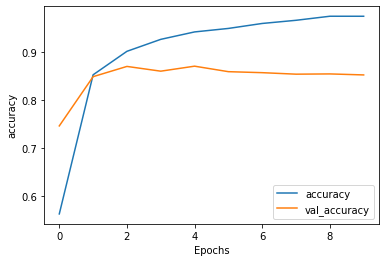

In [28]:
plot_graphs(history, 'accuracy')

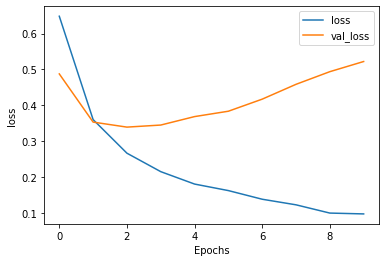

In [29]:
plot_graphs(history, 'loss')

检查其他现有循环层，例如 [GRU 层](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU)。

如果您对构建自定义 RNN 感兴趣，请参阅 [Keras RNN 指南](../../guide/keras/rnn.ipynb)。
